In [1]:
import torch,torchvision,os,time
import torchvision.transforms as transforms
import numpy as np
from utils.util import get_loader,evaluate
from utils.layer import qConv2d,qLinear
from utils.train import QAVAT_train
import matplotlib.pyplot as plt
import torchvision.models as models             

from mqbench.prepare_by_platform import prepare_by_platform   # add quant nodes for specific Backend
from mqbench.prepare_by_platform import BackendType           # contain various Backend, like TensorRT, NNIE, etc.
from mqbench.utils.state import enable_calibration            # turn on calibration algorithm, determine scale, zero_point, etc.
from mqbench.utils.state import enable_quantization           # turn on actually quantization, like FP32 -> INT8
from mqbench.utils.state import disable_all           
from copy import deepcopy
from mqbench.advanced_ptq import ptq_reconstruction
torch.manual_seed(0)
np.random.seed(0)

In [2]:
def accuracy(output, target, topk=(1,)):
    """Computes the accuracy over the k top predictions for the specified values of k"""
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res


def evaluate(val_loader, model,
             criterion = torch.nn.CrossEntropyLoss().cuda(),device='cuda'):
    s_time = time.time()
    # switch to evaluate mode
    model.eval()
    count,top1,top5,losses = 0,0,0,0
    correct = 0
    with torch.no_grad():
        for i, (images, target) in enumerate(val_loader):
            images, target = images.to(device), target.to(device)
            # compute output
            output = model(images)
            loss = criterion(output, target)
            # measure accuracy and record loss
            acc1, acc5 = accuracy(output, target, topk=(1, 5))
            losses = losses * count/(count+images.size(0)) + loss * images.size(0)/(count+images.size(0))
            top1 = top1 * count/(count+images.size(0)) + acc1 * images.size(0)/(count+images.size(0))
            top5 = top5 * count/(count+images.size(0)) + acc5 * images.size(0)/(count+images.size(0))
            count += images.size(0)
            #correct += acc1 * images.size(0)
    test_time = time.time() - s_time
    #print(f'correct: {correct}/{count}')
    
    return {'top1':top1,'top5':top5,'loss':losses,'time':test_time}

    

In [11]:
adv_ptq = False
dataset = 'cifar100'
modelname = 'resnet56'
mn = dataset.lower()+ '_' + modelname
model = torch.hub.load("chenyaofo/pytorch-cifar-models", mn, 
                       pretrained=True,force_reload=True).cuda()
# model = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar100_mobilenetv2_x0_5", pretrained=True).cuda()
model.eval()
torch.manual_seed(0)
np.random.seed(0)
train,test = get_loader(dataset.upper(),batch_size=512,test_batch_size=128)
train.num_workers = 4
test.num_workers = 4
train.pin_in_memory = True
test.pin_in_memory = True

Downloading: "https://github.com/chenyaofo/pytorch-cifar-models/archive/master.zip" to /homes/zdeng/.cache/torch/hub/master.zip


Files already downloaded and verified
Files already downloaded and verified


In [12]:
evaluate(train,model)

{'top1': tensor([76.0100], device='cuda:0'),
 'top5': tensor([91.9021], device='cuda:0'),
 'loss': tensor(1.0457, device='cuda:0'),
 'time': 6.44319224357605}

In [13]:
evaluate(test,model)

{'top1': tensor([72.6300], device='cuda:0'),
 'top5': tensor([91.9400], device='cuda:0'),
 'loss': tensor(1.2946, device='cuda:0'),
 'time': 1.0853846073150635}

In [14]:
# calibration data used to calibrate PTQ and MPQ
calib_data = []
stacked_tensor = []
calib_fp_output = []
i = 0
with torch.no_grad():
    for img,label in train:
        i += 1
        # stacked_tensor is to calibrate the model
        # calib_data (part of it, as defined later) is the data to calculate ltilde
        if i<= 2:
            stacked_tensor.append(img)
            
        calib_data.append((img,label))
        calib_fp_output.append(model(img.cuda()))


In [15]:
MPQ_scheme = (2,4,8)
model.eval()

CifarResNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias

In [16]:
# configuration
ptq_reconstruction_config_init = {
    'pattern': 'block',                   #? 'layer' for Adaround or 'block' for BRECQ and QDROP
    'scale_lr': 4.0e-5,                   #? learning rate for learning step size of activation
    'warm_up': 0.2,                       #? 0.2 * max_count iters without regularization to floor or ceil
    'weight': 0.01,                       #? loss weight for regularization item
    'max_count': 1,                   #? optimization iteration
    'b_range': [20,2],                    #? beta decaying range
    'keep_gpu': True,                     #? calibration data restore in gpu or cpu
    'round_mode': 'learned_hard_sigmoid', #? ways to reconstruct the weight, currently only support learned_hard_sigmoid
    'prob': 0.5,                          #? dropping probability of QDROP, 1.0 for Adaround and BRECQ
}


ptq_reconstruction_config = {
    'pattern': 'block',                   #? 'layer' for Adaround or 'block' for BRECQ and QDROP
    'scale_lr': 4.0e-5,                   #? learning rate for learning step size of activation
    'warm_up': 0.2,                       #? 0.2 * max_count iters without regularization to floor or ceil
    'weight': 0.01,                       #? loss weight for regularization item
    'max_count': 20000,                   #? optimization iteration
    'b_range': [20,2],                    #? beta decaying range
    'keep_gpu': True,                     #? calibration data restore in gpu or cpu
    'round_mode': 'learned_hard_sigmoid', #? ways to reconstruct the weight, currently only support learned_hard_sigmoid
    'prob': 0.5,                          #? dropping probability of QDROP, 1.0 for Adaround and BRECQ
}

class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__
ptq_reconstruction_config = dotdict(ptq_reconstruction_config)
ptq_reconstruction_config_init = dotdict(ptq_reconstruction_config_init)

def getModuleByName(model,moduleName):
    '''
        replace module with name modelName.moduleName with newModule
    '''
    tokens = moduleName.split('.')
    m = model
    for tok in tokens:
        m = getattr(m,tok)
    return m

for b in MPQ_scheme:
    mqb_fp_model = deepcopy(model)
    
    # MSE calibration on model parameters
    backend = BackendType.Academic
    extra_config = {
        'extra_qconfig_dict': {
            'w_observer': 'MSEObserver',                              # custom weight observer
            'a_observer': 'EMAMSEObserver',                              # custom activation observer
            'w_fakequantize': 'AdaRoundFakeQuantize' if adv_ptq else 'FixedFakeQuantize',
            'a_fakequantize': 'QDropFakeQuantize' if adv_ptq else 'FixedFakeQuantize',
            'w_qscheme': {
                'bit': b,                                             # custom bitwidth for weight,
                'symmetry': True,                                    # custom whether quant is symmetric for weight,
                'per_channel': False,                                  # custom whether quant is per-channel or per-tensor for weight,
                'pot_scale': False,                                   # custom whether scale is power of two for weight.
            },
            'a_qscheme': {
                'bit': 8,                                             # custom bitwidth for activation,
                'symmetry': False,                                    # custom whether quant is symmetric for activation,
                'per_channel': False,                                  # custom whether quant is per-channel or per-tensor for activation,
                'pot_scale': False,                                   # custom whether scale is power of two for activation.
            }
        }                                                         # custom tracer behavior, checkout https://github.com/pytorch/pytorch/blob/efcbbb177eacdacda80b94ad4ce34b9ed6cf687a/torch/fx/_symbolic_trace.py#L836
    }
    print(f'Prepare {b}bits model using MQBench')

    exec(f'mqb_{b}bits_model=prepare_by_platform(mqb_fp_model, backend,extra_config).cuda()')
    
    # calibration loop
    enable_calibration(eval(f'mqb_{b}bits_model'))
    for img in stacked_tensor:
        eval(f'mqb_{b}bits_model')(img.cuda())
    
    if adv_ptq:
        if os.path.exists(f'QDROP_{b}bits_{mn}.pt'):
            exec(f'mqb_{b}bits_model=ptq_reconstruction(mqb_{b}bits_model, stacked_tensor, ptq_reconstruction_config_init).cuda()')
            print(f'QDROP model already saved, now loading QDROP_{b}bits_{mn}.pt')
            load_from = f'QDROP_{b}bits_{mn}.pt'
            exec(f'mqb_{b}bits_model.load_state_dict(torch.load(load_from))')
        else:
            
            exec(f'mqb_{b}bits_model=ptq_reconstruction(mqb_{b}bits_model, stacked_tensor, ptq_reconstruction_config).cuda()')
            print(f'saving QDROP tuned model: QDROP_{b}bits_{mn}.pt...')
            torch.save(eval(f'mqb_{b}bits_model').state_dict(),f'QDROP_{b}bits_{mn}.pt')

Prepare 2bits model using MQBench
[MQBENCH] INFO: Quantize model Scheme: BackendType.Academic Mode: Eval
[MQBENCH] INFO: Weight Qconfig:
    FakeQuantize: FixedFakeQuantize Params: {}
    Oberver:      MSEObserver Params: Symmetric: True / Bitwidth: 2 / Per channel: False / Pot scale: False / Extra kwargs: {}
[MQBENCH] INFO: Activation Qconfig:
    FakeQuantize: FixedFakeQuantize Params: {}
    Oberver:      EMAMSEObserver Params: Symmetric: False / Bitwidth: 8 / Per channel: False / Pot scale: False / Extra kwargs: {}
[MQBENCH] INFO: Replace module to qat module.
[MQBENCH] INFO: Set layer conv1 to 8 bit.
[MQBENCH] INFO: Set layer fc to 8 bit.
dbg node_to_quantize_output
 odict_keys([x, relu, layer1_0_relu, layer1_0_relu_1, layer1_1_relu, layer1_1_relu_1, layer1_2_relu, layer1_2_relu_1, layer1_3_relu, layer1_3_relu_1, layer1_4_relu, layer1_4_relu_1, layer1_5_relu, layer1_5_relu_1, layer1_6_relu, layer1_6_relu_1, layer1_7_relu, layer1_7_relu_1, layer1_8_relu, layer1_8_relu_1, layer2_0_r

[MQBENCH] INFO: Insert act quant layer1_5_relu_1_post_act_fake_quantizer
[MQBENCH] INFO: Insert act quant layer1_6_relu_post_act_fake_quantizer
[MQBENCH] INFO: Insert act quant layer1_6_relu_1_post_act_fake_quantizer
[MQBENCH] INFO: Insert act quant layer1_7_relu_post_act_fake_quantizer
[MQBENCH] INFO: Insert act quant layer1_7_relu_1_post_act_fake_quantizer
[MQBENCH] INFO: Insert act quant layer1_8_relu_post_act_fake_quantizer
[MQBENCH] INFO: Insert act quant layer1_8_relu_1_post_act_fake_quantizer
[MQBENCH] INFO: Insert act quant layer2_0_relu_post_act_fake_quantizer
[MQBENCH] INFO: Insert act quant layer2_0_relu_1_post_act_fake_quantizer
[MQBENCH] INFO: Insert act quant layer2_1_relu_post_act_fake_quantizer
[MQBENCH] INFO: Insert act quant layer2_1_relu_1_post_act_fake_quantizer
[MQBENCH] INFO: Insert act quant layer2_2_relu_post_act_fake_quantizer
[MQBENCH] INFO: Insert act quant layer2_2_relu_1_post_act_fake_quantizer
[MQBENCH] INFO: Insert act quant layer2_3_relu_post_act_fake_qu

[MQBENCH] INFO: Insert act quant layer3_5_relu_post_act_fake_quantizer
[MQBENCH] INFO: Insert act quant layer3_5_relu_1_post_act_fake_quantizer
[MQBENCH] INFO: Insert act quant layer3_6_relu_post_act_fake_quantizer
[MQBENCH] INFO: Insert act quant layer3_6_relu_1_post_act_fake_quantizer
[MQBENCH] INFO: Insert act quant layer3_7_relu_post_act_fake_quantizer
[MQBENCH] INFO: Insert act quant layer3_7_relu_1_post_act_fake_quantizer
[MQBENCH] INFO: Insert act quant layer3_8_relu_post_act_fake_quantizer
[MQBENCH] INFO: Set view post act quantize to 8 bit.
[MQBENCH] INFO: Insert act quant view_post_act_fake_quantizer
[MQBENCH] INFO: Enable observer and Disable quantize.


In [17]:
for b in MPQ_scheme: 
    disable_all(eval(f'mqb_{b}bits_model'))
    # evaluation loop
    enable_quantization(eval(f'mqb_{b}bits_model'))
    eval(f'mqb_{b}bits_model').eval()
    print('evaluate mqb quantized model')
    print(evaluate(test,eval(f'mqb_{b}bits_model')))

[MQBENCH] INFO: Disable observer and Disable quantize.
[MQBENCH] INFO: Disable observer and Enable quantize.
evaluate mqb quantized model
{'top1': tensor([1.0000], device='cuda:0'), 'top5': tensor([6.0100], device='cuda:0'), 'loss': tensor(6.0283, device='cuda:0'), 'time': 2.750342845916748}
[MQBENCH] INFO: Disable observer and Disable quantize.
[MQBENCH] INFO: Disable observer and Enable quantize.
evaluate mqb quantized model
{'top1': tensor([46.9900], device='cuda:0'), 'top5': tensor([74.7600], device='cuda:0'), 'loss': tensor(3.2738, device='cuda:0'), 'time': 2.7125532627105713}
[MQBENCH] INFO: Disable observer and Disable quantize.
[MQBENCH] INFO: Disable observer and Enable quantize.
evaluate mqb quantized model
{'top1': tensor([72.4400], device='cuda:0'), 'top5': tensor([91.9400], device='cuda:0'), 'loss': tensor(1.3010, device='cuda:0'), 'time': 2.739100933074951}


In [18]:
mqb_fp_model = deepcopy(mqb_8bits_model)
disable_all(mqb_fp_model)
mqb_mix_model = deepcopy(mqb_fp_model)

# 1. record all modules we want to consider
types_to_quant = (torch.nn.Conv2d,torch.nn.Linear)

layer_input_map = {}

for node in mqb_8bits_model.graph.nodes:
    try:
        node_target = getModuleByName(mqb_mix_model,node.target)
        if isinstance(node_target,types_to_quant):
            node_args = node.args[0]
            print('input of ',node.target,' is ',node_args)
            layer_input_map[node.target] = str(node_args.target)
    except:
        continue

[MQBENCH] INFO: Disable observer and Disable quantize.
input of  conv1  is  x_post_act_fake_quantizer
input of  layer1.0.conv1  is  relu_post_act_fake_quantizer
input of  layer1.0.conv2  is  layer1_0_relu_post_act_fake_quantizer
input of  layer1.1.conv1  is  layer1_0_relu_1_post_act_fake_quantizer
input of  layer1.1.conv2  is  layer1_1_relu_post_act_fake_quantizer
input of  layer1.2.conv1  is  layer1_1_relu_1_post_act_fake_quantizer
input of  layer1.2.conv2  is  layer1_2_relu_post_act_fake_quantizer
input of  layer1.3.conv1  is  layer1_2_relu_1_post_act_fake_quantizer
input of  layer1.3.conv2  is  layer1_3_relu_post_act_fake_quantizer
input of  layer1.4.conv1  is  layer1_3_relu_1_post_act_fake_quantizer
input of  layer1.4.conv2  is  layer1_4_relu_post_act_fake_quantizer
input of  layer1.5.conv1  is  layer1_4_relu_1_post_act_fake_quantizer
input of  layer1.5.conv2  is  layer1_5_relu_post_act_fake_quantizer
input of  layer1.6.conv1  is  layer1_5_relu_1_post_act_fake_quantizer
input of  l

In [19]:
# ref_metric = ('loss',evaluate(calib_data,mqb_fp_model)['loss'])

In [20]:
def perturb(perturb_scheme):
    # perturb_scheme: {layer_name:(act_bits,weight_bits)}
    for layer_name in perturb_scheme:
        a_bits,w_bits = perturb_scheme[layer_name]
        
        if w_bits is not None:
            mix_module = getModuleByName(mqb_mix_model,layer_name)
            tar_module = getModuleByName(eval(f'mqb_{w_bits}bits_model'),layer_name)
            # replace weight quant to use w_bits quantization
            w_cmd = f'mix_module.weight_fake_quant=tar_module.weight_fake_quant'
            exec(w_cmd)
        
        if a_bits is not None:
        
            # replace act quant to use a_bits quantization
            a_cmd = f'mqb_mix_model.{layer_input_map[layer_name]}=mqb_{a_bits}bits_model.{layer_input_map[layer_name]}'
            exec(a_cmd)
        
        #print(layer_name)
        #print(a_cmd)
        #print(w_cmd)


In [21]:
# perturb functionality test
perturb_scheme = {}
for layer_name in layer_input_map:
    perturb_scheme[layer_name] = (8,8)
perturb(perturb_scheme)

In [22]:
evaluate(test,mqb_mix_model)

{'top1': tensor([72.4400], device='cuda:0'),
 'top5': tensor([91.9400], device='cuda:0'),
 'loss': tensor(1.3010, device='cuda:0'),
 'time': 2.747572660446167}

In [23]:
mqb_mix_model = deepcopy(mqb_8bits_model)
disable_all(mqb_mix_model)
evaluate(test,mqb_mix_model)

[MQBENCH] INFO: Disable observer and Disable quantize.


{'top1': tensor([72.6300], device='cuda:0'),
 'top5': tensor([91.9400], device='cuda:0'),
 'loss': tensor(1.2946, device='cuda:0'),
 'time': 2.173597812652588}

## CLADO

In [24]:
import torch.nn.functional as F
kl_loss = torch.nn.KLDivLoss(reduction="batchmean")
def kldiv(quant_logit,fp_logit):
    inp = F.log_softmax(quant_logit,dim=-1)
    tar = F.softmax(fp_logit,dim=-1)
    return kl_loss(inp,tar)

def perturb_loss(perturb_scheme,ref_metric,
                 eval_data=calib_data,printInfo=False,KL=False):
    
    global mqb_mix_model
    mqb_mix_model.eval()
    
    with torch.no_grad():
        # perturb layers
        perturb(perturb_scheme)
            
        # do evaluation
        if not KL:
            res = evaluate(eval_data,mqb_mix_model)
            perturbed_loss = res[ref_metric[0]] - ref_metric[1]
        else:
            perturbed_loss = []
            
            for (data,fp_out) in zip(calib_data,calib_fp_output):
                img,label = data
                quant_out = mqb_mix_model(img.cuda())
                perturbed_loss.append(kldiv(quant_out,fp_out))
            #print(perturbed_loss)
            perturbed_loss = torch.tensor(perturbed_loss).mean()    
        
        if printInfo:
            print(f'use kl {KL} perturbed loss {perturbed_loss}')
        
        # recover layers
        mqb_mix_model = deepcopy(mqb_fp_model)
            
    return perturbed_loss

In [25]:
import pickle
def estimate_deltaL(eval_data,wbit_choices=[2,4,8]):
    
    tot_batches = len(eval_data)
    
    processed_batches = 0
    
    print(f'MPPCO Ltilde: {processed_batches}/{tot_batches} batch of data processed')
    
    for batch_img,batch_label in eval_data:
        
        s_time = time.time()
        # init deltaL dictionary
        deltaL = {}
        for layer in layer_input_map:
            if layer in ('conv1','fc'):
                continue
            deltaL[layer] = {}
            for wbit in wbit_choices:
                deltaL[layer][wbit] = 0
        
        for i in range(batch_img.size(0)):
            
            img,label = batch_img[i].unsqueeze(0),batch_label[i]
            model.zero_grad()
            logits = model(img.cuda())       
            logits[0][label].backward()
    
            with torch.no_grad():
                for layer_name in layer_input_map:
                    if layer_name in ('conv1','fc'):
                        continue
                    for w_bits in wbit_choices:
                        tar_module = getModuleByName(eval(f'mqb_{w_bits}bits_model'),layer_name)
                        dw = tar_module.weight_fake_quant(tar_module.weight) - tar_module.weight
                        dl = (dw * getModuleByName(model,layer_name).weight.grad).sum()
                        dl /= logits[0][label]
                        dl = dl ** 2
                        deltaL[layer_name][w_bits] += dl.cpu().numpy()
        
        for layer in layer_input_map:
            if layer in ('conv1','fc'):
                continue
            for wbit in wbit_choices:
                deltaL[layer][wbit] /= 2 * batch_img.size(0)
        
        deltaL['n_samples'] = batch_img.size(0)
        
        #print(deltaL)
        with open(f'DELTAL_resnet56_batch{processed_batches}(size512).pkl','wb') as f:
            pickle.dump(deltaL,f)
            
        processed_batches += 1
        
        print(f'MPPCO Ltilde: {processed_batches}/{tot_batches} batch of data processed')
        print(f'batch cost:{time.time()-s_time:.2f} seconds')

## Check Ltilde

In [26]:
del layer_input_map['conv1']
del layer_input_map['fc']

import time
import matplotlib.pyplot as plt
s_time = time.time()
cached = {}
aw_scheme = []
for a_bits in MPQ_scheme:
    for w_bits in MPQ_scheme:
        aw_scheme.append((a_bits,w_bits))

aw_scheme = [(8,2),(8,4),(8,8)]

In [27]:
# estimate_deltaL(calib_data)

In [28]:
# KL=False

# for clado_batch in range(len(calib_data)):
#     print(f'clado batch {clado_batch+1}/{len(calib_data)}')
#     ref_metric = ('loss',
#                   evaluate([calib_data[clado_batch],],mqb_fp_model)['loss'])
    
#     s_time = time.time()
#     cached = {}
#     for n in layer_input_map:
#         for m in layer_input_map:
#             for naw in aw_scheme:
#                 for maw in aw_scheme:
#                     if (n,m,naw,maw) not in cached:
#                         if n == m:
#                             if naw == maw:
#                                 p = perturb_loss({n:naw},ref_metric,
#                                                  [calib_data[clado_batch],],KL=KL)
#                                 #print(f'perturb layer {n} to A{naw[0]}W{naw[1]} p={p}')
#                             else:
#                                 p = 0

#                         else:
#                             p = perturb_loss({n:naw,m:maw},ref_metric,
#                                              [calib_data[clado_batch],],KL=KL)
#                             #print(f'perturb layer {n} to A{naw[0]}W{naw[1]} and layer {m} to A{maw[0]}W{maw[1]} p={p}')

#                         cached[(n,m,naw,maw)] = cached[(m,n,maw,naw)] = p

#     print(f'{time.time()-s_time:.2f} seconds elapsed')
    
#     # layer index and index2layerscheme map
#     layer_index = {}
#     cnt = 0
#     for layer in layer_input_map:
#         for s in aw_scheme:
#             layer_index[layer+f'{s}bits'] = cnt
#             cnt += 1
#     L = cnt

#     import numpy as np
#     hm = np.zeros(shape=(L,L))
#     for n in layer_input_map:
#         for m in layer_input_map:
#             for naw in aw_scheme:
#                 for maw in aw_scheme:
#                     hm[layer_index[n+f'{naw}bits'],layer_index[m+f'{maw}bits']] = cached[(n,m,naw,maw)]

#     index2layerscheme = [None for i in range(hm.shape[0])]

#     for name in layer_index:
#         index = layer_index[name]
#         layer_name = name[:-10]
#         scheme = name[-10:]

#         index2layerscheme[index] = (layer_name,scheme)
    
#     import pickle
    
#     with open('gc_tmp.pkl','wb') as f:
#         pickle.dump({'Ltilde':hm,'layer_index':layer_index,'index2layerscheme':index2layerscheme},f)

#     saveas = f'Ltilde_batch{clado_batch}(size512)_'
#     saveas += 'QDROP' if adv_ptq else ''
#     saveas += str(aw_scheme)
#     saveas += mn
#     saveas += 'KL' if KL else ''
#     saveas += '.pkl'

#     with open(saveas,'wb') as f:
#         pickle.dump({'Ltilde':hm,'layer_index':layer_index,'index2layerscheme':index2layerscheme},f)


## Preciseness of ltilde
There are 98 batches, the first contains 512 samples each, the last contains 336 samples

In [29]:
batch_size = np.ones((98,)) * 512
batch_size[-1] = 336

In [30]:
import pickle
ref_layer_index = None
ref_index2layerscheme = None
true_Ltilde = 0
batch_Ltildes = []
sample_used = 0
KL = False

for clado_batch in range(77):
    #print(f'clado batch {clado_batch}')
    saveas = f'Ltilde_resnet56/Ltilde_batch{clado_batch}(size512)_'
    saveas += 'QDROP' if adv_ptq else ''
    saveas += str(aw_scheme)
    saveas += mn
    saveas += 'KL' if KL else ''
    saveas += '.pkl'

    with open(saveas,'rb') as f:
        res = pickle.load(f)
        
    if ref_layer_index is None:
        ref_layer_index = res['layer_index']
        ref_index2layerscheme = res['index2layerscheme']
        
    else:
        assert ref_layer_index == res['layer_index']
        assert ref_index2layerscheme == res['index2layerscheme']
    
    if clado_batch < 97:
        batch_size = 512
    else:
        batch_size = 336
        
    true_Ltilde = true_Ltilde * sample_used + res['Ltilde'] * batch_size
    sample_used += batch_size
    true_Ltilde /= sample_used
    
    batch_Ltildes.append(res['Ltilde'])
batch_Ltildes = np.array(batch_Ltildes)

In [31]:
true_Ltilde

array([[ 7.66049934e-01,  0.00000000e+00,  0.00000000e+00, ...,
         6.08693744e-01,  7.51808491e-01,  7.66051552e-01],
       [ 0.00000000e+00, -3.15296185e-02,  0.00000000e+00, ...,
        -7.35380278e-02, -3.87948674e-02, -3.16437235e-02],
       [ 0.00000000e+00,  0.00000000e+00,  4.14950043e-03, ...,
        -4.65776278e-02, -3.97041634e-03,  4.07459597e-03],
       ...,
       [ 6.08693744e-01, -7.35380278e-02, -4.65776278e-02, ...,
        -5.03166256e-02,  0.00000000e+00,  0.00000000e+00],
       [ 7.51808491e-01, -3.87948674e-02, -3.97041634e-03, ...,
         0.00000000e+00, -8.11429689e-03,  0.00000000e+00],
       [ 7.66051552e-01, -3.16437235e-02,  4.07459597e-03, ...,
         0.00000000e+00,  0.00000000e+00, -5.79976416e-05]])

In [32]:
batch_size = np.ones(98) * 512
batch_size[-1] = 336
clado_sizes = []
Ltilde_errors = []

for n_sample_batches in range(1,78):
    
    for trials in range(1000):

        shuffle = np.random.choice(77,n_sample_batches,replace=False)
        
        new_batch_size = batch_size[shuffle]
        
        new_batch_Ltildes = batch_Ltildes[shuffle]
        
        est_Ltilde = np.einsum('a,abc->bc',new_batch_size,new_batch_Ltildes)
        
        n_samples = new_batch_size.sum()
        
        est_Ltilde /= n_samples
        
        diff = np.abs(est_Ltilde - true_Ltilde).mean()
        
        clado_sizes.append(n_samples)
        Ltilde_errors.append(diff)
    
    

In [33]:
plt.rcParams['figure.figsize'] = (12,10)

Text(0, 0.5, 'Ltilde error')

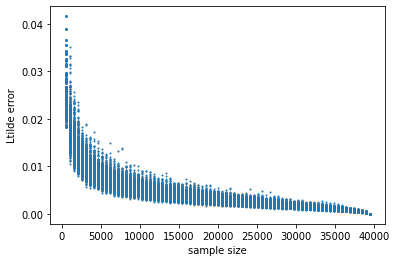

In [34]:
plt.rcParams['figure.figsize'] = (12,10)
plt.scatter(clado_sizes,Ltilde_errors,s=1)
plt.xlabel('sample size')
plt.ylabel('Ltilde error')

Text(0, 0.5, 'Ltilde error')

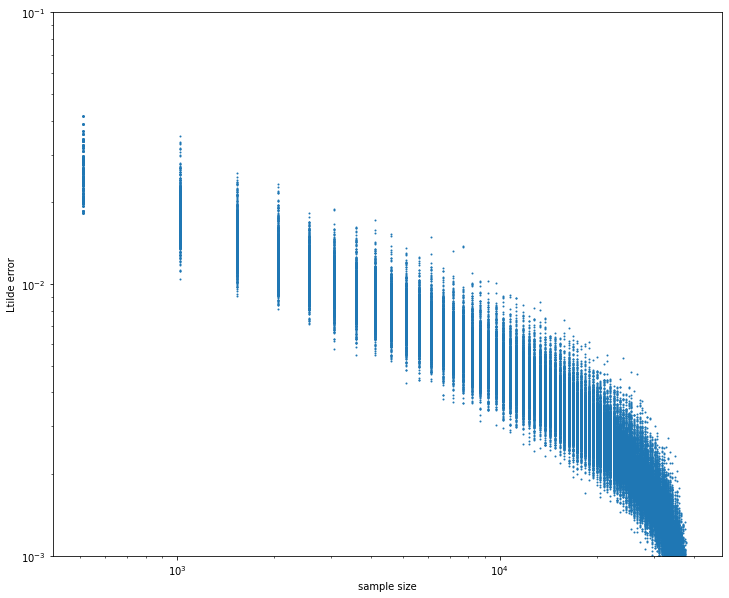

In [35]:
plt.rcParams['figure.figsize'] = (12,10)
plt.scatter(clado_sizes,Ltilde_errors,s=1)
plt.yscale('log')
plt.xscale('log')
plt.ylim([1e-3,1e-1])
plt.xlabel('sample size')
plt.ylabel('Ltilde error')

In [36]:
def calculate_mean(size_arr,err_arr):
    size_err = {}
    
    for i in range(len(size_arr)):
        if size_arr[i] not in size_err:
            size_err[size_arr[i]] = [err_arr[i],]
        else:
            size_err[size_arr[i]].append(err_arr[i])
    
    size_arr_,err_arr_ = [],[]
    
    for size in size_err:
        size_err[size] = np.array(size_err[size])
        #size_err[size] = (size_err[size].mean(),size_err[size].std())
        
        size_arr_.append(size)
        err_arr_.append(size_err[size].mean())
    
    size_arr_,err_arr_ =  np.array(size_arr_),np.array(err_arr_)
    return size_arr_[np.argsort(size_arr_)],err_arr_[np.argsort(size_arr_)]
clado_sizes_mean,clado_err_mean = calculate_mean(clado_sizes,Ltilde_errors)

Text(0, 0.5, 'Ltilde error')

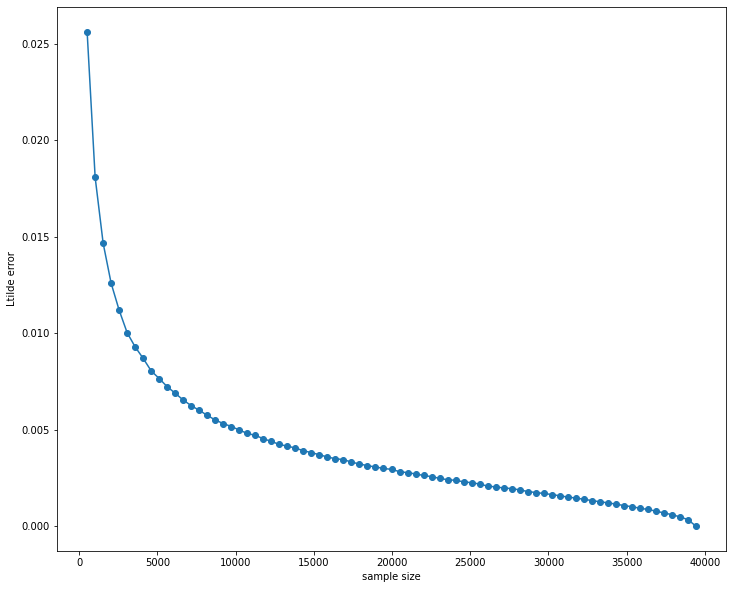

In [37]:
plt.plot(clado_sizes_mean,clado_err_mean,marker='o')
plt.xlabel('sample size')
plt.ylabel('Ltilde error')

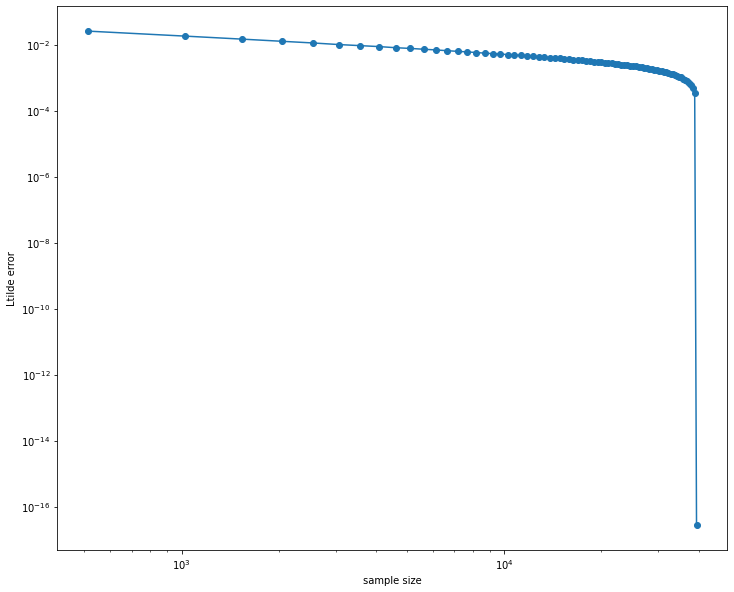

In [38]:
plt.plot(clado_sizes_mean,clado_err_mean,marker='o')
plt.xlabel('sample size')
plt.ylabel('Ltilde error')
plt.yscale('log')
plt.xscale('log')

(0.001, 0.1)

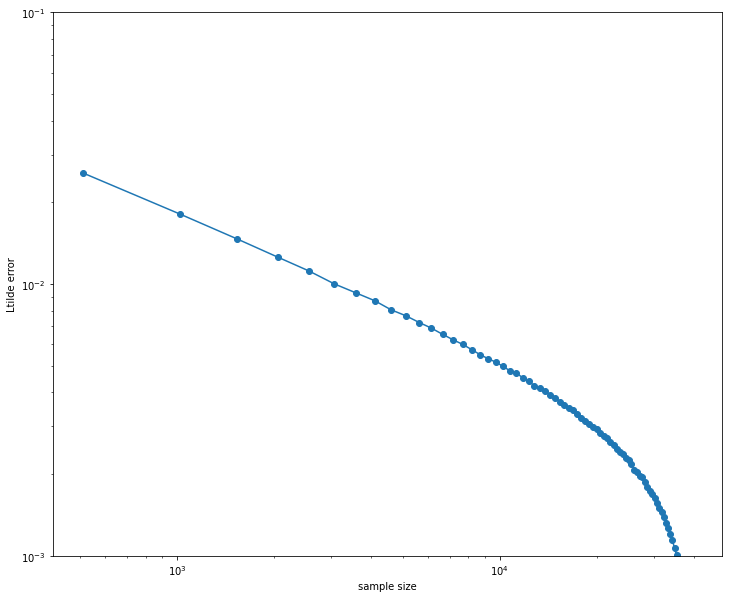

In [39]:
plt.plot(clado_sizes_mean,clado_err_mean,marker='o')
plt.xlabel('sample size')
plt.ylabel('Ltilde error')
plt.yscale('log')
plt.xscale('log')
plt.ylim([1e-3,1e-1])

## Comparison: CLADO, Naive, MPQCO

In [60]:
with open('Ltilde_resnet56/Ltilde_batch0(size512)_[(8, 2), (8, 4), (8, 8)]cifar100_resnet56.pkl','rb') as f:
    hm = pickle.load(f)
ref_layer_index = hm['layer_index']
ref_index2layerscheme = hm['index2layerscheme']

batch_Ltildes_clado = []
for batch_id in range(98):
    with open(f'Ltilde_resnet56/Ltilde_batch{batch_id}(size512)_[(8, 2), (8, 4), (8, 8)]cifar100_resnet56.pkl','rb') as f:
        hm = pickle.load(f)
    
    assert hm['layer_index'] == ref_layer_index
    batch_Ltildes_clado.append(hm['Ltilde'])
batch_Ltildes_clado = np.array(batch_Ltildes_clado)
ref_Ltilde_clado = np.einsum('a,abc->bc',batch_size,batch_Ltildes_clado)/batch_size.sum()

batch_Ltildes_mpqco = []
for batch_id in range(98):
    with open(f'DELTAL_resnet56/DELTAL_resnet56_batch{batch_id}(size512).pkl','rb') as f:
        hm = pickle.load(f)
        
    deltal = np.zeros(ref_Ltilde_clado.shape)
    
    for layer_id in range(len(ref_index2layerscheme)):
        layer_name,scheme = ref_index2layerscheme[layer_id]
        wbit = eval(scheme[:-4])[1]
        deltal[layer_id,layer_id] = hm[layer_name][wbit]
    batch_Ltildes_mpqco.append(deltal)
batch_Ltildes_mpqco = np.array(batch_Ltildes_mpqco)
ref_Ltilde_mpqco = np.einsum('a,abc->bc',batch_size,batch_Ltildes_mpqco)/batch_size.sum()


In [61]:
class layer_hook(object):

    def __init__(self):
        super(layer_hook, self).__init__()
        self.in_shape = None
        self.out_shape = None

    def hook(self, module, inp, outp):
        self.in_shape = inp[0].size()
        self.out_shape = outp.size()
    

hooks = {}

for layer in ref_layer_index:
    m = getModuleByName(model,layer[:-10])
    hook = layer_hook()
    hooks[layer[:-10]] = (hook,m.register_forward_hook(hook.hook))

In [62]:
with torch.no_grad():
    for img,label in train:
        model(img.cuda())
        break

In [63]:
def get_layer_bitops(layer_name,a_bits,w_bits):
    
    m = getModuleByName(model,layer_name)
    
    if isinstance(m,torch.nn.Conv2d):
        _,cin,_,_ = hooks[layer_name][0].in_shape
        _,cout,hout,wout = hooks[layer_name][0].out_shape
        
        n_muls = cin * m.weight.size()[2] * m.weight.size()[3] * cout * hout * wout
        n_accs = (cin * m.weight.size()[2] * m.weight.size()[3] - 1) * cout * hout * wout
        
        #bitops_per_mul = 2 * a_bits * w_bits
        #bitops_per_acc = (a_bits + w_bits) + np.ceil(np.log2(cin * m.weight.size()[2] * m.weight.size()[3]))
        
        bitops_per_mul = 5*a_bits*w_bits - 5*a_bits-3*w_bits+3
        bitops_per_acc = 3*a_bits + 3*w_bits + 29
        
        return n_muls * bitops_per_mul + n_accs * bitops_per_acc

In [64]:
L = ref_Ltilde_clado.shape[0]
layer_size = np.array([0 for i in range(L)])
layer_bitops = np.array([0 for i in range(L)])
for l in ref_layer_index:
    index = ref_layer_index[l]
    layer_name, scheme = ref_index2layerscheme[index]
    a_bits,w_bits = eval(scheme[:-4])
    #print(layer_name,a_bits,w_bits)
    layer_size[index] = torch.numel(getModuleByName(model,layer_name).weight) * int(w_bits)
    layer_bitops[index] = get_layer_bitops(layer_name,a_bits,w_bits)

In [65]:
def evaluate_decision(v,printInfo=False,test=test):
    global mqb_mix_model
    v = v.detach()
    # alpha = torch.nn.Softmax(dim=1)(v.reshape(-1,len(MPQ_scheme)))
    offset = torch.ones(int(L/len(aw_scheme)),dtype=int) * len(aw_scheme)
    offset = offset.cumsum(dim=-1) - len(aw_scheme)
    select = v.reshape(-1,len(aw_scheme)).argmax(dim=1) + offset
    
    modelsize = (layer_size[select]).sum()/8/1024/1024
    bitops = (layer_bitops[select]).sum()/10**9
    
    decisions = {}
    for scheme_id in select.numpy():
        layer,scheme = ref_index2layerscheme[scheme_id]
        decisions[layer] = eval(scheme[:-4])
    
    print("evaluate_decision\n",decisions)
    

    with torch.no_grad():
        
        # perturb layers
        perturb(decisions)
            
        # do evaluation
        res = evaluate(test,mqb_mix_model)
        
        # recover layers
        mqb_mix_model = deepcopy(mqb_fp_model)
    return res,modelsize,bitops

In [66]:
import cvxpy as cp

def MIQCP_optimize(cached_grad,layer_bitops,layer_size,
                   schemes_per_layer=3,
                   bitops_bound=np.inf,size_bound=np.inf,
                   naive=False,PSD=True):
    
    if cached_grad.__class__ == torch.Tensor:
        cached_grad = cached_grad.cpu().numpy()
    
    
    x = cp.Variable(cached_grad.shape[0], boolean=True)
    schemes_per_layer = schemes_per_layer
    assert cached_grad.shape[0]%schemes_per_layer == 0, 'cached_gradient shape[0] does not divde schemes per layer'
    num_layers = cached_grad.shape[0]//schemes_per_layer
    
    if not naive:
        # convexation of cached_grad
        es,us = np.linalg.eig(cached_grad)
        if PSD:
            es[es<0] = 0
        C = us@np.diag(es)@us.T
        C = cp.atoms.affine.wraps.psd_wrap(C)
        objective = cp.Minimize(cp.quad_form(x,C))
    else:
        objective = cp.Minimize(np.diagonal(cached_grad)@x)

    equality_constraint_matrix = []
    for i in range(num_layers):
        col = np.zeros(cached_grad.shape[0])
        col[i*schemes_per_layer:(i+1)*schemes_per_layer] = 1
        equality_constraint_matrix.append(col)

    equality_constraint_matrix = np.array(equality_constraint_matrix)

    constraints = [equality_constraint_matrix@x == np.ones((num_layers,)),
                   layer_bitops@x/10**9<=bitops_bound,
                   layer_size@x/8/1024/1024<=size_bound]

    prob = cp.Problem(objective,constraints)
    prob.solve(verbose=False,solver='GUROBI',TimeLimit=120)
    
    # Print result.
    print(prob.status)
    print("\nThe optimal value is", prob.value)
    print("A solution x is")
    print(x.value)
    #print(f"bitops: {x.value@layer_bitops}")
    return x

In [67]:
def Ltilde2CachedGrad(Ltilde):
    
    cached_grad = np.zeros_like(Ltilde)
        
    for i in range(cached_grad.shape[0]):
        for j in range(cached_grad.shape[0]):
            layer_i,scheme_i = ref_index2layerscheme[i]
            layer_j,scheme_j = ref_index2layerscheme[j]
            if layer_i == layer_j:
                if scheme_i == scheme_j:
                    cached_grad[i,j] = cached_grad[j,i] = 2 * Ltilde[i,j]
                else:
                    cached_grad[i,j] = cached_grad[j,i] = 0
            else:
                cached_grad[i,j] = cached_grad[j,i] = Ltilde[i,j] - Ltilde[i,i] - Ltilde[j,j]
    return cached_grad
cached_grad = Ltilde2CachedGrad(ref_Ltilde_clado)

v = MIQCP_optimize(cached_grad=cached_grad,
                   layer_bitops=layer_bitops,
                   layer_size=layer_size,
                   schemes_per_layer=len(aw_scheme),
                   bitops_bound=np.inf,size_bound=np.inf,
                   naive=True,PSD=False)
v = torch.Tensor(v.value)
evaluate_decision(v)

optimal

The optimal value is -1.1765087958145144
A solution x is
[0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0.
 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1.
 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 4), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 4), 'layer1.2.conv1': (8, 2), 'layer1.2.conv2': (8, 2), 'layer1.3.conv1': (8, 8), 'layer1.3.conv2': (8, 8), 'layer1.4.conv1': (8, 8), 'layer1.4.conv2': (8, 4), 'layer1.5.conv1': (8, 2), 'layer1.5.conv2': (8, 2), 'layer1.6.conv1': (8, 8), 'layer1.6.conv2': (8, 2), 'layer1.7.conv1': (8, 4), 'layer1.7.co

({'top1': tensor([46.8600], device='cuda:0'),
  'top5': tensor([73.7900], device='cuda:0'),
  'loss': tensor(2.3603, device='cuda:0'),
  'time': 2.939358949661255},
 0.68743896484375,
 32.439693312)

In [68]:
v = MIQCP_optimize(cached_grad=cached_grad,
                   layer_bitops=layer_bitops,
                   layer_size=layer_size,
                   schemes_per_layer=len(aw_scheme),
                   bitops_bound=np.inf,size_bound=np.inf,
                   naive=False,PSD=True)
v = torch.Tensor(v.value)
evaluate_decision(v)

optimal

The optimal value is 0.06595722634107226
A solution x is
[-0.  0.  1. -0. -0.  1. -0.  0.  1. -0.  0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0. -0.  0.  1. -0. -0.  1.
 -0. -0.  1. -0.  1.  0. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1. -0.  0.  1.
 -0.  0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1. -0.  0.  1.
  0.  0.  1.  0. -0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1.
 -0. -0.  1.  0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0. -0. -0.  1. -0.  0.  1.
 -0. -0.  1. -0. -0.  1.  0.  0.  1.  0.  0.  1. -0. -0.  1. -0. -0.  1.
  0.  0.  1. -0. -0.  1.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer1.3.conv1': (8, 8), 'layer1.3.conv2': (8, 8), 'layer1.4.conv1': (8, 8

({'top1': tensor([72.4900], device='cuda:0'),
  'top5': tensor([91.9300], device='cuda:0'),
  'loss': tensor(1.2973, device='cuda:0'),
  'time': 2.9194250106811523},
 0.791259765625,
 40.929718272)

In [69]:
v = MIQCP_optimize(cached_grad=ref_Ltilde_mpqco,
                   layer_bitops=layer_bitops,
                   layer_size=layer_size,
                   schemes_per_layer=len(aw_scheme),
                   bitops_bound=np.inf,size_bound=np.inf,
                   naive=True,PSD=False)
v = torch.Tensor(v.value)
evaluate_decision(v)


optimal

The optimal value is 0.04173187052914021
A solution x is
[0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer1.3.conv1': (8, 8), 'layer1.3.conv2': (8, 8), 'layer1.4.conv1': (8, 8), 'layer1.4.conv2': (8, 8), 'layer1.5.conv1': (8, 8), 'layer1.5.conv2': (8, 8), 'layer1.6.conv1': (8, 8), 'layer1.6.conv2': (8, 8), 'layer1.7.conv1': (8, 8), 'layer1.7.co

({'top1': tensor([72.6100], device='cuda:0'),
  'top5': tensor([91.9300], device='cuda:0'),
  'loss': tensor(1.2998, device='cuda:0'),
  'time': 2.9467058181762695},
 0.81103515625,
 42.061737984)

In [70]:
for n_batch in (1,4,16,64):
    
    for sid in range(10):
        
        print(f'{n_batch} batches sid {sid}')
        
        clado_perf,clado_size,clado_bitops = [],[],[]
        mpqco_perf,mpqco_size,mpqco_bitops = [],[],[]
        naive_perf,naive_size,naive_bitops = [],[],[]
        
        
        shuffle = np.random.choice(98,n_batch,replace=False)
        clado_ltilde = np.einsum('a,abc->bc',batch_size[shuffle],batch_Ltildes_clado[shuffle])/batch_size[shuffle].sum()
        mpqco_ltilde = np.einsum('a,abc->bc',batch_size[shuffle],batch_Ltildes_mpqco[shuffle])/batch_size[shuffle].sum()
        
            
        for size_bound in np.linspace(0.4,0.8,21):
            # CLADO Way
            print(f'clado with size bound {size_bound}')
            cached_grad = Ltilde2CachedGrad(clado_ltilde)
            v = MIQCP_optimize(cached_grad=cached_grad,
                               layer_bitops=layer_bitops,
                               layer_size=layer_size,
                               schemes_per_layer=len(aw_scheme),
                               bitops_bound=np.inf,size_bound=size_bound,
                               naive=False,PSD=True)
            v = torch.Tensor(v.value)
            perf,size,bitops = evaluate_decision(v)
            clado_perf.append(perf)
            clado_size.append(size)
            clado_bitops.append(bitops)
            print(perf,size,bitops)
            
            # naive Way
            print(f'naive with size bound {size_bound}')
            cached_grad = Ltilde2CachedGrad(clado_ltilde)
            v = MIQCP_optimize(cached_grad=cached_grad,
                               layer_bitops=layer_bitops,
                               layer_size=layer_size,
                               schemes_per_layer=len(aw_scheme),
                               bitops_bound=np.inf,size_bound=size_bound,
                               naive=True,PSD=False)
            v = torch.Tensor(v.value)
            perf,size,bitops = evaluate_decision(v)
            naive_perf.append(perf)
            naive_size.append(size)
            naive_bitops.append(bitops)
            print(perf,size,bitops)
            
            # MPQCO Way
            print(f'MPQCO with size bound {size_bound}')
            v = MIQCP_optimize(cached_grad=mpqco_ltilde,
                               layer_bitops=layer_bitops,
                               layer_size=layer_size,
                               schemes_per_layer=len(aw_scheme),
                               bitops_bound=np.inf,size_bound=size_bound,
                               naive=True,PSD=False)
            v = torch.Tensor(v.value)
            perf,size,bitops = evaluate_decision(v)
            mpqco_perf.append(perf)
            mpqco_size.append(size)
            mpqco_bitops.append(bitops)
            print(perf,size,bitops)
        
        with open(f'RES_resnet56/RES_SIZEOPT_resnet56{n_batch}batches(size64)_sid{sid}.pkl','wb') as f:
            pickle.dump({'shuffle':shuffle,
                         'clado_perf':clado_perf,'clado_size':clado_size,'clado_bitops':clado_bitops,
                         'naive_perf':naive_perf,'naive_size':naive_size,'naive_bitops':naive_bitops,
                         'mpqco_perf':mpqco_perf,'mpqco_size':mpqco_size,'mpqco_bitops':mpqco_bitops},f)
        

1 batches sid 0
clado with size bound 0.4
optimal

The optimal value is 2.7380910146660704
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0. -0.  0.  1. -0. -0.  1.
 -0.  0.  1. -0.  1.  0. -0. -0.  1. -0.  1. -0. -0. -0.  1. -0.  1. -0.
 -0.  1.  0. -0.  1. -0. -0. -0.  1. -0.  1.  0.  0.  0.  1. -0. -0.  1.
  0.  0.  1.  0. -0.  1.  0.  0.  1. -0.  1. -0.  0.  1. -0. -0.  1. -0.
 -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.
 -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.  0.
 -0.  1. -0.  0.  0.  1.  0.  1. -0. -0.  0.  1.  0.  1.  0.  1.  0.  0.
  0.  1.  0. -0.  1.  0. -0.  1.  0.  0.  1.  0.  0.  1.  0. -0.  1.  0.
  0.  1.  0. -0.  1. -0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1. -0.  0.
  1. -0.  0.  1. -0.  0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 4), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer1.3.conv1': (8, 8), 'layer1.

{'top1': tensor([65.1900], device='cuda:0'), 'top5': tensor([87.7300], device='cuda:0'), 'loss': tensor(1.3691, device='cuda:0'), 'time': 3.4663543701171875} 0.419921875 26.588688384
naive with size bound 0.42000000000000004
optimal

The optimal value is -0.5725321769714355
A solution x is
[ 0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.
  0. -0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  1.  0.  0.  1.  0.  0.
  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  1. -0.  0.  1.  0.  0.
  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.  0.  1.
  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  0.  1.
  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  0.  1.
  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.
  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.
  0.  1.  0.  1.  0.  0.]
evaluate_decision
 {'layer

{'top1': tensor([26.6000], device='cuda:0'), 'top5': tensor([52.1700], device='cuda:0'), 'loss': tensor(3.4593, device='cuda:0'), 'time': 2.812638282775879} 0.439697265625 23.759499264
MPQCO with size bound 0.44
optimal

The optimal value is 0.14143795759136588
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0. -0.  1. -0.
 -0. -0.  1. -0.  1. -0. -0.  0.  1. -0.  1. -0. -0. -0.  1. -0.  1. -0.
 -0. -0.  1. -0.  1. -0. -0.  1.  0. -0.  1. -0. -0. -0.  1. -0. -0.  1.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0.  1. -0.  0.  1. -0.  0. -0.  1.
  1. -0. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.
  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.  0. -0.  1.
  0.  1. -0.  0. -0.  1.  0.  1. -0. -0. -0.  1.  0.  1. -0.  0.  1. -0.
  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.
  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.
  0.  1. -0.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (

{'top1': tensor([68.2700], device='cuda:0'), 'top5': tensor([89.4901], device='cuda:0'), 'loss': tensor(1.5202, device='cuda:0'), 'time': 2.9928219318389893} 0.45947265625 27.720953856
clado with size bound 0.48000000000000004
optimal

The optimal value is 1.0057835100317871
A solution x is
[ 0.  0.  1.  0.  0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1. -0. -0.  1.
  0.  0.  1. -0. -0.  1.  0.  0.  1. -0.  1.  0.  0.  0.  1. -0. -0.  1.
 -0. -0.  1. -0.  1.  0.  0. -0.  1. -0. -0.  1.  0.  0.  1. -0. -0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1. -0. -0.  1.  0. -0.  1.  0.
 -0.  1. -0.  0.  1.  0. -0.  0.  1.  0.  0.  1. -0.  1. -0. -0.  0.  1.
 -0.  1. -0.  0. -0.  1. -0.  1. -0. -0. -0.  1.  0.  0.  1.  0.  0.  1.
 -0.  1.  0.  0.  0.  1.  0.  1.  0. -0. -0.  1.  0.  1.  0. -0.  1. -0.
  0.  1. -0.  0.  1. -0.  0.  1.  0. -0.  1. -0.  0.  1.  0. -0.  1. -0.
  0. -0.  1. -0.  1. -0.  0.  1.  0.  0.  1.  0. -0.  1. -0.  0.  1.  0.
  0.  1.  0.  1.  0.  0.]
evaluate_decision
 {'laye

{'top1': tensor([70.0900], device='cuda:0'), 'top5': tensor([90.5200], device='cuda:0'), 'loss': tensor(1.2416, device='cuda:0'), 'time': 2.8868613243103027} 0.4990234375 32.814944256
naive with size bound 0.5
optimal

The optimal value is -0.9390116930007935
A solution x is
[ 0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.
  0. -0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  1.  0.  0.  1.  0.  0.
 -0.  1. -0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.
  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.  0.  1.
  0.  1.  0.  0.  1.  0.  0.  1.  0.  0. -0.  1.  0.  1.  0.  0. -0.  1.
  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  0.  1.
  0. -0.  1.  0.  0.  1.  0.  0.  1.  0. -0.  1.  0.  1.  0.  0.  1.  0.
  0.  0.  1.  0.  1.  0.  0.  1.  0.  1.  0.  0.  0.  0.  1.  1.  0.  0.
  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  1.  0.  1.  0.  0.
  0.  1.  0.  1.  0.  0.]
evaluate_decision
 {'layer1.0.conv1': (8,

{'top1': tensor([38.8100], device='cuda:0'), 'top5': tensor([65.8900], device='cuda:0'), 'loss': tensor(2.6707, device='cuda:0'), 'time': 2.867863893508911} 0.51824951171875 26.401271808
MPQCO with size bound 0.52
optimal

The optimal value is 0.05524348448559042
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0.  0.  1. -0. -0.  1. -0.  1. -0. -0. -0.  1. -0. -0.  1.
  0.  0.  1.  0.  0.  1. -0. -0.  1.  0.  1.  0.  0.  1.  0.  0.  0.  1.
  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  0.  1.
  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.
  0.  1.  0.  0.  0.  1.  0.  1.  0. -0. -0.  1.  0.  1.  0.  0.  1.  0.
  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.
  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  0.  1.  0.  1.  0.
  0.  1.  0.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1':

{'top1': tensor([71.0200], device='cuda:0'), 'top5': tensor([91.2100], device='cuda:0'), 'loss': tensor(1.3569, device='cuda:0'), 'time': 2.8862595558166504} 0.5396728515625 32.62666752
clado with size bound 0.56
optimal

The optimal value is 0.5178245390070977
A solution x is
[-0. -0.  1. -0.  1.  0. -0. -0.  1. -0.  0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0. -0. -0.  1.
 -0.  1. -0. -0. -0.  1. -0. -0.  1. -0.  0.  1. -0.  1.  0. -0. -0.  1.
 -0.  1. -0. -0. -0.  1. -0.  1.  0. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0. -0.  1. -0.
 -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0. -0.  1. -0.  1. -0.
 -0. -0.  1. -0.  1. -0. -0. -0.  1. -0.  1. -0. -0.  1. -0. -0.  1. -0.
 -0.  1. -0. -0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (

{'top1': tensor([71.6500], device='cuda:0'), 'top5': tensor([91.5600], device='cuda:0'), 'loss': tensor(1.2843, device='cuda:0'), 'time': 2.8067474365234375} 0.578125 35.645534208
naive with size bound 0.5800000000000001
optimal

The optimal value is -1.1373854875564575
A solution x is
[ 0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.
 -0. -0.  1.  0.  1.  0. -0. -0.  1.  0.  1.  0.  1.  0.  0.  1.  0.  0.
 -0. -0.  1.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0.  1.  0.  0.  1.  0.  0.  0.  1.
  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.
  0.  1.  0.  0. -0.  1.  0.  1.  0.  0.  1.  0.  0.  0.  1.  0. -0.  1.
  0.  0.  1.  0. -0.  1.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  1.  0.
  0.  0.  1.  0.  0.  1.  0.  0.  1.  1.  0.  0.  0.  0.  1.  1.  0.  0.
  0. -0.  1.  0.  1.  0.  0.  0.  1.  0.  0.  1.  0.  1.  0.  1.  0.  0.
  0.  1.  0.  1.  0.  0.]
evaluate_decision
 {'layer1.0.

{'top1': tensor([40.4600], device='cuda:0'), 'top5': tensor([67.3600], device='cuda:0'), 'loss': tensor(2.5674, device='cuda:0'), 'time': 2.8854897022247314} 0.59735107421875 28.665802752
MPQCO with size bound 0.6000000000000001
optimal

The optimal value is 0.026852884165073657
A solution x is
[ 0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0. -0.  1.  0. -0.  1.
  0.  0.  1.  0. -0.  1.  0.  0.  1.  0. -0.  1.  0.  0.  1.  0. -0.  1.
  0.  0.  1.  0. -0.  1.  0. -0.  1.  0.  1.  0.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  0.  1.
  0.  1.  0.  0. -0.  1.  0.  1.  0.  0. -0.  1.  0.  1.  0.  0.  0.  1.
  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.
  0.  1.  0.  0.  0.  1.  0. -0.  1.  0.  0.  1.  0.  1.  0.  0.  1.  0.
  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.
  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.
  0.  1.  0.  0.  1.  0.]
evaluate_decision
 {'

{'top1': tensor([72.0900], device='cuda:0'), 'top5': tensor([91.6500], device='cuda:0'), 'loss': tensor(1.2726, device='cuda:0'), 'time': 2.9270644187927246} 0.619873046875 35.268489216
clado with size bound 0.64
optimal

The optimal value is 0.28758765635329175
A solution x is
[ 0.  0.  1. -0.  0.  1.  0.  0.  1.  0.  0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1.  0.  0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.  0.  0.  1. -0. -0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1. -0.  0.  1. -0.  0.  1.  0.  0.  1.
 -0.  1. -0.  0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0. -0. -0.  1.
 -0.  1. -0.  0.  0.  1.  0.  0.  1. -0. -0.  1. -0. -0.  1.  0. -0.  1.
  0. -0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1. -0. -0.  1.  0.  1.  0.
  0.  1.  0. -0. -0.  1.  0. -0.  1. -0.  1. -0.  0.  0.  1. -0.  1. -0.
  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1. -0. -0.  1. -0. -0.  1. -0.
 -0.  1. -0. -0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': 

{'top1': tensor([72.0300], device='cuda:0'), 'top5': tensor([91.5600], device='cuda:0'), 'loss': tensor(1.2577, device='cuda:0'), 'time': 2.8686788082122803} 0.6572265625 37.910065152
naive with size bound 0.66
optimal

The optimal value is -1.189945101737976
A solution x is
[0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0.
 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0.
 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1.
 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 1. 1. 0. 0.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 4), 'layer1.1.conv1': (8, 4), 'layer1.1.conv2': (8, 4), 'layer1.2.conv1': (8, 2), 'layer1.2.conv2': (8, 2), 'layer1.3.conv1': (8, 8), 'layer1.3.

{'top1': tensor([40.4400], device='cuda:0'), 'top5': tensor([67.4000], device='cuda:0'), 'loss': tensor(2.5666, device='cuda:0'), 'time': 2.8131463527679443} 0.62811279296875 30.175408128
MPQCO with size bound 0.68
optimal

The optimal value is 0.009688003415000424
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0.  1.  0.  0. -0.  1.  0. -0.  1.
  0.  1.  0.  0. -0.  1.  0.  1. -0.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0.  1. -0.  0. -0.  1.  0.  1.  0.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0.  1. -0.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0.  1. -0.  0. -0.  1.  0.  1. -0.  0. -0.  1.  0.  1. -0.
  0. -0.  1.  0.  1. -0.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0.  1. -0.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1

{'top1': tensor([72.1600], device='cuda:0'), 'top5': tensor([91.8700], device='cuda:0'), 'loss': tensor(1.2635, device='cuda:0'), 'time': 2.9093234539031982} 0.69677734375 39.042330624
clado with size bound 0.72
optimal

The optimal value is 0.17320235888989674
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
 -0. -0.  1.  0.  0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1. -0.  0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0.  0.  0.  1. -0. -0.  1.
 -0. -0.  1. -0.  0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1. -0. -0.  1.
  0.  0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1. -0. -0.  1.
 -0.  0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0. -0.  1. -0.
 -0.  1. -0. -0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (

{'top1': tensor([71.9900], device='cuda:0'), 'top5': tensor([91.6800], device='cuda:0'), 'loss': tensor(1.2565, device='cuda:0'), 'time': 2.9469501972198486} 0.736328125 40.174596096
naive with size bound 0.74
optimal

The optimal value is -1.189945101737976
A solution x is
[0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0.
 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0.
 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1.
 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 1. 1. 0. 0.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 4), 'layer1.1.conv1': (8, 4), 'layer1.1.conv2': (8, 4), 'layer1.2.conv1': (8, 2), 'layer1.2.conv2': (8, 2), 'layer1.3.conv1': (8, 8), 'layer1.3.c

{'top1': tensor([40.4400], device='cuda:0'), 'top5': tensor([67.4000], device='cuda:0'), 'loss': tensor(2.5666, device='cuda:0'), 'time': 2.902977705001831} 0.62811279296875 30.175408128
MPQCO with size bound 0.76
optimal

The optimal value is 0.003253576227230426
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1.  0.  1.  0.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0.  1.  0.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1'

{'top1': tensor([72.3900], device='cuda:0'), 'top5': tensor([91.9700], device='cuda:0'), 'loss': tensor(1.2851, device='cuda:0'), 'time': 2.8518221378326416} 0.77587890625 41.306861568
clado with size bound 0.8
optimal

The optimal value is 0.14451645236402108
A solution x is
[-0. -0.  1. -0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0.  1.  0. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0. -0.  0.  1.
 -0.  0.  1. -0. -0.  1.]
evaluate_decision
 {'layer1.0.conv1': (8

{'top1': tensor([60.0100], device='cuda:0'), 'top5': tensor([84.8400], device='cuda:0'), 'loss': tensor(1.5745, device='cuda:0'), 'time': 2.974074363708496} 0.39971923828125 24.492445696
naive with size bound 0.4
optimal

The optimal value is -0.7977180480957031
A solution x is
[ 0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.
  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  1.  0.  0.  1.  0.  0.
  0.  0.  1.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.
  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  1.  0.  0. -0.  1.
  0.  1.  0.  0. -0.  1.  0.  1.  0.  0. -0.  1.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  0.  1.
  0.  1.  0.  0.  0.  1.  0.  1.  0.  0. -0.  1.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.
  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.
  1.  0.  0.  1.  0.  0.]
evaluate_decision
 {'layer1.0.conv1': 

{'top1': tensor([29.1700], device='cuda:0'), 'top5': tensor([55.7800], device='cuda:0'), 'loss': tensor(3.1587, device='cuda:0'), 'time': 2.8984127044677734} 0.419921875 23.759425536
MPQCO with size bound 0.42000000000000004
optimal

The optimal value is 3.8081203464859024
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0. -0. -0.  1.
 -0. -0.  1. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0. -0.  1. -0. -0.  1.
 -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1. -0. -0. -0.  1. -0. -0.  1.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0.  1.  0.  0.  1. -0.  0.  1.  0.
  1. -0. -0.  0.  1. -0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  0. -0.  1.  0.  1.  0.  0. -0.  1.  1. -0. -0.  0.  1.  0.
  0.  1.  0.  0.  1.  0.  0.  1.  0. -0. -0.  1.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1. -0.
  0.  1.  0.  0.  1.  0.  0.  1.  0.  1. -0. -0.  0.  1.  0.  0.  1.  0.
  0.  1. -0.  0.  1. -0.]
evaluate_decision
 {'layer1

{'top1': tensor([57.4700], device='cuda:0'), 'top5': tensor([83.0500], device='cuda:0'), 'loss': tensor(2.3252, device='cuda:0'), 'time': 2.798029661178589} 0.439697265625 27.154845696
clado with size bound 0.46
optimal

The optimal value is 1.2185088107688244
A solution x is
[ 0.  0.  1. -0. -0.  1. -0.  1.  0.  0.  0.  1. -0. -0.  1. -0. -0.  1.
  0.  0.  1. -0.  1. -0. -0. -0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1.
 -0. -0.  1.  0.  1. -0. -0.  0.  1. -0.  1. -0.  0.  0.  1. -0. -0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0. -0.  1. -0. -0. -0.  1.
 -0.  1. -0. -0.  1.  0. -0.  1. -0.  0.  0.  1. -0.  1. -0. -0. -0.  1.
 -0.  1. -0.  0.  0.  1. -0. -0.  1.  0.  0.  1. -0.  1.  0.  0. -0.  1.
 -0.  1. -0.  0.  0.  1.  0.  1.  0.  0. -0.  1. -0.  1. -0. -0.  1. -0.
  0.  1. -0. -0.  1. -0.  0.  1.  0. -0.  1. -0.  0.  1.  0.  0.  1.  0.
  0.  1.  0. -0.  1. -0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.
 -0.  1. -0.  1. -0. -0.]
evaluate_decision
 {'layer1.0.conv1': (8

{'top1': tensor([69.0300], device='cuda:0'), 'top5': tensor([89.6900], device='cuda:0'), 'loss': tensor(1.2897, device='cuda:0'), 'time': 2.868293285369873} 0.47979736328125 30.739795968
naive with size bound 0.48000000000000004
optimal

The optimal value is -1.320589542388916
A solution x is
[ 0.  1.  0.  0.  1.  0. -0. -0.  1.  0.  1.  0.  1.  0.  0.  1.  0.  0.
 -0. -0.  1.  0.  1.  0. -0. -0.  1.  0.  1.  0.  1.  0.  0.  1.  0.  0.
  0.  0.  1.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0.  1. -0.  0.  1.  0.  0. -0.  1.
  0.  1.  0.  0. -0.  1.  0.  1. -0.  0. -0.  1.  0.  1.  0.  0.  1. -0.
  0.  1. -0.  0. -0.  1.  0.  1. -0.  0.  1.  0.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0.  1. -0.  0.  1. -0.
  0. -0.  1.  0.  1. -0.  0.  1. -0.  1.  0.  0.  0.  1. -0.  1. -0. -0.
  0. -0.  1.  0.  1. -0.  0. -0.  1.  0.  1. -0.  0.  1.  0.  1.  0.  0.
  1.  0.  0.  1.  0.  0.]
evaluate_decision
 {'la

{'top1': tensor([37.8000], device='cuda:0'), 'top5': tensor([64.6000], device='cuda:0'), 'loss': tensor(2.6439, device='cuda:0'), 'time': 2.920571804046631} 0.49737548828125 27.72191232
MPQCO with size bound 0.5
optimal

The optimal value is 1.8752017935562506
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0.  1. -0. -0. -0.  1. -0.  0.  1. -0. -0.  1. -0. -0.  1.
 -0.  1. -0. -0.  1. -0. -0.  1.  0. -0. -0.  1. -0. -0.  1. -0. -0.  1.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0.  1. -0.  0.  1. -0.  0.  1. -0.
  1. -0. -0.  0. -0.  1.  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.
  0.  1. -0.  0. -0.  1.  0.  1. -0.  0. -0.  1.  1.  0. -0.  0.  1.  0.
  0.  1. -0.  0.  1. -0.  0.  1. -0. -0. -0.  1.  0. -0.  1.  0.  1. -0.
  0.  1. -0.  0.  1. -0.  0. -0.  1.  0.  1. -0.  0. -0.  1.  0.  1. -0.
  0.  1. -0.  0.  1. -0.  0. -0.  1.  1. -0. -0.  0.  1. -0.  0.  1. -0.
  0.  1. -0.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8

{'top1': tensor([64.1700], device='cuda:0'), 'top5': tensor([87.1300], device='cuda:0'), 'loss': tensor(1.8021, device='cuda:0'), 'time': 2.8820974826812744} 0.5198974609375 30.928441344
clado with size bound 0.54
optimal

The optimal value is 0.6609729846084572
A solution x is
[-0. -0.  1. -0. -0.  1. -0.  1. -0. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0.  1. -0. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0.  1. -0. -0. -0.  1. -0.  0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1.  0. -0.  1. -0.  1. -0. -0.  1. -0. -0. -0.  1.
 -0.  1. -0. -0. -0.  1. -0.  1. -0. -0. -0.  1. -0.  1.  0. -0. -0.  1.
 -0.  1. -0.  0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.  0. -0.  1.
 -0.  1.  0.  0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0. -0.  1. -0.
 -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0. -0.  1. -0.  1. -0.
 -0. -0.  1. -0.  1. -0.  0. -0.  1.  0.  1. -0. -0.  1. -0. -0.  1. -0.
 -0.  1. -0.  1. -0. -0.]
evaluate_decision
 {'layer1.0.conv1': 

{'top1': tensor([71.5300], device='cuda:0'), 'top5': tensor([91.3000], device='cuda:0'), 'loss': tensor(1.2907, device='cuda:0'), 'time': 2.848884105682373} 0.5594482421875 34.890805248
naive with size bound 0.56
optimal

The optimal value is -1.4508082866668701
A solution x is
[ 0.  1.  0.  0.  1.  0. -0. -0.  1.  0.  1.  0.  1.  0.  0.  1.  0.  0.
 -0. -0.  1.  0.  1.  0. -0. -0.  1.  0.  1.  0.  1.  0.  0.  1.  0.  0.
  0.  0.  1.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0.  1.  0.  0.  1.  0.  0. -0.  1.
  0.  1.  0.  0. -0.  1.  0.  1. -0.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0.  1.  0.  0. -0.  1.  0.  1. -0.  0.  1.  0.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0.  0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0.  1. -0.  1.  0.  0.  0.  1. -0.  1.  0. -0.
  0. -0.  1.  0.  1. -0.  0. -0.  1.  0. -0.  1.  0.  1.  0.  1.  0.  0.
  1.  0.  0.  1.  0.  0.]
evaluate_decision
 {'layer1.0.conv1': 

{'top1': tensor([42.9300], device='cuda:0'), 'top5': tensor([69.7600], device='cuda:0'), 'loss': tensor(2.4103, device='cuda:0'), 'time': 2.830610990524292} 0.57647705078125 29.420384256
MPQCO with size bound 0.5800000000000001
optimal

The optimal value is 0.7413123179593333
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0.  0.  1.  0.  1.  0.  0.  0.  1.
  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  0. -0.  1.  0.  1.  0.  0. -0.  1.  0.  1.  0.  0.  0.  1.
  0.  1.  0.  0.  0.  1.  0.  0.  1. -0. -0.  1.  0. -0.  1.  0.  1.  0.
  0.  1.  0.  0.  1.  0.  0. -0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.
  0.  1.  0.  0.  1.  0.  0. -0.  1.  0.  1.  0.  0.  1.  0.  0.  0.  1.
  0.  1.  0.  0.  1.  0.]
evaluate_decision
 {'lay

{'top1': tensor([71.1000], device='cuda:0'), 'top5': tensor([91.3501], device='cuda:0'), 'loss': tensor(1.3285, device='cuda:0'), 'time': 2.877868890762329} 0.5989990234375 34.890952704
clado with size bound 0.62
optimal

The optimal value is 0.4104241701399633
A solution x is
[ 0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
  0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0.  1. -0. -0. -0.  1. -0.  0.  1.  0.  0.  1. -0. -0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1. -0.  1. -0.  0. -0.  1. -0. -0.  1.
  0.  1.  0. -0. -0.  1. -0.  1. -0.  0.  0.  1.  0. -0.  1.  0. -0.  1.
 -0.  0.  1.  0.  0.  1. -0. -0.  1.  0.  0.  1. -0. -0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1. -0. -0.  1.  0.  1.  0.  0.  0.  1.
  0.  0.  1. -0.  1. -0.  0.  1.  0. -0.  1. -0.  0.  0.  1. -0.  1. -0.
  0.  0.  1. -0.  1. -0.  0. -0.  1.  0.  1. -0. -0.  0.  1. -0.  1. -0.
  0.  1. -0. -0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (

{'top1': tensor([72.1100], device='cuda:0'), 'top5': tensor([91.5300], device='cuda:0'), 'loss': tensor(1.2842, device='cuda:0'), 'time': 2.9651877880096436} 0.6385498046875 37.155336192
naive with size bound 0.64
optimal

The optimal value is -1.521864652633667
A solution x is
[ 0.  1.  0.  0.  1.  0. -0. -0.  1.  0.  1.  0.  1.  0.  0.  1.  0.  0.
 -0. -0.  1.  0.  1.  0. -0. -0.  1.  0.  1.  0.  1.  0.  0.  1.  0.  0.
  0.  0.  1.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0.  1.  0.  0. -0.  1.  0.  1.  0.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1.  0.  1.  0.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1.  1.  0.  0.  0. -0.  1.  0.  1.  0.
  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0.  1.  0.  1.  0.  0.
  1.  0.  0.  1.  0.  0.]
evaluate_decision
 {'layer1.0.conv1': 

{'top1': tensor([45.2200], device='cuda:0'), 'top5': tensor([72.2200], device='cuda:0'), 'loss': tensor(2.2790, device='cuda:0'), 'time': 2.897205352783203} 0.65997314453125 32.062304256
MPQCO with size bound 0.66
optimal

The optimal value is 0.3043169032924175
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1. -0.  0. -0.  1.
  0.  1. -0.  0. -0.  1.  0.  1. -0.  0. -0.  1.  0.  1. -0.  0.  1. -0.
  0.  1. -0.  0. -0.  1.  0.  1.  0.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0.  0.  1.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.
  0.  1. -0.  0.  1. -0.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0.  1. -0.  0.  1. -0.  0. -0.  1.  0.  1. -0.  0. -0.  1.  0. -0.  1.
  0.  1. -0.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': 

{'top1': tensor([71.9400], device='cuda:0'), 'top5': tensor([91.6000], device='cuda:0'), 'loss': tensor(1.3096, device='cuda:0'), 'time': 2.9172523021698} 0.67919921875 37.5327744
clado with size bound 0.7
optimal

The optimal value is 0.30174849348184046
A solution x is
[ 0.  0.  1. -0. -0.  1. -0. -0.  1.  0.  0.  1. -0. -0.  1. -0. -0.  1.
  0.  0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1. -0. -0.  1.
 -0.  1.  0. -0.  1. -0. -0. -0.  1. -0. -0.  1.  0.  0.  1. -0. -0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1. -0.  1. -0.  0.  1. -0.  0.  0.  1.
  0.  1.  0. -0. -0.  1.  0.  1.  0. -0. -0.  1.  0.  0.  1.  0.  0.  1.
 -0.  1. -0.  0.  0.  1. -0. -0.  1.  0.  0.  1. -0. -0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1. -0. -0.  1.  0. -0.  1. -0. -0.  1.
  0.  0.  1. -0. -0.  1.  0. -0.  1. -0.  1. -0.  0.  0.  1. -0.  1. -0.
  0.  0.  1.  0. -0.  1.  0.  0.  1.  0. -0.  1. -0. -0.  1. -0.  1. -0.
  0.  1. -0. -0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8),

{'top1': tensor([72.2300], device='cuda:0'), 'top5': tensor([91.7300], device='cuda:0'), 'loss': tensor(1.2844, device='cuda:0'), 'time': 2.930974006652832} 0.7198486328125 37.910556672
naive with size bound 0.72
optimal

The optimal value is -1.5249125957489014
A solution x is
[0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0.
 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0.
 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 4), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 4), 'layer1.2.conv1': (8, 2), 'layer1.2.conv2': (8, 2), 'layer1.3.conv1': (8, 8), 'layer1

{'top1': tensor([45.2200], device='cuda:0'), 'top5': tensor([72.2200], device='cuda:0'), 'loss': tensor(2.2790, device='cuda:0'), 'time': 2.859635829925537} 0.65997314453125 32.062304256
MPQCO with size bound 0.74
optimal

The optimal value is 0.14165968349273994
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0.  1. -0.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0.  0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0.  1. -0.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0.  1. -0.  0. -0.  1.  0. -0.  1.  0.  1. -0.  0. -0.  1.  0. -0.  1.
  0.  1. -0.  0. -0.  1.]
evaluate_decision
 {'layer1.0.conv1':

{'top1': tensor([72.2201], device='cuda:0'), 'top5': tensor([91.7701], device='cuda:0'), 'loss': tensor(1.3237, device='cuda:0'), 'time': 2.8892745971679688} 0.75830078125 40.92942336
clado with size bound 0.78
optimal

The optimal value is 0.25599534061284057
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0.
 -0. -0.  1. -0.  0.  1. -0. -0.  1. -0.  1.  0. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0.  1.  0. -0. -0.  1. -0.  0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0. -0. -0.  1. -0. -0.  1.
 -0.  1. -0. -0. -0.  1. -0.  0.  1. -0.  0.  1. -0. -0.  1. -0. -0.  1.
 -0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1. -0.  0.  1.
 -0. -0.  1. -0. -0.  1. -0.  0.  1. -0.  1. -0. -0. -0.  1. -0.  1.  0.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
 -0. -0.  1. -0. -0.  1.]
evaluate_decision
 {'layer1.0.conv1': (8

{'top1': tensor([72.4200], device='cuda:0'), 'top5': tensor([92.0500], device='cuda:0'), 'loss': tensor(1.2992, device='cuda:0'), 'time': 2.864541530609131} 0.7901611328125 40.55242752
naive with size bound 0.8
optimal

The optimal value is -1.5249125957489014
A solution x is
[0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0.
 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0.
 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 4), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 4), 'layer1.2.conv1': (8, 2), 'layer1.2.conv2': (8, 2), 'layer1.3.conv1': (8, 8), 'layer1.3

{'top1': tensor([38.0000], device='cuda:0'), 'top5': tensor([67.1900], device='cuda:0'), 'loss': tensor(2.6058, device='cuda:0'), 'time': 2.8180224895477295} 0.39849853515625 24.891076608
MPQCO with size bound 0.4
optimal

The optimal value is 0.09857512422032975
A solution x is
[-0. -0.  1. -0. -0.  1. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1. -0.
 -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.
 -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0. -0.  1. -0.  1.  0.
  0.  0.  1.  0.  1.  0. -0. -0.  1.  0.  1.  0.  0.  1.  0.  0.  1.  0.
  1.  0.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.
  1.  0.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  0.  1.  0.  0.  1.  0. -0. -0.  1.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1':

{'top1': tensor([62.3300], device='cuda:0'), 'top5': tensor([86.0300], device='cuda:0'), 'loss': tensor(1.9465, device='cuda:0'), 'time': 2.9851152896881104} 0.419921875 23.75890944
clado with size bound 0.44
optimal

The optimal value is 1.6722798154057386
A solution x is
[-0.  0.  1. -0. -0.  1.  1. -0.  0.  1.  0. -0. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.  1. -0.  0. -0.  1.  0.
 -0.  1.  0. -0.  0.  1. -0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0. -0.  1. -0.
 -0.  1. -0. -0. -0.  1. -0.  1.  0. -0.  1.  0.  1.  0. -0. -0.  1.  0.
  1.  0. -0. -0. -0.  1. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0. -0.  1.
 -0.  1.  0. -0. -0.  1. -0. -0.  1. -0.  0.  1. -0.  1. -0.  1. -0.  0.
 -0.  1.  0. -0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1. -0.  0.  1. -0.
 -0.  1.  0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1. -0.
  1.  0. -0.  1.  0. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8

{'top1': tensor([64.3300], device='cuda:0'), 'top5': tensor([87.6800], device='cuda:0'), 'loss': tensor(1.4685, device='cuda:0'), 'time': 2.9588911533355713} 0.4595947265625 29.775327232
naive with size bound 0.46
optimal

The optimal value is -0.7507039308547974
A solution x is
[ 0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.
 -0. -0.  1. -0.  1.  0. -0. -0.  1.  0.  1.  0.  0.  0.  1.  1.  0.  0.
 -0. -0.  1.  0.  1.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0.  1.  0.  0.  1. -0.  0. -0.  1.
  0.  1. -0.  0. -0.  1.  0.  1.  0.  0. -0.  1.  0.  1. -0.  0. -0.  1.
  0.  1. -0.  0. -0.  1.  0.  1.  0.  0.  1. -0.  0.  0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0.  1. -0.  0.  1. -0.
  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1.  0.  0.  1.  0.  0.  1. -0.
  0. -0.  1.  0.  1. -0.  0.  1. -0.  0.  1. -0.  1. -0. -0.  1.  0.  0.
  1. -0.  0.  1.  0.  0.]
evaluate_decision
 {'layer1.0.conv1':

{'top1': tensor([47.5700], device='cuda:0'), 'top5': tensor([74.6500], device='cuda:0'), 'loss': tensor(2.1761, device='cuda:0'), 'time': 2.8796169757843018} 0.47760009765625 27.155607552
MPQCO with size bound 0.48000000000000004
optimal

The optimal value is 0.0308666184908724
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0.  1.  0. -0. -0.  1. -0.  1. -0. -0. -0.  1. -0. -0.  1.
  0.  0.  1.  0.  0.  1. -0. -0.  1.  0.  1.  0.  0.  1.  0.  0.  0.  1.
  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.
  0.  1.  0.  0.  0.  1.  0.  0.  1. -0. -0.  1.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  0.  1.  0.]
evaluate_decision
 {'l

{'top1': tensor([70.3400], device='cuda:0'), 'top5': tensor([90.8000], device='cuda:0'), 'loss': tensor(1.3793, device='cuda:0'), 'time': 2.8168563842773438} 0.4990234375 31.117111296
clado with size bound 0.52
optimal

The optimal value is 0.9094022352927928
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0.  0.  1. -0.  1. -0. -0. -0.  1. -0.  1.  0. -0. -0.  1. -0. -0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1. -0. -0.  1. -0.  0.  1.  0.
 -0.  1. -0. -0. -0.  1. -0.  1. -0.  0. -0.  1.  1. -0. -0.  0. -0.  1.
  0. -0.  1.  0.  0.  1. -0. -0.  1. -0.  1. -0. -0. -0.  1.  0.  0.  1.
 -0. -0.  1.  0.  0.  1.  0.  0.  1. -0. -0.  1.  0.  1.  0. -0.  1. -0.
  0.  1. -0. -0.  1. -0.  0.  1.  0. -0.  1. -0. -0.  1. -0. -0.  1. -0.
 -0. -0.  1. -0.  1. -0.  0.  1. -0. -0.  0.  1. -0.  1. -0. -0.  1. -0.
 -0.  1. -0.  1. -0. -0.]
evaluate_decision
 {'layer1.0.conv1': (8,

{'top1': tensor([70.6501], device='cuda:0'), 'top5': tensor([90.9000], device='cuda:0'), 'loss': tensor(1.3576, device='cuda:0'), 'time': 2.955519437789917} 0.5396728515625 34.324672512
naive with size bound 0.54
optimal

The optimal value is -1.0647615194320679
A solution x is
[ 0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.
 -0. -0.  1. -0. -0.  1. -0. -0.  1.  0.  1.  0.  0.  0.  1.  1.  0.  0.
 -0. -0.  1.  0.  1.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0.  1.  0.  0.  1.  0.  0. -0.  1.
  0.  1.  0.  0. -0.  1.  0.  1.  0.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0.  1.  0.  0. -0.  1.  0. -0.  1.  0.  1.  0.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0.  1.  0.  0.  1.  0.
  0. -0.  1.  0.  1.  0.  0. -0.  1.  0.  1.  0.  0. -0.  1.  0.  1. -0.
  0. -0.  1.  0.  1.  0.  0. -0.  1.  0.  1.  0.  1. -0. -0.  1.  0.  0.
  1. -0.  0.  1.  0.  0.]
evaluate_decision
 {'layer1.0.conv1': 

{'top1': tensor([49.1200], device='cuda:0'), 'top5': tensor([75.7900], device='cuda:0'), 'loss': tensor(2.1099, device='cuda:0'), 'time': 2.840839147567749} 0.55999755859375 29.4202368
MPQCO with size bound 0.56
optimal

The optimal value is 0.015639699425637144
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0. -0. -0.  1. -0. -0.  1.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0.  1.  0.  0.  1. -0.  0. -0.  1.
  0.  1. -0.  0. -0.  1.  0.  1. -0.  0. -0.  1.  0.  1. -0.  0. -0.  1.
  0.  1. -0.  0. -0.  1.  0.  1. -0.  0. -0.  1.  0.  1. -0.  0. -0.  1.
  0.  1.  0.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0.  1. -0.  0.  1. -0.
  0. -0.  1.  0.  1. -0.  0.  1. -0.  0.  1. -0.  0. -0.  1.  0.  1. -0.
  0. -0.  1.  0.  1. -0.  0.  1. -0.  0.  1. -0.  0. -0.  1.  0.  1. -0.
  0.  1. -0.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': 

{'top1': tensor([71.5900], device='cuda:0'), 'top5': tensor([91.4100], device='cuda:0'), 'loss': tensor(1.3137, device='cuda:0'), 'time': 2.891974449157715} 0.5792236328125 33.758932992
clado with size bound 0.6000000000000001
optimal

The optimal value is 0.5863850670840636
A solution x is
[-0. -0.  1. -0. -0.  1.  0.  0.  1.  0.  0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1.  0.  0.  1. -0. -0.  1. -0. -0.  1.
 -0.  1. -0. -0. -0.  1. -0. -0.  1. -0. -0.  1.  0.  0.  1. -0. -0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1. -0. -0.  1.  0.  0. -0.  1.
 -0.  1. -0. -0. -0.  1. -0. -0.  1.  0.  0.  1. -0.  0.  1.  0. -0.  1.
 -0. -0.  1.  0.  0.  1.  0.  1.  0. -0. -0.  1. -0. -0.  1.  0. -0.  1.
 -0. -0.  1.  0.  0.  1.  0.  0.  1.  0. -0.  1.  0.  1. -0.  0.  1. -0.
  0.  0.  1. -0.  1. -0.  0.  1. -0. -0.  1. -0. -0. -0.  1. -0.  1. -0.
 -0. -0.  1. -0.  1. -0.  0. -0.  1.  0.  0.  1. -0.  1. -0. -0.  1. -0.
 -0.  1. -0. -0.  1. -0.]
evaluate_decision
 {'laye

{'top1': tensor([71.9100], device='cuda:0'), 'top5': tensor([91.6200], device='cuda:0'), 'loss': tensor(1.2716, device='cuda:0'), 'time': 2.831947088241577} 0.6165771484375 37.532626944
naive with size bound 0.62
optimal

The optimal value is -1.2051609754562378
A solution x is
[ 0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.
 -0. -0.  1. -0. -0.  1. -0. -0.  1.  0.  1.  0.  0.  0.  1.  1.  0.  0.
 -0. -0.  1.  0.  1.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.
  0.  0.  1.  0.  0.  1. -0. -0.  1.  0.  1.  0.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  1.  0.
  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.
  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  0.  1.  0.  1.  0.  1.  0.  0.
  1.  0.  0.  1.  0.  0.]
evaluate_decision
 {'layer1.0.conv1': 

{'top1': tensor([55.2400], device='cuda:0'), 'top5': tensor([80.5900], device='cuda:0'), 'loss': tensor(1.8067, device='cuda:0'), 'time': 2.8639659881591797} 0.63580322265625 32.250728448
MPQCO with size bound 0.64
optimal

The optimal value is 0.00697070686220394
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1.  0.  0. -0.  1.
  0.  1.  0.  0. -0.  1.  0.  1.  0.  0. -0.  1.  0.  1.  0.  0. -0.  1.
  0.  1.  0.  0. -0.  1.  0.  1.  0.  0. -0.  1.  0.  1.  0.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1.  0.
  0. -0.  1.  0. -0.  1.  0. -0.  1.  0.  1.  0.  0. -0.  1.  0.  1.  0.
  0. -0.  1.  0.  1.  0.  0. -0.  1.  0.  1.  0.  0. -0.  1.  0.  1.  0.
  0.  1. -0.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1'

{'top1': tensor([71.9100], device='cuda:0'), 'top5': tensor([91.6600], device='cuda:0'), 'loss': tensor(1.2886, device='cuda:0'), 'time': 2.902738571166992} 0.659423828125 36.400754688
clado with size bound 0.68
optimal

The optimal value is 0.42623126960244145
A solution x is
[-0. -0.  1. -0.  0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1.  0.  0.  1.
 -0. -0.  1. -0. -0.  1. -0.  0.  1. -0.  0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0.  0.  1. -0. -0.  1.  0.  0.  1. -0.  0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1.
 -0.  0.  1.  0.  0.  1. -0.  0.  1. -0. -0.  1.  0.  0.  1. -0.  0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1.
  0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0.
 -0. -0.  1. -0. -0.  1. -0.  0.  1. -0.  1.  0. -0.  0.  1. -0.  1. -0.
 -0. -0.  1. -0.  1. -0. -0. -0.  1. -0. -0.  1. -0.  1. -0. -0.  1. -0.
 -0.  1. -0.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (

{'top1': tensor([72.0100], device='cuda:0'), 'top5': tensor([91.7900], device='cuda:0'), 'loss': tensor(1.2659, device='cuda:0'), 'time': 2.826733350753784} 0.698974609375 38.665138176
naive with size bound 0.7
optimal

The optimal value is -1.2237123250961304
A solution x is
[0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 1. 0. 0.
 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 4), 'layer1.1.conv1': (8, 4), 'layer1.1.conv2': (8, 4), 'layer1.2.conv1': (8, 2), 'layer1.2.conv2': (8, 2), 'layer1.3.conv1': (8, 8), 'layer1.3

{'top1': tensor([55.0600], device='cuda:0'), 'top5': tensor([80.6800], device='cuda:0'), 'loss': tensor(1.9209, device='cuda:0'), 'time': 2.806490421295166} 0.69732666015625 33.571762176
MPQCO with size bound 0.72
optimal

The optimal value is 0.0030311709479712862
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.
  0.  1.  0.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.
  0. -0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1

{'top1': tensor([72.2100], device='cuda:0'), 'top5': tensor([91.9100], device='cuda:0'), 'loss': tensor(1.2843, device='cuda:0'), 'time': 2.822357177734375} 0.7396240234375 40.1746944
clado with size bound 0.76
optimal

The optimal value is 0.3621596426543503
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0.  1. -0. -0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.  0.  0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0. -0.  0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0.
 -0.  1. -0. -0. -0.  1.]
evaluate_decision
 {'layer1.0.conv1': (8,

{'top1': tensor([72.4800], device='cuda:0'), 'top5': tensor([91.8300], device='cuda:0'), 'loss': tensor(1.2713, device='cuda:0'), 'time': 2.8096628189086914} 0.7747802734375 40.929570816
naive with size bound 0.78
optimal

The optimal value is -1.2237123250961304
A solution x is
[0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 1. 0. 0.
 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 4), 'layer1.1.conv1': (8, 4), 'layer1.1.conv2': (8, 4), 'layer1.2.conv1': (8, 2), 'layer1.2.conv2': (8, 2), 'layer1.3.conv1': (8, 8), 'layer

{'top1': tensor([55.0600], device='cuda:0'), 'top5': tensor([80.6800], device='cuda:0'), 'loss': tensor(1.9209, device='cuda:0'), 'time': 2.8312394618988037} 0.69732666015625 33.571762176
MPQCO with size bound 0.8
optimal

The optimal value is 0.0008745518749066692
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
  0.  0.  1.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.]
evaluate_decision
 {'layer1.0.conv1

{'top1': tensor([55.0000], device='cuda:0'), 'top5': tensor([80.6900], device='cuda:0'), 'loss': tensor(2.1882, device='cuda:0'), 'time': 2.8780553340911865} 0.3990478515625 24.513343488
clado with size bound 0.42000000000000004
optimal

The optimal value is 1.7743057620975917
A solution x is
[-0.  1. -0. -0.  0.  1. -0. -0.  1. -0.  1. -0. -0.  1.  0.  1. -0. -0.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0. -0.  1. -0. -0.  1. -0.
 -0. -0.  1. -0.  1. -0. -0. -0.  1. -0.  1. -0. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1.  0. -0.  1. -0.  1. -0. -0.  1. -0. -0.  1. -0.
 -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0. -0. -0.  0.  1.
 -0.  1. -0. -0. -0.  1. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.  0.
 -0.  1. -0.  0. -0.  1. -0.  1. -0. -0.  1.  0. -0.  1. -0. -0.  1. -0.
 -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.
  0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0. -0.
  1.  0. -0.  0.  1. -0.]
evaluate_decision
 {'la

{'top1': tensor([65.6700], device='cuda:0'), 'top5': tensor([88.3400], device='cuda:0'), 'loss': tensor(1.3800, device='cuda:0'), 'time': 2.794783592224121} 0.439697265625 27.720880128
naive with size bound 0.44
optimal

The optimal value is -0.5676045417785645
A solution x is
[ 0.  1.  0.  0.  1.  0. -0.  0.  1.  0.  1.  0.  0.  1.  0.  1.  0.  0.
  0.  1.  0.  1.  0.  0. -0. -0.  1.  0.  1.  0.  1.  0.  0.  1.  0.  0.
 -0. -0.  1.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0.  1.  0.  0.  1.  0.  0.  0.  1.
  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  0. -0.  1.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0. -0.  1.
  0.  0.  1.  0. -0.  1.  0.  0.  1. -0. -0.  1.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1. -0.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0. -0.
  1.  0.  0.  1.  0.  0.]
evaluate_decision
 {'layer1.0.conv1': (

{'top1': tensor([37.4400], device='cuda:0'), 'top5': tensor([64.3900], device='cuda:0'), 'loss': tensor(2.7639, device='cuda:0'), 'time': 2.8594250679016113} 0.45947265625 24.891691008
MPQCO with size bound 0.46
optimal

The optimal value is 0.1180734245084914
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0. -0. -0.  1. -0.  1.  0.
 -0. -0.  1. -0.  1.  0. -0.  0.  1. -0.  1. -0. -0. -0.  1. -0. -0.  1.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0.  1. -0.  0.  1. -0.  0. -0.  1.
  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.
  0.  1. -0.  0. -0.  1.  0.  1. -0.  0.  1. -0.  0.  1. -0.  0. -0.  1.
  0.  1. -0.  0.  1. -0.  0.  1. -0. -0. -0.  1.  0. -0.  1.  0.  1. -0.
  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.
  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.
  0.  1. -0.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8

{'top1': tensor([66.2300], device='cuda:0'), 'top5': tensor([88.5200], device='cuda:0'), 'loss': tensor(1.6423, device='cuda:0'), 'time': 2.8778226375579834} 0.479248046875 29.984944128
clado with size bound 0.5
optimal

The optimal value is 1.009544885519219
A solution x is
[ 0.  1. -0. -0. -0.  1. -0.  0.  1. -0.  1. -0. -0.  0.  1.  1. -0.  0.
 -0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1.  0.  1. -0. -0. -0.  1. -0.  1.  0.  0. -0.  1. -0. -0.  1.
  0. -0.  1.  0.  0.  1.  0.  0.  1. -0.  1. -0. -0.  1. -0.  0.  1. -0.
 -0.  1. -0.  0.  1.  0. -0.  1. -0. -0.  0.  1.  1.  0. -0. -0.  0.  1.
 -0.  1. -0.  0.  0.  1. -0.  1. -0. -0. -0.  1. -0.  1.  0. -0. -0.  1.
 -0.  1.  0.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1. -0.  0.  1. -0.
  0.  1.  0. -0.  1.  0.  0.  1. -0.  0.  1. -0.  0. -0.  1. -0.  1. -0.
  0. -0.  1.  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.
 -0.  1. -0.  1.  0. -0.]
evaluate_decision
 {'layer1.0.conv1': (8,

{'top1': tensor([69.4400], device='cuda:0'), 'top5': tensor([90.0700], device='cuda:0'), 'loss': tensor(1.2635, device='cuda:0'), 'time': 2.798231363296509} 0.5198974609375 32.626593792
naive with size bound 0.52
optimal

The optimal value is -0.9686183929443359
A solution x is
[0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0.
 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0.
 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 1.
 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1.
 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0.
 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 4), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 4), 'layer1.2.conv1': (8, 4), 'layer1.2.conv2': (8, 2), 'layer1.3.conv1': (8, 4), 'layer1

{'top1': tensor([41.0900], device='cuda:0'), 'top5': tensor([68.3600], device='cuda:0'), 'loss': tensor(2.7042, device='cuda:0'), 'time': 2.8542275428771973} 0.53912353515625 26.77880832
MPQCO with size bound 0.54
optimal

The optimal value is 0.05897671010948446
A solution x is
[ 0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.  0.  1.
  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.
  0.  1.  0.  0.  0.  1.  0.  1.  0.  0. -0.  1.  0.  1.  0.  0.  0.  1.
  0.  1.  0.  0. -0.  1.  0.  1.  0.  0.  0.  1.  0.  0.  1.  0. -0.  1.
  0.  1.  0.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.
  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1':

{'top1': tensor([70.7800], device='cuda:0'), 'top5': tensor([91.3000], device='cuda:0'), 'loss': tensor(1.3496, device='cuda:0'), 'time': 2.8487772941589355} 0.5594482421875 33.758687232
clado with size bound 0.5800000000000001
optimal

The optimal value is 0.6647104991558203
A solution x is
[-0.  1. -0. -0. -0.  1. -0.  0.  1. -0.  1. -0. -0.  1.  0. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0. -0. -0.  1. -0. -0.  1.
 -0. -0.  1.  0.  1.  0. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0. -0.  1. -0. -0. -0.  1.
 -0.  1. -0. -0. -0.  1. -0.  1. -0. -0. -0.  1.  1. -0. -0. -0. -0.  1.
 -0.  1. -0. -0. -0.  1. -0.  1. -0. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0. -0.  1. -0.
 -0. -0.  1. -0.  1. -0. -0. -0.  1. -0.  1. -0. -0. -0.  1. -0.  1. -0.
 -0. -0.  1. -0.  1. -0. -0. -0.  1. -0.  1. -0. -0.  1. -0. -0.  1. -0.
 -0.  1. -0. -0.  1. -0.]
evaluate_decision
 {'lay

{'top1': tensor([71.2500], device='cuda:0'), 'top5': tensor([91.2200], device='cuda:0'), 'loss': tensor(1.3041, device='cuda:0'), 'time': 2.829970359802246} 0.597900390625 35.645779968
naive with size bound 0.6000000000000001
optimal

The optimal value is -1.1677156686782837
A solution x is
[ 0.  1.  0.  0.  1.  0. -0. -0.  1.  0.  1.  0.  0.  1.  0.  1.  0.  0.
  0.  1.  0.  1.  0.  0. -0. -0.  1.  0.  1.  0.  1.  0.  0.  1.  0.  0.
 -0. -0.  1.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.
  0.  0.  1.  0.  0.  1. -0. -0.  1.  0.  1.  0.  0.  0.  1.  0.  0.  1.
  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.
  0.  1.  0.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.
  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  1.  0.  0.]
evaluate_decision
 {'laye

{'top1': tensor([43.5400], device='cuda:0'), 'top5': tensor([70.6100], device='cuda:0'), 'loss': tensor(2.8347, device='cuda:0'), 'time': 2.8474550247192383} 0.61932373046875 29.986689024
MPQCO with size bound 0.62
optimal

The optimal value is 0.026289365238080977
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0. -0. -0.  1. -0. -0.  1.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1.  0.  0. -0.  1.
  0.  1.  0.  0. -0.  1.  0.  1.  0.  0. -0.  1.  0.  1.  0.  0. -0.  1.
  0.  1.  0.  0. -0.  1.  0.  1.  0.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0.  1.  0.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0.  1.  0.  0. -0.  1.  0.  1.  0.  0. -0.  1.  0.  1.  0.
  0.  1.  0.  0.  1.  0.  0. -0.  1.  0.  1.  0.  0.  1.  0.  0.  1.  0.
  0. -0.  1.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1

{'top1': tensor([71.5600], device='cuda:0'), 'top5': tensor([91.7300], device='cuda:0'), 'loss': tensor(1.3106, device='cuda:0'), 'time': 2.8161823749542236} 0.6396484375 36.400508928
clado with size bound 0.66
optimal

The optimal value is 0.4908761272989871
A solution x is
[ 0.  0.  1. -0. -0.  1.  0.  0.  1. -0.  1.  0. -0.  0.  1. -0. -0.  1.
  0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0.  1.  0. -0. -0.  1. -0. -0.  1.  0.  0.  1. -0. -0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0. -0. -0.  1.  0.  0.  1.
 -0. -0.  1. -0. -0.  1. -0.  1.  0. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0.  0.  1.  0.  0.  1. -0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  0.  1.  0. -0.  1. -0.  1.  0.
  0. -0.  1. -0. -0.  1.  0. -0.  1. -0.  1.  0. -0. -0.  1. -0.  1. -0.
  0. -0.  1. -0. -0.  1.  0.  0.  1. -0.  1.  0. -0.  1.  0. -0.  1. -0.
 -0.  1. -0. -0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8,

{'top1': tensor([72.0200], device='cuda:0'), 'top5': tensor([91.7401], device='cuda:0'), 'loss': tensor(1.2657, device='cuda:0'), 'time': 2.816296339035034} 0.6781005859375 38.287601664
naive with size bound 0.68
optimal

The optimal value is -1.2443519830703735
A solution x is
[ 0.  1.  0.  0.  1.  0. -0. -0.  1.  0.  1.  0.  0.  1.  0.  1.  0.  0.
  0.  1.  0.  1.  0.  0. -0. -0.  1.  0.  1.  0.  1.  0.  0.  1.  0.  0.
 -0. -0.  1.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0.  1.  0.  0.  0.  1.  0. -0.  1.
  0.  1.  0.  0. -0.  1.  0.  1.  0.  0. -0.  1.  0.  0.  1.  0. -0.  1.
  0.  0.  1.  0. -0.  1.  0.  0.  1.  0.  1.  0.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1.  0.  1.  0.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0.  0.  1.  0. -0.  1.  0.  0.  1.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  1.  0.  0.]
evaluate_decision
 {'layer1.0.conv1': 

{'top1': tensor([45.2300], device='cuda:0'), 'top5': tensor([71.6100], device='cuda:0'), 'loss': tensor(2.7323, device='cuda:0'), 'time': 2.813861608505249} 0.69403076171875 31.873830912
MPQCO with size bound 0.7
optimal

The optimal value is 0.01181543062491603
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0.  1.  0.  0. -0.  1.  0.  1.  0.  0. -0.  1.  0.  1.  0.  0. -0.  1.
  0.  1.  0.  0. -0.  1.  0.  1.  0.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0.  1.  0.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1.  0.  1.  0.  0. -0.  1.  0.  1.  0.
  0.  1.  0.  0.  1.  0.  0. -0.  1.  0.  1.  0.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.]
evaluate_decision
 {'layer1.0.conv1': 

{'top1': tensor([72.1701], device='cuda:0'), 'top5': tensor([91.8801], device='cuda:0'), 'loss': tensor(1.3132, device='cuda:0'), 'time': 2.792924404144287} 0.71875 38.665039872
clado with size bound 0.74
optimal

The optimal value is 0.4187626341604377
A solution x is
[ 0.  0.  1. -0. -0.  1.  0.  0.  1.  0. -0.  1. -0.  1.  0. -0. -0.  1.
  0. -0.  1.  0.  0.  1. -0. -0.  1.  0.  0.  1. -0. -0.  1.  0.  0.  1.
 -0. -0.  1. -0.  0.  1.  0. -0.  1. -0. -0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1. -0. -0. -0.  1.  0. -0.  1.
  0.  0.  1.  0.  0.  1. -0.  0.  1.  0. -0.  1. -0. -0.  1.  0.  0.  1.
 -0. -0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1. -0. -0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1.  0. -0.  1.  0.  0.  1. -0. -0.  1.
  0.  0.  1. -0. -0.  1.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  1.  0.
  0.  0.  1.  0.  0.  1.  0. -0.  1. -0.  0.  1.  0.  0.  1. -0.  1. -0.
  0.  1. -0.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), '

{'top1': tensor([72.4000], device='cuda:0'), 'top5': tensor([91.7801], device='cuda:0'), 'loss': tensor(1.2737, device='cuda:0'), 'time': 2.860797166824341} 0.7528076171875 40.174743552
naive with size bound 0.76
optimal

The optimal value is -1.2507095336914062
A solution x is
[0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0.
 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0.
 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1.
 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 4), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 4), 'layer1.2.conv1': (8, 4), 'layer1.2.conv2': (8, 2), 'layer1.3.conv1': (8, 4), 'layer1

{'top1': tensor([45.4000], device='cuda:0'), 'top5': tensor([71.8400], device='cuda:0'), 'loss': tensor(2.7311, device='cuda:0'), 'time': 2.8336760997772217} 0.71160888671875 32.25126912
MPQCO with size bound 0.78
optimal

The optimal value is 0.0046158962381663456
A solution x is
[0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0.
 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer1.3.conv1': (8, 8), 'lay

{'top1': tensor([72.3800], device='cuda:0'), 'top5': tensor([91.9800], device='cuda:0'), 'loss': tensor(1.3011, device='cuda:0'), 'time': 2.808501720428467} 0.7978515625 40.929570816
1 batches sid 4
clado with size bound 0.4
optimal

The optimal value is 2.9338602763825805
A solution x is
[-0. -0.  1. -0.  1. -0. -0. -0.  1. -0. -0.  1. -0. -0.  1.  1.  0. -0.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0. -0.  1.  0. -0.  1. -0.
 -0. -0.  1. -0.  1. -0. -0.  1. -0. -0.  1.  0. -0.  1. -0. -0. -0.  1.
  0. -0.  1. -0. -0.  1.  0. -0.  1. -0.  1. -0.  0.  1. -0. -0.  1. -0.
  1.  0. -0. -0.  1. -0. -0.  1. -0. -0.  1.  0.  1.  0. -0. -0.  1.  0.
  0.  1. -0. -0.  1.  0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.  0.
 -0.  1. -0.  0. -0.  1. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.
 -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0. -0. -0.  1. -0. -0.  1. -0.
  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0. -0.
 -0.  1. -0.  1. -0. -0.]
evaluate_decision
 {'layer1

{'top1': tensor([63.4400], device='cuda:0'), 'top5': tensor([86.8600], device='cuda:0'), 'loss': tensor(1.5227, device='cuda:0'), 'time': 2.809530735015869} 0.419921875 27.15457536
naive with size bound 0.42000000000000004
optimal

The optimal value is -1.235180139541626
A solution x is
[ 0.  1.  0.  0.  1.  0. -0.  1.  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.
 -0. -0.  1. -0. -0.  1. -0. -0.  1.  0.  1.  0.  0.  0.  1.  1.  0.  0.
 -0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0.  1.  0.  0.  1. -0.  0. -0.  1.
  0.  1.  0.  0.  1. -0.  0.  1.  0.  0. -0.  1.  1. -0. -0.  0.  1.  0.
  0.  1. -0.  0. -0.  1.  0.  1. -0.  0.  1.  0.  0.  1. -0.  0. -0.  1.
  0.  1. -0.  0. -0.  1.  0. -0.  1. -0.  1. -0.  0.  1. -0.  0.  1. -0.
  0.  1. -0.  0.  1. -0.  0.  1. -0.  1. -0.  0.  0.  1. -0.  1. -0. -0.
  0. -0.  1.  0.  1. -0.  0.  1. -0.  0.  1. -0.  1.  0.  0.  1. -0.  0.
  1.  0.  0.  1.  0.  0.]
evaluate_decision
 {'layer1.0

{'top1': tensor([27.6700], device='cuda:0'), 'top5': tensor([54.4500], device='cuda:0'), 'loss': tensor(3.1237, device='cuda:0'), 'time': 2.800642728805542} 0.43804931640625 26.02334208
MPQCO with size bound 0.44
optimal

The optimal value is 0.5676196864652926
A solution x is
[0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1.
 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0.
 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 1.
 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0.
 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1.
 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0.
 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer1.3.conv1': (8, 8), 'layer1.

{'top1': tensor([65.7300], device='cuda:0'), 'top5': tensor([88.3700], device='cuda:0'), 'loss': tensor(1.5678, device='cuda:0'), 'time': 2.8047587871551514} 0.45947265625 28.287012864
clado with size bound 0.48000000000000004
optimal

The optimal value is 1.3633267895950962
A solution x is
[ 0.  0.  1. -0.  1. -0. -0. -0.  1. -0. -0.  1. -0. -0.  1.  1. -0.  0.
 -0. -0.  1. -0. -0.  1.  0.  0.  1. -0.  0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0.  1.  0. -0.  1.  0. -0. -0.  1.  0.  0.  1. -0. -0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  1. -0.  0.  0.  1.
 -0.  1. -0.  0.  1.  0. -0.  1. -0. -0. -0.  1.  0.  1. -0.  0.  0.  1.
  0.  1. -0.  0.  0.  1. -0.  1.  0. -0. -0.  1. -0.  0.  1. -0. -0.  1.
 -0.  0.  1.  0.  0.  1.  0. -0.  1.  0.  1.  0.  0.  1.  0. -0.  1. -0.
 -0.  1. -0. -0.  1. -0.  0.  1.  0. -0.  1. -0. -0.  1. -0. -0.  1. -0.
  0.  1. -0. -0.  1. -0.  0.  1.  0. -0.  1. -0. -0.  1. -0. -0.  1. -0.
 -0.  1. -0.  1.  0. -0.]
evaluate_decision
 {'laye

{'top1': tensor([69.4300], device='cuda:0'), 'top5': tensor([90.1500], device='cuda:0'), 'loss': tensor(1.2654, device='cuda:0'), 'time': 2.8175294399261475} 0.49969482421875 32.228184064
naive with size bound 0.5
optimal

The optimal value is -1.5907988548278809
A solution x is
[ 0.  1.  0.  0.  1.  0. -0. -0.  1.  0.  1.  0.  1.  0.  0.  1.  0.  0.
 -0. -0.  1. -0. -0.  1. -0. -0.  1.  0.  1.  0.  0.  0.  1.  1.  0.  0.
 -0. -0.  1.  1.  0.  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0.  1.  0.  0. -0.  1.  0. -0.  1.
  0.  1.  0.  0. -0.  1.  0.  1.  0.  0. -0.  1.  0.  1. -0.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0.  1. -0.  0.  1.  0.  0.  1.  0.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0.  1. -0.  0.  1. -0.
  0. -0.  1.  0.  1. -0.  0.  1. -0.  0.  1.  0.  0.  1. -0.  0.  1. -0.
  0. -0.  1.  0.  1. -0.  0. -0.  1.  0.  1. -0.  1.  0.  0.  1. -0.  0.
  1.  0.  0.  1.  0.  0.]
evaluate_decision
 {'layer1.0.conv1':

{'top1': tensor([35.9000], device='cuda:0'), 'top5': tensor([62.1400], device='cuda:0'), 'loss': tensor(2.7627, device='cuda:0'), 'time': 2.8102071285247803} 0.51715087890625 28.287873024
MPQCO with size bound 0.52
optimal

The optimal value is 0.20797106802957777
A solution x is
[0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 1.
 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1.
 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0.
 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer1.3.conv1': (8, 8), 'laye

{'top1': tensor([70.5800], device='cuda:0'), 'top5': tensor([91.0200], device='cuda:0'), 'loss': tensor(1.3548, device='cuda:0'), 'time': 2.8492417335510254} 0.5396728515625 32.62666752
clado with size bound 0.56
optimal

The optimal value is 0.816616245372295
A solution x is
[ 0.  0.  1. -0.  1. -0.  0.  0.  1. -0. -0.  1. -0. -0.  1.  1.  0. -0.
 -0. -0.  1. -0. -0.  1.  0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1.  0. -0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0. -0.  1.  0.  0. -0.  1.
 -0.  1. -0.  0.  1.  0. -0.  1. -0. -0. -0.  1.  1.  0. -0.  0.  0.  1.
 -0.  1.  0.  0.  0.  1. -0.  1.  0. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  1. -0. -0.  1.  0.
 -0.  1. -0. -0.  1. -0.  0. -0.  1. -0.  1. -0.  0.  0.  1. -0.  1. -0.
  0. -0.  1.  0.  1. -0.  0.  0.  1.  0.  1.  0. -0.  1. -0. -0.  1. -0.
 -0.  1. -0. -0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8

{'top1': tensor([71.0100], device='cuda:0'), 'top5': tensor([91.2900], device='cuda:0'), 'loss': tensor(1.3140, device='cuda:0'), 'time': 2.857670783996582} 0.57879638671875 35.058774016
naive with size bound 0.5800000000000001
optimal

The optimal value is -1.764000654220581
A solution x is
[ 0.  1.  0.  0.  1.  0. -0. -0.  1.  0.  1.  0.  1.  0.  0.  1.  0.  0.
 -0. -0.  1. -0. -0.  1. -0. -0.  1.  0.  1.  0.  0.  0.  1.  1.  0.  0.
 -0. -0.  1.  1.  0.  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0.  1.  0.  0. -0.  1.  0. -0.  1.
  0.  1.  0.  0. -0.  1.  0.  1.  0.  0. -0.  1.  0.  1. -0.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0.  1. -0.  0.  1.  0.  0.  1. -0.  0.  1. -0.
  0. -0.  1.  0.  1. -0.  0. -0.  1.  0. -0.  1.  1.  0.  0.  0.  1.  0.
  1.  0.  0.  1.  0.  0.]
evaluate_decision
 {'lay

{'top1': tensor([35.3900], device='cuda:0'), 'top5': tensor([61.8500], device='cuda:0'), 'loss': tensor(2.7825, device='cuda:0'), 'time': 2.8164055347442627} 0.59967041015625 30.342811648
MPQCO with size bound 0.6000000000000001
optimal

The optimal value is 0.08919471558969619
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1.  0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0.  0.  1. -0.  1.  0. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
  0. -0.  1.  0.  0.  1. -0. -0.  1.  0.  1.  0.  0.  0.  1.  0.  0.  1.
  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.
  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.
  0.  1.  0.  0.  0.  1.  0.  0.  1. -0. -0.  1.  0.  1.  0.  0.  0.  1.
  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.
  0.  1.  0.  0.  1.  0.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  0.  1.  0.]
evaluate_decision
 {'l

{'top1': tensor([71.8200], device='cuda:0'), 'top5': tensor([91.5600], device='cuda:0'), 'loss': tensor(1.2734, device='cuda:0'), 'time': 2.828071117401123} 0.619873046875 35.268489216
clado with size bound 0.64
optimal

The optimal value is 0.5175034841748178
A solution x is
[-0. -0.  1. -0.  1.  0. -0. -0.  1. -0. -0.  1. -0. -0.  1.  1. -0.  0.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0.  1.  0. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0.  1. -0. -0. -0.  1. -0.  1.  0. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0. -0. -0.  1. -0.  1.  0.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0. -0. -0.  1. -0.  1.  0.
 -0.  0.  1. -0.  1.  0. -0. -0.  1. -0.  1.  0. -0.  1.  0. -0.  1. -0.
 -0.  1. -0.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8

{'top1': tensor([71.8900], device='cuda:0'), 'top5': tensor([91.6900], device='cuda:0'), 'loss': tensor(1.2657, device='cuda:0'), 'time': 2.827322244644165} 0.659423828125 37.532872704
naive with size bound 0.66
optimal

The optimal value is -1.8202183246612549
A solution x is
[ 0.  1.  0.  0.  1.  0.  0. -0.  1.  0.  1.  0.  1.  0.  0.  1.  0.  0.
  0. -0.  1.  0. -0.  1.  0. -0.  1.  0.  1.  0.  0.  0.  1.  1.  0.  0.
  0. -0.  1.  1.  0.  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.
  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  0.  1.
  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1.  0. -0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  1.  0.  0.  0.  1.  0.
  1.  0.  0.  1.  0.  0.]
evaluate_decision
 {'layer1.0.conv1': (

{'top1': tensor([37.3900], device='cuda:0'), 'top5': tensor([64.4000], device='cuda:0'), 'loss': tensor(2.6556, device='cuda:0'), 'time': 2.8295748233795166} 0.66217041015625 32.250826752
MPQCO with size bound 0.68
optimal

The optimal value is 0.03121624391335151
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1.  0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0.  1.  0.  0. -0.  1.  0.  1.  0.  0. -0.  1.  0.  1.  0.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0.  1.  0.  0. -0.  1.  0.  1.  0.  0. -0.  1.
  0.  1.  0.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0.  1.  0.  0. -0.  1.
  0. -0.  1.  0.  0.  1.  0. -0.  1.  0.  1.  0.  0. -0.  1.  0.  1.  0.
  0. -0.  1.  0.  1.  0.  0. -0.  1.  0. -0.  1.  0.  0.  1.  0.  0.  1.
  0.  1.  0.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1'

{'top1': tensor([71.9200], device='cuda:0'), 'top5': tensor([91.7000], device='cuda:0'), 'loss': tensor(1.2725, device='cuda:0'), 'time': 2.8411192893981934} 0.69677734375 39.042330624
clado with size bound 0.72
optimal

The optimal value is 0.3742229439618946
A solution x is
[-0. -0.  1. -0.  1. -0. -0. -0.  1. -0. -0.  1. -0. -0.  1.  1.  0. -0.
 -0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1.
 -0. -0.  1. -0.  0.  1. -0.  1. -0. -0. -0.  1. -0.  0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1.
  0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0. -0. -0.  1. -0.  0.  1.
 -0.  0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1. -0.  1.  0. -0.  1. -0.
 -0.  1. -0. -0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8

{'top1': tensor([72.2800], device='cuda:0'), 'top5': tensor([91.6900], device='cuda:0'), 'loss': tensor(1.2655, device='cuda:0'), 'time': 2.8006930351257324} 0.738525390625 39.797403648
naive with size bound 0.74
optimal

The optimal value is -1.820908546447754
A solution x is
[0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0.
 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1.
 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 4), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 4), 'layer1.2.conv1': (8, 2), 'layer1.2.conv2': (8, 2), 'layer1.3.conv1': (8, 8), 'layer1.

{'top1': tensor([37.3900], device='cuda:0'), 'top5': tensor([64.4000], device='cuda:0'), 'loss': tensor(2.6556, device='cuda:0'), 'time': 2.821518659591675} 0.66217041015625 32.250826752
MPQCO with size bound 0.76
optimal

The optimal value is 0.012314914214905572
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1.  0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0.  0.  1.  0.  0.  1.  0. -0.  1.
  0.  0.  1.  0. -0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0. -0.  1.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0. -0.  1.
  0.  0.  1.  0.  0.  1.  0. -0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.
  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.
  0.  1.  0.  0.  0.  1.]
evaluate_decision
 {'layer1.0.conv1'

{'top1': tensor([72.1900], device='cuda:0'), 'top5': tensor([91.8900], device='cuda:0'), 'loss': tensor(1.2817, device='cuda:0'), 'time': 2.808396816253662} 0.77587890625 41.306861568
clado with size bound 0.8
optimal

The optimal value is 0.3439005522897931
A solution x is
[-0.  0.  1. -0.  1.  0. -0. -0.  1. -0. -0.  1. -0. -0.  1.  0.  1.  0.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0.  1. -0. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1. -0. -0.  1.
 -0.  1. -0. -0. -0.  1.]
evaluate_decision
 {'layer1.0.conv1': (8, 

{'top1': tensor([57.1900], device='cuda:0'), 'top5': tensor([83.0600], device='cuda:0'), 'loss': tensor(1.6614, device='cuda:0'), 'time': 2.8119375705718994} 0.39971923828125 24.492617728
naive with size bound 0.4
optimal

The optimal value is -0.13216066360473633
A solution x is
[ 0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.
 -0. -0.  1. -0. -0.  1. -0.  1.  0.  0.  1.  0.  1.  0. -0.  1.  0.  0.
 -0. -0.  1. -0.  1.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0.  1. -0.  0.  1. -0.  0. -0.  1.
  0.  1.  0.  0. -0.  1.  0.  1.  0.  0. -0.  1.  0.  1.  0.  0.  1. -0.
  0.  1. -0.  0. -0.  1.  0.  1. -0.  0.  1.  0.  0.  1. -0.  0. -0.  1.
  0.  1. -0.  0. -0.  1.  0.  1. -0.  0.  1.  0.  0.  1. -0.  0.  1. -0.
  0.  1. -0.  0.  1. -0.  0.  1.  0.  1. -0.  0.  0.  1. -0.  1.  0. -0.
  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.  1. -0. -0.
  1.  0.  0.  1.  0.  0.]
evaluate_decision
 {'layer1.0.conv1'

{'top1': tensor([46.3900], device='cuda:0'), 'top5': tensor([73.5400], device='cuda:0'), 'loss': tensor(2.2541, device='cuda:0'), 'time': 2.823484182357788} 0.4189453125 24.87027712
MPQCO with size bound 0.42000000000000004
optimal

The optimal value is 0.2120836014358325
A solution x is
[-0. -0.  1. -0. -0.  1. -0.  1. -0. -0. -0.  1. -0.  1.  0. -0. -0.  1.
 -0.  1. -0. -0.  1.  0. -0. -0.  1. -0.  1. -0. -0.  1.  0. -0. -0.  1.
 -0. -0.  1. -0.  1. -0. -0. -0.  1. -0.  1. -0. -0. -0.  1. -0. -0.  1.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0.  1. -0.  0.  1. -0.  0.  1. -0.
  1. -0. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.
  1. -0. -0.  0. -0.  1.  0.  1. -0.  0. -0.  1.  0.  1. -0.  0.  1. -0.
  0.  1. -0.  0. -0.  1.  0.  1. -0. -0. -0.  1.  0.  1. -0.  0.  1. -0.
  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.
  0.  1. -0.  1. -0. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.
  0.  1. -0.  1. -0. -0.]
evaluate_decision
 {'layer1.

{'top1': tensor([66.5100], device='cuda:0'), 'top5': tensor([88.4800], device='cuda:0'), 'loss': tensor(1.6410, device='cuda:0'), 'time': 2.8379149436950684} 0.439697265625 27.720708096
clado with size bound 0.46
optimal

The optimal value is 1.465467230085485
A solution x is
[-0.  1. -0. -0. -0.  1. -0. -0.  1. -0.  1. -0. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0.  0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0. -0.  1. -0.
 -0. -0.  1.  1. -0. -0. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1.  0. -0.  1. -0.  1. -0. -0.  1. -0. -0.  1. -0.
 -0.  1.  0. -0.  1. -0. -0. -0.  1. -0.  0.  1. -0.  1. -0. -0. -0.  1.
  0.  1. -0. -0. -0.  1. -0. -0.  1. -0. -0.  1.  1. -0. -0. -0. -0.  1.
 -0.  0.  1. -0. -0.  1. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.  0.
 -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.
 -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.
 -0.  1. -0.  1.  0. -0.]
evaluate_decision
 {'layer1.0.conv1': (8

{'top1': tensor([68.3400], device='cuda:0'), 'top5': tensor([89.4000], device='cuda:0'), 'loss': tensor(1.3171, device='cuda:0'), 'time': 2.859005928039551} 0.47991943359375 30.529933312
naive with size bound 0.48000000000000004
optimal

The optimal value is -0.8042325973510742
A solution x is
[ 0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.
 -0. -0.  1. -0. -0.  1. -0. -0.  1.  0.  1.  0.  1.  0. -0.  1.  0.  0.
 -0. -0.  1. -0.  1.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0.  1. -0.  0.  1. -0.  0. -0.  1.
  0.  1.  0.  0. -0.  1.  0.  1.  0.  0. -0.  1.  0.  1.  0.  0. -0.  1.
  0.  1. -0.  0. -0.  1.  0.  1. -0.  0.  1.  0.  0.  1. -0.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1.  0.  1.  0.  0.  1. -0.  0.  1. -0.
  0.  1. -0.  0.  1. -0.  0.  1.  0.  0.  1.  0.  0.  1. -0.  0.  1. -0.
  0. -0.  1.  0.  1. -0.  0. -0.  1.  0.  1. -0.  0.  1. -0.  1. -0. -0.
  1.  0.  0.  1.  0.  0.]
evaluate_decision
 {'l

{'top1': tensor([52.8300], device='cuda:0'), 'top5': tensor([79.2900], device='cuda:0'), 'loss': tensor(1.9088, device='cuda:0'), 'time': 2.832746744155884} 0.49969482421875 27.700744192
MPQCO with size bound 0.5
optimal

The optimal value is 0.07413643040650936
A solution x is
[-0. -0.  1. -0. -0.  1. -0.  1.  0. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0.  1.  0. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0.  1.  0. -0. -0.  1. -0.  1.  0. -0. -0.  1. -0. -0.  1.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0.  1. -0.  0.  1. -0.  0. -0.  1.
  0.  1. -0.  0. -0.  1.  0.  1. -0.  0. -0.  1.  0.  1. -0.  0.  1. -0.
  0.  1. -0.  0. -0.  1.  0.  1. -0.  0. -0.  1.  0.  1. -0.  0. -0.  1.
  0.  1. -0.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0.  1. -0.  0.  1. -0.
  0. -0.  1.  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.
  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.
  0.  1. -0.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': 

{'top1': tensor([70.5400], device='cuda:0'), 'top5': tensor([90.6900], device='cuda:0'), 'loss': tensor(1.3933, device='cuda:0'), 'time': 2.973874092102051} 0.5198974609375 32.62642176
clado with size bound 0.54
optimal

The optimal value is 0.934486497342396
A solution x is
[-0.  1.  0. -0. -0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0.
 -0. -0.  1. -0.  0.  1. -0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0. -0.  1. -0. -0.  1. -0.
 -0.  1. -0. -0.  1. -0. -0. -0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1.
 -0.  1.  0. -0. -0.  1. -0.  1.  0. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0. -0.  1. -0. -0.  1. -0.
 -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0. -0.  1. -0.  1.  0.
 -0. -0.  1. -0.  1. -0. -0. -0.  1. -0.  1. -0. -0.  1.  0.  1.  0. -0.
 -0.  1. -0. -0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8,

{'top1': tensor([70.8000], device='cuda:0'), 'top5': tensor([91.1400], device='cuda:0'), 'loss': tensor(1.3301, device='cuda:0'), 'time': 2.821349620819092} 0.5595703125 34.11539968
naive with size bound 0.56
optimal

The optimal value is -1.0571460723876953
A solution x is
[ 0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.
 -0. -0.  1. -0. -0.  1. -0. -0.  1.  0.  1.  0.  0.  0.  1.  1.  0.  0.
 -0. -0.  1. -0. -0.  1.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0.  1.  0.  0.  1.  0.  0. -0.  1.
  0.  1.  0.  0. -0.  1.  0.  1.  0.  0. -0.  1.  0.  1.  0.  0. -0.  1.
  0.  1.  0.  0. -0.  1.  0.  1.  0.  0.  1.  0.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1.  0.  1.  0.  0. -0.  1.  0.  1.  0.
  0. -0.  1.  0. -0.  1.  0.  1.  0.  0.  1.  0.  0. -0.  1.  0.  1.  0.
  0. -0.  1.  0.  1.  0.  0. -0.  1.  0.  1.  0.  0.  1.  0.  1. -0. -0.
  1.  0.  0.  1.  0.  0.]
evaluate_decision
 {'layer1.0.conv1': (8, 

{'top1': tensor([54.1700], device='cuda:0'), 'top5': tensor([80.1101], device='cuda:0'), 'loss': tensor(1.8543, device='cuda:0'), 'time': 2.8012990951538086} 0.57879638671875 29.965275136
MPQCO with size bound 0.5800000000000001
optimal

The optimal value is 0.033500292908649726
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0.  1.  0.  0. -0.  1.  0.  1.  0.  0. -0.  1.  0.  1.  0.  0. -0.  1.
  0.  1.  0.  0. -0.  1.  0.  1.  0.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0.  1.  0.  0.  1.  0.
  0. -0.  1.  0.  1.  0.  0. -0.  1.  0.  1.  0.  0.  1.  0.  0.  1.  0.
  0.  1. -0.  0.  1.  0.  0. -0.  1.  0.  1.  0.  0. -0.  1.  0.  1.  0.
  0.  1.  0.  0.  1.  0.]
evaluate_decision
 {'

{'top1': tensor([71.5601], device='cuda:0'), 'top5': tensor([91.4601], device='cuda:0'), 'loss': tensor(1.2936, device='cuda:0'), 'time': 2.8181300163269043} 0.5989990234375 36.02307072
clado with size bound 0.62
optimal

The optimal value is 0.6444553527375189
A solution x is
[ 0. -0.  1.  0.  1.  0.  0. -0.  1. -0.  0.  1. -0. -0.  1. -0. -0.  1.
  0.  0.  1. -0. -0.  1. -0. -0.  1.  0.  0.  1. -0. -0.  1. -0.  0.  1.
  0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.  0.  0.  1. -0. -0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1. -0.  1. -0. -0.  1. -0.  0.  0.  1.
 -0.  1. -0.  0.  0.  1. -0. -0.  1.  0.  0.  1. -0. -0.  1.  0.  0.  1.
 -0. -0.  1.  0.  0.  1.  0.  0.  1. -0. -0.  1. -0. -0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1. -0.
  0.  1. -0.  0. -0.  1.  0.  1.  0. -0.  1. -0.  0.  0.  1. -0.  1. -0.
  0. -0.  1. -0. -0.  1.  0.  0.  1.  0.  1. -0. -0.  1. -0. -0.  1. -0.
  0.  1. -0. -0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (

{'top1': tensor([71.2000], device='cuda:0'), 'top5': tensor([91.4300], device='cuda:0'), 'loss': tensor(1.2974, device='cuda:0'), 'time': 2.826282024383545} 0.6397705078125 36.757221376
naive with size bound 0.64
optimal

The optimal value is -1.1741063594818115
A solution x is
[0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 1. 0. 0.
 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1.
 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 4), 'layer1.1.conv1': (8, 4), 'layer1.1.conv2': (8, 4), 'layer1.2.conv1': (8, 2), 'layer1.2.conv2': (8, 2), 'layer1.3.conv1': (8, 8), 'layer1

{'top1': tensor([54.7300], device='cuda:0'), 'top5': tensor([80.4900], device='cuda:0'), 'loss': tensor(1.8258, device='cuda:0'), 'time': 2.826261281967163} 0.65789794921875 32.22980608
MPQCO with size bound 0.66
optimal

The optimal value is 0.01681110163790578
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0.  1.  0.  0. -0.  1.
  0.  1.  0.  0. -0.  1.  0.  1.  0.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0.  1.  0.  0.  1.  0.
  0. -0.  1.  0. -0.  1.  0. -0.  1.  0.  1.  0.  0. -0.  1.  0.  1.  0.
  0. -0.  1.  0.  1.  0.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0.  1.  0.
  0.  1.  0.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': 

{'top1': tensor([72.4001], device='cuda:0'), 'top5': tensor([91.7000], device='cuda:0'), 'loss': tensor(1.2620, device='cuda:0'), 'time': 2.8007290363311768} 0.67919921875 38.664892416
clado with size bound 0.7
optimal

The optimal value is 0.5615518661791882
A solution x is
[-0. -0.  1. -0.  1.  0. -0. -0.  1. -0.  0.  1. -0. -0.  1. -0. -0.  1.
  0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
  0. -0.  1. -0.  0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0.  0. -0.  1.
 -0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.
 -0. -0.  1.  0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.  0. -0.  1.
 -0. -0.  1.  0. -0.  1. -0. -0.  1. -0.  1. -0.  0. -0.  1. -0. -0.  1.
 -0.  1.  0. -0. -0.  1.  0.  1. -0. -0. -0.  1. -0. -0.  1. -0.  0.  1.
  0. -0.  1. -0. -0.  1.  0. -0.  1. -0. -0.  1. -0.  1. -0. -0.  1. -0.
 -0.  1. -0. -0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8,

{'top1': tensor([71.3400], device='cuda:0'), 'top5': tensor([91.6100], device='cuda:0'), 'loss': tensor(1.3012, device='cuda:0'), 'time': 2.8400423526763916} 0.715576171875 39.021654016
naive with size bound 0.72
optimal

The optimal value is -1.2143895626068115
A solution x is
[0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 1. 0. 0.
 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 1. 0. 0. 1. 0. 0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 4), 'layer1.1.conv1': (8, 4), 'layer1.1.conv2': (8, 4), 'layer1.2.conv1': (8, 2), 'layer1.2.conv2': (8, 2), 'layer1.3.conv1': (8, 8), 'layer1

{'top1': tensor([55.3800], device='cuda:0'), 'top5': tensor([81.6200], device='cuda:0'), 'loss': tensor(1.8395, device='cuda:0'), 'time': 3.418682813644409} 0.68865966796875 33.173352448
MPQCO with size bound 0.74
optimal

The optimal value is 0.007235851323513633
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0.  1.  0.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1.  0.  1.  0.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0.  1.  0.
  0.  1.  0.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1'

{'top1': tensor([72.1700], device='cuda:0'), 'top5': tensor([91.8501], device='cuda:0'), 'loss': tensor(1.2688, device='cuda:0'), 'time': 2.8215177059173584} 0.75830078125 40.92942336
clado with size bound 0.78
optimal

The optimal value is 0.5438998539819483
A solution x is
[ 0.  0.  1. -0.  1.  0. -0. -0.  1.  0.  0.  1.  0.  0.  1.  1. -0.  0.
  0. -0.  1. -0. -0.  1. -0. -0.  1.  0.  0.  1. -0. -0.  1. -0.  0.  1.
  0.  0.  1.  0. -0.  1.  0. -0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1. -0.  1.  0.  0.  0.  1.
  0.  0.  1.  0. -0.  1. -0. -0.  1.  0.  0.  1. -0. -0.  1.  0.  0.  1.
 -0. -0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1. -0. -0.  1.  0.  0.  1.
  0. -0.  1.  0.  0.  1.  0.  0.  1.  0.  1. -0.  0. -0.  1.  0.  0.  1.
  0. -0.  1.  0.  0.  1.  0.  1.  0. -0. -0.  1.  0.  0.  1. -0. -0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1. -0. -0.  1. -0.  1. -0. -0.  1.  0.
  0.  1.  0.  0. -0.  1.]
evaluate_decision
 {'layer1.0.conv1': (8,

{'top1': tensor([71.4301], device='cuda:0'), 'top5': tensor([91.5600], device='cuda:0'), 'loss': tensor(1.3082, device='cuda:0'), 'time': 2.8303382396698} 0.73260498046875 39.210446848
naive with size bound 0.8
optimal

The optimal value is -1.2143895626068115
A solution x is
[0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 1. 0. 0.
 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 1. 0. 0. 1. 0. 0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 4), 'layer1.1.conv1': (8, 4), 'layer1.1.conv2': (8, 4), 'layer1.2.conv1': (8, 2), 'layer1.2.conv2': (8, 2), 'layer1.3.conv1': (8, 8), 'layer1.3

{'top1': tensor([35.4600], device='cuda:0'), 'top5': tensor([63.5200], device='cuda:0'), 'loss': tensor(2.7162, device='cuda:0'), 'time': 2.8910815715789795} 0.399169921875 23.738257408
MPQCO with size bound 0.4
optimal

The optimal value is 0.11583441752495847
A solution x is
[-0. -0.  1. -0.  1.  0. -0.  1.  0. -0. -0.  1. -0.  1.  0. -0.  1. -0.
 -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0.
 -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1. -0. -0. -0.  1. -0.  1.  0.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0.  1.  0.  1. -0. -0.  0.  1.  0.
  1. -0. -0.  0.  1.  0.  0.  1. -0.  0.  1.  0.  0.  1.  0.  0.  1.  0.
  1. -0. -0.  0.  1.  0.  0.  1. -0.  0.  1.  0.  0.  1. -0.  0.  1.  0.
  1.  0. -0.  0.  1.  0.  0.  1.  0. -0. -0.  1.  0.  1.  0.  1. -0. -0.
  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1. -0.  0.  1.  0.  0.  1. -0.
  0.  1.  0.  0.  1. -0.  0.  1.  0.  0.  1. -0.  0.  1.  0.  0.  1. -0.
  0.  1.  0.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (

{'top1': tensor([62.8300], device='cuda:0'), 'top5': tensor([86.3100], device='cuda:0'), 'loss': tensor(1.9195, device='cuda:0'), 'time': 2.7902615070343018} 0.419921875 24.89088
clado with size bound 0.44
optimal

The optimal value is 1.2157039405032486
A solution x is
[-0. -0.  1. -0. -0.  1. -0.  1.  0. -0. -0.  1. -0. -0.  1. -0.  1.  0.
 -0.  0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0. -0. -0.  1. -0.  1.  0.
 -0. -0.  1. -0.  1.  0. -0. -0.  1. -0.  1. -0. -0. -0.  1. -0.  1. -0.
  0. -0.  1. -0. -0.  1.  0. -0.  1. -0.  1. -0. -0.  1. -0. -0.  1. -0.
 -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0.  0. -0. -0.  1.
 -0.  1. -0. -0. -0.  1. -0.  1. -0. -0. -0.  1. -0.  1. -0. -0. -0.  1.
 -0.  1. -0.  0. -0.  1. -0.  1. -0. -0.  1.  0. -0.  1. -0. -0.  1. -0.
 -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.
 -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.
 -0.  1. -0.  1. -0. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 

{'top1': tensor([68.2200], device='cuda:0'), 'top5': tensor([89.2100], device='cuda:0'), 'loss': tensor(1.3635, device='cuda:0'), 'time': 2.8367350101470947} 0.45947265625 28.85289984
naive with size bound 0.46
optimal

The optimal value is -0.5882911682128906
A solution x is
[0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0.
 0. 0. 1. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0.
 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 1.
 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1.
 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0.
 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 4), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 4), 'layer1.2.conv1': (8, 2), 'layer1.2.conv2': (8, 2), 'layer1.3.conv1': (8, 8), 'layer1.3

{'top1': tensor([41.4900], device='cuda:0'), 'top5': tensor([68.9800], device='cuda:0'), 'loss': tensor(2.6032, device='cuda:0'), 'time': 2.8482229709625244} 0.4793701171875 26.380079104
MPQCO with size bound 0.48000000000000004
optimal

The optimal value is 0.03298645429297109
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0.  1.  0. -0. -0.  1. -0. -0.  1. -0.  1. -0. -0. -0.  1. -0. -0.  1.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0.  1. -0.  0.  1. -0.  0. -0.  1.
  0.  1. -0.  0.  1. -0.  0.  1. -0.  0. -0.  1.  0.  1. -0.  0.  1. -0.
  0.  1. -0.  0. -0.  1.  0.  1. -0.  0. -0.  1.  0.  1. -0.  0. -0.  1.
  0.  1. -0.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0.  1. -0.  0.  1. -0.
  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.
  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.
  0.  1. -0.  0.  1. -0.]
evaluate_decision
 {'l

{'top1': tensor([70.1400], device='cuda:0'), 'top5': tensor([90.7700], device='cuda:0'), 'loss': tensor(1.3863, device='cuda:0'), 'time': 2.793606758117676} 0.4990234375 33.381003264
clado with size bound 0.52
optimal

The optimal value is 0.6046314188608694
A solution x is
[-0.  0.  1.  0.  0.  1. -0.  1.  0. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0.  0.  1. -0. -0.  1. -0.  0.  1. -0.  0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0.  1.  0. -0.  0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0. -0.  1. -0. -0. -0.  1.
  0.  1. -0. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1. -0.  0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0.  0.  1. -0.  0.  1. -0.  1. -0. -0.  1. -0.
 -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.
 -0. -0.  1. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1. -0. -0.  1. -0.
 -0.  1. -0.  1.  0. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 

{'top1': tensor([70.4400], device='cuda:0'), 'top5': tensor([90.5600], device='cuda:0'), 'loss': tensor(1.2288, device='cuda:0'), 'time': 2.8211309909820557} 0.5396728515625 34.324844544
naive with size bound 0.54
optimal

The optimal value is -0.8460197448730469
A solution x is
[ 0.  1.  0.  0.  1.  0. -0. -0.  1.  0.  1.  0.  1.  0.  0.  1.  0.  0.
 -0. -0.  1. -0. -0.  1. -0. -0.  1.  0.  1.  0.  0.  0.  1.  1.  0.  0.
 -0. -0.  1.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0.  1.  0.  0. -0.  1.  0. -0.  1.
  0.  1.  0.  0. -0.  1.  0.  1.  0.  0. -0.  1.  0.  1.  0.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0.  1. -0.  0.  1.  0.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0.  1. -0.  0.  1. -0.
  0. -0.  1.  0.  1. -0.  0. -0.  1.  0.  1. -0.  0.  1. -0.  0.  1. -0.
  0. -0.  1.  0.  1. -0.  0. -0.  1.  0.  1. -0.  0.  1. -0.  1.  0.  0.
  0.  1.  0.  1.  0.  0.]
evaluate_decision
 {'layer1.0.conv1':

{'top1': tensor([47.1000], device='cuda:0'), 'top5': tensor([73.7900], device='cuda:0'), 'loss': tensor(2.3365, device='cuda:0'), 'time': 2.828073501586914} 0.5572509765625 29.608783872
MPQCO with size bound 0.56
optimal

The optimal value is 0.017484946693988417
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0. -0. -0.  1. -0. -0.  1.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1.  0.  0. -0.  1.
  0.  1.  0.  0. -0.  1.  0.  1.  0.  0. -0.  1.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  0. -0.  1.  0.  1.  0.  0. -0.  1.  0.  1.  0.  0. -0.  1.
  0.  1.  0.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0.  0.  1.  0.  1.  0.
  0.  1. -0.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.
  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1':

{'top1': tensor([71.4200], device='cuda:0'), 'top5': tensor([91.3500], device='cuda:0'), 'loss': tensor(1.2963, device='cuda:0'), 'time': 2.824814558029175} 0.5792236328125 33.758932992
clado with size bound 0.6000000000000001
optimal

The optimal value is 0.32461564507897483
A solution x is
[ 0. -0.  1. -0. -0.  1.  0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0.  1. -0. -0. -0.  1. -0. -0.  1.  0.  0.  1. -0. -0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0. -0.  1. -0.  0.  0.  1.
 -0.  1. -0.  0.  0.  1. -0. -0.  1. -0. -0.  1.  0.  1.  0.  0.  0.  1.
 -0. -0.  1.  0.  0.  1. -0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1. -0.  1.  0.  0.  1. -0.
  0.  0.  1. -0.  1. -0.  0.  0.  1. -0.  1. -0.  0.  0.  1. -0.  1. -0.
  0.  0.  1. -0.  1. -0.  0. -0.  1. -0.  1. -0. -0.  1. -0. -0.  1. -0.
 -0.  1. -0. -0.  1. -0.]
evaluate_decision
 {'lay

{'top1': tensor([72.1500], device='cuda:0'), 'top5': tensor([91.6700], device='cuda:0'), 'loss': tensor(1.2556, device='cuda:0'), 'time': 2.8438143730163574} 0.619873046875 36.400607232
naive with size bound 0.62
optimal

The optimal value is -0.9974734783172607
A solution x is
[ 0.  1.  0.  0.  1.  0.  0.  0.  1.  0.  1.  0.  1.  0.  0.  1.  0.  0.
  0.  0.  1.  0. -0.  1.  0.  0.  1.  0.  1.  0.  0.  0.  1.  1.  0.  0.
  0.  0.  1.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.
  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.
  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1.  0. -0.  1.  0.  0.  1.  0.  1.  0.
  0.  0.  1.  0. -0.  1.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.
  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  0.  1.  0.  1.  0.  1.  0.  0.
  0.  1.  0.  1.  0.  0.]
evaluate_decision
 {'layer1.0.conv1': 

{'top1': tensor([48.8900], device='cuda:0'), 'top5': tensor([75.6100], device='cuda:0'), 'loss': tensor(2.2160, device='cuda:0'), 'time': 2.8475253582000732} 0.6363525390625 31.873314816
MPQCO with size bound 0.64
optimal

The optimal value is 0.008576857871514616
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1.  0.  0. -0.  1.
  0.  1.  0.  0. -0.  1.  0.  1.  0.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0.  1.  0.  0. -0.  1.  0.  1.  0.  0. -0.  1.  0.  1.  0.  0. -0.  1.
  0.  1.  0.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1.  0.
  0. -0.  1.  0.  1.  0.  0. -0.  1.  0.  1.  0.  0. -0.  1.  0.  1.  0.
  0. -0.  1.  0.  1.  0.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0.  1.  0.
  0.  1. -0.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1'

{'top1': tensor([71.8700], device='cuda:0'), 'top5': tensor([91.7400], device='cuda:0'), 'loss': tensor(1.2621, device='cuda:0'), 'time': 2.838649272918701} 0.6572265625 36.777947136
clado with size bound 0.68
optimal

The optimal value is 0.2131126124345169
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0.  1.  0. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0. -0.  1. -0. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1.
 -0. -0.  1. -0.  1.  0. -0. -0.  1. -0.  1. -0. -0. -0.  1. -0.  1. -0.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0. -0.  1.  0.
 -0.  1. -0. -0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 

{'top1': tensor([72.1600], device='cuda:0'), 'top5': tensor([91.7200], device='cuda:0'), 'loss': tensor(1.2551, device='cuda:0'), 'time': 2.8211216926574707} 0.6956787109375 38.665039872
naive with size bound 0.7
optimal

The optimal value is -1.0499439239501953
A solution x is
[ 0.  1.  0.  0.  1.  0. -0. -0.  1.  0.  1.  0.  1.  0.  0.  1.  0.  0.
 -0. -0.  1. -0. -0.  1. -0. -0.  1.  0.  1.  0.  0.  0.  1.  1.  0.  0.
 -0. -0.  1.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0.  1.  0.  0. -0.  1.  0.  1.  0.  0. -0.  1.  0.  1.  0.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1.  0.  1.  0.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0.  0.  1.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  1.  0.  0.
  0.  1.  0.  1.  0.  0.]
evaluate_decision
 {'layer1.0.conv1': 

{'top1': tensor([49.7500], device='cuda:0'), 'top5': tensor([76.5101], device='cuda:0'), 'loss': tensor(2.1905, device='cuda:0'), 'time': 2.8871753215789795} 0.7066650390625 33.383067648
MPQCO with size bound 0.72
optimal

The optimal value is 0.003776120579065781
A solution x is
[ 0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1.  0. -0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.
  0.  1.  0.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.
  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.
  0.  0.  1.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1'

{'top1': tensor([72.2800], device='cuda:0'), 'top5': tensor([92.0100], device='cuda:0'), 'loss': tensor(1.2940, device='cuda:0'), 'time': 2.892709732055664} 0.7396240234375 39.042576384
clado with size bound 0.76
optimal

The optimal value is 0.19231342578967167
A solution x is
[-0. -0.  1. -0. -0.  1.  0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0.  1.  0. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0.  0.  1. -0. -0.  1. -0. -0.  1.  0.  1. -0. -0. -0.  1.  0. -0.  1.
 -0. -0.  1.  0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.  0. -0.  1.
 -0. -0.  1.  0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.  0.  0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0.  1.  0.  0. -0.  1. -0.  1.  0. -0. -0.  1. -0. -0.  1.
  0. -0.  1. -0. -0.  1.  0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0.  1. -0. -0.  0.  1.]
evaluate_decision
 {'layer1.0.conv1': 

{'top1': tensor([72.2701], device='cuda:0'), 'top5': tensor([91.8401], device='cuda:0'), 'loss': tensor(1.2809, device='cuda:0'), 'time': 2.8272600173950195} 0.7703857421875 40.55218176
naive with size bound 0.78
optimal

The optimal value is -1.0532827377319336
A solution x is
[0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0.
 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 4), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 4), 'layer1.2.conv1': (8, 2), 'layer1.2.conv2': (8, 2), 'layer1.3.conv1': (8, 8), 'layer1

{'top1': tensor([49.7500], device='cuda:0'), 'top5': tensor([76.5101], device='cuda:0'), 'loss': tensor(2.1905, device='cuda:0'), 'time': 2.8452610969543457} 0.7066650390625 33.383067648
MPQCO with size bound 0.8
optimal

The optimal value is 0.001355689952581143
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.]
evaluate_decision
 {'layer1.0.conv1':

{'top1': tensor([55.0000], device='cuda:0'), 'top5': tensor([80.6900], device='cuda:0'), 'loss': tensor(2.1882, device='cuda:0'), 'time': 2.8267688751220703} 0.3990478515625 24.513343488
clado with size bound 0.42000000000000004
optimal

The optimal value is 1.7743057620975917
A solution x is
[-0.  1. -0. -0.  0.  1. -0. -0.  1. -0.  1. -0. -0.  1.  0.  1. -0. -0.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0. -0.  1. -0. -0.  1. -0.
 -0. -0.  1. -0.  1. -0. -0. -0.  1. -0.  1. -0. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1.  0. -0.  1. -0.  1. -0. -0.  1. -0. -0.  1. -0.
 -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0. -0. -0.  0.  1.
 -0.  1. -0. -0. -0.  1. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.  0.
 -0.  1. -0.  0. -0.  1. -0.  1. -0. -0.  1.  0. -0.  1. -0. -0.  1. -0.
 -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.
  0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0. -0.
  1.  0. -0.  0.  1. -0.]
evaluate_decision
 {'la

{'top1': tensor([65.6700], device='cuda:0'), 'top5': tensor([88.3400], device='cuda:0'), 'loss': tensor(1.3800, device='cuda:0'), 'time': 2.78691029548645} 0.439697265625 27.720880128
naive with size bound 0.44
optimal

The optimal value is -0.5676045417785645
A solution x is
[ 0.  1.  0.  0.  1.  0. -0.  0.  1.  0.  1.  0.  0.  1.  0.  1.  0.  0.
  0.  1.  0.  1.  0.  0. -0. -0.  1.  0.  1.  0.  1.  0.  0.  1.  0.  0.
 -0. -0.  1.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0.  1.  0.  0.  1.  0.  0.  0.  1.
  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  0. -0.  1.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0. -0.  1.
  0.  0.  1.  0. -0.  1.  0.  0.  1. -0. -0.  1.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1. -0.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0. -0.
  1.  0.  0.  1.  0.  0.]
evaluate_decision
 {'layer1.0.conv1': (8

{'top1': tensor([37.4400], device='cuda:0'), 'top5': tensor([64.3900], device='cuda:0'), 'loss': tensor(2.7639, device='cuda:0'), 'time': 2.8151214122772217} 0.45947265625 24.891691008
MPQCO with size bound 0.46
optimal

The optimal value is 0.1180734245084914
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0. -0. -0.  1. -0.  1.  0.
 -0. -0.  1. -0.  1.  0. -0.  0.  1. -0.  1. -0. -0. -0.  1. -0. -0.  1.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0.  1. -0.  0.  1. -0.  0. -0.  1.
  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.
  0.  1. -0.  0. -0.  1.  0.  1. -0.  0.  1. -0.  0.  1. -0.  0. -0.  1.
  0.  1. -0.  0.  1. -0.  0.  1. -0. -0. -0.  1.  0. -0.  1.  0.  1. -0.
  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.
  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.
  0.  1. -0.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8

{'top1': tensor([66.2300], device='cuda:0'), 'top5': tensor([88.5200], device='cuda:0'), 'loss': tensor(1.6423, device='cuda:0'), 'time': 2.8229141235351562} 0.479248046875 29.984944128
clado with size bound 0.5
optimal

The optimal value is 1.009544885519219
A solution x is
[ 0.  1. -0. -0. -0.  1. -0.  0.  1. -0.  1. -0. -0.  0.  1.  1. -0.  0.
 -0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1.  0.  1. -0. -0. -0.  1. -0.  1.  0.  0. -0.  1. -0. -0.  1.
  0. -0.  1.  0.  0.  1.  0.  0.  1. -0.  1. -0. -0.  1. -0.  0.  1. -0.
 -0.  1. -0.  0.  1.  0. -0.  1. -0. -0.  0.  1.  1.  0. -0. -0.  0.  1.
 -0.  1. -0.  0.  0.  1. -0.  1. -0. -0. -0.  1. -0.  1.  0. -0. -0.  1.
 -0.  1.  0.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1. -0.  0.  1. -0.
  0.  1.  0. -0.  1.  0.  0.  1. -0.  0.  1. -0.  0. -0.  1. -0.  1. -0.
  0. -0.  1.  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.
 -0.  1. -0.  1.  0. -0.]
evaluate_decision
 {'layer1.0.conv1': (8,

{'top1': tensor([69.4400], device='cuda:0'), 'top5': tensor([90.0700], device='cuda:0'), 'loss': tensor(1.2635, device='cuda:0'), 'time': 2.8219504356384277} 0.5198974609375 32.626593792
naive with size bound 0.52
optimal

The optimal value is -0.9686183929443359
A solution x is
[0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0.
 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0.
 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 1.
 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1.
 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0.
 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 4), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 4), 'layer1.2.conv1': (8, 4), 'layer1.2.conv2': (8, 2), 'layer1.3.conv1': (8, 4), 'layer

{'top1': tensor([41.0900], device='cuda:0'), 'top5': tensor([68.3600], device='cuda:0'), 'loss': tensor(2.7042, device='cuda:0'), 'time': 2.818932294845581} 0.53912353515625 26.77880832
MPQCO with size bound 0.54
optimal

The optimal value is 0.05897671010948446
A solution x is
[ 0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.  0.  1.
  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.
  0.  1.  0.  0.  0.  1.  0.  1.  0.  0. -0.  1.  0.  1.  0.  0.  0.  1.
  0.  1.  0.  0. -0.  1.  0.  1.  0.  0.  0.  1.  0.  0.  1.  0. -0.  1.
  0.  1.  0.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.
  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': 

{'top1': tensor([70.7800], device='cuda:0'), 'top5': tensor([91.3000], device='cuda:0'), 'loss': tensor(1.3496, device='cuda:0'), 'time': 2.7881357669830322} 0.5594482421875 33.758687232
clado with size bound 0.5800000000000001
optimal

The optimal value is 0.6647104991558203
A solution x is
[-0.  1. -0. -0. -0.  1. -0.  0.  1. -0.  1. -0. -0.  1.  0. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0. -0. -0.  1. -0. -0.  1.
 -0. -0.  1.  0.  1.  0. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0. -0.  1. -0. -0. -0.  1.
 -0.  1. -0. -0. -0.  1. -0.  1. -0. -0. -0.  1.  1. -0. -0. -0. -0.  1.
 -0.  1. -0. -0. -0.  1. -0.  1. -0. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0. -0.  1. -0.
 -0. -0.  1. -0.  1. -0. -0. -0.  1. -0.  1. -0. -0. -0.  1. -0.  1. -0.
 -0. -0.  1. -0.  1. -0. -0. -0.  1. -0.  1. -0. -0.  1. -0. -0.  1. -0.
 -0.  1. -0. -0.  1. -0.]
evaluate_decision
 {'lay

{'top1': tensor([71.2500], device='cuda:0'), 'top5': tensor([91.2200], device='cuda:0'), 'loss': tensor(1.3041, device='cuda:0'), 'time': 2.854025363922119} 0.597900390625 35.645779968
naive with size bound 0.6000000000000001
optimal

The optimal value is -1.1677156686782837
A solution x is
[ 0.  1.  0.  0.  1.  0. -0. -0.  1.  0.  1.  0.  0.  1.  0.  1.  0.  0.
  0.  1.  0.  1.  0.  0. -0. -0.  1.  0.  1.  0.  1.  0.  0.  1.  0.  0.
 -0. -0.  1.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.
  0.  0.  1.  0.  0.  1. -0. -0.  1.  0.  1.  0.  0.  0.  1.  0.  0.  1.
  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.
  0.  1.  0.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.
  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  1.  0.  0.]
evaluate_decision
 {'laye

{'top1': tensor([43.5400], device='cuda:0'), 'top5': tensor([70.6100], device='cuda:0'), 'loss': tensor(2.8347, device='cuda:0'), 'time': 2.8326356410980225} 0.61932373046875 29.986689024
MPQCO with size bound 0.62
optimal

The optimal value is 0.026289365238080977
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0. -0. -0.  1. -0. -0.  1.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1.  0.  0. -0.  1.
  0.  1.  0.  0. -0.  1.  0.  1.  0.  0. -0.  1.  0.  1.  0.  0. -0.  1.
  0.  1.  0.  0. -0.  1.  0.  1.  0.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0.  1.  0.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0.  1.  0.  0. -0.  1.  0.  1.  0.  0. -0.  1.  0.  1.  0.
  0.  1.  0.  0.  1.  0.  0. -0.  1.  0.  1.  0.  0.  1.  0.  0.  1.  0.
  0. -0.  1.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1

{'top1': tensor([71.5600], device='cuda:0'), 'top5': tensor([91.7300], device='cuda:0'), 'loss': tensor(1.3106, device='cuda:0'), 'time': 2.8882527351379395} 0.6396484375 36.400508928
clado with size bound 0.66
optimal

The optimal value is 0.4908761272989871
A solution x is
[ 0.  0.  1. -0. -0.  1.  0.  0.  1. -0.  1.  0. -0.  0.  1. -0. -0.  1.
  0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0.  1.  0. -0. -0.  1. -0. -0.  1.  0.  0.  1. -0. -0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0. -0. -0.  1.  0.  0.  1.
 -0. -0.  1. -0. -0.  1. -0.  1.  0. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0.  0.  1.  0.  0.  1. -0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  0.  1.  0. -0.  1. -0.  1.  0.
  0. -0.  1. -0. -0.  1.  0. -0.  1. -0.  1.  0. -0. -0.  1. -0.  1. -0.
  0. -0.  1. -0. -0.  1.  0.  0.  1. -0.  1.  0. -0.  1.  0. -0.  1. -0.
 -0.  1. -0. -0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8,

{'top1': tensor([72.0200], device='cuda:0'), 'top5': tensor([91.7401], device='cuda:0'), 'loss': tensor(1.2657, device='cuda:0'), 'time': 2.7980716228485107} 0.6781005859375 38.287601664
naive with size bound 0.68
optimal

The optimal value is -1.2443519830703735
A solution x is
[ 0.  1.  0.  0.  1.  0. -0. -0.  1.  0.  1.  0.  0.  1.  0.  1.  0.  0.
  0.  1.  0.  1.  0.  0. -0. -0.  1.  0.  1.  0.  1.  0.  0.  1.  0.  0.
 -0. -0.  1.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0.  1.  0.  0.  0.  1.  0. -0.  1.
  0.  1.  0.  0. -0.  1.  0.  1.  0.  0. -0.  1.  0.  0.  1.  0. -0.  1.
  0.  0.  1.  0. -0.  1.  0.  0.  1.  0.  1.  0.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1.  0.  1.  0.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0.  0.  1.  0. -0.  1.  0.  0.  1.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  1.  0.  0.]
evaluate_decision
 {'layer1.0.conv1':

{'top1': tensor([45.2300], device='cuda:0'), 'top5': tensor([71.6100], device='cuda:0'), 'loss': tensor(2.7323, device='cuda:0'), 'time': 2.8288166522979736} 0.69403076171875 31.873830912
MPQCO with size bound 0.7
optimal

The optimal value is 0.01181543062491603
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0.  1.  0.  0. -0.  1.  0.  1.  0.  0. -0.  1.  0.  1.  0.  0. -0.  1.
  0.  1.  0.  0. -0.  1.  0.  1.  0.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0.  1.  0.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1.  0.  1.  0.  0. -0.  1.  0.  1.  0.
  0.  1.  0.  0.  1.  0.  0. -0.  1.  0.  1.  0.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.]
evaluate_decision
 {'layer1.0.conv1':

{'top1': tensor([72.1701], device='cuda:0'), 'top5': tensor([91.8801], device='cuda:0'), 'loss': tensor(1.3132, device='cuda:0'), 'time': 2.850735902786255} 0.71875 38.665039872
clado with size bound 0.74
optimal

The optimal value is 0.4187626341604377
A solution x is
[ 0.  0.  1. -0. -0.  1.  0.  0.  1.  0. -0.  1. -0.  1.  0. -0. -0.  1.
  0. -0.  1.  0.  0.  1. -0. -0.  1.  0.  0.  1. -0. -0.  1.  0.  0.  1.
 -0. -0.  1. -0.  0.  1.  0. -0.  1. -0. -0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1. -0. -0. -0.  1.  0. -0.  1.
  0.  0.  1.  0.  0.  1. -0.  0.  1.  0. -0.  1. -0. -0.  1.  0.  0.  1.
 -0. -0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1. -0. -0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1.  0. -0.  1.  0.  0.  1. -0. -0.  1.
  0.  0.  1. -0. -0.  1.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  1.  0.
  0.  0.  1.  0.  0.  1.  0. -0.  1. -0.  0.  1.  0.  0.  1. -0.  1. -0.
  0.  1. -0.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), '

{'top1': tensor([72.4000], device='cuda:0'), 'top5': tensor([91.7801], device='cuda:0'), 'loss': tensor(1.2737, device='cuda:0'), 'time': 2.8177809715270996} 0.7528076171875 40.174743552
naive with size bound 0.76
optimal

The optimal value is -1.2507095336914062
A solution x is
[0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0.
 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0.
 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1.
 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 4), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 4), 'layer1.2.conv1': (8, 4), 'layer1.2.conv2': (8, 2), 'layer1.3.conv1': (8, 4), 'layer

{'top1': tensor([45.4000], device='cuda:0'), 'top5': tensor([71.8400], device='cuda:0'), 'loss': tensor(2.7311, device='cuda:0'), 'time': 2.804650068283081} 0.71160888671875 32.25126912
MPQCO with size bound 0.78
optimal

The optimal value is 0.0046158962381663456
A solution x is
[0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0.
 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer1.3.conv1': (8, 8), 'laye

{'top1': tensor([72.3800], device='cuda:0'), 'top5': tensor([91.9800], device='cuda:0'), 'loss': tensor(1.3011, device='cuda:0'), 'time': 2.8405001163482666} 0.7978515625 40.929570816
1 batches sid 8
clado with size bound 0.4
optimal

The optimal value is 2.689230592332175
A solution x is
[-0. -0.  1. -0.  0.  1. -0. -0.  1.  1.  0. -0. -0. -0.  1.  1. -0. -0.
 -0. -0.  1. -0. -0.  1. -0.  1.  0. -0.  1. -0. -0.  0.  1. -0. -0.  1.
 -0.  0.  1.  1. -0. -0. -0.  1.  0. -0.  1. -0. -0.  1. -0. -0. -0.  1.
 -0.  1. -0.  0. -0.  1.  0. -0.  1. -0.  1. -0. -0.  1. -0. -0.  1. -0.
 -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0. -0. -0.  1. -0.
 -0.  1. -0. -0.  1.  0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.  0.
 -0.  1. -0.  0. -0.  1. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.
 -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1. -0. -0.  1. -0.
 -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0. -0.
  1.  0. -0.  1. -0. -0.]
evaluate_decision
 {'layer1

{'top1': tensor([62.9200], device='cuda:0'), 'top5': tensor([86.2800], device='cuda:0'), 'loss': tensor(1.4548, device='cuda:0'), 'time': 2.831892490386963} 0.41949462890625 26.756460544
naive with size bound 0.42000000000000004
optimal

The optimal value is -0.5209593772888184
A solution x is
[ 0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.
  0.  1.  0.  0.  1.  0. -0. -0.  1.  0.  1.  0.  1.  0.  0.  1.  0.  0.
 -0. -0.  1. -0. -0.  1.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0.  1.  0.  0.  1. -0.  0. -0.  1.
  0.  1. -0.  0. -0.  1.  0.  1.  0.  0. -0.  1.  0.  1. -0.  0. -0.  1.
  0.  1. -0.  0. -0.  1.  0.  1. -0.  0.  1. -0.  0.  1. -0.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0.  1. -0. -0. -0.  1.  0.  1. -0.  0.  1. -0.
  0.  1. -0.  0.  1. -0.  0.  1. -0.  1. -0. -0.  0.  1. -0.  0.  1. -0.
  0.  1. -0.  0.  1. -0.  0.  1.  0.  0.  1. -0.  0.  1. -0.  1.  0.  0.
  1.  0.  0.  1.  0.  0.]
evaluate_decision
 {'l

{'top1': tensor([43.4100], device='cuda:0'), 'top5': tensor([71.1100], device='cuda:0'), 'loss': tensor(2.3661, device='cuda:0'), 'time': 2.8259782791137695} 0.439697265625 25.457504256
MPQCO with size bound 0.44
optimal

The optimal value is 0.048424336898165256
A solution x is
[-0. -0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1. -0.  1.  0. -0.  1.  0.
 -0. -0.  1. -0.  1.  0. -0. -0.  1. -0.  1. -0. -0.  1.  0. -0.  1.  0.
 -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1. -0. -0. -0.  1. -0. -0.  1.
  0.  0.  1.  0.  0.  1. -0. -0.  1.  0.  1.  0.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  0.  1.
  0.  1.  0.  0.  0.  1.  0.  1. -0. -0. -0.  1.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1. -0.
  0.  1.  0.  0.  1. -0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1':

{'top1': tensor([68.5000], device='cuda:0'), 'top5': tensor([89.8700], device='cuda:0'), 'loss': tensor(1.4897, device='cuda:0'), 'time': 2.811880111694336} 0.45947265625 29.984845824
clado with size bound 0.48000000000000004
optimal

The optimal value is 1.4210317655684934
A solution x is
[-0. -0.  1. -0.  0.  1. -0.  1. -0. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1.  1. -0.  0. -0.  0.  1. -0.  1.  0. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0. -0.  1.  0. -0.  1.  0.
 -0.  1.  0. -0. -0.  1. -0.  1. -0. -0. -0.  1.  1.  0.  0. -0. -0.  1.
 -0.  1.  0. -0. -0.  1. -0. -0.  1. -0.  1.  0. -0.  0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0. -0.  1. -0.
 -0.  1.  0. -0.  1. -0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.
 -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.  0.  0.  1. -0. -0.  1. -0.
 -0.  1. -0.  1.  0. -0.]
evaluate_decision
 {'layer

{'top1': tensor([68.9300], device='cuda:0'), 'top5': tensor([89.7200], device='cuda:0'), 'loss': tensor(1.2908, device='cuda:0'), 'time': 2.825875759124756} 0.49847412109375 32.060411904
naive with size bound 0.5
optimal

The optimal value is -0.8698017597198486
A solution x is
[ 0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.
  0.  1.  0.  0.  1.  0. -0. -0.  1.  0.  1.  0.  1.  0.  0.  1.  0.  0.
 -0. -0.  1. -0.  0.  1.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.
  0.  0.  1.  0.  0.  1. -0. -0.  1.  0.  1.  0.  0.  0.  1.  0.  0.  1.
  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.
  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1. -0. -0.  1.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  0.  1.  0.
  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  0.  1.  0.  1.  0.  1.  0.  0.
  1.  0.  0.  1.  0.  0.]
evaluate_decision
 {'layer1.0.conv1': 

{'top1': tensor([45.8600], device='cuda:0'), 'top5': tensor([73.0200], device='cuda:0'), 'loss': tensor(2.2491, device='cuda:0'), 'time': 2.8512954711914062} 0.518798828125 27.7220352
MPQCO with size bound 0.52
optimal

The optimal value is 0.02326102715868074
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0. -0. -0.  1. -0. -0.  1.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1.  0.  0. -0.  1.
  0.  1.  0.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0.  1.  0.  0. -0.  1.
  0.  1.  0.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0.  1.  0.  0. -0.  1.
  0.  1.  0.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0.  1.  0.  0.  1.  0.
  0.  1. -0.  0.  1.  0.  0. -0.  1.  0.  1.  0.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  0.  1.  0.  0.  1. -0.  0.  1.  0.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8

{'top1': tensor([70.8900], device='cuda:0'), 'top5': tensor([90.9500], device='cuda:0'), 'loss': tensor(1.3536, device='cuda:0'), 'time': 2.8266758918762207} 0.53857421875 34.513268736
clado with size bound 0.56
optimal

The optimal value is 0.9434516358417442
A solution x is
[-0. -0.  1. -0.  1. -0. -0.  1.  0. -0. -0.  1. -0. -0.  1.  0.  0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0.  1.  0. -0.  0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0. -0.  1. -0.  0. -0.  1.
  0. -0.  1.  0. -0.  1. -0.  1.  0.  0. -0.  1. -0.  0.  1. -0. -0.  1.
 -0.  1. -0. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.  0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0.  0.  1. -0. -0.  1. -0.
 -0. -0.  1. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.
 -0. -0.  1. -0.  1. -0.  0. -0.  1. -0.  1. -0. -0.  1. -0. -0.  1. -0.
 -0.  1. -0. -0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8

{'top1': tensor([71.2800], device='cuda:0'), 'top5': tensor([91.2101], device='cuda:0'), 'loss': tensor(1.3013, device='cuda:0'), 'time': 2.831536293029785} 0.5792236328125 34.891051008
naive with size bound 0.5800000000000001
optimal

The optimal value is -1.088667869567871
A solution x is
[ 0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.
  0.  1.  0.  0.  1.  0. -0. -0.  1.  0.  1.  0.  1.  0.  0.  1.  0.  0.
 -0. -0.  1. -0.  1. -0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0.  1.  0.  0. -0.  1.  0. -0.  1.
  0.  1. -0.  0. -0.  1.  0.  1.  0.  0. -0.  1.  0.  0.  1.  0. -0.  1.
  0.  1.  0.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1. -0.
  0. -0.  1.  0.  1. -0.  0.  1. -0.  1. -0. -0.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0.  1. -0.  0. -0.  1.  0. -0.  1.  0.  1. -0.  1.  0.  0.
  1.  0.  0.  1.  0.  0.]
evaluate_decision
 {'laye

{'top1': tensor([48.8000], device='cuda:0'), 'top5': tensor([75.5500], device='cuda:0'), 'loss': tensor(2.0996, device='cuda:0'), 'time': 2.8122856616973877} 0.597900390625 29.986566144
MPQCO with size bound 0.6000000000000001
optimal

The optimal value is 0.012369993014142327
A solution x is
[ 0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0. -0.  1.  0. -0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0. -0.  1.  0.  1.  0.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0. -0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.
  0.  1.  0.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  0.  1.
  0.  1.  0.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  1.  0.
  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.  1.  0.
  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  0.  1.  0.]
evaluate_decision
 {'la

{'top1': tensor([71.5900], device='cuda:0'), 'top5': tensor([91.6300], device='cuda:0'), 'loss': tensor(1.2763, device='cuda:0'), 'time': 2.845444917678833} 0.619873046875 35.268489216
clado with size bound 0.64
optimal

The optimal value is 0.6892446519358354
A solution x is
[ 0.  0.  1. -0. -0.  1.  0.  1. -0. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1.  0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0.  1. -0. -0. -0.  1.  0.  1.  0. -0. -0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1. -0.  1. -0.  0.  0.  1.
 -0. -0.  1.  0.  0.  1. -0. -0.  1.  0.  0.  1. -0. -0.  1.  0.  0.  1.
 -0.  1. -0.  0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.  0.  0.  1.
 -0. -0.  1.  0.  0.  1.  0.  0.  1. -0.  1. -0. -0.  1. -0. -0.  1. -0.
 -0. -0.  1. -0.  1. -0.  0.  1. -0. -0.  1. -0. -0. -0.  1. -0. -0.  1.
  0.  0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1. -0.  1. -0. -0.  1. -0.
 -0.  1. -0. -0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8

{'top1': tensor([71.2800], device='cuda:0'), 'top5': tensor([91.3900], device='cuda:0'), 'loss': tensor(1.2905, device='cuda:0'), 'time': 2.8771774768829346} 0.658447265625 37.511950336
naive with size bound 0.66
optimal

The optimal value is -1.1997876167297363
A solution x is
[ 0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.
  0.  1.  0.  0.  1.  0. -0. -0.  1.  0.  1.  0.  1.  0.  0.  1.  0.  0.
 -0. -0.  1. -0. -0.  1.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0.  1.  0.  0. -0.  1.  0. -0.  1.
  0.  1. -0.  0. -0.  1.  0.  1.  0.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0.  1.  0.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1.  0.  1.  0.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0.  1.  0.  1.  0.  0.
  1.  0.  0.  1.  0.  0.]
evaluate_decision
 {'layer1.0.conv1': 

{'top1': tensor([52.8200], device='cuda:0'), 'top5': tensor([78.6600], device='cuda:0'), 'loss': tensor(1.9392, device='cuda:0'), 'time': 2.8224079608917236} 0.668212890625 32.062377984
MPQCO with size bound 0.68
optimal

The optimal value is 0.005606508114442467
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1. -0.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0.  1. -0.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1.  0.  1. -0.  0. -0.  1.  0.  1. -0.
  0. -0.  1.  0.  1. -0.  0. -0.  1.  0.  1. -0.  0. -0.  1.  0.  1. -0.
  0.  1. -0.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1':

{'top1': tensor([72.2000], device='cuda:0'), 'top5': tensor([91.7500], device='cuda:0'), 'loss': tensor(1.2702, device='cuda:0'), 'time': 2.8396880626678467} 0.69677734375 39.042330624
clado with size bound 0.72
optimal

The optimal value is 0.5561457135464738
A solution x is
[-0. -0.  1. -0. -0.  1. -0.  1. -0. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0.  1. -0. -0. -0.  1. -0.  1. -0. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0. -0.  1. -0.
 -0.  1. -0. -0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8

{'top1': tensor([72.0300], device='cuda:0'), 'top5': tensor([91.8100], device='cuda:0'), 'loss': tensor(1.2710, device='cuda:0'), 'time': 2.841301918029785} 0.738525390625 39.797403648
naive with size bound 0.74
optimal

The optimal value is -1.2091162204742432
A solution x is
[0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0.
 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 1. 0. 0.
 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 1. 0. 0. 1. 0. 0. 1. 0. 0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 4), 'layer1.1.conv1': (8, 4), 'layer1.1.conv2': (8, 4), 'layer1.2.conv1': (8, 2), 'layer1.2.conv2': (8, 2), 'layer1.3.conv1': (8, 4), 'layer1.

{'top1': tensor([53.2700], device='cuda:0'), 'top5': tensor([78.9200], device='cuda:0'), 'loss': tensor(1.9167, device='cuda:0'), 'time': 2.8621723651885986} 0.703369140625 32.8172544
MPQCO with size bound 0.76
optimal

The optimal value is 0.0019381249393935454
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1.  0.  1.  0.  0. -0.  1.  0.  1.  0.
  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': 

{'top1': tensor([72.3400], device='cuda:0'), 'top5': tensor([92.0100], device='cuda:0'), 'loss': tensor(1.2950, device='cuda:0'), 'time': 2.796316146850586} 0.77587890625 41.306861568
clado with size bound 0.8
optimal

The optimal value is 0.5087772332425644
A solution x is
[-0. -0.  1. -0. -0.  1.  0.  1.  0.  0. -0.  1. -0. -0.  1. -0.  0.  1.
 -0. -0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1.
 -0. -0.  1.  0. -0.  1. -0.  0.  1. -0. -0.  1. -0.  1.  0. -0.  0.  1.
 -0.  0.  1. -0.  0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.  0.  0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.  0. -0.  1. -0. -0.  1.
  0. -0.  1.  0. -0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1.  0. -0.  1.
 -0. -0.  1.  0. -0.  1. -0. -0.  1. -0.  0.  1. -0.  0.  1.  0.  0.  1.
 -0. -0.  1. -0. -0.  1. -0.  0.  1. -0.  1. -0. -0.  0.  1. -0.  0.  1.
 -0. -0.  1. -0. -0.  1.  0.  0.  1.  0.  0.  1.  0. -0.  1. -0. -0.  1.
  0.  0.  1. -0. -0.  1.]
evaluate_decision
 {'layer1.0.conv1': (8, 

{'top1': tensor([60.2300], device='cuda:0'), 'top5': tensor([84.7401], device='cuda:0'), 'loss': tensor(1.5311, device='cuda:0'), 'time': 2.8494153022766113} 0.39959716796875 25.268023296
naive with size bound 0.4
optimal

The optimal value is -0.23507308959960938
A solution x is
[ 0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.
 -0. -0.  1.  0.  1.  0. -0. -0.  1.  0.  1.  0.  1.  0.  0.  1.  0.  0.
 -0.  0.  1.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.
  0.  0.  1.  0.  0.  1. -0. -0.  1.  0.  1.  0.  0.  1.  0.  0.  0.  1.
  0.  1.  0.  0.  0.  1.  1.  0.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.
  1.  0.  0.  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  0.  1.
  0.  1.  0.  0.  0.  1.  0.  1.  0. -0. -0.  1.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.
  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.
  0.  1.  0.  1.  0.  0.]
evaluate_decision
 {'layer1.0.conv1'

{'top1': tensor([30.3100], device='cuda:0'), 'top5': tensor([57.3400], device='cuda:0'), 'loss': tensor(3.1109, device='cuda:0'), 'time': 2.824826955795288} 0.41949462890625 23.361089536
MPQCO with size bound 0.42000000000000004
optimal

The optimal value is 0.2142791071573632
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0.
 -0. -0.  1. -0. -0.  1. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0. -0.  1.
 -0. -0.  1. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0. -0.  1. -0.  1.  0.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0.  1. -0.  0.  1. -0.  0. -0.  1.
  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.
  1. -0. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.  0. -0.  1.
  1.  0. -0.  0.  1. -0.  0.  1. -0. -0. -0.  1.  0.  1. -0.  0.  1. -0.
  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.  1. -0. -0.
  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.
  0.  1. -0.  0.  1. -0.]
evaluate_decision
 {'la

{'top1': tensor([66.9800], device='cuda:0'), 'top5': tensor([88.7900], device='cuda:0'), 'loss': tensor(1.6081, device='cuda:0'), 'time': 2.854562759399414} 0.439697265625 27.15482112
clado with size bound 0.46
optimal

The optimal value is 1.0578722601647923
A solution x is
[-0. -0.  1. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.  0. -0. -0.  1.
 -0. -0.  1. -0.  1. -0. -0. -0.  1.  1. -0. -0. -0.  1.  0. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0. -0. -0.  1. -0.  0.  1.
  0. -0.  1. -0. -0.  1.  0. -0.  1. -0. -0.  1. -0.  1. -0. -0.  1. -0.
 -0.  1. -0. -0. -0.  1. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.  0.
 -0.  1. -0. -0. -0.  1. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0. -0.  1.
 -0.  1.  0.  0. -0.  1. -0.  1. -0. -0. -0.  1. -0.  1. -0. -0.  1. -0.
 -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.
  0. -0.  1. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.
  1. -0. -0. -0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8,

{'top1': tensor([68.6000], device='cuda:0'), 'top5': tensor([89.4800], device='cuda:0'), 'loss': tensor(1.3072, device='cuda:0'), 'time': 2.8375561237335205} 0.47869873046875 30.362505216
naive with size bound 0.48000000000000004
optimal

The optimal value is -0.7733900547027588
A solution x is
[ 0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.
 -0. -0.  1.  0.  1.  0. -0. -0.  1.  0.  1.  0.  1.  0.  0.  1.  0.  0.
 -0.  1. -0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0.  1.  0.  0.  1.  0.  0. -0.  1.
  0.  1.  0.  0. -0.  1.  1.  0.  0.  0. -0.  1.  0.  1.  0.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0.  1.  0.  0.  1.  0.
  0. -0.  1.  0.  1.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  0.  1. -0.
  0. -0.  1.  0.  1.  0.  0.  1. -0.  0.  1.  0.  0.  1.  0.  1. -0.  0.
  0.  1.  0.  1.  0.  0.]
evaluate_decision
 {'

{'top1': tensor([39.8700], device='cuda:0'), 'top5': tensor([66.8900], device='cuda:0'), 'loss': tensor(2.7323, device='cuda:0'), 'time': 2.8505501747131348} 0.49957275390625 26.212601856
MPQCO with size bound 0.5
optimal

The optimal value is 0.07824651768928546
A solution x is
[ 0. -0.  1.  0.  0.  1.  0. -0.  1.  0.  0.  1.  0. -0.  1.  0.  0.  1.
  0. -0.  1.  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  1.  0.  0. -0.  1.  0.  1.  0.  0.  0.  1.  0. -0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  0.  1.
  0.  1.  0.  0. -0.  1.  0.  1.  0.  0. -0.  1.  0.  1.  0.  0.  1.  0.
  0.  1. -0.  0.  1.  0.  0.  1. -0.  0. -0.  1.  0.  1.  0.  0.  0.  1.
  0.  1. -0.  0.  0.  1.  0. -0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.
  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1':

{'top1': tensor([69.8600], device='cuda:0'), 'top5': tensor([90.4800], device='cuda:0'), 'loss': tensor(1.4065, device='cuda:0'), 'time': 2.823150873184204} 0.5198974609375 32.62642176
clado with size bound 0.54
optimal

The optimal value is 0.5991276787262833
A solution x is
[-0. -0.  1. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0. -0.  1.
 -0. -0.  1. -0.  1. -0. -0. -0.  1. -0.  1. -0. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0.  1. -0. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
  0. -0.  1. -0. -0.  1.  0. -0.  1. -0. -0.  1. -0.  1. -0. -0.  1. -0.
 -0.  1. -0. -0. -0.  1. -0.  1. -0. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0.  1. -0. -0. -0.  1. -0.  1. -0. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1.  0. -0.  1. -0. -0.  1. -0. -0.  1.  0. -0.  1. -0.  1. -0.
 -0. -0.  1. -0.  1. -0.  0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1. -0.
  0. -0.  1. -0.  1. -0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.
 -0.  1. -0.  1. -0. -0.]
evaluate_decision
 {'layer1.0.conv1': (8

{'top1': tensor([71.1200], device='cuda:0'), 'top5': tensor([91.4700], device='cuda:0'), 'loss': tensor(1.3281, device='cuda:0'), 'time': 2.8243274688720703} 0.5594482421875 32.62691328
naive with size bound 0.56
optimal

The optimal value is -1.0389471054077148
A solution x is
[0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0.
 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0.
 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 1.
 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 1. 0.
 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 4), 'layer1.1.conv1': (8, 4), 'layer1.1.conv2': (8, 4), 'layer1.2.conv1': (8, 2), 'layer1.2.conv2': (8, 2), 'layer1.3.conv1': (8, 8), 'layer1

{'top1': tensor([42.7300], device='cuda:0'), 'top5': tensor([69.9701], device='cuda:0'), 'loss': tensor(2.7687, device='cuda:0'), 'time': 2.8352720737457275} 0.57977294921875 28.288364544
MPQCO with size bound 0.5800000000000001
optimal

The optimal value is 0.028030693115383226
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0.  1.  0. -0. -0.  1. -0.  1.  0. -0. -0.  1. -0. -0.  1.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1. -0.  0. -0.  1.
  0.  1. -0.  0. -0.  1.  0.  1. -0.  0. -0.  1.  0.  1. -0.  0. -0.  1.
  0.  1. -0.  0. -0.  1.  0.  1. -0.  0. -0.  1.  0.  1. -0.  0. -0.  1.
  0.  1. -0.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1. -0.
  0. -0.  1.  0.  1. -0.  0. -0.  1.  0.  1. -0.  0. -0.  1.  0.  1. -0.
  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.  0. -0.  1.  0.  1. -0.
  0.  1. -0.  0.  1. -0.]
evaluate_decision
 {'

{'top1': tensor([71.5800], device='cuda:0'), 'top5': tensor([91.4700], device='cuda:0'), 'loss': tensor(1.2984, device='cuda:0'), 'time': 2.786281108856201} 0.5989990234375 34.890952704
clado with size bound 0.62
optimal

The optimal value is 0.33388521112223335
A solution x is
[-0. -0.  1. -0. -0.  1. -0.  0.  1. -0.  0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0.  1.  0. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0.  1. -0. -0.  1.  0. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0.
 -0. -0.  1. -0. -0.  1. -0.  1. -0. -0. -0.  1. -0.  0.  1. -0. -0.  1.
 -0.  1.  0. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0.
 -0. -0.  1. -0.  1. -0. -0.  1.  0. -0.  1. -0. -0. -0.  1. -0.  1. -0.
 -0. -0.  1. -0.  1. -0. -0. -0.  1. -0. -0.  1. -0.  1. -0. -0.  1. -0.
 -0.  1. -0. -0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': 

{'top1': tensor([72.0000], device='cuda:0'), 'top5': tensor([91.7600], device='cuda:0'), 'loss': tensor(1.2573, device='cuda:0'), 'time': 2.8034214973449707} 0.6396484375 36.400852992
naive with size bound 0.64
optimal

The optimal value is -1.1442564725875854
A solution x is
[ 0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.
 -0. -0.  1.  0.  1.  0. -0. -0.  1.  0.  1.  0.  1.  0.  0.  1.  0.  0.
 -0. -0.  1.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0.  1.  0.  0. -0.  1.  0. -0.  1.
  0.  1.  0.  0. -0.  1.  0.  1.  0.  0. -0.  1.  0.  1.  0.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1.  1.  0.  0.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0.  1. -0.  0. -0.  1.  0. -0.  1.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  1.  0.  0.]
evaluate_decision
 {'layer1.0.conv1': (8

{'top1': tensor([44.1700], device='cuda:0'), 'top5': tensor([71.2200], device='cuda:0'), 'loss': tensor(2.6876, device='cuda:0'), 'time': 2.766895055770874} 0.65887451171875 30.552895488
MPQCO with size bound 0.66
optimal

The optimal value is 0.011741922362836093
A solution x is
[0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1.
 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0.
 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer1.3.conv1': (8, 8), 'laye

{'top1': tensor([71.8700], device='cuda:0'), 'top5': tensor([91.7800], device='cuda:0'), 'loss': tensor(1.2690, device='cuda:0'), 'time': 2.8228766918182373} 0.67919921875 38.664892416
clado with size bound 0.7
optimal

The optimal value is 0.2073062601401777
A solution x is
[ 0.  0.  1.  0.  0.  1.  0. -0.  1.  0.  0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0.  1. -0. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0.  1. -0. -0.  1. -0. -0. -0.  1.  0.  0.  1. -0. -0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1. -0. -0.  1. -0. -0.  1.  0.  0.  1.
 -0. -0.  1. -0. -0.  1. -0.  1. -0.  0.  0.  1. -0. -0.  1.  0.  0.  1.
 -0. -0.  1.  0.  0.  1. -0.  0.  1.  0. -0.  1. -0. -0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.
  0. -0.  1.  0.  0.  1.  0.  0.  1. -0.  1.  0.  0.  0.  1. -0.  1.  0.
  0.  0.  1.  0.  0.  1.  0. -0.  1. -0. -0.  1. -0.  1. -0. -0.  1. -0.
 -0.  1. -0. -0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8,

{'top1': tensor([72.3100], device='cuda:0'), 'top5': tensor([91.8201], device='cuda:0'), 'loss': tensor(1.2627, device='cuda:0'), 'time': 2.817416191101074} 0.7198486328125 39.042674688
naive with size bound 0.72
optimal

The optimal value is -1.1591650247573853
A solution x is
[0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0.
 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0.
 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 4), 'layer1.1.conv1': (8, 4), 'layer1.1.conv2': (8, 4), 'layer1.2.conv1': (8, 2), 'layer1.2.conv2': (8, 2), 'layer1.3.conv1': (8, 8), 'layer1

{'top1': tensor([44.2100], device='cuda:0'), 'top5': tensor([71.2500], device='cuda:0'), 'loss': tensor(2.6826, device='cuda:0'), 'time': 2.8222787380218506} 0.66326904296875 30.930284544
MPQCO with size bound 0.74
optimal

The optimal value is 0.005146544199891315
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0. -0. -0.  1. -0. -0.  1.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1.  0.  1. -0.  0. -0.  1.  0.  1. -0.
  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0.  1. -0.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1

{'top1': tensor([72.3000], device='cuda:0'), 'top5': tensor([91.8801], device='cuda:0'), 'loss': tensor(1.2764, device='cuda:0'), 'time': 2.8245115280151367} 0.75830078125 40.92942336
clado with size bound 0.78
optimal

The optimal value is 0.16959610090283334
A solution x is
[0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0.
 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer1.3.conv1': (8, 8), 'layer1.3

{'top1': tensor([72.4400], device='cuda:0'), 'top5': tensor([91.8200], device='cuda:0'), 'loss': tensor(1.2992, device='cuda:0'), 'time': 2.8135228157043457} 0.78466796875 39.797747712
naive with size bound 0.8
optimal

The optimal value is -1.1591650247573853
A solution x is
[0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0.
 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0.
 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 4), 'layer1.1.conv1': (8, 4), 'layer1.1.conv2': (8, 4), 'layer1.2.conv1': (8, 2), 'layer1.2.conv2': (8, 2), 'layer1.3.conv1': (8, 8), 'layer1.3

{'top1': tensor([33.8300], device='cuda:0'), 'top5': tensor([61.4800], device='cuda:0'), 'loss': tensor(2.8221, device='cuda:0'), 'time': 2.864243984222412} 0.39959716796875 23.5705344
MPQCO with size bound 0.4
optimal

The optimal value is 0.358109127774929
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0.
 -0.  1.  0. -0.  1.  0. -0. -0.  1. -0.  1. -0. -0.  1.  0. -0.  1.  0.
 -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1. -0. -0. -0.  1. -0.  1.  0.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0.  1.  0.  0.  1. -0.  0.  1.  0.
  0.  1. -0.  0.  1.  0.  0.  1. -0.  0.  1.  0.  0.  1.  0.  0.  1.  0.
  0.  1. -0.  0. -0.  1.  0.  1.  0.  0.  1.  0.  0.  1. -0.  0.  1.  0.
  0.  1.  0.  0.  1.  0.  0.  1.  0. -0. -0.  1.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  0.  1. -0.  0.  1.  0.  0.  1. -0.  0.  1.  0.  0.  1. -0.
  0.  1.  0.  0.  1. -0.  0.  1.  0.  1. -0. -0.  0.  1.  0.  1. -0. -0.
  0.  1. -0.  1.  0. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 

{'top1': tensor([61.6500], device='cuda:0'), 'top5': tensor([85.3700], device='cuda:0'), 'loss': tensor(1.7575, device='cuda:0'), 'time': 2.8245043754577637} 0.419921875 25.456939008
clado with size bound 0.44
optimal

The optimal value is 1.2847683430179146
A solution x is
[-0.  0.  1. -0.  1.  0. -0.  1.  0.  0. -0.  1. -0. -0.  1.  0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0. -0. -0.  1. -0.  1. -0.
 -0. -0.  1. -0.  1. -0. -0. -0.  1. -0.  1.  0. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0. -0.  1. -0. -0.  1.  0.
  0.  1. -0. -0.  1.  0. -0.  1. -0. -0.  1.  0.  0.  1. -0. -0.  1.  0.
 -0.  1. -0. -0. -0.  1.  0.  1. -0. -0.  0.  1. -0.  1.  0. -0. -0.  1.
 -0.  1.  0. -0. -0.  1. -0.  1.  0. -0. -0.  1. -0.  1. -0. -0.  1. -0.
 -0.  1.  0.  0.  1. -0. -0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.
 -0.  1.  0.  0.  1. -0. -0.  1.  0. -0.  1. -0.  0.  1. -0.  0.  1. -0.
  0.  1. -0.  1.  0. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 

{'top1': tensor([68.1500], device='cuda:0'), 'top5': tensor([89.6100], device='cuda:0'), 'loss': tensor(1.3320, device='cuda:0'), 'time': 2.8402161598205566} 0.4595947265625 28.643381248
naive with size bound 0.46
optimal

The optimal value is -0.9089958071708679
A solution x is
[ 0.  1.  0.  0.  1.  0. -0. -0.  1.  0.  1.  0.  1.  0.  0.  1.  0.  0.
 -0. -0.  1.  0.  1.  0. -0. -0.  1.  0.  1.  0.  1.  0.  0.  1.  0.  0.
 -0. -0.  1.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0.  1.  0.  0.  1. -0.  0. -0.  1.
  0.  1. -0.  0. -0.  1.  0.  1.  0.  0. -0.  1.  0.  1. -0.  0. -0.  1.
  0.  1. -0.  0. -0.  1.  0.  1. -0.  0.  1.  0.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0.  1. -0.  0.  1. -0.
  0.  1. -0.  0.  1. -0.  0.  1. -0.  1. -0. -0.  0.  1. -0.  0.  1. -0.
  0. -0.  1.  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.  1.  0.  0.
  1.  0.  0.  1.  0.  0.]
evaluate_decision
 {'layer1.0.conv1':

{'top1': tensor([44.3300], device='cuda:0'), 'top5': tensor([71.2400], device='cuda:0'), 'loss': tensor(2.3783, device='cuda:0'), 'time': 2.8423798084259033} 0.47979736328125 26.212356096
MPQCO with size bound 0.48000000000000004
optimal

The optimal value is 0.1350373421437916
A solution x is
[0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0.
 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 1.
 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1.
 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0.
 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 4), 'layer1.3.conv1':

{'top1': tensor([70.4800], device='cuda:0'), 'top5': tensor([90.6801], device='cuda:0'), 'loss': tensor(1.3759, device='cuda:0'), 'time': 2.830455780029297} 0.4990234375 31.117111296
clado with size bound 0.52
optimal

The optimal value is 0.6873367727670723
A solution x is
[ 0.  0.  1. -0.  1. -0.  0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0. -0. -0.  1. -0.  1. -0.
 -0. -0.  1. -0.  1. -0. -0. -0.  1. -0.  1.  0.  0. -0.  1. -0. -0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1. -0.  1.  0. -0.  1. -0.  0.  0.  1.
 -0.  1. -0. -0.  1. -0. -0.  1. -0. -0. -0.  1.  0.  1. -0.  0.  0.  1.
 -0.  1. -0.  0.  0.  1. -0.  1. -0. -0. -0.  1. -0.  1. -0. -0. -0.  1.
 -0. -0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  1.  0. -0.  1. -0.
  0.  1.  0. -0.  1. -0.  0.  1.  0. -0.  1. -0.  0.  1. -0. -0.  1. -0.
  0. -0.  1. -0.  1. -0.  0. -0.  1.  0.  1. -0. -0.  1. -0. -0.  1. -0.
  0.  1. -0. -0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 

{'top1': tensor([71.0200], device='cuda:0'), 'top5': tensor([91.0800], device='cuda:0'), 'loss': tensor(1.3273, device='cuda:0'), 'time': 2.8214914798736572} 0.5396728515625 32.62666752
naive with size bound 0.54
optimal

The optimal value is -1.2163390517234802
A solution x is
[ 0.  1.  0.  0.  1.  0. -0. -0.  1.  0.  1.  0.  1.  0.  0.  1.  0.  0.
 -0. -0.  1.  0.  1.  0. -0. -0.  1.  0.  1.  0.  1.  0.  0.  1.  0.  0.
 -0. -0.  1.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0.  1.  0.  0.  1.  0.  0. -0.  1.
  0.  1.  0.  0. -0.  1.  0.  1.  0.  0. -0.  1.  0.  1. -0.  0. -0.  1.
  0.  1. -0.  0. -0.  1.  0.  1. -0.  0.  1.  0.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1. -0.
  0. -0.  1.  0.  1. -0.  0.  1. -0.  0.  1. -0.  0. -0.  1.  0.  1. -0.
  0. -0.  1.  0.  1. -0.  0. -0.  1.  0.  1. -0.  0.  1. -0.  1.  0.  0.
  1.  0.  0.  1.  0.  0.]
evaluate_decision
 {'layer1.0.conv1': 

{'top1': tensor([46.2500], device='cuda:0'), 'top5': tensor([72.9400], device='cuda:0'), 'loss': tensor(2.2725, device='cuda:0'), 'time': 2.8328592777252197} 0.55889892578125 28.47688704
MPQCO with size bound 0.56
optimal

The optimal value is 0.0719869519825457
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0. -0. -0.  1. -0. -0.  1.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0.  1. -0.  0.  1. -0.  0. -0.  1.
  0.  1. -0.  0. -0.  1.  0.  1. -0.  0. -0.  1.  0.  1. -0.  0. -0.  1.
  0.  1. -0.  0. -0.  1.  0.  1.  0.  0. -0.  1.  0.  1. -0.  0. -0.  1.
  0.  1. -0.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0.  1. -0.  0. -0.  1.
  0.  1. -0.  0.  1. -0.  0. -0.  1.  0.  1. -0.  0.  1. -0.  0.  1. -0.
  0. -0.  1.  0.  1. -0.  0.  1. -0.  0.  1. -0.  0. -0.  1.  0.  1. -0.
  0.  1. -0.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': 

{'top1': tensor([71.6000], device='cuda:0'), 'top5': tensor([91.4500], device='cuda:0'), 'loss': tensor(1.3100, device='cuda:0'), 'time': 2.812746524810791} 0.5792236328125 33.758932992
clado with size bound 0.6000000000000001
optimal

The optimal value is 0.3858195063316555
A solution x is
[-0. -0.  1. -0.  0.  1. -0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0. -0. -0.  1. -0.  0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0. -0. -0.  1.
 -0.  1. -0. -0. -0.  1. -0.  1. -0. -0. -0.  1. -0.  0.  1. -0. -0.  1.
 -0.  1. -0. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0.
 -0. -0.  1. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0. -0.  1. -0.  1.  0.
 -0. -0.  1. -0.  1.  0. -0. -0.  1. -0.  1. -0. -0.  1.  0. -0.  1.  0.
 -0.  1.  0. -0.  1.  0.]
evaluate_decision
 {'laye

{'top1': tensor([71.7500], device='cuda:0'), 'top5': tensor([91.5600], device='cuda:0'), 'loss': tensor(1.2660, device='cuda:0'), 'time': 2.89969539642334} 0.619873046875 36.400607232
naive with size bound 0.62
optimal

The optimal value is -1.336256980895996
A solution x is
[ 0.  1.  0.  0.  1.  0. -0. -0.  1.  0.  1.  0.  1.  0.  0.  1.  0.  0.
 -0. -0.  1.  0.  1.  0. -0. -0.  1.  0.  1.  0.  1.  0.  0.  1.  0.  0.
 -0. -0.  1.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.
  0.  0.  1.  0.  0.  1. -0. -0.  1.  0.  1.  0.  0.  0.  1.  0.  0.  1.
  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.
  0.  1.  0.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.  0.  1.  0.  1.  0.
  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  1.  0.  0.
  1.  0.  0.  1.  0.  0.]
evaluate_decision
 {'layer1.0.conv1': (8,

{'top1': tensor([47.1700], device='cuda:0'), 'top5': tensor([73.6101], device='cuda:0'), 'loss': tensor(2.2130, device='cuda:0'), 'time': 2.8074920177459717} 0.63800048828125 30.741417984
MPQCO with size bound 0.64
optimal

The optimal value is 0.03310040021964316
A solution x is
[ 0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0. -0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1.  0. -0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0. -0.  1.  0.  0.  1.  0. -0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.  0.  1.
  0.  1.  0.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  0.  1.
  0.  1.  0.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  0.  1.
  0.  1.  0.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.  1.  0.
  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.
  0.  1.  0.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1'

{'top1': tensor([72.0700], device='cuda:0'), 'top5': tensor([91.7000], device='cuda:0'), 'loss': tensor(1.2658, device='cuda:0'), 'time': 2.812102794647217} 0.6572265625 37.910065152
clado with size bound 0.68
optimal

The optimal value is 0.23797115526373516
A solution x is
[-0.  0.  1. -0.  0.  1. -0.  1.  0. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0. -0. -0.  1. -0.  0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1.
 -0.  1.  0. -0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
 -0.  1. -0. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0. -0. -0.  1. -0.  1. -0.
 -0. -0.  1. -0.  1.  0. -0. -0.  1. -0. -0.  1. -0.  1.  0. -0.  1.  0.
 -0.  1. -0. -0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8,

{'top1': tensor([72.1700], device='cuda:0'), 'top5': tensor([91.8201], device='cuda:0'), 'loss': tensor(1.2594, device='cuda:0'), 'time': 2.874713659286499} 0.698974609375 38.665138176
naive with size bound 0.7
optimal

The optimal value is -1.3676205277442932
A solution x is
[0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0.
 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0.
 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 1. 0. 0. 1. 0. 0. 1. 0. 0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 4), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 4), 'layer1.2.conv1': (8, 2), 'layer1.2.conv2': (8, 2), 'layer1.3.conv1': (8, 8), 'layer1.3

{'top1': tensor([47.9100], device='cuda:0'), 'top5': tensor([74.3400], device='cuda:0'), 'loss': tensor(2.1795, device='cuda:0'), 'time': 2.824761390686035} 0.69952392578125 32.62851072
MPQCO with size bound 0.72
optimal

The optimal value is 0.014419012262941833
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1. -0.  0. -0.  1.
  0.  1.  0.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0.  1.  0.  0. -0.  1.
  0.  1. -0.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0.  1.  0.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1.  0.  1. -0.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0.  1. -0.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0.  1. -0.
  0. -0.  1.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1':

{'top1': tensor([72.2300], device='cuda:0'), 'top5': tensor([91.8900], device='cuda:0'), 'loss': tensor(1.2761, device='cuda:0'), 'time': 2.812809705734253} 0.736328125 40.174596096
clado with size bound 0.76
optimal

The optimal value is 0.18734076149546963
A solution x is
[-0. -0.  1. -0.  1.  0.  0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0. -0. -0.  1. -0.  0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
  0.  0.  1. -0.  0.  1. -0. -0.  1.  0. -0.  1. -0. -0.  1.  0.  0.  1.
 -0.  1.  0. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.  0.  0.  1.
 -0.  1.  0.  0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.  0. -0.  1.
 -0. -0.  1.  0. -0.  1. -0. -0.  1. -0. -0.  1.  0.  0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1.  0. -0.  1. -0.  1. -0. -0. -0.  1. -0.  1. -0.
 -0.  0.  1. -0. -0.  1.  0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
  0.  1. -0. -0. -0.  1.]
evaluate_decision
 {'layer1.0.conv1': (8, 

{'top1': tensor([72.3400], device='cuda:0'), 'top5': tensor([91.8001], device='cuda:0'), 'loss': tensor(1.2809, device='cuda:0'), 'time': 2.866504430770874} 0.7747802734375 40.929570816
naive with size bound 0.78
optimal

The optimal value is -1.3676205277442932
A solution x is
[0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0.
 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0.
 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 1. 0. 0. 1. 0. 0. 1. 0. 0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 4), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 4), 'layer1.2.conv1': (8, 2), 'layer1.2.conv2': (8, 2), 'layer1.3.conv1': (8, 8), 'layer1

{'top1': tensor([47.9100], device='cuda:0'), 'top5': tensor([74.3400], device='cuda:0'), 'loss': tensor(2.1795, device='cuda:0'), 'time': 2.844167470932007} 0.69952392578125 32.62851072
MPQCO with size bound 0.8
optimal

The optimal value is 0.0050303282616245065
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  0.  1.  0. -0.  1.
  0.  0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0.  0.  1.  0. -0.  1.
  0.  0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0.  0.  1.  0. -0.  1.
  0.  0.  1.  0. -0.  1.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.]
evaluate_decision
 {'layer1.0.conv1':

{'top1': tensor([46.3000], device='cuda:0'), 'top5': tensor([74.9000], device='cuda:0'), 'loss': tensor(2.1930, device='cuda:0'), 'time': 2.8393359184265137} 0.39959716796875 25.268219904
clado with size bound 0.42000000000000004
optimal

The optimal value is 1.7745329572661461
A solution x is
[-0.  0.  1. -0. -0.  1. -0.  1. -0. -0. -0.  1. -0.  1.  0. -0. -0.  1.
 -0. -0.  1. -0.  1. -0. -0. -0.  1. -0.  1. -0. -0.  1. -0. -0. -0.  1.
 -0. -0.  1. -0.  1. -0.  0.  0.  1. -0.  1. -0. -0.  0.  1. -0.  1. -0.
 -0. -0.  1. -0. -0.  1. -0. -0.  1.  0.  1. -0. -0.  1. -0. -0.  1. -0.
 -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.
 -0.  1. -0. -0. -0.  1. -0.  1. -0.  0.  1. -0.  0.  1. -0. -0.  1. -0.
  0.  1. -0. -0. -0.  1. -0.  1. -0. -0. -0.  1. -0.  1. -0. -0.  1. -0.
 -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.
 -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1. -0.
  1. -0. -0.  1.  0. -0.]
evaluate_decision
 {'l

{'top1': tensor([67.4800], device='cuda:0'), 'top5': tensor([89.1600], device='cuda:0'), 'loss': tensor(1.3023, device='cuda:0'), 'time': 2.808612823486328} 0.439697265625 28.286767104
naive with size bound 0.44
optimal

The optimal value is -0.593309074640274
A solution x is
[0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0.
 0. 0. 1. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0.
 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 1.
 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1.
 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1.
 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0.
 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 4), 'layer1.1.conv1': (8, 4), 'layer1.1.conv2': (8, 4), 'layer1.2.conv1': (8, 2), 'layer1.2.conv2': (8, 2), 'layer1.3.conv1': (8, 4), 'layer1.3

{'top1': tensor([41.8700], device='cuda:0'), 'top5': tensor([69.4400], device='cuda:0'), 'loss': tensor(2.5883, device='cuda:0'), 'time': 2.76853346824646} 0.45947265625 26.02346496
MPQCO with size bound 0.46
optimal

The optimal value is 0.4735232922196936
A solution x is
[-0. -0.  1. -0. -0.  1. -0.  1.  0. -0. -0.  1. -0.  1.  0. -0.  1.  0.
 -0. -0.  1. -0.  1.  0. -0. -0.  1. -0.  1. -0. -0. -0.  1. -0. -0.  1.
 -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1. -0. -0. -0.  1. -0.  1.  0.
  0. -0.  1.  0. -0.  1.  0.  0.  1.  0. -0.  1.  1. -0. -0.  0. -0.  1.
  0.  1.  0.  0. -0.  1.  0.  1.  0.  0. -0.  1.  0.  1.  0.  0. -0.  1.
  0.  1.  0.  0. -0.  1.  0.  1.  0.  0. -0.  1.  0.  1. -0.  0.  1.  0.
  0.  1.  0.  0. -0.  1.  0.  1.  0. -0. -0.  1.  0.  1.  0.  0.  1. -0.
  0.  1.  0.  1. -0. -0.  0.  1.  0.  0.  1. -0.  0. -0.  1.  0.  1.  0.
  0.  1.  0.  1. -0. -0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8

{'top1': tensor([61.7900], device='cuda:0'), 'top5': tensor([86.5000], device='cuda:0'), 'loss': tensor(1.5986, device='cuda:0'), 'time': 2.8473260402679443} 0.479248046875 29.419204608
clado with size bound 0.5
optimal

The optimal value is 0.8553772488273367
A solution x is
[-0. -0.  1. -0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0. -0.  1. -0.  0.  1.
 -0. -0.  1. -0.  0.  1. -0.  0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0. -0.  1. -0. -0. -0.  1.
 -0.  1. -0. -0. -0.  1. -0.  1. -0. -0. -0.  1. -0.  1. -0. -0.  1. -0.
 -0.  1. -0. -0. -0.  1. -0.  1. -0. -0. -0.  1. -0.  1. -0. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0. -0.  1. -0.
 -0.  1. -0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.  0.
 -0. -0.  1. -0.  1. -0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1. -0.
 -0.  1. -0.  1.  0.  0.]
evaluate_decision
 {'layer1.0.conv1': (8

{'top1': tensor([70.5000], device='cuda:0'), 'top5': tensor([90.7100], device='cuda:0'), 'loss': tensor(1.2169, device='cuda:0'), 'time': 2.8240103721618652} 0.5198974609375 33.192480768
naive with size bound 0.52
optimal

The optimal value is -0.9451674818992615
A solution x is
[ 0.  1.  0.  0.  1.  0. -0. -0.  1.  0.  1.  0.  1.  0.  0.  1.  0.  0.
 -0.  1.  0.  0.  1.  0. -0. -0.  1.  0.  1.  0.  0.  0.  1.  1.  0.  0.
 -0. -0.  1.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0.  1.  0.  0.  1. -0.  0. -0.  1.
  0.  1. -0.  0. -0.  1.  0.  1.  0.  0. -0.  1.  0.  1.  0.  0. -0.  1.
  0.  1. -0.  0. -0.  1.  0.  1. -0.  0.  1.  0.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1. -0.
  0. -0.  1.  0.  1. -0.  0.  1. -0.  1. -0. -0.  0. -0.  1.  0.  1. -0.
  0. -0.  1.  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.  1.  0.  0.
  0.  1.  0.  1.  0.  0.]
evaluate_decision
 {'layer1.0.conv1':

{'top1': tensor([44.9300], device='cuda:0'), 'top5': tensor([72.0900], device='cuda:0'), 'loss': tensor(2.4070, device='cuda:0'), 'time': 2.857175350189209} 0.53857421875 28.287995904
MPQCO with size bound 0.54
optimal

The optimal value is 0.18205046774497602
A solution x is
[ 0.  0.  1.  0.  0.  1.  0. -0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  0.  1.
  0.  1.  0.  0. -0.  1.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  0.  1.
  0.  1.  0.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  0.  1.
  0.  1.  0.  0.  0.  1.  0. -0.  1.  0.  0.  1.  0.  1.  0.  0.  0.  1.
  0. -0.  1.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.
  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  0.  1.  0.  1.  0.
  0.  1.  0.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8

{'top1': tensor([70.6300], device='cuda:0'), 'top5': tensor([91.1000], device='cuda:0'), 'loss': tensor(1.3596, device='cuda:0'), 'time': 2.8181564807891846} 0.5594482421875 34.890805248
clado with size bound 0.5800000000000001
optimal

The optimal value is 0.4757571174132453
A solution x is
[ 0.  0.  1. -0.  1.  0.  0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0.  1.  0. -0. -0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1.
 -0. -0.  1. -0.  1.  0. -0. -0.  1. -0.  0.  1.  0.  0.  1. -0. -0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1. -0. -0.  1. -0.  1. -0. -0. -0.  1.
 -0.  1. -0. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0.  0.  0.  1.
 -0.  1. -0.  0.  0.  1. -0. -0.  1.  0.  0.  1. -0. -0.  1.  0.  0.  1.
 -0. -0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.
  0.  0.  1. -0.  1. -0.  0.  1.  0. -0.  1. -0.  0.  1.  0. -0.  1. -0.
  0. -0.  1. -0.  1. -0.  0.  0.  1. -0.  1. -0. -0.  1. -0. -0.  1. -0.
 -0.  1. -0. -0.  1. -0.]
evaluate_decision
 {'lay

{'top1': tensor([71.6500], device='cuda:0'), 'top5': tensor([91.6300], device='cuda:0'), 'loss': tensor(1.2854, device='cuda:0'), 'time': 2.8072948455810547} 0.5989990234375 36.02307072
naive with size bound 0.6000000000000001
optimal

The optimal value is -1.09286230802536
A solution x is
[ 0.  1.  0.  0.  1.  0. -0. -0.  1.  0.  1.  0.  1.  0.  0.  1.  0.  0.
 -0. -0.  1.  0.  1.  0. -0. -0.  1.  0.  1.  0.  0.  0.  1.  1.  0.  0.
 -0. -0.  1.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0.  1.  0.  0.  1.  0.  0. -0.  1.
  0.  1.  0.  0. -0.  1.  0.  1.  0.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1.  0.  1.  0.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1.  0.
  0. -0.  1.  0.  1.  0.  0. -0.  1.  0.  1. -0.  0. -0.  1.  0.  1.  0.
  0. -0.  1.  0.  1.  0.  0. -0.  1.  0. -0.  1.  0.  1.  0.  1.  0.  0.
  0.  1.  0.  1.  0.  0.]
evaluate_decision
 {'layer

{'top1': tensor([47.9700], device='cuda:0'), 'top5': tensor([74.8000], device='cuda:0'), 'loss': tensor(2.2674, device='cuda:0'), 'time': 2.8367908000946045} 0.61767578125 31.118585856
MPQCO with size bound 0.62
optimal

The optimal value is 0.08365086858413379
A solution x is
[ 0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1.  0. -0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0. -0.  1.  0. -0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  0.  1.
  0.  1.  0.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  0.  1.
  0.  1.  0.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  0.  1.  0.  1.  0.
  0.  1.  0.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.
  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.  0.  1.  0.  0.  1.  0.  0.  1.
  0.  1.  0.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (

{'top1': tensor([71.3400], device='cuda:0'), 'top5': tensor([91.4400], device='cuda:0'), 'loss': tensor(1.3738, device='cuda:0'), 'time': 2.832520008087158} 0.6396484375 35.268734976
clado with size bound 0.66
optimal

The optimal value is 0.28800242996359504
A solution x is
[-0. -0.  1. -0.  1. -0. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0.  1.  0. -0. -0.  1. -0.  0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0. -0. -0.  1.
 -0.  1. -0. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0.  1.  0. -0. -0.  1. -0.  1. -0. -0. -0.  1. -0.  1.  0.
 -0. -0.  1. -0.  1. -0. -0. -0.  1. -0. -0.  1. -0.  1.  0. -0.  1. -0.
 -0.  1. -0. -0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8,

{'top1': tensor([72.0200], device='cuda:0'), 'top5': tensor([91.7400], device='cuda:0'), 'loss': tensor(1.2572, device='cuda:0'), 'time': 2.8229665756225586} 0.6781005859375 38.287601664
naive with size bound 0.68
optimal

The optimal value is -1.1636411249637604
A solution x is
[ 0.  1.  0.  0.  1.  0. -0. -0.  1.  0.  1.  0.  1.  0.  0.  1.  0.  0.
 -0. -0.  1.  0.  1.  0. -0. -0.  1.  0.  1.  0.  0.  0.  1.  1.  0.  0.
 -0. -0.  1.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0.  1.  0.  0.  1.  0.  0. -0.  1.
  0.  1. -0.  0. -0.  1.  0.  1.  0.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0.  1.  0.  0.  1.  0.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1.  0.  1. -0.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  1.  0.  0.
  0.  1.  0.  1.  0.  0.]
evaluate_decision
 {'layer1.0.conv1':

{'top1': tensor([49.1700], device='cuda:0'), 'top5': tensor([75.8701], device='cuda:0'), 'loss': tensor(2.2238, device='cuda:0'), 'time': 2.8169913291931152} 0.6923828125 33.005727744
MPQCO with size bound 0.7
optimal

The optimal value is 0.030424828081902854
A solution x is
[0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1.
 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0.
 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer1.3.conv1': (8, 8), 'layer1.3

{'top1': tensor([72.1500], device='cuda:0'), 'top5': tensor([91.9000], device='cuda:0'), 'loss': tensor(1.2858, device='cuda:0'), 'time': 2.8647871017456055} 0.71875 38.665039872
clado with size bound 0.74
optimal

The optimal value is 0.22824365877309877
A solution x is
[-0. -0.  1. -0.  1. -0. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0.  1.  0. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0.  1.  0. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0. -0. -0.  1. -0.  1.  0.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0.
 -0.  1. -0. -0.  0.  1.]
evaluate_decision
 {'layer1.0.conv1': (8, 8),

{'top1': tensor([72.2801], device='cuda:0'), 'top5': tensor([91.7800], device='cuda:0'), 'loss': tensor(1.2789, device='cuda:0'), 'time': 2.859142780303955} 0.7528076171875 40.174743552
naive with size bound 0.76
optimal

The optimal value is -1.1736677289009094
A solution x is
[0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0.
 0. 0. 1. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0.
 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 4), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 4), 'layer1.2.conv1': (8, 2), 'layer1.2.conv2': (8, 2), 'layer1.3.conv1': (8, 8), 'layer1

{'top1': tensor([49.2700], device='cuda:0'), 'top5': tensor([75.9401], device='cuda:0'), 'loss': tensor(2.2156, device='cuda:0'), 'time': 2.83060622215271} 0.7099609375 33.383165952
MPQCO with size bound 0.78
optimal

The optimal value is 0.011874410552957633
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
  0. -0.  1.  0. -0.  1.  0.  0.  1.  0. -0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0. -0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0. -0.  1.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0. -0.  1.  0.  1.  0.  0. -0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8,

{'top1': tensor([72.4200], device='cuda:0'), 'top5': tensor([91.8600], device='cuda:0'), 'loss': tensor(1.2878, device='cuda:0'), 'time': 2.8619439601898193} 0.79345703125 41.684299776
4 batches sid 2
clado with size bound 0.4
optimal

The optimal value is 2.1119967336801917
A solution x is
[-0. -0.  1. -0. -0.  1. -0.  1.  0. -0. -0.  1. -0.  1. -0.  1.  0. -0.
 -0.  1.  0. -0.  1.  0. -0. -0.  1. -0.  1. -0. -0.  1.  0. -0.  1. -0.
 -0. -0.  1.  0.  1. -0. -0. -0.  1. -0.  1.  0. -0.  0.  1. -0.  1.  0.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0. -0.  1. -0. -0.  1. -0.
  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0. -0. -0.  1. -0.
 -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.  0.
  0.  1. -0. -0. -0.  1. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.
 -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.
 -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0. -0.
  1.  0. -0.  1. -0. -0.]
evaluate_decision
 {'laye

{'top1': tensor([64.7600], device='cuda:0'), 'top5': tensor([87.3300], device='cuda:0'), 'loss': tensor(1.3890, device='cuda:0'), 'time': 2.846447706222534} 0.41949462890625 27.322298368
naive with size bound 0.42000000000000004
optimal

The optimal value is -0.6719257434209188
A solution x is
[ 0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.
  0.  1.  0.  0.  1.  0.  0.  0.  1.  0.  1.  0.  1.  0.  0.  1.  0.  0.
  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.
  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  1.  0.  0. -0.  1.
  0.  1.  0.  0.  1.  0.  0.  1.  0.  0. -0.  1.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  0.  1.
  0.  1.  0.  0.  0.  1.  0.  1.  0.  0. -0.  1.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  0.  1.  0.
  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.
  1.  0.  0.  1.  0.  0.]
evaluate_decision
 {'l

{'top1': tensor([38.6500], device='cuda:0'), 'top5': tensor([65.6600], device='cuda:0'), 'loss': tensor(2.6479, device='cuda:0'), 'time': 2.8491673469543457} 0.43914794921875 25.26885888
MPQCO with size bound 0.44
optimal

The optimal value is 0.4821097545340315
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0. -0. -0.  1. -0.  1.  0.
 -0.  1.  0. -0.  1.  0. -0.  1. -0. -0.  1. -0. -0. -0.  1. -0. -0.  1.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1. -0.  0.  1. -0.
  0.  1. -0.  0.  1. -0.  0.  1. -0.  0. -0.  1.  0.  1. -0.  0.  1. -0.
  0.  1. -0.  0. -0.  1.  0.  1. -0.  0. -0.  1.  0.  1. -0.  0. -0.  1.
  0.  1. -0.  0.  1. -0.  0.  1. -0. -0. -0.  1.  0.  1. -0.  0.  1. -0.
  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.
  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.
  0.  1. -0.  1. -0. -0.]
evaluate_decision
 {'layer1.0.conv1': 

{'top1': tensor([66.8000], device='cuda:0'), 'top5': tensor([88.6900], device='cuda:0'), 'loss': tensor(1.4134, device='cuda:0'), 'time': 2.7764713764190674} 0.45947265625 29.9848704
clado with size bound 0.48000000000000004
optimal

The optimal value is 0.921767487961812
A solution x is
[-0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1.  0.  1. -0. -0. -0.  1. -0. -0.  1.
 -0. -0.  1.  0.  1. -0. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0.  0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0.  0.  1. -0. -0. -0.  1.
  0.  1. -0. -0.  0.  1. -0.  1. -0. -0.  0.  1.  0.  1. -0. -0. -0.  1.
 -0.  1. -0. -0. -0.  1. -0.  1. -0. -0. -0.  1. -0.  1.  0. -0.  0.  1.
 -0.  1.  0. -0. -0.  1. -0.  1.  0. -0.  0.  1. -0.  1.  0. -0.  1. -0.
 -0.  1.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1. -0. -0.  1. -0.
 -0. -0.  1. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1. -0.  0.  1. -0.
 -0.  1. -0.  1.  0. -0.]
evaluate_decision
 {'layer1.

{'top1': tensor([70.0200], device='cuda:0'), 'top5': tensor([90.3400], device='cuda:0'), 'loss': tensor(1.2451, device='cuda:0'), 'time': 3.4096460342407227} 0.496826171875 32.060362752
naive with size bound 0.5
optimal

The optimal value is -1.0480446489448223
A solution x is
[ 0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.
 -0. -0.  1.  0.  1.  0. -0. -0.  1.  0.  1.  0.  1.  0.  0.  1.  0.  0.
 -0.  1. -0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.
  0.  0.  1.  0.  0.  1. -0. -0.  1.  0.  1.  0.  0.  1.  0.  0.  0.  1.
  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.
  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1. -0. -0.  1.  0.  1.  0.  0.  1.  0.
  0.  0.  1.  0.  1.  0.  0.  1.  0.  1.  0.  0.  0.  0.  1.  0.  1.  0.
  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.
  0.  1.  0.  1.  0.  0.]
evaluate_decision
 {'layer1.0.conv1': (

{'top1': tensor([40.9100], device='cuda:0'), 'top5': tensor([68.2700], device='cuda:0'), 'loss': tensor(2.6633, device='cuda:0'), 'time': 2.8234479427337646} 0.51824951171875 26.967330816
MPQCO with size bound 0.52
optimal

The optimal value is 0.24731833424117633
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1.  0.  0. -0.  1.
  0.  1.  0.  0. -0.  1.  0.  1.  0.  0. -0.  1.  0.  1.  0.  0. -0.  1.
  0.  1.  0.  0. -0.  1.  0.  1.  0.  0. -0.  1.  0.  1.  0.  0. -0.  1.
  0.  1.  0.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1.  0.
  0. -0.  1.  0.  1.  0.  0.  1. -0.  0.  1.  0.  0.  1. -0.  0.  1.  0.
  0.  1.  0.  0.  1.  0.  0.  1. -0.  0.  1.  0.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  1.  0. -0.]
evaluate_decision
 {'layer1.0.conv1'

{'top1': tensor([70.1101], device='cuda:0'), 'top5': tensor([90.7400], device='cuda:0'), 'loss': tensor(1.2218, device='cuda:0'), 'time': 2.887667417526245} 0.53857421875 33.947209728
clado with size bound 0.56
optimal

The optimal value is 0.5272180111045306
A solution x is
[ 0.  0.  1. -0.  1.  0.  0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0.  0.  1. -0. -0.  1. -0. -0.  1.  0.  1. -0. -0. -0.  1. -0.  1.  0.
 -0. -0.  1. -0.  1. -0. -0. -0.  1. -0. -0.  1.  0.  0.  1. -0. -0.  1.
  0.  0.  1.  0.  0.  1. -0. -0.  1. -0.  0.  1. -0.  1.  0.  0. -0.  1.
  0. -0.  1. -0. -0.  1. -0.  0.  1. -0.  0.  1. -0.  1.  0.  0.  0.  1.
 -0.  1.  0.  0.  0.  1.  0.  1.  0. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1.  0.  0.  1.  0.  0.  1.  0.  1. -0. -0.  1. -0. -0.  1. -0.
  0.  1.  0. -0.  1.  0.  0.  1.  0. -0.  1.  0.  0.  0.  1. -0.  1. -0.
  0.  0.  1. -0.  1.  0.  0. -0.  1. -0.  1.  0. -0.  1. -0. -0.  1. -0.
 -0.  1. -0. -0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8,

{'top1': tensor([71.5500], device='cuda:0'), 'top5': tensor([91.4600], device='cuda:0'), 'loss': tensor(1.2879, device='cuda:0'), 'time': 2.82072377204895} 0.5792236328125 34.891051008
naive with size bound 0.5800000000000001
optimal

The optimal value is -1.2189312256299532
A solution x is
[ 0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.
 -0. -0.  1.  0.  1.  0. -0. -0.  1.  0.  1.  0.  1.  0.  0.  1.  0.  0.
 -0. -0.  1.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0.  1.  0.  0. -0.  1.  0. -0.  1.
  0.  1.  0.  0. -0.  1.  0.  1.  0.  0. -0.  1.  0.  1.  0.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0.  1.  0.  0.  1.  0.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1. -0.
  0. -0.  1.  0. -0.  1.  0.  1. -0.  1. -0.  0.  0. -0.  1.  0.  1. -0.
  0. -0.  1.  0.  1. -0.  0. -0.  1.  0. -0.  1.  0.  1. -0.  1.  0.  0.
  0.  1.  0.  1.  0.  0.]
evaluate_decision
 {'laye

{'top1': tensor([42.9600], device='cuda:0'), 'top5': tensor([70.0300], device='cuda:0'), 'loss': tensor(2.5251, device='cuda:0'), 'time': 2.8497235774993896} 0.59735107421875 29.23186176
MPQCO with size bound 0.6000000000000001
optimal

The optimal value is 0.11825744006865163
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1.  0.  0. -0.  1.
  0.  1.  0.  0. -0.  1.  0.  1.  0.  0. -0.  1.  0.  1.  0.  0. -0.  1.
  0.  1.  0.  0. -0.  1.  0.  1.  0.  0. -0.  1.  0.  1.  0.  0. -0.  1.
  0.  1.  0.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1.  0.
  0. -0.  1.  0.  1.  0.  0. -0.  1.  0.  1.  0.  0. -0.  1.  0.  1.  0.
  0.  1. -0.  0.  1.  0.  0. -0.  1.  0.  1.  0.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  0. -0.  1.]
evaluate_decision
 {'la

{'top1': tensor([71.2500], device='cuda:0'), 'top5': tensor([91.4900], device='cuda:0'), 'loss': tensor(1.3063, device='cuda:0'), 'time': 2.7988955974578857} 0.619873046875 35.268489216
clado with size bound 0.64
optimal

The optimal value is 0.30035896633348774
A solution x is
[ 0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  0.  1. -0. -0.  1. -0.  1.  0.
  0. -0.  1. -0. -0.  1.  0.  0.  1.  0.  1.  0. -0. -0.  1. -0.  0.  1.
 -0. -0.  1. -0.  1. -0.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.
  0.  0.  1. -0. -0.  1. -0. -0.  1.  0.  0.  1. -0. -0.  1. -0. -0.  1.
 -0.  1. -0.  0. -0.  1.  0.  1.  0.  0.  0.  1. -0. -0.  1.  0.  0.  1.
 -0. -0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0. -0.  1. -0.  1. -0.
  0. -0.  1.  0.  1.  0.  0. -0.  1.  0.  1. -0.  0. -0.  1. -0.  1. -0.
  0.  0.  1.  0.  1.  0.  0. -0.  1.  0.  0.  1. -0.  1. -0. -0.  1. -0.
 -0.  1. -0. -0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': 

{'top1': tensor([72.0800], device='cuda:0'), 'top5': tensor([91.6800], device='cuda:0'), 'loss': tensor(1.2557, device='cuda:0'), 'time': 2.8261282444000244} 0.6583251953125 37.155581952
naive with size bound 0.66
optimal

The optimal value is -1.2986944924052963
A solution x is
[0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0.
 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0.
 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1.
 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 4), 'layer1.1.conv1': (8, 4), 'layer1.1.conv2': (8, 4), 'layer1.2.conv1': (8, 2), 'layer1.2.conv2': (8, 2), 'layer1.3.conv1': (8, 8), 'layer

{'top1': tensor([44.0900], device='cuda:0'), 'top5': tensor([70.8200], device='cuda:0'), 'loss': tensor(2.4826, device='cuda:0'), 'time': 2.791233539581299} 0.67205810546875 31.119003648
MPQCO with size bound 0.68
optimal

The optimal value is 0.057301938563515474
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1. -0.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0.  1.  0.  0. -0.  1.
  0.  1. -0.  0. -0.  1.  0.  1. -0.  0. -0.  1.  0.  1.  0.  0. -0.  1.
  0.  1. -0.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1.  0.  1. -0.  0. -0.  1.  0.  1. -0.
  0. -0.  1.  0.  1. -0.  0. -0.  1.  0.  1. -0.  0. -0.  1.  0.  1. -0.
  0.  1. -0.  0. -0.  1.]
evaluate_decision
 {'layer1.0.conv1'

{'top1': tensor([72.0600], device='cuda:0'), 'top5': tensor([91.8001], device='cuda:0'), 'loss': tensor(1.2918, device='cuda:0'), 'time': 2.8307876586914062} 0.698974609375 37.53302016
clado with size bound 0.72
optimal

The optimal value is 0.2084320364114281
A solution x is
[ 0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  0.  1. -0. -0.  1. -0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1. -0.  1. -0.  0.  0.  1.  0.  0.  1.
 -0. -0.  1. -0.  1.  0.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0. -0.  1.
  0.  0.  1. -0. -0.  1. -0. -0.  1.  0.  0.  1. -0.  0.  1. -0. -0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1. -0.  0.  1.  0.  0.  1.
 -0. -0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1. -0. -0.  1.
  0.  0.  1.  0. -0.  1.  0.  0.  1.  0.  1.  0.  0.  0.  1. -0. -0.  1.
  0.  0.  1.  0. -0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0. -0.  1.  0.
  0.  1.  0. -0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8

{'top1': tensor([72.1100], device='cuda:0'), 'top5': tensor([91.6001], device='cuda:0'), 'loss': tensor(1.2695, device='cuda:0'), 'time': 2.8535027503967285} 0.7330322265625 39.04272384
naive with size bound 0.74
optimal

The optimal value is -1.302625226159381
A solution x is
[0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0.
 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0.
 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1.
 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 4), 'layer1.1.conv1': (8, 4), 'layer1.1.conv2': (8, 4), 'layer1.2.conv1': (8, 2), 'layer1.2.conv2': (8, 2), 'layer1.3.conv1': (8, 8), 'layer1.

{'top1': tensor([46.1900], device='cuda:0'), 'top5': tensor([72.7700], device='cuda:0'), 'loss': tensor(2.4214, device='cuda:0'), 'time': 2.844212532043457} 0.68084716796875 31.307722752
MPQCO with size bound 0.76
optimal

The optimal value is 0.019373545799010048
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1.  0.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0.  1.  0.  0. -0.  1.  0.  1.  0.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0.  1.  0.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1.  0.  1.  0.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0.  1.  0.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.]
evaluate_decision
 {'layer1.0.conv1'

{'top1': tensor([72.3100], device='cuda:0'), 'top5': tensor([91.9200], device='cuda:0'), 'loss': tensor(1.2974, device='cuda:0'), 'time': 2.827765941619873} 0.7791748046875 40.174841856
clado with size bound 0.8
optimal

The optimal value is 0.1661720071146592
A solution x is
[0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer1.3.conv1': (8, 8), 'layer1.3

{'top1': tensor([60.3700], device='cuda:0'), 'top5': tensor([84.9800], device='cuda:0'), 'loss': tensor(1.5522, device='cuda:0'), 'time': 2.835240125656128} 0.39971923828125 24.492445696
naive with size bound 0.4
optimal

The optimal value is -0.5012268722057343
A solution x is
[ 0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.
  0. -0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  1.  0.  0.  1.  0.  0.
  0.  0.  1.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.
  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  1.  0.  0. -0.  1.
  0.  1.  0.  0. -0.  1.  0.  1.  0.  0. -0.  1.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  0.  1.
  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.
  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.
  1.  0.  0.  1.  0.  0.]
evaluate_decision
 {'layer1.0.conv1': 

{'top1': tensor([38.2700], device='cuda:0'), 'top5': tensor([66.1100], device='cuda:0'), 'loss': tensor(2.6276, device='cuda:0'), 'time': 2.8007755279541016} 0.41717529296875 24.514031616
MPQCO with size bound 0.42000000000000004
optimal

The optimal value is 36.94024675770533
A solution x is
[-0. -0.  1.  0.  1. -0. -0. -0.  1. -0. -0.  1. -0.  1. -0. -0. -0.  1.
 -0.  1.  0. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0. -0. -0.  1.
 -0.  1. -0.  0.  1. -0. -0.  1. -0. -0.  1.  0. -0. -0.  1. -0. -0.  1.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1.  0.  0. -0.  1.
  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0. -0.  0. -0.  1.
  1. -0. -0.  0. -0.  1.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.
  0.  1. -0.  0. -0.  1.  0.  1.  0. -0. -0.  1.  0.  1.  0.  0.  1. -0.
  0.  1.  0.  1. -0. -0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1. -0.
  0.  1.  0.  0.  1. -0.  0.  1.  0.  0.  1.  0.  0.  1. -0.  0.  1. -0.
  1.  0. -0.  1.  0. -0.]
evaluate_decision
 {'la

{'top1': tensor([60.1300], device='cuda:0'), 'top5': tensor([84.2800], device='cuda:0'), 'loss': tensor(1.7256, device='cuda:0'), 'time': 2.8402442932128906} 0.439697265625 27.15482112
clado with size bound 0.46
optimal

The optimal value is 1.1137930668141085
A solution x is
[ 0.  0.  1. -0. -0.  1.  0.  1.  0.  0. -0.  1. -0.  0.  1. -0. -0.  1.
  0.  0.  1. -0. -0.  1. -0.  0.  1.  0.  1. -0. -0.  0.  1. -0.  0.  1.
 -0. -0.  1. -0.  1. -0.  0.  0.  1. -0.  0.  1.  0.  0.  1. -0. -0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1. -0.  1.  0.  0.  1. -0. -0.  0.  1.
 -0.  1. -0. -0.  1.  0. -0.  1. -0. -0.  1.  0.  0.  1.  0. -0.  1.  0.
  0.  1.  0.  0.  0.  1.  0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  0.  1.
 -0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1. -0.
  0.  1.  0. -0.  1.  0.  0.  1.  0. -0.  1. -0.  0.  1.  0. -0.  1. -0.
 -0.  0.  1. -0.  1.  0.  0.  1.  0.  0.  1.  0. -0.  1.  0. -0.  1. -0.
  1.  0. -0.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8

{'top1': tensor([68.9000], device='cuda:0'), 'top5': tensor([89.8000], device='cuda:0'), 'loss': tensor(1.3043, device='cuda:0'), 'time': 2.844611167907715} 0.4793701171875 29.77540096
naive with size bound 0.48000000000000004
optimal

The optimal value is -1.0415645837783813
A solution x is
[ 0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.
 -0. -0.  1.  0.  1.  0. -0. -0.  1.  0.  1.  0.  1.  0.  0.  1.  0.  0.
 -0. -0.  1.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0.  1.  0.  0.  1.  0.  0. -0.  1.
  0.  1.  0.  0. -0.  1.  0.  1.  0.  0. -0.  1.  0.  1.  0.  0. -0.  1.
  0.  1.  0.  0. -0.  1.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1. -0.  0.  1.  0.  0.  1. -0.
  0. -0.  1.  0.  1.  0.  0. -0.  1.  0.  1.  0.  0.  1.  0.  1.  0.  0.
  1. -0.  0.  1.  0.  0.]
evaluate_decision
 {'lay

{'top1': tensor([42.4400], device='cuda:0'), 'top5': tensor([69.3400], device='cuda:0'), 'loss': tensor(2.4785, device='cuda:0'), 'time': 2.8397130966186523} 0.49957275390625 26.212601856
MPQCO with size bound 0.5
optimal

The optimal value is 15.167957916362806
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0. -0. -0.  1.
 -0.  1. -0. -0. -0.  1. -0.  1. -0. -0. -0.  1. -0. -0.  1. -0. -0.  1.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0.  1. -0.  0.  1. -0.  0. -0.  1.  0.  1. -0.  1.  0. -0.  0. -0.  1.
  1. -0. -0.  0. -0.  1.  0. -0.  1.  0.  1. -0.  0.  1. -0.  0.  1. -0.
  0.  1. -0.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1. -0.
  0.  1. -0.  1. -0. -0.  0. -0.  1.  0.  1. -0.  0.  1. -0.  0.  1. -0.
  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.
  0.  1. -0.  1.  0. -0.]
evaluate_decision
 {'layer1.0.conv1': 

{'top1': tensor([65.0200], device='cuda:0'), 'top5': tensor([87.6800], device='cuda:0'), 'loss': tensor(1.4353, device='cuda:0'), 'time': 2.830970525741577} 0.5198974609375 31.494647808
clado with size bound 0.54
optimal

The optimal value is 0.5849993646085936
A solution x is
[ 0. -0.  1. -0. -0.  1.  0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0.  1. -0. -0. -0.  1. -0.  1.  0.  0.  0.  1. -0. -0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1. -0. -0.  1. -0.  1. -0.  0. -0.  1.
 -0.  1. -0. -0.  0.  1. -0.  1. -0. -0. -0.  1. -0.  0.  1.  0.  0.  1.
 -0.  1.  0.  0. -0.  1. -0.  1. -0. -0. -0.  1. -0. -0.  1.  0.  0.  1.
 -0. -0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0. -0.  1. -0.
  0.  1.  0. -0.  1.  0.  0.  1.  0. -0.  1. -0.  0.  1.  0. -0.  1. -0.
  0. -0.  1. -0.  1.  0.  0. -0.  1.  0.  1.  0. -0.  1.  0. -0.  1. -0.
 -0.  1. -0. -0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (

{'top1': tensor([71.4400], device='cuda:0'), 'top5': tensor([91.2600], device='cuda:0'), 'loss': tensor(1.2990, device='cuda:0'), 'time': 2.834538698196411} 0.558349609375 34.513514496
naive with size bound 0.56
optimal

The optimal value is -1.282959133386612
A solution x is
[ 0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.
  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  1.  0.  0.  1.  0.  0.
  0.  0.  1.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.
  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.  0.  1.
  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.
  0.  1.  0.  0.  0.  1.  0. -0.  1.  0.  1.  0.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.
  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  0.  1.  0.  1.  0.
  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  0.  1.  0.  1.  0.  1.  0.  0.
  1. -0.  0.  1.  0.  0.]
evaluate_decision
 {'layer1.0.conv1': (8

{'top1': tensor([44.7400], device='cuda:0'), 'top5': tensor([71.4500], device='cuda:0'), 'loss': tensor(2.4841, device='cuda:0'), 'time': 2.8028810024261475} 0.57977294921875 29.42048256
MPQCO with size bound 0.5800000000000001
optimal

The optimal value is 5.568760316383465
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0.  1. -0. -0. -0.  1. -0.  1. -0. -0. -0.  1. -0. -0.  1. -0. -0.  1.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0.  1. -0.  0.  1. -0.  0. -0.  1.  0.  1. -0.  1.  0. -0.  0. -0.  1.
  1. -0. -0.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0.  1. -0.
  0.  1. -0.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  1.  0. -0.  0. -0.  1.  0.  1. -0.  0.  1. -0.  0.  1. -0.
  0. -0.  1.  0.  1. -0.  0.  1. -0.  0. -0.  1.  0.  1. -0.  0.  1. -0.
  0.  1. -0.  1.  0. -0.]
evaluate_decision
 {'laye

{'top1': tensor([68.7400], device='cuda:0'), 'top5': tensor([90.0600], device='cuda:0'), 'loss': tensor(1.2929, device='cuda:0'), 'time': 2.8233587741851807} 0.5989990234375 33.193119744
clado with size bound 0.62
optimal

The optimal value is 0.27734542314617844
A solution x is
[-0.  0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0. -0.  0.  1. -0. -0.  1.
 -0. -0.  1. -0.  1. -0. -0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.  0.  1.  0. -0.  0.  1.
 -0.  1. -0. -0.  0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1. -0.  0.  1.
 -0.  1.  0. -0. -0.  1. -0.  0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1.
 -0.  0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1. -0.  1.  0.
 -0. -0.  1. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0. -0.  1. -0.  1. -0.
 -0. -0.  1. -0.  1.  0. -0. -0.  1. -0. -0.  1. -0.  1.  0.  0.  1.  0.
  0.  1. -0. -0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1':

{'top1': tensor([72.0300], device='cuda:0'), 'top5': tensor([91.7100], device='cuda:0'), 'loss': tensor(1.2641, device='cuda:0'), 'time': 2.837635040283203} 0.637451171875 36.77804544
naive with size bound 0.64
optimal

The optimal value is -1.385652095079422
A solution x is
[ 0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.
 -0. -0.  1.  0.  1.  0. -0. -0.  1.  0.  1.  0.  1.  0.  0.  1.  0.  0.
 -0. -0.  1.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.
  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0. -0.  1.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  0.  1.  0.  1.  0.
  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  1.  0.  0.
  0.  1.  0.  1.  0.  0.]
evaluate_decision
 {'layer1.0.conv1': (8,

{'top1': tensor([46.1600], device='cuda:0'), 'top5': tensor([73.1500], device='cuda:0'), 'loss': tensor(2.3973, device='cuda:0'), 'time': 2.8493094444274902} 0.65447998046875 31.307624448
MPQCO with size bound 0.66
optimal

The optimal value is 1.8691655586950588
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0.  1.  0. -0. -0.  1. -0.  1.  0. -0. -0.  1. -0. -0.  1. -0. -0.  1.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0.  1.  0.  0.  1.  0.  0. -0.  1.  0.  1.  0.  1.  0.  0.  0. -0.  1.
  1.  0.  0.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0.  1.  0.
  0.  1.  0.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0.  1.  0.  0. -0.  1.  0.  1.  0.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0.  1.  0.  0. -0.  1.  0. -0.  1.  0.  0.  1.  0.  1.  0.
  0.  1.  0.  1.  0. -0.]
evaluate_decision
 {'layer1.0.conv1':

{'top1': tensor([69.8100], device='cuda:0'), 'top5': tensor([90.8100], device='cuda:0'), 'loss': tensor(1.2572, device='cuda:0'), 'time': 2.7945010662078857} 0.67919921875 35.83494144
clado with size bound 0.7
optimal

The optimal value is 0.16528209056730112
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0.  1. -0. -0.  1.  0. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0.  1.  0. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0.  1.  0. -0. -0.  1. -0.  1. -0. -0. -0.  1. -0.  1. -0.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0.
 -0.  1. -0. -0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8,

{'top1': tensor([72.0800], device='cuda:0'), 'top5': tensor([91.8001], device='cuda:0'), 'loss': tensor(1.2630, device='cuda:0'), 'time': 2.8103902339935303} 0.7198486328125 37.910556672
naive with size bound 0.72
optimal

The optimal value is -1.4166053235530853
A solution x is
[0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0.
 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0.
 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 4), 'layer1.1.conv1': (8, 4), 'layer1.1.conv2': (8, 4), 'layer1.2.conv1': (8, 2), 'layer1.2.conv2': (8, 2), 'layer1.3.conv1': (8, 8), 'layer

{'top1': tensor([46.6300], device='cuda:0'), 'top5': tensor([73.5400], device='cuda:0'), 'loss': tensor(2.3767, device='cuda:0'), 'time': 2.833008050918579} 0.70721435546875 32.439939072
MPQCO with size bound 0.74
optimal

The optimal value is 0.7145829760983743
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0.  1. -0. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0.  1.  0.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0.  0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0.  1.  0.
  0. -0.  1.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0.  1. -0.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0.  1.  0.
  0. -0.  1.  1.  0. -0.]
evaluate_decision
 {'layer1.0.conv1': 

{'top1': tensor([71.2500], device='cuda:0'), 'top5': tensor([91.4400], device='cuda:0'), 'loss': tensor(1.1727, device='cuda:0'), 'time': 2.810600519180298} 0.75830078125 40.363364352
clado with size bound 0.78
optimal

The optimal value is 0.11913368498969631
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0.  1. -0. -0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0.
 -0.  1. -0. -0. -0.  1.]
evaluate_decision
 {'layer1.0.conv1': (8

{'top1': tensor([72.1700], device='cuda:0'), 'top5': tensor([91.8100], device='cuda:0'), 'loss': tensor(1.2848, device='cuda:0'), 'time': 2.841883897781372} 0.7901611328125 40.55242752
naive with size bound 0.8
optimal

The optimal value is -1.4166053235530853
A solution x is
[0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0.
 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0.
 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 4), 'layer1.1.conv1': (8, 4), 'layer1.1.conv2': (8, 4), 'layer1.2.conv1': (8, 2), 'layer1.2.conv2': (8, 2), 'layer1.3.conv1': (8, 8), 'layer1.3

{'top1': tensor([38.3200], device='cuda:0'), 'top5': tensor([66.2100], device='cuda:0'), 'loss': tensor(2.6605, device='cuda:0'), 'time': 2.8189783096313477} 0.3990478515625 22.815830016
MPQCO with size bound 0.4
optimal

The optimal value is 0.2443435582414137
A solution x is
[-0. -0.  1. -0. -0.  1. -0.  1.  0. -0. -0.  1. -0.  1.  0. -0.  1.  0.
 -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0. -0.  1. -0.  1.  0.
 -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1. -0. -0. -0.  1. -0.  1.  0.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0.  1.  0.  0.  1. -0.  0.  1.  0.
  0.  1. -0.  0.  1.  0.  0.  1. -0.  0.  1.  0.  0.  1.  0.  0.  1.  0.
  1.  0. -0.  0.  1.  0.  0.  1. -0.  0.  1.  0.  0.  1. -0.  0.  1.  0.
  0.  1. -0.  0.  1.  0.  0.  1.  0. -0. -0.  1.  0.  1.  0.  0.  1. -0.
  0.  1.  0.  0.  1. -0.  0.  1.  0.  0.  1. -0.  0.  1.  0.  0.  1. -0.
  0.  1.  0.  1. -0. -0.  0.  1.  0.  0.  1. -0.  0.  1.  0.  1. -0. -0.
  0.  1. -0.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (

{'top1': tensor([63.3600], device='cuda:0'), 'top5': tensor([86.5700], device='cuda:0'), 'loss': tensor(1.6494, device='cuda:0'), 'time': 2.8342018127441406} 0.419921875 24.890855424
clado with size bound 0.44
optimal

The optimal value is 1.551842825453904
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.  0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0.  1. -0. -0. -0.  1. -0.  0.  1. -0.  0.  1. -0. -0.  1.
 -0. -0.  1. -0.  0.  1. -0. -0.  1. -0.  1.  0. -0.  1.  0. -0.  1.  0.
 -0.  1. -0. -0.  1. -0. -0.  1. -0. -0. -0.  1. -0.  1. -0. -0. -0.  1.
 -0.  1. -0. -0. -0.  1. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0. -0.  1.
 -0.  1.  0. -0. -0.  1. -0.  1.  0. -0. -0.  1. -0.  1. -0. -0.  1. -0.
 -0.  1.  0.  0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1.  0. -0.  1.  0.
 -0.  1.  0.  0.  1. -0. -0.  1. -0. -0.  1.  0.  0.  1.  0.  1.  0.  0.
 -0.  1. -0.  1. -0. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8

{'top1': tensor([68.6700], device='cuda:0'), 'top5': tensor([89.4400], device='cuda:0'), 'loss': tensor(1.3222, device='cuda:0'), 'time': 2.816093683242798} 0.45947265625 29.418786816
naive with size bound 0.46
optimal

The optimal value is -0.5867772102355957
A solution x is
[ 0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.
 -0. -0.  1.  0.  1.  0. -0. -0.  1.  0.  1.  0.  0.  0.  1.  1.  0.  0.
 -0. -0.  1.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0.  1.  0.  0.  1. -0.  0. -0.  1.
  0.  1.  0.  0. -0.  1.  0.  1.  0.  0. -0.  1.  0.  1. -0.  0. -0.  1.
  0.  1. -0.  0. -0.  1.  0.  1. -0.  0.  1. -0.  0.  1.  0.  0. -0.  1.
  0.  1.  0.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0.  1. -0.  0.  1. -0.
  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.
  0. -0.  1.  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1.  0.  1.  0.  0.
  1. -0.  0.  1.  0.  0.]
evaluate_decision
 {'layer1.0.conv1': (8

{'top1': tensor([44.8600], device='cuda:0'), 'top5': tensor([71.9900], device='cuda:0'), 'loss': tensor(2.3464, device='cuda:0'), 'time': 2.808375597000122} 0.479248046875 26.02371072
MPQCO with size bound 0.48000000000000004
optimal

The optimal value is 0.08053747203719154
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0.  1. -0. -0. -0.  1. -0.  1. -0. -0. -0.  1. -0. -0.  1.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0.  1.  0.  0.  1.  0.  0.  0.  1.
  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.
  0.  1.  0.  0. -0.  1.  0.  1.  0. -0. -0.  1.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  0.  1.  0.]
evaluate_decision
 {'laye

{'top1': tensor([69.8300], device='cuda:0'), 'top5': tensor([90.6300], device='cuda:0'), 'loss': tensor(1.3986, device='cuda:0'), 'time': 2.827035665512085} 0.4990234375 31.117111296
clado with size bound 0.52
optimal

The optimal value is 0.8648288404214063
A solution x is
[ 0.  0.  1. -0. -0.  1.  0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0.  1. -0. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1.  0.  0.  1.  0.  0.  1. -0.  1.  0. -0.  1. -0.  0. -0.  1.
 -0.  1. -0. -0.  0.  1. -0.  1. -0.  0.  0.  1. -0.  1. -0. -0. -0.  1.
 -0.  1. -0.  0.  0.  1. -0.  1. -0. -0. -0.  1. -0.  1.  0.  0.  0.  1.
 -0. -0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1. -0.  1. -0. -0.  1. -0.
  0.  1.  0. -0.  1. -0.  0.  1.  0. -0.  1. -0. -0.  1. -0. -0.  1. -0.
  0. -0.  1. -0.  1. -0.  0.  0.  1.  0.  1. -0. -0.  1. -0. -0.  1. -0.
 -0.  1. -0.  1. -0. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 

{'top1': tensor([71.5400], device='cuda:0'), 'top5': tensor([91.2001], device='cuda:0'), 'loss': tensor(1.3137, device='cuda:0'), 'time': 2.7935495376586914} 0.5396728515625 33.758785536
naive with size bound 0.54
optimal

The optimal value is -0.8931385576725006
A solution x is
[ 0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.
 -0. -0.  1.  0.  1.  0. -0. -0.  1.  0.  1.  0.  0.  0.  1.  1.  0.  0.
 -0. -0.  1.  0.  0.  1.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.
  0.  0.  1.  0.  0.  1. -0. -0.  1.  0.  1.  0.  0.  1.  0.  0.  0.  1.
  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.
  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  1.  0.
  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  0.  1.  0.  1.  0.
  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  1.  0.  1.  0.  0.
  1.  0.  0.  1.  0.  0.]
evaluate_decision
 {'layer1.0.conv1':

{'top1': tensor([47.8100], device='cuda:0'), 'top5': tensor([74.2200], device='cuda:0'), 'loss': tensor(2.1863, device='cuda:0'), 'time': 2.8170325756073} 0.5594482421875 28.665532416
MPQCO with size bound 0.56
optimal

The optimal value is 0.04018285957652531
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0.  0.  1. -0. -0.  1. -0.  1.  0. -0. -0.  1. -0. -0.  1.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0.  1.  0.  0.  1. -0.  0. -0.  1.
  0.  1. -0.  0. -0.  1.  0.  1. -0.  0. -0.  1.  0.  1. -0.  0. -0.  1.
  0.  1. -0.  0. -0.  1.  0.  1. -0.  0. -0.  1.  0.  1. -0.  0. -0.  1.
  0.  1. -0.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0.  1. -0.  0.  1. -0.
  0.  1. -0.  0.  1. -0.  0. -0.  1.  0.  1. -0.  0. -0.  1.  0.  1. -0.
  0. -0.  1.  0.  1. -0.  0. -0.  1.  0.  1. -0.  0.  1. -0.  0.  1. -0.
  0.  1. -0.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8

{'top1': tensor([71.5400], device='cuda:0'), 'top5': tensor([91.4500], device='cuda:0'), 'loss': tensor(1.2911, device='cuda:0'), 'time': 2.8161277770996094} 0.5792236328125 33.758932992
clado with size bound 0.6000000000000001
optimal

The optimal value is 0.5115823787362461
A solution x is
[-0. -0.  1. -0. -0.  1.  0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1.  0.  1.  0. -0. -0.  1. -0. -0.  1.  0. -0.  1. -0. -0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1. -0.  1. -0. -0. -0.  1.  0. -0.  1.
 -0.  1. -0.  0.  0.  1. -0. -0.  1.  0. -0.  1. -0.  1. -0.  0.  0.  1.
 -0.  1. -0.  0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.  0. -0.  1.
 -0. -0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1. -0. -0.  1.  0.  1.  0.
  0. -0.  1. -0.  1. -0.  0.  1. -0. -0.  1. -0. -0. -0.  1. -0.  1. -0.
  0.  0.  1. -0.  1. -0.  0.  0.  1. -0.  1. -0. -0.  1. -0. -0.  1. -0.
 -0.  1. -0. -0.  1. -0.]
evaluate_decision
 {'lay

{'top1': tensor([71.9600], device='cuda:0'), 'top5': tensor([91.6301], device='cuda:0'), 'loss': tensor(1.2600, device='cuda:0'), 'time': 2.846710443496704} 0.619873046875 36.400607232
naive with size bound 0.62
optimal

The optimal value is -1.0201222002506256
A solution x is
[ 0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.
 -0. -0.  1.  0.  1.  0. -0. -0.  1.  0.  1.  0.  0.  0.  1.  1.  0.  0.
 -0. -0.  1.  0.  0.  1.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0.  1.  0.  0. -0.  1.  0. -0.  1.
  0.  1.  0.  0. -0.  1.  0.  1.  0.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0.  1.  0.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0.  1. -0.  0.  1. -0.  0. -0.  1.  0.  1. -0.
  0. -0.  1.  0.  1. -0.  0. -0.  1.  0. -0.  1.  0.  1.  0.  1.  0.  0.
  0.  1.  0.  1.  0.  0.]
evaluate_decision
 {'layer1.0.conv1': (

{'top1': tensor([47.6300], device='cuda:0'), 'top5': tensor([74.3200], device='cuda:0'), 'loss': tensor(2.3043, device='cuda:0'), 'time': 2.811000347137451} 0.6385498046875 30.364004352
MPQCO with size bound 0.64
optimal

The optimal value is 0.01799165724568904
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1.  0.  0. -0.  1.
  0.  1.  0.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0.  1.  0.  0. -0.  1.
  0.  1.  0.  0. -0.  1.  0.  1.  0.  0. -0.  1.  0.  1.  0.  0. -0.  1.
  0.  1.  0.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1.  0.
  0. -0.  1.  0. -0.  1.  0. -0.  1.  0.  1.  0.  0. -0.  1.  0.  1.  0.
  0. -0.  1.  0.  1.  0.  0. -0.  1.  0.  1.  0.  0. -0.  1.  0.  1. -0.
  0.  1.  0.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': 

{'top1': tensor([71.9200], device='cuda:0'), 'top5': tensor([91.6900], device='cuda:0'), 'loss': tensor(1.2731, device='cuda:0'), 'time': 2.8100810050964355} 0.6572265625 37.910065152
clado with size bound 0.68
optimal

The optimal value is 0.3454857105429026
A solution x is
[-0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1. -0. -0.  1. -0.  0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1. -0.  0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
  0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.  0.  1.  0. -0. -0.  1.
 -0.  1.  0.  0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0. -0. -0.  1. -0.  1.  0.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1. -0.  1.  0. -0.  1.  0.
  0.  1. -0. -0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8,

{'top1': tensor([72.2200], device='cuda:0'), 'top5': tensor([91.7300], device='cuda:0'), 'loss': tensor(1.2536, device='cuda:0'), 'time': 2.843813419342041} 0.698974609375 38.665138176
naive with size bound 0.7
optimal

The optimal value is -1.0673235058784485
A solution x is
[0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0.
 0. 0. 1. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 1. 0. 0.
 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1.
 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 4), 'layer1.1.conv1': (8, 4), 'layer1.1.conv2': (8, 4), 'layer1.2.conv1': (8, 2), 'layer1.2.conv2': (8, 2), 'layer1.3.conv1': (8, 8), 'layer1.3

{'top1': tensor([55.5200], device='cuda:0'), 'top5': tensor([80.8300], device='cuda:0'), 'loss': tensor(1.9000, device='cuda:0'), 'time': 2.786087989807129} 0.69293212890625 33.19437312
MPQCO with size bound 0.72
optimal

The optimal value is 0.008007480835622208
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0. -0.  1.
  0.  0.  1.  0. -0.  1.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  1.  0.
  0.  0.  1.  0.  0.  1.  0. -0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.
  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1':

{'top1': tensor([72.3000], device='cuda:0'), 'top5': tensor([91.8000], device='cuda:0'), 'loss': tensor(1.2858, device='cuda:0'), 'time': 2.814972162246704} 0.736328125 40.174596096
clado with size bound 0.76
optimal

The optimal value is 0.2734888837405236
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0.
 -0.  1. -0. -0.  0.  1.]
evaluate_decision
 {'layer1.0.conv1': (8, 8

{'top1': tensor([72.3400], device='cuda:0'), 'top5': tensor([91.8001], device='cuda:0'), 'loss': tensor(1.2809, device='cuda:0'), 'time': 2.8273162841796875} 0.7747802734375 40.929570816
naive with size bound 0.78
optimal

The optimal value is -1.0673235058784485
A solution x is
[0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0.
 0. 0. 1. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 1. 0. 0.
 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1.
 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 4), 'layer1.1.conv1': (8, 4), 'layer1.1.conv2': (8, 4), 'layer1.2.conv1': (8, 2), 'layer1.2.conv2': (8, 2), 'layer1.3.conv1': (8, 8), 'layer

{'top1': tensor([55.5200], device='cuda:0'), 'top5': tensor([80.8300], device='cuda:0'), 'loss': tensor(1.9000, device='cuda:0'), 'time': 2.831855058670044} 0.69293212890625 33.19437312
MPQCO with size bound 0.8
optimal

The optimal value is 0.002870040636853286
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
  0.  0.  1.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': 

{'top1': tensor([51.7900], device='cuda:0'), 'top5': tensor([79.8301], device='cuda:0'), 'loss': tensor(2.1544, device='cuda:0'), 'time': 2.8627755641937256} 0.399169921875 24.869687296
clado with size bound 0.42000000000000004
optimal

The optimal value is 1.6360889805261698
A solution x is
[ 0.  0.  1.  0.  0.  1.  0.  0.  1. -0.  0.  1. -0.  0.  1. -0. -0.  1.
  0.  0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0. -0.  0.  1. -0. -0.  1.
 -0. -0.  1.  1.  0. -0.  0.  0.  1. -0.  1.  0.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1. -0.  1. -0. -0.  1. -0.  0.  1.  0.
 -0.  1. -0.  0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1. -0.  0.  1.  0.
 -0.  1. -0.  0. -0.  1. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  0.  1.
 -0.  1. -0.  0.  0.  1.  0.  1. -0.  0.  1.  0.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  0.  1.  0.  0.  1.  0.  1. -0.  0.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1. -0.  0.
  0.  1.  0.  1.  0.  0.]
evaluate_decision
 {'lay

{'top1': tensor([67.3201], device='cuda:0'), 'top5': tensor([89.2000], device='cuda:0'), 'loss': tensor(1.3015, device='cuda:0'), 'time': 2.7798521518707275} 0.4398193359375 28.643135488
naive with size bound 0.44
optimal

The optimal value is -0.6718028485774994
A solution x is
[ 0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.
 -0. -0.  1. -0.  1. -0. -0. -0.  1.  0.  1.  0.  1.  0.  0.  1.  0.  0.
 -0. -0.  1.  0.  1.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0.  1.  0.  0.  1. -0.  0. -0.  1.
  0.  1.  0.  0. -0.  1.  0.  1.  0.  0. -0.  1.  0.  1. -0.  0. -0.  1.
  0.  1. -0.  0. -0.  1.  0.  1. -0.  0.  1.  0.  0.  1. -0.  0. -0.  1.
  0.  1.  0.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0.  1. -0.  0.  1. -0.
  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1.  0.  0.  1. -0.  0.  1. -0.
  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.  1.  0.  0.
  1. -0.  0.  1.  0.  0.]
evaluate_decision
 {'layer1.0.conv1':

{'top1': tensor([46.6200], device='cuda:0'), 'top5': tensor([73.7200], device='cuda:0'), 'loss': tensor(2.2574, device='cuda:0'), 'time': 3.367701768875122} 0.45947265625 24.891691008
MPQCO with size bound 0.46
optimal

The optimal value is 0.3208026928390264
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0.  1.  0. -0. -0.  1. -0.  1.  0. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0.  1.  0. -0.  1. -0. -0. -0.  1. -0. -0.  1.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  0.  1.  0.  0.  1.  0.  0. -0.  1.  0.  1.  0.  0.  1.  0.
  0.  1. -0.  0.  1.  0.  0.  1. -0.  0.  1.  0.  0.  1.  0.  0. -0.  1.
  0.  1.  0.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0.  1. -0.  0.  1.  0.
  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  0.  1.  0.  0.  1.  0.  1. -0. -0.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8,

{'top1': tensor([68.5900], device='cuda:0'), 'top5': tensor([89.8100], device='cuda:0'), 'loss': tensor(1.5095, device='cuda:0'), 'time': 2.7929012775421143} 0.479248046875 28.852973568
clado with size bound 0.5
optimal

The optimal value is 0.7273888137658
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0. -0.  1. -0. -0.  1.  0.
 -0.  1. -0. -0. -0.  1. -0.  1.  0. -0. -0.  1.  0.  1. -0. -0.  1.  0.
  0.  1. -0. -0. -0.  1. -0.  1.  0. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0. -0.  1. -0.
 -0.  1.  0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.  0.  0.  1. -0.
 -0. -0.  1. -0.  1.  0. -0.  1.  0. -0.  1. -0. -0.  1. -0. -0.  1. -0.
  0.  1. -0.  1.  0. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8

{'top1': tensor([70.5900], device='cuda:0'), 'top5': tensor([90.6000], device='cuda:0'), 'loss': tensor(1.2159, device='cuda:0'), 'time': 2.8484838008880615} 0.5198974609375 33.192480768
naive with size bound 0.52
optimal

The optimal value is -1.0178321599960327
A solution x is
[ 0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.
 -0. -0.  1. -0. -0.  1. -0. -0.  1.  0.  1.  0.  1.  0.  0.  1.  0.  0.
 -0. -0.  1.  0.  1.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0.  1.  0.  0.  1. -0.  0. -0.  1.
  0.  1.  0.  0. -0.  1.  0.  1.  0.  0. -0.  1.  0.  1. -0.  0. -0.  1.
  0.  1. -0.  0. -0.  1.  0.  1.  0.  0.  1.  0.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0.  1. -0.  0.  1. -0.
  0. -0.  1.  0.  1. -0.  0.  1. -0.  0.  1.  0.  0. -0.  1.  0.  1. -0.
  0. -0.  1.  0.  1. -0.  0. -0.  1.  0.  1. -0.  0.  1. -0.  1.  0.  0.
  1.  0.  0.  1.  0.  0.]
evaluate_decision
 {'layer1.0.conv1':

{'top1': tensor([49.1500], device='cuda:0'), 'top5': tensor([75.9700], device='cuda:0'), 'loss': tensor(2.2296, device='cuda:0'), 'time': 2.8313257694244385} 0.5396728515625 26.967453696
MPQCO with size bound 0.54
optimal

The optimal value is 0.1514299912888241
A solution x is
[0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0.
 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0.
 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0.
 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer1.3.conv1': (8, 8), 'layer1

{'top1': tensor([70.9900], device='cuda:0'), 'top5': tensor([90.9400], device='cuda:0'), 'loss': tensor(1.3558, device='cuda:0'), 'time': 2.8025996685028076} 0.5594482421875 33.758687232
clado with size bound 0.5800000000000001
optimal

The optimal value is 0.41689149582011353
A solution x is
[ 0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0.  1.  0. -0. -0.  1. -0.  1. -0. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0.  0.  0.  1. -0. -0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1. -0.  0.  1. -0.  1. -0.  0.  0.  1.
 -0.  1. -0. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0.  0.  0.  1.
 -0.  1.  0.  0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.  0.  0.  1.
 -0. -0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  1.  0.
  0.  0.  1. -0.  1. -0.  0.  1.  0. -0.  1. -0.  0.  0.  1. -0.  1. -0.
  0. -0.  1. -0.  1.  0.  0. -0.  1.  0.  1. -0.  0.  1. -0. -0.  1. -0.
  0.  1. -0. -0.  1. -0.]
evaluate_decision
 {'la

{'top1': tensor([71.6500], device='cuda:0'), 'top5': tensor([91.6400], device='cuda:0'), 'loss': tensor(1.2775, device='cuda:0'), 'time': 2.833421230316162} 0.5989990234375 36.02307072
naive with size bound 0.6000000000000001
optimal

The optimal value is -1.1746692657470703
A solution x is
[ 0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.
 -0. -0.  1. -0. -0.  1. -0. -0.  1.  0.  1.  0.  1.  0.  0.  1.  0.  0.
 -0. -0.  1.  0.  1.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0.  1.  0.  0.  1.  0.  0. -0.  1.
  0.  1.  0.  0. -0.  1.  0.  1.  0.  0. -0.  1.  0.  1. -0.  0. -0.  1.
  0.  1. -0.  0. -0.  1.  0.  1.  0.  0.  1.  0.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0.  1. -0.  0.  1.  0.  0. -0.  1.  0.  1. -0.
  0. -0.  1.  0.  1. -0.  0. -0.  1.  0. -0.  1.  0.  1. -0.  1.  0.  0.
  0.  1.  0.  1.  0.  0.]
evaluate_decision
 {'laye

{'top1': tensor([50.0500], device='cuda:0'), 'top5': tensor([77.0400], device='cuda:0'), 'loss': tensor(2.1714, device='cuda:0'), 'time': 2.8268277645111084} 0.619873046875 29.609275392
MPQCO with size bound 0.62
optimal

The optimal value is 0.05895600430241489
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0.  1.  0. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0. -0. -0.  1. -0. -0.  1.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1.  0.  0. -0.  1.
  0.  1. -0.  0.  1.  0.  0.  1. -0.  0. -0.  1.  0.  1. -0.  0. -0.  1.
  0.  1. -0.  0. -0.  1.  0.  1. -0.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1. -0.
  0. -0.  1.  0. -0.  1.  0. -0.  1.  0.  1. -0.  0. -0.  1.  0.  1. -0.
  0. -0.  1.  0.  1. -0.  0.  1. -0.  0.  1. -0.  0. -0.  1.  0.  1. -0.
  0.  1. -0.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': 

{'top1': tensor([71.8700], device='cuda:0'), 'top5': tensor([91.5900], device='cuda:0'), 'loss': tensor(1.2986, device='cuda:0'), 'time': 2.8400862216949463} 0.6396484375 37.532626944
clado with size bound 0.66
optimal

The optimal value is 0.26051794370368997
A solution x is
[-0. -0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1. -0. -0.  1.  0. -0.  1.
 -0. -0.  1. -0.  1.  0. -0. -0.  1. -0.  1. -0. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0. -0. -0.  1.
 -0.  1. -0. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0.  1. -0. -0.  1. -0. -0. -0.  1. -0.  1. -0.
 -0. -0.  1. -0.  1. -0. -0. -0.  1. -0. -0.  1. -0.  1. -0. -0.  1. -0.
 -0.  1. -0. -0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8

{'top1': tensor([71.7600], device='cuda:0'), 'top5': tensor([91.6300], device='cuda:0'), 'loss': tensor(1.2667, device='cuda:0'), 'time': 2.8113582134246826} 0.6781005859375 38.287601664
naive with size bound 0.68
optimal

The optimal value is -1.2139799892902374
A solution x is
[ 0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.
 -0. -0.  1. -0. -0.  1. -0. -0.  1.  0.  1.  0.  1.  0.  0.  1.  0.  0.
 -0. -0.  1.  0.  1.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0.  1.  0.  0. -0.  1.  0. -0.  1.
  0.  1.  0.  0. -0.  1.  0.  1.  0.  0. -0.  1.  0.  1.  0.  0. -0.  1.
  0.  1.  0.  0. -0.  1.  0. -0.  1.  0.  1.  0.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0.  0.  1.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  1.  0.  0.
  0.  1.  0.  1.  0.  0.]
evaluate_decision
 {'layer1.0.conv1':

{'top1': tensor([51.6500], device='cuda:0'), 'top5': tensor([77.8600], device='cuda:0'), 'loss': tensor(2.1019, device='cuda:0'), 'time': 2.8078954219818115} 0.6868896484375 32.251047936
MPQCO with size bound 0.7
optimal

The optimal value is 0.025478506728662982
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0.  1.  0.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0.  1.  0.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1.  0.
  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0.  1.  0.
  0. -0.  1.  0.  1.  0.  0.  1.  0.  0. -0.  1.  0. -0.  1.  0.  1.  0.
  0. -0.  1.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1':

{'top1': tensor([72.3700], device='cuda:0'), 'top5': tensor([91.7900], device='cuda:0'), 'loss': tensor(1.2727, device='cuda:0'), 'time': 2.844774007797241} 0.71875 39.797157888
clado with size bound 0.74
optimal

The optimal value is 0.20558188706816977
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0.  0.  1. -0. -0.  1. -0.  1. -0. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0.  1. -0. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0.
 -0.  1. -0. -0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 

{'top1': tensor([72.1900], device='cuda:0'), 'top5': tensor([91.7901], device='cuda:0'), 'loss': tensor(1.2649, device='cuda:0'), 'time': 2.8397464752197266} 0.751708984375 39.7974528
naive with size bound 0.76
optimal

The optimal value is -1.2156949639320374
A solution x is
[0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 1. 0. 0.
 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1.
 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 4), 'layer1.1.conv1': (8, 4), 'layer1.1.conv2': (8, 4), 'layer1.2.conv1': (8, 2), 'layer1.2.conv2': (8, 2), 'layer1.3.conv1': (8, 8), 'layer1.3

{'top1': tensor([51.6500], device='cuda:0'), 'top5': tensor([77.8600], device='cuda:0'), 'loss': tensor(2.1019, device='cuda:0'), 'time': 2.809809684753418} 0.6868896484375 32.251047936
MPQCO with size bound 0.78
optimal

The optimal value is 0.012329018320477683
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0.  1.  0.
  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1':

{'top1': tensor([72.4700], device='cuda:0'), 'top5': tensor([91.9501], device='cuda:0'), 'loss': tensor(1.2977, device='cuda:0'), 'time': 2.834290027618408} 0.79345703125 41.684299776
4 batches sid 6
clado with size bound 0.4
optimal

The optimal value is 2.1404366105548407
A solution x is
[-0. -0.  1. -0. -0.  1. -0.  1.  0. -0.  1.  0. -0.  1.  0.  0. -0.  1.
 -0.  1.  0. -0.  1.  0. -0. -0.  1.  0.  1. -0. -0.  1.  0. -0.  1. -0.
 -0. -0.  1.  0.  1. -0. -0.  1.  0. -0.  1.  0. -0. -0.  1. -0.  1.  0.
 -0. -0.  1. -0.  0.  1. -0. -0.  1. -0.  1.  0.  0.  1. -0. -0.  1. -0.
 -0.  1. -0. -0.  1.  0. -0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1. -0.
  1.  0. -0. -0.  1.  0. -0.  1. -0.  0.  1. -0.  0.  1. -0. -0.  1.  0.
  0.  1. -0. -0. -0.  1. -0.  1.  0. -0.  1. -0. -0.  1. -0. -0.  1. -0.
 -0.  1. -0.  0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1. -0.  0.  1. -0.
 -0.  1. -0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0. -0.
  1.  0. -0.  1.  0. -0.]
evaluate_decision
 {'layer

{'top1': tensor([64.9100], device='cuda:0'), 'top5': tensor([87.4401], device='cuda:0'), 'loss': tensor(1.3808, device='cuda:0'), 'time': 2.8092525005340576} 0.41949462890625 27.322298368
naive with size bound 0.42000000000000004
optimal

The optimal value is -0.7964854332116935
A solution x is
[ 0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.
 -0.  1. -0. -0.  1.  0. -0. -0.  1.  0.  1.  0.  1.  0.  0.  1.  0.  0.
 -0. -0.  1.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0.  1.  0.  0.  1.  0.  0. -0.  1.
  0.  1.  0.  0. -0.  1.  0.  1.  0.  0. -0.  1.  0.  1. -0.  0. -0.  1.
  0.  1.  0.  0. -0.  1.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0. -0.  1.
  0.  1.  0.  0. -0.  1.  0. -0.  1. -0.  1.  0.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  0.  1.  0.  0.  1.  0.  1. -0.  0.  0.  1.  0.  1.  0. -0.
  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1. -0.  1.  0.  0.
  1.  0.  0.  1.  0.  0.]
evaluate_decision
 {'

{'top1': tensor([34.1500], device='cuda:0'), 'top5': tensor([61.2600], device='cuda:0'), 'loss': tensor(2.8449, device='cuda:0'), 'time': 2.8173415660858154} 0.43914794921875 24.702799872
MPQCO with size bound 0.44
optimal

The optimal value is 0.6450141455825236
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0.  1.  0. -0. -0.  1. -0.  1.  0. -0. -0.  1. -0. -0.  1.
 -0.  1.  0. -0.  1.  0. -0. -0.  1. -0.  1. -0. -0. -0.  1. -0.  1.  0.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0.  1.  0.  0.  1.  0.  0. -0.  1.
  0.  1. -0.  0. -0.  1.  0.  1.  0.  0. -0.  1.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  0.  1.  0.  0.  1.  0.  0. -0.  1.  0.  1.  0.  0. -0.  1.
  0.  1.  0.  0.  1.  0.  0.  1.  0. -0. -0.  1.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  0.  1. -0.  0.  1.  0.  0.  1. -0.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  0.  1. -0.  0.  1.  0.  0.  1. -0.  0.  1.  0.  0.  1. -0.
  0.  1. -0.  1. -0. -0.]
evaluate_decision
 {'layer1.0.conv1':

{'top1': tensor([66.9600], device='cuda:0'), 'top5': tensor([88.8300], device='cuda:0'), 'loss': tensor(1.5963, device='cuda:0'), 'time': 2.833296537399292} 0.45947265625 30.550929408
clado with size bound 0.48000000000000004
optimal

The optimal value is 0.9555999101927694
A solution x is
[ 0.  0.  1. -0. -0.  1.  0.  0.  1. -0.  1.  0. -0. -0.  1. -0. -0.  1.
  0.  0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0. -0. -0.  1. -0. -0.  1.
 -0. -0.  1.  1.  0. -0. -0. -0.  1. -0. -0.  1.  0.  0.  1. -0. -0.  1.
  0. -0.  1.  0.  0.  1.  0.  0.  1. -0. -0.  1. -0.  1. -0.  0.  0.  1.
 -0.  1. -0.  0.  1.  0. -0.  1. -0.  0.  1.  0.  1.  0. -0.  0. -0.  1.
 -0.  1. -0.  0. -0.  1. -0.  1.  0. -0. -0.  1. -0. -0.  1.  0. -0.  1.
 -0. -0.  1.  0.  0.  1.  0. -0.  1.  0.  1. -0.  0.  1.  0. -0.  1. -0.
  0.  1. -0. -0.  1. -0.  0.  1.  0. -0.  1. -0. -0.  1. -0. -0.  1. -0.
 -0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.
 -0.  1. -0.  1.  0. -0.]
evaluate_decision
 {'layer

{'top1': tensor([69.8800], device='cuda:0'), 'top5': tensor([90.4000], device='cuda:0'), 'loss': tensor(1.2508, device='cuda:0'), 'time': 2.849622964859009} 0.4991455078125 32.039538688
naive with size bound 0.5
optimal

The optimal value is -1.191222561730279
A solution x is
[0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0.
 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0.
 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 1.
 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0.
 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 4), 'layer1.1.conv1': (8, 4), 'layer1.1.conv2': (8, 4), 'layer1.2.conv1': (8, 2), 'layer1.2.conv2': (8, 2), 'layer1.3.conv1': (8, 4), 'layer1.3

{'top1': tensor([40.7400], device='cuda:0'), 'top5': tensor([67.8700], device='cuda:0'), 'loss': tensor(2.5361, device='cuda:0'), 'time': 2.8128974437713623} 0.51934814453125 27.910680576
MPQCO with size bound 0.52
optimal

The optimal value is 0.31740594386236987
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0. -0. -0.  1. -0. -0.  1.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0.  1.  0.  0.  1.  0.  0. -0.  1.
  0.  1.  0.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0.  1.  0.  0. -0.  1.  0.  1.  0.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0.  1.  0.  0. -0.  1.  0.  1. -0. -0. -0.  1.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0. -0.  1.  0.  1.  0.
  0. -0.  1.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1. -0.  0.  1.  0.
  0.  1.  0.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1'

{'top1': tensor([71.0100], device='cuda:0'), 'top5': tensor([90.9900], device='cuda:0'), 'loss': tensor(1.3408, device='cuda:0'), 'time': 2.8239476680755615} 0.5396728515625 33.758785536
clado with size bound 0.56
optimal

The optimal value is 0.5851488969150881
A solution x is
[ 0.  0.  1. -0. -0.  1.  0.  0.  1. -0.  1.  0. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0.  1.  0. -0. -0.  1. -0. -0.  1.  0.  0.  1. -0. -0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1. -0. -0.  1. -0.  1. -0.  0.  0.  1.
 -0.  1. -0. -0. -0.  1. -0.  0.  1. -0. -0.  1.  1.  0. -0.  0. -0.  1.
 -0.  1.  0.  0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  1.  0.
  0.  0.  1. -0.  1.  0.  0.  1.  0.  0.  1. -0. -0.  1.  0.  0.  1. -0.
 -0. -0.  1. -0.  1.  0.  0. -0.  1. -0.  1.  0. -0.  1.  0. -0.  1. -0.
 -0.  1. -0. -0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': 

{'top1': tensor([71.6500], device='cuda:0'), 'top5': tensor([91.2900], device='cuda:0'), 'loss': tensor(1.2847, device='cuda:0'), 'time': 2.784853219985962} 0.5792236328125 34.891051008
naive with size bound 0.5800000000000001
optimal

The optimal value is -1.3449604521449814
A solution x is
[ 0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.
 -0. -0.  1. -0. -0.  1. -0. -0.  1.  0.  1.  0.  1.  0.  0.  1.  0.  0.
 -0. -0.  1.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0.  1.  0.  0.  0.  1.  0.  0.  1.
  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.
  0.  0.  1.  0. -0.  1.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0. -0.  1.
  0.  0.  1.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  1.  0.  0.  1.  0.  1.  0.  0.  0.  0.  1.  0.  1.  0.
  0. -0.  1.  0.  1.  0.  0.  0.  1.  0.  0.  1.  0.  1.  0.  1.  0.  0.
  1.  0.  0.  1.  0.  0.]
evaluate_decision
 {'lay

{'top1': tensor([43.1200], device='cuda:0'), 'top5': tensor([69.9400], device='cuda:0'), 'loss': tensor(2.4174, device='cuda:0'), 'time': 2.8482346534729004} 0.59844970703125 30.17521152
MPQCO with size bound 0.6000000000000001
optimal

The optimal value is 0.17037841863505415
A solution x is
[ 0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0. -0.  1.  0.  0.  1.  0. -0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0. -0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  0.  1.
  0.  1.  0.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.
  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  0.  1.  0.  0.  1.
  0. -0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  0.  1.
  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  0.  1.  0.  1.  0.
  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  0.  1.  0.  0.  1.
  0.  1.  0.  0.  1.  0.]
evaluate_decision
 {'la

{'top1': tensor([71.7600], device='cuda:0'), 'top5': tensor([91.6500], device='cuda:0'), 'loss': tensor(1.3201, device='cuda:0'), 'time': 2.8254473209381104} 0.61767578125 36.77779968
clado with size bound 0.64
optimal

The optimal value is 0.3554092623737497
A solution x is
[-0. -0.  1. -0. -0.  1.  0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0. -0. -0.  1. -0.  0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
  0.  0.  1.  0. -0.  1.  0. -0.  1. -0. -0.  1. -0.  1. -0.  0. -0.  1.
 -0.  1. -0. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.  0. -0.  1.
 -0. -0.  1.  0. -0.  1. -0. -0.  1. -0.  1.  0. -0. -0.  1. -0. -0.  1.
 -0. -0.  1.  0. -0.  1. -0. -0.  1.  0.  0.  1. -0. -0.  1. -0.  1.  0.
 -0. -0.  1. -0.  1.  0.  0. -0.  1. -0.  1. -0. -0. -0.  1. -0.  1. -0.
 -0. -0.  1. -0.  1. -0.  0. -0.  1. -0. -0.  1. -0.  1.  0. -0.  1. -0.
 -0.  1. -0. -0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8,

{'top1': tensor([71.5200], device='cuda:0'), 'top5': tensor([91.4500], device='cuda:0'), 'loss': tensor(1.2781, device='cuda:0'), 'time': 2.8336071968078613} 0.659423828125 37.532872704
naive with size bound 0.66
optimal

The optimal value is -1.3955842460322585
A solution x is
[ 0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.
 -0. -0.  1. -0. -0.  1. -0. -0.  1.  0.  1.  0.  1.  0.  0.  1.  0.  0.
 -0. -0.  1.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0.  1.  0.  0. -0.  1.  0. -0.  1.
  0.  1.  0.  0. -0.  1.  0.  1.  0.  0. -0.  1.  0.  0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1.  0.  1.  0.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.
  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  1.  0.  0.
  1.  0.  0.  1.  0.  0.]
evaluate_decision
 {'layer1.0.conv1': 

{'top1': tensor([46.5900], device='cuda:0'), 'top5': tensor([73.3800], device='cuda:0'), 'loss': tensor(2.2428, device='cuda:0'), 'time': 2.811513900756836} 0.67755126953125 31.873683456
MPQCO with size bound 0.68
optimal

The optimal value is 0.08944889509978134
A solution x is
[0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer1.3.conv1': (8, 8), 'layer

{'top1': tensor([71.9500], device='cuda:0'), 'top5': tensor([91.8501], device='cuda:0'), 'loss': tensor(1.2729, device='cuda:0'), 'time': 2.8125438690185547} 0.698974609375 37.53302016
clado with size bound 0.72
optimal

The optimal value is 0.25466234328661186
A solution x is
[-0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1.
 -0.  1. -0. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0. -0. -0.  1. -0.  1. -0.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0.
 -0.  1. -0. -0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (

{'top1': tensor([72.1700], device='cuda:0'), 'top5': tensor([91.6700], device='cuda:0'), 'loss': tensor(1.2685, device='cuda:0'), 'time': 2.835414171218872} 0.7352294921875 39.797305344
naive with size bound 0.74
optimal

The optimal value is -1.4010800581711988
A solution x is
[0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0.
 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1.
 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 1. 0. 0. 1. 0. 0. 1. 0. 0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 4), 'layer1.1.conv1': (8, 4), 'layer1.1.conv2': (8, 4), 'layer1.2.conv1': (8, 2), 'layer1.2.conv2': (8, 2), 'layer1.3.conv1': (8, 8), 'layer1

{'top1': tensor([46.5900], device='cuda:0'), 'top5': tensor([73.3800], device='cuda:0'), 'loss': tensor(2.2428, device='cuda:0'), 'time': 2.8944711685180664} 0.67755126953125 31.873683456
MPQCO with size bound 0.76
optimal

The optimal value is 0.0366974105653966
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1.  0.  0. -0.  1.
  0.  1.  0.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0.  1.  0.  0. -0.  1.  0.  1.  0.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1.  0.  1.  0.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0.  1.  0.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.]
evaluate_decision
 {'layer1.0.conv1':

{'top1': tensor([72.1700], device='cuda:0'), 'top5': tensor([91.9600], device='cuda:0'), 'loss': tensor(1.3008, device='cuda:0'), 'time': 2.8023014068603516} 0.7791748046875 40.174841856
clado with size bound 0.8
optimal

The optimal value is 0.22638360496966728
A solution x is
[-0.  0.  1. -0. -0.  1.  0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0.  0.  1.  0. -0.  1. -0.  0.  1. -0.  1. -0.
 -0. -0.  1.  0.  1.  0. -0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
  0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.  0.  0.  1.  0.  0.  1.
 -0. -0.  1. -0.  0.  1. -0. -0.  1. -0.  0.  1.  0. -0.  1. -0. -0.  1.
  0.  0.  1.  0.  0.  1.  0. -0.  1. -0.  1.  0. -0. -0.  1. -0.  0.  1.
 -0.  0.  1. -0. -0.  1. -0. -0.  1.  0.  0.  1. -0.  0.  1.  0.  0.  1.
 -0.  0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0. -0.  0.  1. -0. -0.  1.
 -0.  0.  1. -0. -0.  1.  0. -0.  1. -0.  0.  1. -0. -0.  1. -0. -0.  1.
  0.  1. -0. -0. -0.  1.]
evaluate_decision
 {'layer1.0.conv1': 

{'top1': tensor([60.6500], device='cuda:0'), 'top5': tensor([85.2400], device='cuda:0'), 'loss': tensor(1.5417, device='cuda:0'), 'time': 2.836513042449951} 0.39971923828125 24.492445696
naive with size bound 0.4
optimal

The optimal value is -0.31252092123031616
A solution x is
[ 0.  1.  0.  0.  1.  0. -0. -0.  1.  0.  1.  0.  1.  0.  0.  1.  0.  0.
 -0.  1.  0.  0.  1.  0. -0. -0.  1.  0.  1.  0.  1.  0.  0.  1.  0.  0.
 -0. -0.  1.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0.  1.  0.  0.  1. -0.  0. -0.  1.
  0.  1.  0.  0. -0.  1.  0.  1.  0.  0.  1. -0.  0.  1.  0.  0. -0.  1.
  0.  1. -0.  0. -0.  1.  0.  1.  0.  0.  1.  0.  0.  1. -0.  0. -0.  1.
  0.  1. -0.  0. -0.  1.  0.  1. -0. -0. -0.  1.  0.  1. -0.  0.  1. -0.
  0.  1. -0.  0.  1. -0.  0.  1.  0.  1.  0.  0.  0.  1. -0.  1. -0. -0.
  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1.  0.  1. -0.  0.
  1. -0.  0.  1.  0.  0.]
evaluate_decision
 {'layer1.0.conv1':

{'top1': tensor([41.1300], device='cuda:0'), 'top5': tensor([68.6000], device='cuda:0'), 'loss': tensor(2.4630, device='cuda:0'), 'time': 2.811432361602783} 0.4188232421875 24.513908736
MPQCO with size bound 0.42000000000000004
optimal

The optimal value is 0.3921278141676747
A solution x is
[-0. -0.  1. -0. -0.  1. -0.  1. -0. -0. -0.  1. -0. -0.  1. -0.  1. -0.
 -0. -0.  1. -0.  1. -0. -0. -0.  1. -0.  1. -0. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0. -0.  1. -0.  1. -0.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0.  1. -0.  0.  1. -0.  0.  1. -0.
  0.  1. -0.  0. -0.  1.  0.  1. -0.  0. -0.  1.  0.  1. -0.  0.  1.  0.
  0.  1. -0.  0.  1.  0.  0.  1. -0.  0.  1. -0.  0.  1. -0.  0. -0.  1.
  0.  1. -0.  0.  1. -0.  0.  1. -0. -0. -0.  1.  0.  1. -0.  0.  1. -0.
  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.
  0.  1. -0.  0.  1. -0.  0.  1. -0.  1. -0. -0.  0.  1. -0.  0.  1. -0.
  0.  1. -0.  1.  0. -0.]
evaluate_decision
 {'lay

{'top1': tensor([62.7200], device='cuda:0'), 'top5': tensor([86.7800], device='cuda:0'), 'loss': tensor(1.8989, device='cuda:0'), 'time': 2.821615695953369} 0.439697265625 28.852850688
clado with size bound 0.46
optimal

The optimal value is 1.0761230332519425
A solution x is
[-0. -0.  1. -0.  1.  0. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0.  1. -0. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1.  0. -0.  1.  0. -0.  1. -0.  1. -0. -0.  1. -0. -0.  1. -0.
 -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.  0. -0.  1. -0. -0.  1. -0.
 -0.  1. -0. -0. -0.  1. -0.  1. -0. -0. -0.  1. -0.  1. -0. -0. -0.  1.
 -0.  1.  0.  0. -0.  1. -0.  0.  1. -0.  1. -0.  0.  1. -0. -0.  1. -0.
 -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.
 -0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.
 -0.  1. -0.  1. -0. -0.]
evaluate_decision
 {'layer1.0.conv1': (8

{'top1': tensor([68.9900], device='cuda:0'), 'top5': tensor([90.1500], device='cuda:0'), 'loss': tensor(1.2909, device='cuda:0'), 'time': 2.859078884124756} 0.47991943359375 31.096164352
naive with size bound 0.48000000000000004
optimal

The optimal value is -0.7974987030029297
A solution x is
[ 0.  1.  0.  0.  1.  0. -0. -0.  1.  0.  1.  0.  1.  0.  0.  1.  0.  0.
 -0. -0.  1.  0.  1.  0. -0. -0.  1.  0.  1.  0.  1.  0.  0.  1.  0.  0.
 -0. -0.  1.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0.  1.  0.  0.  1. -0.  0. -0.  1.
  0.  1.  0.  0. -0.  1.  0.  1.  0.  0. -0.  1.  0.  1.  0.  0. -0.  1.
  0.  1. -0.  0. -0.  1.  0.  1.  0.  0.  1.  0.  0.  1. -0.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0.  1. -0.  0.  1. -0.
  0. -0.  1.  0.  1. -0.  0.  1.  0.  1.  0.  0.  0.  1. -0.  0.  1. -0.
  0. -0.  1.  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1.  0.  1. -0.  0.
  0.  1.  0.  1.  0.  0.]
evaluate_decision
 {'l

{'top1': tensor([46.6400], device='cuda:0'), 'top5': tensor([73.8600], device='cuda:0'), 'loss': tensor(2.3254, device='cuda:0'), 'time': 2.8246965408325195} 0.4979248046875 26.77843968
MPQCO with size bound 0.5
optimal

The optimal value is 0.17928763792699906
A solution x is
[-0. -0.  1. -0. -0.  1. -0.  1.  0. -0. -0.  1. -0. -0.  1. -0.  1.  0.
 -0. -0.  1. -0.  1. -0. -0. -0.  1. -0.  1.  0. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0. -0.  1. -0.  1. -0.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0.  1. -0.  0.  1. -0.  0.  1. -0.
  0.  1. -0.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0.  1. -0.  0. -0.  1.
  0.  1. -0.  0. -0.  1.  0.  1. -0.  0. -0.  1.  0.  1. -0.  0. -0.  1.
  0.  1. -0.  0. -0.  1.  0.  1. -0. -0. -0.  1.  0.  1. -0.  0.  1. -0.
  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.  0. -0.  1.  0.  1. -0.
  0. -0.  1.  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.
  0.  1. -0.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (

{'top1': tensor([70.5300], device='cuda:0'), 'top5': tensor([90.8900], device='cuda:0'), 'loss': tensor(1.3728, device='cuda:0'), 'time': 2.8150789737701416} 0.5198974609375 31.494647808
clado with size bound 0.54
optimal

The optimal value is 0.5767813328786793
A solution x is
[-0. -0.  1. -0.  1.  0. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0.  1. -0. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1. -0. -0.  1. -0.  1. -0. -0.  0.  1.
 -0.  1. -0. -0. -0.  1. -0.  1. -0. -0. -0.  1. -0.  1. -0.  0. -0.  1.
 -0.  1. -0.  0. -0.  1. -0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1. -0. -0.  1. -0.
 -0. -0.  1. -0.  1. -0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.
  0. -0.  1. -0.  1. -0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.
 -0.  1. -0. -0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': 

{'top1': tensor([70.8800], device='cuda:0'), 'top5': tensor([91.5600], device='cuda:0'), 'loss': tensor(1.3137, device='cuda:0'), 'time': 2.832641839981079} 0.5595703125 32.983281664
naive with size bound 0.56
optimal

The optimal value is -1.0175752341747284
A solution x is
[0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0.
 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 1. 0. 0.
 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 1.
 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1.
 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0.
 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 4), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 4), 'layer1.2.conv1': (8, 2), 'layer1.2.conv2': (8, 2), 'layer1.3.conv1': (8, 8), 'layer1.3.

{'top1': tensor([48.9300], device='cuda:0'), 'top5': tensor([76.1100], device='cuda:0'), 'loss': tensor(2.3835, device='cuda:0'), 'time': 2.8470675945281982} 0.5770263671875 28.476911616
MPQCO with size bound 0.5800000000000001
optimal

The optimal value is 0.08456611081619018
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0.  1.  0. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0. -0. -0.  1. -0.  1.  0.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0.  1.  0.  0.  1. -0.  0. -0.  1.
  0.  1.  0.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0.  1.  0.  0. -0.  1.
  0.  1.  0.  0. -0.  1.  0.  1.  0.  0. -0.  1.  0.  1.  0.  0. -0.  1.
  0.  1.  0.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  0.  1.  0.  0. -0.  1.  0.  1.  0.  0. -0.  1.  0.  1.  0.
  0. -0.  1.  0.  1.  0.  0. -0.  1.  0.  1. -0.  0.  1.  0.  0. -0.  1.
  0.  1.  0.  0.  1.  0.]
evaluate_decision
 {'la

{'top1': tensor([71.7500], device='cuda:0'), 'top5': tensor([91.5900], device='cuda:0'), 'loss': tensor(1.2896, device='cuda:0'), 'time': 2.8192150592803955} 0.5989990234375 34.890952704
clado with size bound 0.62
optimal

The optimal value is 0.3045014641227796
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0.  0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0.  1. -0. -0. -0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1. -0. -0.  1. -0.  0.  1. -0.  0.  1.
 -0.  1.  0. -0. -0.  1. -0.  1.  0. -0. -0.  1. -0.  0.  1. -0.  0.  1.
 -0.  1. -0. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1.
 -0. -0.  1.  0. -0.  1. -0. -0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1.
 -0. -0.  1. -0.  1.  0.  0.  1. -0. -0.  1. -0. -0. -0.  1. -0.  1. -0.
  0. -0.  1. -0.  1.  0. -0.  0.  1. -0.  1.  0. -0.  1. -0. -0.  1. -0.
  0.  1. -0. -0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': 

{'top1': tensor([72.0500], device='cuda:0'), 'top5': tensor([91.6601], device='cuda:0'), 'loss': tensor(1.2638, device='cuda:0'), 'time': 2.8146119117736816} 0.6385498046875 37.155336192
naive with size bound 0.64
optimal

The optimal value is -1.1134516298770905
A solution x is
[ 0.  1.  0.  0.  1.  0. -0. -0.  1.  0.  1.  0.  1.  0.  0.  1.  0.  0.
 -0. -0.  1.  0.  1.  0. -0. -0.  1.  0.  1.  0.  1.  0.  0.  1.  0.  0.
 -0. -0.  1.  0.  1.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.
  0. -0.  1.  0.  0.  1. -0. -0.  1.  0.  1.  0.  0.  1.  0.  0.  0.  1.
  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  1.  0.  1.  0.  0.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  1.  0.  0.]
evaluate_decision
 {'layer1.0.conv1':

{'top1': tensor([50.0400], device='cuda:0'), 'top5': tensor([76.7900], device='cuda:0'), 'loss': tensor(2.3395, device='cuda:0'), 'time': 2.8075196743011475} 0.6429443359375 30.741393408
MPQCO with size bound 0.66
optimal

The optimal value is 0.038570449693015665
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0.  1.  0. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0. -0. -0.  1. -0. -0.  1.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0.  1.  0.  0. -0.  1.  0. -0.  1.
  0.  1. -0.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0.  1. -0.  0. -0.  1.
  0.  1. -0.  0. -0.  1.  0.  1. -0.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0.  1. -0.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1. -0.
  0. -0.  1.  0.  1. -0.  0. -0.  1.  0.  1. -0.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0.  1. -0.  0. -0.  1.  0.  1. -0.  0. -0.  1.  0. -0.  1.
  0.  1. -0.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1'

{'top1': tensor([72.1301], device='cuda:0'), 'top5': tensor([91.8600], device='cuda:0'), 'loss': tensor(1.3002, device='cuda:0'), 'time': 2.807420015335083} 0.67919921875 37.5327744
clado with size bound 0.7
optimal

The optimal value is 0.19737844077761385
A solution x is
[-0. -0.  1.  0.  0.  1.  0. -0.  1.  0.  0.  1. -0. -0.  1. -0. -0.  1.
 -0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  0.  1.
 -0. -0.  1. -0.  1. -0.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1.  0. -0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0. -0.  1.  0.  1.  0.  0.  0.  1.  0.  0.  1.  0. -0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1. -0. -0.  1.  0.  0.  1.
 -0. -0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.
  0.  0.  1.  0.  0.  1.  0.  0.  1. -0.  0.  1.  0.  1.  0.  0.  1. -0.
 -0.  1. -0. -0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8

{'top1': tensor([72.1200], device='cuda:0'), 'top5': tensor([91.7700], device='cuda:0'), 'loss': tensor(1.2561, device='cuda:0'), 'time': 2.81680965423584} 0.7176513671875 39.419867136
naive with size bound 0.72
optimal

The optimal value is -1.1215588748455048
A solution x is
[0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0.
 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 1. 0. 0.
 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1.
 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 4), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 4), 'layer1.2.conv1': (8, 2), 'layer1.2.conv2': (8, 2), 'layer1.3.conv1': (8, 8), 'layer1.

{'top1': tensor([50.0400], device='cuda:0'), 'top5': tensor([76.7900], device='cuda:0'), 'loss': tensor(2.3395, device='cuda:0'), 'time': 2.7853221893310547} 0.6429443359375 30.741393408
MPQCO with size bound 0.74
optimal

The optimal value is 0.019442805641379943
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0. -0. -0.  1. -0. -0.  1.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0.  1. -0.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0.  1.  0.  0. -0.  1.
  0.  1. -0.  0. -0.  1.  0.  1.  0.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0.  0.  1.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1. -0.
  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1.  0.  1. -0.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1'

{'top1': tensor([72.2600], device='cuda:0'), 'top5': tensor([91.9500], device='cuda:0'), 'loss': tensor(1.3029, device='cuda:0'), 'time': 2.821803331375122} 0.75830078125 39.797305344
clado with size bound 0.78
optimal

The optimal value is 0.16383832046790262
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0.  0.  1. -0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0.
 -0. -0.  1. -0. -0.  1.]
evaluate_decision
 {'layer1.0.conv1': (8

{'top1': tensor([72.3800], device='cuda:0'), 'top5': tensor([91.9800], device='cuda:0'), 'loss': tensor(1.2992, device='cuda:0'), 'time': 3.4209041595458984} 0.7923583984375 41.307009024
naive with size bound 0.8
optimal

The optimal value is -1.1215588748455048
A solution x is
[0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0.
 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 1. 0. 0.
 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1.
 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 4), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 4), 'layer1.2.conv1': (8, 2), 'layer1.2.conv2': (8, 2), 'layer1.3.conv1': (8, 8), 'layer1

{'top1': tensor([33.1500], device='cuda:0'), 'top5': tensor([60.9600], device='cuda:0'), 'loss': tensor(2.8627, device='cuda:0'), 'time': 2.8174586296081543} 0.39959716796875 23.5705344
MPQCO with size bound 0.4
optimal

The optimal value is 2.0318105363244756
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0. -0.  1.  0.
 -0. -0.  1. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0. -0.  1. -0. -0.  1.
 -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0. -0.  1. -0. -0.  1.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0.  1. -0.  1. -0. -0.  0.  1. -0.
  1. -0. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.
  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.  1. -0. -0.  0.  1. -0.
  0.  1. -0.  0.  1. -0.  0.  1. -0. -0. -0.  1.  0.  1. -0.  0.  1. -0.
  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.
  0.  1. -0.  0.  1. -0.  0.  1. -0.  1. -0. -0.  0.  1. -0.  0.  1. -0.
  0.  1. -0.  1. -0. -0.]
evaluate_decision
 {'layer1.0.conv1': (8

{'top1': tensor([56.1600], device='cuda:0'), 'top5': tensor([82.2801], device='cuda:0'), 'loss': tensor(2.4624, device='cuda:0'), 'time': 2.7961111068725586} 0.419921875 26.022825984
clado with size bound 0.44
optimal

The optimal value is 1.4238085038151662
A solution x is
[-0.  0.  1. -0.  1.  0. -0.  1.  0. -0. -0.  1. -0. -0.  1. -0.  1.  0.
 -0. -0.  1. -0.  1. -0. -0. -0.  1. -0.  1. -0. -0.  1. -0. -0.  1.  0.
 -0. -0.  1. -0.  1. -0. -0. -0.  1. -0.  1.  0. -0. -0.  1. -0. -0.  1.
 -0. -0.  1.  0. -0.  1. -0. -0.  1. -0.  1. -0. -0.  1. -0. -0.  1.  0.
 -0.  1. -0. -0.  1. -0. -0.  1. -0. -0. -0.  1. -0.  1. -0. -0.  1. -0.
 -0.  1. -0. -0. -0.  1. -0.  1. -0. -0. -0.  1. -0.  1. -0. -0. -0.  1.
 -0.  1. -0.  0. -0.  1. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.
 -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.
 -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.
 -0.  1. -0.  1. -0. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 

{'top1': tensor([68.6700], device='cuda:0'), 'top5': tensor([89.7200], device='cuda:0'), 'loss': tensor(1.3206, device='cuda:0'), 'time': 2.7824201583862305} 0.4595947265625 28.643381248
naive with size bound 0.46
optimal

The optimal value is -0.9201774001121521
A solution x is
[0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0.
 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0.
 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 1.
 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1.
 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0.
 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 4), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 4), 'layer1.2.conv1': (8, 2), 'layer1.2.conv2': (8, 2), 'layer1.3.conv1': (8, 8), 'layer

{'top1': tensor([40.6300], device='cuda:0'), 'top5': tensor([67.7100], device='cuda:0'), 'loss': tensor(2.6803, device='cuda:0'), 'time': 2.831425666809082} 0.47979736328125 26.212356096
MPQCO with size bound 0.48000000000000004
optimal

The optimal value is 0.9085348417728389
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0.  1. -0. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0.  1. -0. -0. -0.  1. -0. -0.  1. -0. -0.  1.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0.  1. -0.  0.  1. -0.  0.  1. -0.
  0.  1. -0.  0. -0.  1.  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.
  0.  1. -0.  0. -0.  1.  0.  1. -0.  0. -0.  1.  0.  1. -0.  0.  1. -0.
  0.  1. -0.  0. -0.  1.  0.  1. -0. -0. -0.  1.  0. -0.  1.  0.  1. -0.
  0.  1. -0.  0.  1. -0.  0. -0.  1.  0.  1. -0.  0.  1. -0.  0.  1. -0.
  0.  1. -0.  0.  1. -0.  0.  1. -0.  1. -0. -0.  0.  1. -0.  0.  1. -0.
  0.  1. -0.  0.  1. -0.]
evaluate_decision
 {'la

{'top1': tensor([67.3900], device='cuda:0'), 'top5': tensor([89.3800], device='cuda:0'), 'loss': tensor(1.5600, device='cuda:0'), 'time': 2.827260971069336} 0.4990234375 30.551052288
clado with size bound 0.52
optimal

The optimal value is 0.7017584165960384
A solution x is
[-0.  1.  0. -0. -0.  1.  0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0.  1. -0. -0. -0.  1. -0.  1.  0. -0.  1.  0. -0. -0.  1.
 -0. -0.  1. -0.  1. -0. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1.  0. -0.  1.  0. -0.  1. -0.  1. -0. -0.  1. -0. -0. -0.  1.
 -0.  1. -0. -0. -0.  1. -0.  1. -0. -0. -0.  1. -0.  0.  1. -0.  1.  0.
 -0.  1. -0. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0. -0. -0.  1.
 -0.  0.  1.  0. -0.  1. -0. -0.  1. -0.  1.  0. -0.  1. -0. -0.  1. -0.
 -0.  1.  0. -0.  1. -0.  0.  1. -0. -0.  1. -0. -0. -0.  1. -0.  1. -0.
 -0. -0.  1. -0.  1. -0.  0.  1.  0. -0.  1. -0. -0.  1. -0. -0.  1. -0.
 -0.  1. -0.  1.  0. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 

{'top1': tensor([69.9600], device='cuda:0'), 'top5': tensor([90.6500], device='cuda:0'), 'loss': tensor(1.2229, device='cuda:0'), 'time': 2.812302827835083} 0.5386962890625 33.17180416
naive with size bound 0.54
optimal

The optimal value is -1.178099513053894
A solution x is
[ 0.  1.  0.  0.  1.  0. -0. -0.  1.  0.  1.  0.  1.  0.  0.  1.  0.  0.
 -0. -0.  1.  0.  1.  0. -0. -0.  1.  0.  1.  0.  1.  0.  0.  1.  0.  0.
 -0. -0.  1.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0.  1.  0.  0.  1.  0.  0. -0.  1.
  0.  1.  0.  0. -0.  1.  0.  1.  0.  0. -0.  1.  0.  1.  0.  0. -0.  1.
  0.  1.  0.  0. -0.  1.  0.  1.  0.  0.  1.  0.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1.  0.
  0. -0.  1.  0.  1.  0.  0.  1.  0.  1. -0.  0.  0. -0.  1.  0.  1.  0.
  0. -0.  1.  0.  1.  0.  0. -0.  1.  0.  1.  0.  0.  1.  0.  1.  0.  0.
  0.  1.  0.  1.  0.  0.]
evaluate_decision
 {'layer1.0.conv1': (8

{'top1': tensor([42.9600], device='cuda:0'), 'top5': tensor([70.0100], device='cuda:0'), 'loss': tensor(2.5269, device='cuda:0'), 'time': 2.855149507522583} 0.55889892578125 28.47688704
MPQCO with size bound 0.56
optimal

The optimal value is 0.4560438099226469
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0.  1.  0. -0. -0.  1. -0. -0.  1. -0. -0.  1.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1. -0.  0.  1. -0.
  0.  1. -0.  0. -0.  1.  0.  1. -0.  0.  1.  0.  0.  1. -0.  0.  1. -0.
  0.  1. -0.  0. -0.  1.  0.  1. -0.  0. -0.  1.  0.  1. -0.  0. -0.  1.
  0.  1. -0.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.
  0.  1. -0.  0.  1. -0.  0. -0.  1.  0.  1. -0.  0. -0.  1.  0.  1. -0.
  0.  1. -0.  0.  1. -0.  0. -0.  1.  1. -0. -0.  0.  1. -0.  0.  1. -0.
  0.  1. -0.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (

{'top1': tensor([70.6901], device='cuda:0'), 'top5': tensor([91.0600], device='cuda:0'), 'loss': tensor(1.3536, device='cuda:0'), 'time': 2.8417296409606934} 0.5792236328125 32.626814976
clado with size bound 0.6000000000000001
optimal

The optimal value is 0.3879809764337562
A solution x is
[-0.00000000e+00  0.00000000e+00  1.00000000e+00 -0.00000000e+00
 -0.00000000e+00  1.00000000e+00 -0.00000000e+00 -1.72418192e-06
  1.00000172e+00  0.00000000e+00 -0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00  1.00000000e+00 -0.00000000e+00
 -0.00000000e+00  1.00000000e+00 -0.00000000e+00 -0.00000000e+00
  1.00000000e+00 -0.00000000e+00  1.00000000e+00  0.00000000e+00
 -0.00000000e+00 -0.00000000e+00  1.00000000e+00 -0.00000000e+00
  0.00000000e+00  1.00000000e+00 -0.00000000e+00  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00  1.00000000e+00 -0.00000000e+00
  1.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000

{'top1': tensor([70.7800], device='cuda:0'), 'top5': tensor([91.2500], device='cuda:0'), 'loss': tensor(1.3370, device='cuda:0'), 'time': 2.8419854640960693} 0.5989990234375 33.758834688
clado with size bound 0.62
optimal

The optimal value is 0.3324853579585493
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0.  1. -0. -0. -0.  1. -0.  0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0.  1. -0. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0. -0. -0.  1. -0. -0.  1.
 -0.  1. -0. -0. -0.  1. -0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0.  1.  0. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0.
 -0. -0.  1. -0.  1.  0. -0.  1.  0. -0.  1. -0. -0. -0.  1. -0.  1. -0.
 -0. -0.  1. -0.  1. -0. -0. -0.  1. -0.  0.  1. -0.  1. -0. -0.  1. -0.
 -0.  1. -0. -0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': 

{'top1': tensor([71.8200], device='cuda:0'), 'top5': tensor([91.7200], device='cuda:0'), 'loss': tensor(1.2677, device='cuda:0'), 'time': 2.8175907135009766} 0.637451171875 36.77804544
naive with size bound 0.64
optimal

The optimal value is -1.319972574710846
A solution x is
[ 0.  1.  0.  0.  1.  0. -0. -0.  1.  0.  1.  0.  1.  0.  0.  1.  0.  0.
 -0. -0.  1.  0.  1.  0. -0. -0.  1.  0.  1.  0.  1.  0.  0.  1.  0.  0.
 -0. -0.  1.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0.  1.  0.  0. -0.  1.  0.  1.  0.  0. -0.  1.  0.  1.  0.  0. -0.  1.
  0.  1.  0.  0. -0.  1.  0. -0.  1.  0.  1.  0.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1.  1.  0.  0.  0. -0.  1.  0.  1.  0.
  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0.  1.  0.  1.  0.  0.
  0.  1.  0.  1.  0.  0.]
evaluate_decision
 {'layer1.0.conv1': (8

{'top1': tensor([47.0700], device='cuda:0'), 'top5': tensor([73.7101], device='cuda:0'), 'loss': tensor(2.3350, device='cuda:0'), 'time': 2.8116910457611084} 0.65557861328125 31.6849152
MPQCO with size bound 0.66
optimal

The optimal value is 0.1315728805373353
A solution x is
[0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1.
 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1.
 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0.
 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer1.3.conv1': (8, 8), 'layer1.

{'top1': tensor([71.7600], device='cuda:0'), 'top5': tensor([91.6501], device='cuda:0'), 'loss': tensor(1.2974, device='cuda:0'), 'time': 2.8319008350372314} 0.67919921875 37.5327744
clado with size bound 0.7
optimal

The optimal value is 0.20026760250123016
A solution x is
[-0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0.  1.  0. -0. -0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1.
 -0. -0.  1. -0.  1.  0. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0.  1. -0. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0. -0. -0.  1.  0.  1. -0.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0.  0.  1.  0.
 -0.  1. -0. -0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 

{'top1': tensor([72.2900], device='cuda:0'), 'top5': tensor([91.8701], device='cuda:0'), 'loss': tensor(1.2618, device='cuda:0'), 'time': 2.807219982147217} 0.716552734375 39.042576384
naive with size bound 0.72
optimal

The optimal value is -1.3328087329864502
A solution x is
[0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0.
 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0.
 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 4), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 4), 'layer1.2.conv1': (8, 2), 'layer1.2.conv2': (8, 2), 'layer1.3.conv1': (8, 8), 'layer1.

{'top1': tensor([47.1600], device='cuda:0'), 'top5': tensor([73.8400], device='cuda:0'), 'loss': tensor(2.3374, device='cuda:0'), 'time': 2.8158137798309326} 0.67315673828125 32.062353408
MPQCO with size bound 0.74
optimal

The optimal value is 0.05349213716453702
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0.  1.  0.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0.  1.  0.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0.  1.  0.  0. -0.  1.  0. -0.  1.  0.  1. -0.  0. -0.  1.  0. -0.  1.
  0.  1. -0.  0. -0.  1.]
evaluate_decision
 {'layer1.0.conv1'

{'top1': tensor([72.4500], device='cuda:0'), 'top5': tensor([91.7701], device='cuda:0'), 'loss': tensor(1.2865, device='cuda:0'), 'time': 3.3740787506103516} 0.75830078125 40.92942336
clado with size bound 0.78
optimal

The optimal value is 0.16965956412065575
A solution x is
[-0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0.  1.  0. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0. -0. -0.  1. -0.  0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1.
 -0.  1.  0. -0. -0.  1.]
evaluate_decision
 {'layer1.0.conv1': (8

{'top1': tensor([72.4900], device='cuda:0'), 'top5': tensor([91.9300], device='cuda:0'), 'loss': tensor(1.2973, device='cuda:0'), 'time': 2.874507427215576} 0.791259765625 40.929718272
naive with size bound 0.8
optimal

The optimal value is -1.3328087329864502
A solution x is
[0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0.
 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0.
 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 4), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 4), 'layer1.2.conv1': (8, 2), 'layer1.2.conv2': (8, 2), 'layer1.3.conv1': (8, 8), 'layer1.3

{'top1': tensor([38.5900], device='cuda:0'), 'top5': tensor([66.9500], device='cuda:0'), 'loss': tensor(2.5569, device='cuda:0'), 'time': 2.8373301029205322} 0.399169921875 23.738257408
MPQCO with size bound 0.4
optimal

The optimal value is 41.82728407090316
A solution x is
[ 0.  0.  1.  1.  0.  0.  0.  0.  1.  0. -0.  1.  0.  1.  0.  0.  0.  1.
  0.  1.  0.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  0.  1.
  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  0.  1.
  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.
  1.  0.  0.  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  1.  0.  0.
  0.  1.  0.  1.  0.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.
  1.  0.  0.  1.  0.  0.]
evaluate_decision
 {'layer1.0.conv1': (8,

{'top1': tensor([52.8700], device='cuda:0'), 'top5': tensor([80.0400], device='cuda:0'), 'loss': tensor(1.8733, device='cuda:0'), 'time': 2.767395257949829} 0.419921875 27.154747392
clado with size bound 0.44
optimal

The optimal value is 1.3522749070483877
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0. -0.  1. -0.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0. -0.  1.  0. -0.  1. -0.
 -0. -0.  1.  1. -0. -0. -0. -0.  1. -0.  1.  0. -0.  0.  1. -0. -0.  1.
 -0. -0.  1.  0. -0.  1.  0. -0.  1. -0.  1. -0. -0.  1. -0. -0.  1. -0.
 -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0. -0. -0.  1.  0.
 -0.  1. -0. -0. -0.  1. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0. -0.  1.
 -0.  1.  0.  0. -0.  1. -0.  0.  1. -0.  1. -0. -0.  1. -0. -0.  1. -0.
 -0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.
 -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0. -0.
 -0.  1. -0.  1. -0. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8

{'top1': tensor([67.6600], device='cuda:0'), 'top5': tensor([89.1100], device='cuda:0'), 'loss': tensor(1.3599, device='cuda:0'), 'time': 2.8431107997894287} 0.45904541015625 29.020622848
naive with size bound 0.46
optimal

The optimal value is -0.539127916097641
A solution x is
[ 0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.
  0.  0.  1.  0. -0.  1.  0.  0.  1.  0.  1.  0.  1.  0.  0.  1.  0.  0.
  0. -0.  1.  0.  0.  1.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.
  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.  0.  1.
  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.
  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  0.  1.
  0. -0.  1.  0.  0.  1.  0.  0.  1.  0. -0.  1.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.
  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.
  1.  0.  0.  1.  0.  0.]
evaluate_decision
 {'layer1.0.conv1':

{'top1': tensor([51.0000], device='cuda:0'), 'top5': tensor([77.5100], device='cuda:0'), 'loss': tensor(2.0142, device='cuda:0'), 'time': 2.80426025390625} 0.47991943359375 26.56872448
MPQCO with size bound 0.48000000000000004
optimal

The optimal value is 17.223163193710697
A solution x is
[-0. -0.  1.  1.  0. -0. -0. -0.  1. -0. -0.  1. -0.  1. -0. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0. -0. -0.  1.
 -0.  1. -0.  0.  0.  1. -0.  1. -0. -0. -0.  1. -0. -0.  1. -0. -0.  1.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0.  1. -0.  0.  1. -0.  0. -0.  1.  0.  1.  0.  1.  0. -0.  0. -0.  1.
  1. -0. -0.  0. -0.  1.  0. -0.  1.  0.  1. -0.  0.  1. -0.  0.  1.  0.
  0.  1. -0.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1. -0.
  0.  1. -0.  1.  0. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.
  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.
  0.  1. -0.  1.  0. -0.]
evaluate_decision
 {'laye

{'top1': tensor([61.0000], device='cuda:0'), 'top5': tensor([85.6001], device='cuda:0'), 'loss': tensor(1.6593, device='cuda:0'), 'time': 2.815058946609497} 0.4990234375 29.985337344
clado with size bound 0.52
optimal

The optimal value is 0.7450925909596776
A solution x is
[-0. -0.  1. -0. -0.  1.  0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1.  1. -0. -0. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
  0. -0.  1.  0.  0.  1.  0.  0.  1. -0.  1.  0. -0.  1. -0.  0.  0.  1.
 -0.  1. -0.  0.  1.  0. -0.  1. -0. -0. -0.  1. -0.  1. -0.  0.  0.  1.
 -0.  1. -0.  0.  0.  1. -0.  1. -0. -0. -0.  1. -0. -0.  1.  0.  0.  1.
 -0. -0.  1.  0.  0.  1.  0.  0.  1.  0. -0.  1. -0.  1. -0. -0.  1. -0.
  0. -0.  1. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.  0. -0.  1. -0.
 -0. -0.  1. -0.  1. -0.  0.  1.  0.  0.  1.  0. -0.  1. -0.  1.  0. -0.
 -0.  1. -0. -0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 

{'top1': tensor([70.0900], device='cuda:0'), 'top5': tensor([90.4800], device='cuda:0'), 'loss': tensor(1.2470, device='cuda:0'), 'time': 2.8064424991607666} 0.53912353515625 33.004081152
naive with size bound 0.54
optimal

The optimal value is -0.8645001649856567
A solution x is
[ 0.  1.  0.  0.  1.  0. -0.  1.  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.
 -0. -0.  1. -0. -0.  1. -0. -0.  1.  0.  1.  0.  0.  0.  1.  1.  0.  0.
 -0. -0.  1. -0.  1.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0.  1.  0.  0.  1. -0.  0. -0.  1.
  0.  1.  0.  0. -0.  1.  0.  1.  0.  0. -0.  1.  0.  1. -0.  0. -0.  1.
  0.  1.  0.  0. -0.  1.  0.  1.  0.  0.  1.  0.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1. -0.
  0. -0.  1.  0.  1. -0.  0.  1. -0.  0.  1.  0.  0. -0.  1.  0.  1. -0.
  0. -0.  1.  0.  1. -0.  0. -0.  1.  0.  1. -0.  0.  1. -0.  1.  0.  0.
  1. -0.  0.  1.  0.  0.]
evaluate_decision
 {'layer1.0.conv1'

{'top1': tensor([54.8900], device='cuda:0'), 'top5': tensor([80.5200], device='cuda:0'), 'loss': tensor(1.8303, device='cuda:0'), 'time': 2.7929635047912598} 0.55889892578125 29.608660992
MPQCO with size bound 0.56
optimal

The optimal value is 5.8457828336557744
A solution x is
[0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0.
 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 2), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 4), 'layer1.2.conv2': (8, 8), 'layer1.3.conv1': (8, 8), 'layer

{'top1': tensor([66.6900], device='cuda:0'), 'top5': tensor([88.6700], device='cuda:0'), 'loss': tensor(1.3526, device='cuda:0'), 'time': 2.813908815383911} 0.5792236328125 33.758932992
clado with size bound 0.6000000000000001
optimal

The optimal value is 0.4074283332696609
A solution x is
[ 0. -0.  1. -0. -0.  1.  0.  0.  1.  0. -0.  1. -0.  0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0. -0. -0.  1. -0.  0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.  0.  0.  1. -0. -0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1. -0. -0.  1. -0.  1. -0.  0. -0.  1.
 -0.  1. -0.  0.  0.  1. -0.  1. -0. -0. -0.  1. -0. -0.  1.  0. -0.  1.
 -0.  1.  0.  0.  0.  1.  0. -0.  1. -0. -0.  1. -0. -0.  1.  0.  0.  1.
 -0. -0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0. -0.  1.  0.  1.  0.
  0.  0.  1. -0.  1. -0.  0.  1.  0. -0.  1. -0.  0. -0.  1. -0.  1. -0.
  0.  0.  1. -0.  1. -0.  0.  0.  1. -0.  1.  0. -0.  1. -0. -0.  1. -0.
 -0.  1. -0. -0.  1. -0.]
evaluate_decision
 {'laye

{'top1': tensor([72.0100], device='cuda:0'), 'top5': tensor([91.7700], device='cuda:0'), 'loss': tensor(1.2589, device='cuda:0'), 'time': 2.7987208366394043} 0.619873046875 36.400607232
naive with size bound 0.62
optimal

The optimal value is -0.9963607788085938
A solution x is
[0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 1. 0. 0.
 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1.
 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 4), 'layer1.1.conv1': (8, 4), 'layer1.1.conv2': (8, 4), 'layer1.2.conv1': (8, 2), 'layer1.2.conv2': (8, 2), 'layer1.3.conv1': (8, 8), 'layer1

{'top1': tensor([55.0300], device='cuda:0'), 'top5': tensor([80.6100], device='cuda:0'), 'loss': tensor(1.9174, device='cuda:0'), 'time': 2.8420276641845703} 0.63800048828125 32.439250944
MPQCO with size bound 0.64
optimal

The optimal value is 1.7580684457435705
A solution x is
[-0. -0.  1.  0.  0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0.  1.  0.  0.  0.  1. -0.  1.  0. -0. -0.  1. -0. -0.  1. -0. -0.  1.
  0.  0.  1.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.
  0.  1.  0.  0.  1.  0.  0.  0.  1.  0.  1.  0.  1.  0.  0.  0.  0.  1.
  0.  1.  0.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.
  0.  0.  1.  0.  0.  1.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  1.  0.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  1.  0.  0.]
evaluate_decision
 {'layer1.0.conv1':

{'top1': tensor([68.8500], device='cuda:0'), 'top5': tensor([89.8400], device='cuda:0'), 'loss': tensor(1.2578, device='cuda:0'), 'time': 2.8394930362701416} 0.659423828125 35.834867712
clado with size bound 0.68
optimal

The optimal value is 0.25234760040184895
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0. -0.  0.  1. -0.  0.  1.
 -0. -0.  1.  0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0. -0. -0.  1.
 -0.  1. -0. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0.
 -0. -0.  1. -0. -0.  1. -0.  1. -0. -0.  1. -0. -0. -0.  1. -0.  1. -0.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1. -0.  1. -0.
 -0.  1. -0. -0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': 

{'top1': tensor([72.0900], device='cuda:0'), 'top5': tensor([91.7501], device='cuda:0'), 'loss': tensor(1.2766, device='cuda:0'), 'time': 2.834855318069458} 0.698974609375 38.665138176
naive with size bound 0.7
optimal

The optimal value is -1.0596164762973785
A solution x is
[0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 1. 0. 0.
 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1.
 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 4), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 4), 'layer1.2.conv1': (8, 2), 'layer1.2.conv2': (8, 2), 'layer1.3.conv1': (8, 8), 'layer1.3

{'top1': tensor([55.4900], device='cuda:0'), 'top5': tensor([81.2800], device='cuda:0'), 'loss': tensor(1.8869, device='cuda:0'), 'time': 2.817368984222412} 0.69073486328125 33.571565568
MPQCO with size bound 0.72
optimal

The optimal value is 0.5599035220013273
A solution x is
[-0. -0.  1.  0.  0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0.  1.  0.  0.  0.  1. -0.  1.  0. -0. -0.  1. -0. -0.  1. -0. -0.  1.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0.  1.  0.  0.  1.  0.  0. -0.  1.  0.  1.  0.  0.  0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0.  1.  0.
  0. -0.  1.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  1.  0. -0.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0.  1.  0.
  0. -0.  1.  1.  0. -0.]
evaluate_decision
 {'layer1.0.conv1': 

{'top1': tensor([70.6900], device='cuda:0'), 'top5': tensor([91.0300], device='cuda:0'), 'loss': tensor(1.2375, device='cuda:0'), 'time': 2.7940547466278076} 0.7396240234375 37.9106304
clado with size bound 0.76
optimal

The optimal value is 0.19112783584873783
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0. -0. -0.  1. -0.  0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1. -0.  1.  0.
 -0.  1.  0. -0.  0.  1.]
evaluate_decision
 {'layer1.0.conv1': (

{'top1': tensor([72.1000], device='cuda:0'), 'top5': tensor([91.8500], device='cuda:0'), 'loss': tensor(1.2832, device='cuda:0'), 'time': 2.7982771396636963} 0.7747802734375 40.929570816
naive with size bound 0.78
optimal

The optimal value is -1.0596164762973785
A solution x is
[0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 1. 0. 0.
 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1.
 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 4), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 4), 'layer1.2.conv1': (8, 2), 'layer1.2.conv2': (8, 2), 'layer1.3.conv1': (8, 8), 'layer

{'top1': tensor([55.4900], device='cuda:0'), 'top5': tensor([81.2800], device='cuda:0'), 'loss': tensor(1.8869, device='cuda:0'), 'time': 2.847055673599243} 0.69073486328125 33.571565568
MPQCO with size bound 0.8
optimal

The optimal value is 0.3889964671780213
A solution x is
[-0. -0.  1.  0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1.  0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
  0. -0.  1.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.
  0.  1.  0.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.
  0.  0.  1.  0.  0.  1.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.]
evaluate_decision
 {'layer1.0.conv1': (

{'top1': tensor([55.2600], device='cuda:0'), 'top5': tensor([82.0400], device='cuda:0'), 'loss': tensor(1.8158, device='cuda:0'), 'time': 2.8063814640045166} 0.3990478515625 24.513490944
clado with size bound 0.42000000000000004
optimal

The optimal value is 1.7165022311503428
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1.  0.  1. -0. -0. -0.  1. -0. -0.  1.
 -0.  1.  0. -0.  1.  0. -0. -0.  1. -0.  1. -0. -0.  1.  0. -0.  1. -0.
 -0. -0.  1. -0.  1. -0. -0. -0.  1. -0.  1. -0. -0. -0.  1. -0. -0.  1.
 -0. -0.  1.  0. -0.  1.  0. -0.  1. -0.  1. -0. -0.  1. -0. -0.  1. -0.
 -0.  1. -0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1. -0. -0.  1. -0.
  0.  1. -0. -0.  1.  0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  0.  1.
 -0.  1. -0.  0. -0.  1. -0.  1. -0. -0.  0.  1. -0.  1. -0. -0.  1. -0.
 -0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.
  0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0. -0.
 -0.  1. -0.  1. -0. -0.]
evaluate_decision
 {'la

{'top1': tensor([67.7100], device='cuda:0'), 'top5': tensor([89.2000], device='cuda:0'), 'loss': tensor(1.2790, device='cuda:0'), 'time': 2.884082317352295} 0.439697265625 28.286767104
naive with size bound 0.44
optimal

The optimal value is -0.7698881473845821
A solution x is
[ 0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.
 -0. -0.  1. -0.  1. -0. -0. -0.  1.  0.  1.  0.  1.  0.  0.  1.  0.  0.
 -0. -0.  1.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0.  1.  0.  0.  1.  0.  0. -0.  1.
  0.  1.  0.  0. -0.  1.  0.  1.  0.  0. -0.  1.  0.  1. -0.  0. -0.  1.
  0.  1.  0.  0. -0.  1.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0. -0.  1.
  0.  1.  0.  0. -0.  1.  0.  0.  1. -0. -0.  1.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  0.  1.  0.  0.  1.  0.  1. -0.  0.  0.  1.  0.  1.  0. -0.
  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.
  1. -0.  0.  1.  0.  0.]
evaluate_decision
 {'layer1.0.conv1': (

{'top1': tensor([39.4900], device='cuda:0'), 'top5': tensor([66.4100], device='cuda:0'), 'loss': tensor(2.6143, device='cuda:0'), 'time': 2.825439453125} 0.45782470703125 26.02358784
MPQCO with size bound 0.46
optimal

The optimal value is 0.5950359973441185
A solution x is
[ 0.  0.  1.  0.  0.  1.  0. -0.  1.  0.  0.  1.  0. -0.  1.  0. -0.  1.
  0.  0.  1.  0.  1.  0.  0. -0.  1.  0.  1.  0.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.  0.  1.  0. -0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.  0.  1.
  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.
  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8, 

{'top1': tensor([69.5700], device='cuda:0'), 'top5': tensor([90.0900], device='cuda:0'), 'loss': tensor(1.4381, device='cuda:0'), 'time': 2.8356566429138184} 0.479248046875 29.985091584
clado with size bound 0.5
optimal

The optimal value is 0.7568386053762526
A solution x is
[ 0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  1. -0. -0. -0.  1. -0. -0.  1.
 -0.  0.  1. -0.  1.  0. -0. -0.  1.  0.  1.  0. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0.  1. -0.  0.  0.  1. -0. -0.  1.  0.  0.  1. -0. -0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1. -0. -0.  1. -0.  1. -0. -0. -0.  1.
  0.  1. -0. -0.  1.  0. -0.  1.  0. -0. -0.  1. -0.  1.  0. -0. -0.  1.
 -0.  1. -0.  0.  0.  1. -0.  1.  0.  0.  0.  1. -0.  1.  0. -0. -0.  1.
 -0. -0.  1.  0.  0.  1.  0. -0.  1.  0.  0.  1. -0.  1.  0. -0.  1. -0.
  0.  1. -0. -0.  1.  0.  0.  1.  0. -0.  1. -0.  0.  1.  0. -0.  1. -0.
  0.  0.  1. -0.  1.  0.  0.  1. -0.  0.  1.  0.  0.  1. -0. -0.  1. -0.
 -0.  1. -0.  1.  0. -0.]
evaluate_decision
 {'layer1.0.conv1': (8

{'top1': tensor([70.5600], device='cuda:0'), 'top5': tensor([90.8000], device='cuda:0'), 'loss': tensor(1.2075, device='cuda:0'), 'time': 2.8280999660491943} 0.5198974609375 33.192480768
naive with size bound 0.52
optimal

The optimal value is -1.118529625281602
A solution x is
[ 0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.
 -0. -0.  1. -0.  0.  1. -0. -0.  1.  0.  1.  0.  1.  0.  0.  1.  0.  0.
 -0. -0.  1.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.
  0.  0.  1.  0.  0.  1. -0. -0.  1.  0.  1.  0.  0.  1.  0.  0.  0.  1.
  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.
  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1. -0. -0.  1.  0.  1.  0.  0.  1.  0.
  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  0.  1.  0.  1.  0.
  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  1.  0.  1.  0.  0.
  1.  0.  0.  1.  0.  0.]
evaluate_decision
 {'layer1.0.conv1': 

{'top1': tensor([45.1600], device='cuda:0'), 'top5': tensor([71.8600], device='cuda:0'), 'loss': tensor(2.3260, device='cuda:0'), 'time': 2.819509983062744} 0.53692626953125 27.722059776
MPQCO with size bound 0.54
optimal

The optimal value is 0.25509549130106934
A solution x is
[0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1.
 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1.
 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0.
 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer1.3.conv1': (8, 8), 'layer

{'top1': tensor([70.9300], device='cuda:0'), 'top5': tensor([91.1000], device='cuda:0'), 'loss': tensor(1.3434, device='cuda:0'), 'time': 2.8379220962524414} 0.5594482421875 32.62691328
clado with size bound 0.5800000000000001
optimal

The optimal value is 0.3638205536543271
A solution x is
[ 0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  0.  1. -0. -0.  1. -0. -0.  1.
 -0.  0.  1. -0.  1.  0.  0.  0.  1. -0.  1.  0. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0.  1. -0.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1. -0.  0.  1.  0.  1.  0.  0. -0.  1.
 -0.  1. -0. -0. -0.  1. -0. -0.  1.  0. -0.  1. -0.  0.  1.  0.  0.  1.
 -0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1. -0. -0.  1.  0.  0.  1.
 -0. -0.  1.  0.  0.  1.  0.  0.  1.  0. -0.  1. -0.  1. -0.  0.  1.  0.
  0. -0.  1.  0.  1.  0.  0.  1.  0. -0.  1. -0.  0. -0.  1. -0.  1. -0.
  0.  0.  1. -0.  1. -0.  0. -0.  1. -0.  1. -0. -0.  1. -0.  0.  1. -0.
  0.  1. -0. -0.  1. -0.]
evaluate_decision
 {'laye

{'top1': tensor([71.9400], device='cuda:0'), 'top5': tensor([91.6000], device='cuda:0'), 'loss': tensor(1.2731, device='cuda:0'), 'time': 2.8125150203704834} 0.5989990234375 36.02307072
naive with size bound 0.6000000000000001
optimal

The optimal value is -1.2598582085021237
A solution x is
[ 0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.
 -0. -0.  1. -0. -0.  1. -0. -0.  1.  0.  1.  0.  1.  0.  0.  1.  0.  0.
 -0. -0.  1.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0.  1.  0.  0.  1.  0.  0. -0.  1.
  0.  1.  0.  0. -0.  1.  0.  1.  0.  0. -0.  1.  0.  1.  0.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1.  0.  1.  0.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0.  1.  0.  0.  1.  0.  0. -0.  1.  0.  1.  0.
  0. -0.  1.  0.  1.  0.  0. -0.  1.  0. -0.  1.  0.  1.  0.  1.  0.  0.
  1. -0.  0.  1.  0.  0.]
evaluate_decision
 {'lay

{'top1': tensor([45.8300], device='cuda:0'), 'top5': tensor([72.5400], device='cuda:0'), 'loss': tensor(2.2860, device='cuda:0'), 'time': 2.8309578895568848} 0.61932373046875 29.986689024
MPQCO with size bound 0.62
optimal

The optimal value is 0.10795573734773051
A solution x is
[ 0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  0.  1.
  0.  1.  0.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  0.  1.
  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.
  0.  1.  0.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.
  0. -0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.  1.  0.
  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.
  0.  1.  0.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1'

{'top1': tensor([72.0800], device='cuda:0'), 'top5': tensor([91.7701], device='cuda:0'), 'loss': tensor(1.2741, device='cuda:0'), 'time': 2.8026249408721924} 0.6396484375 36.400508928
clado with size bound 0.66
optimal

The optimal value is 0.18306165304845343
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0.  1. -0. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0. -0. -0.  1.
 -0.  1.  0. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0.
 -0. -0.  1. -0. -0.  1. -0.  1. -0. -0.  1. -0. -0. -0.  1. -0.  1. -0.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0. -0.  1. -0.
 -0.  1. -0. -0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8

{'top1': tensor([72.1400], device='cuda:0'), 'top5': tensor([91.6800], device='cuda:0'), 'loss': tensor(1.2486, device='cuda:0'), 'time': 2.817035675048828} 0.67919921875 38.664892416
naive with size bound 0.68
optimal

The optimal value is -1.306715448459465
A solution x is
[0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0.
 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1.
 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 4), 'layer1.1.conv1': (8, 4), 'layer1.1.conv2': (8, 4), 'layer1.2.conv1': (8, 2), 'layer1.2.conv2': (8, 2), 'layer1.3.conv1': (8, 8), 'layer1.3.

{'top1': tensor([46.0600], device='cuda:0'), 'top5': tensor([72.4300], device='cuda:0'), 'loss': tensor(2.4230, device='cuda:0'), 'time': 2.8074378967285156} 0.66876220703125 31.684964352
MPQCO with size bound 0.7
optimal

The optimal value is 0.048808580248289754
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0.  1. -0.  0. -0.  1.  0.  0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0.  1. -0.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0.  1. -0.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0.  1. -0.  0. -0.  1.  0.  1. -0.  0. -0.  1.  0.  1. -0.
  0.  1. -0.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1'

{'top1': tensor([72.0900], device='cuda:0'), 'top5': tensor([91.7101], device='cuda:0'), 'loss': tensor(1.2705, device='cuda:0'), 'time': 2.784121513366699} 0.71875 39.797157888
clado with size bound 0.74
optimal

The optimal value is 0.1029560700677716
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0.  1.  0. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1. -0.  1.  0.
 -0.  1. -0. -0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), '

{'top1': tensor([72.3300], device='cuda:0'), 'top5': tensor([91.8100], device='cuda:0'), 'loss': tensor(1.2684, device='cuda:0'), 'time': 2.835099220275879} 0.7572021484375 40.552132608
naive with size bound 0.76
optimal

The optimal value is -1.306715448459465
A solution x is
[0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0.
 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1.
 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 4), 'layer1.1.conv1': (8, 4), 'layer1.1.conv2': (8, 4), 'layer1.2.conv1': (8, 2), 'layer1.2.conv2': (8, 2), 'layer1.3.conv1': (8, 8), 'layer1.

{'top1': tensor([46.0600], device='cuda:0'), 'top5': tensor([72.4300], device='cuda:0'), 'loss': tensor(2.4230, device='cuda:0'), 'time': 2.787407875061035} 0.66876220703125 31.684964352
MPQCO with size bound 0.78
optimal

The optimal value is 0.01935850796026579
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0.  1.  0.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1':

{'top1': tensor([72.4200], device='cuda:0'), 'top5': tensor([91.8600], device='cuda:0'), 'loss': tensor(1.2878, device='cuda:0'), 'time': 2.825611114501953} 0.79345703125 41.684299776
16 batches sid 1
clado with size bound 0.4
optimal

The optimal value is 2.2162630384117765
A solution x is
[ 0. -0.  1. -0. -0.  1.  0.  1. -0. -0. -0.  1. -0.  0.  1.  1.  0. -0.
 -0.  1. -0. -0.  1. -0. -0. -0.  1.  0.  1. -0. -0.  1. -0. -0.  1. -0.
 -0. -0.  1. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  0.  1. -0.  1.  0.
 -0. -0.  1.  0.  0.  1.  0.  0.  1. -0.  1. -0. -0.  1. -0. -0.  1. -0.
 -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0. -0. -0.  1. -0.
 -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.  0.
 -0.  1. -0.  0.  0.  1.  0.  1. -0. -0.  1. -0.  0.  1.  0. -0.  1.  0.
  0.  1.  0. -0.  1.  0.  0.  1.  0.  1. -0.  0.  0.  1.  0. -0.  1.  0.
  0.  1.  0.  0.  1.  0.  0.  1.  0. -0.  1.  0.  0.  1.  0.  1. -0.  0.
  0.  1.  0.  1. -0.  0.]
evaluate_decision
 {'laye

{'top1': tensor([64.7200], device='cuda:0'), 'top5': tensor([87.2600], device='cuda:0'), 'loss': tensor(1.3928, device='cuda:0'), 'time': 2.845740795135498} 0.4189453125 27.133652992
naive with size bound 0.42000000000000004
optimal

The optimal value is -0.5953104421496391
A solution x is
[0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0.
 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0.
 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 1.
 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1.
 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0.
 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 4), 'layer1.1.conv1': (8, 4), 'layer1.1.conv2': (8, 4), 'layer1.2.conv1': (8, 2), 'layer1.2.conv2': (8, 2), 'layer1.3.conv1': (8,

{'top1': tensor([35.1100], device='cuda:0'), 'top5': tensor([61.9300], device='cuda:0'), 'loss': tensor(2.7917, device='cuda:0'), 'time': 2.8421103954315186} 0.43914794921875 24.702799872
MPQCO with size bound 0.44
optimal

The optimal value is 8.815710039973828
A solution x is
[0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1.
 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1.
 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0.
 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 4), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 4), 'layer1.2.conv2': (8, 8), 'layer1.3.conv1': (8, 4), 'layer1

{'top1': tensor([64.9400], device='cuda:0'), 'top5': tensor([87.5200], device='cuda:0'), 'loss': tensor(1.5241, device='cuda:0'), 'time': 2.807912588119507} 0.45947265625 28.287012864
clado with size bound 0.48000000000000004
optimal

The optimal value is 0.8768606618720126
A solution x is
[ 0.  0.  1. -0. -0.  1.  0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
  0.  0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0. -0. -0.  1. -0.  0.  1.
 -0. -0.  1. -0.  1. -0. -0. -0.  1. -0. -0.  1.  0.  0.  1. -0. -0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1. -0.  1. -0. -0.  1. -0. -0.  1.  0.
 -0.  1. -0. -0.  1.  0. -0.  1. -0. -0.  0.  1. -0.  1. -0. -0.  1.  0.
 -0.  1. -0.  0.  0.  1. -0.  1. -0.  0.  1.  0. -0.  1. -0. -0. -0.  1.
 -0.  1.  0.  0.  0.  1.  0.  0.  1.  0. -0.  1. -0.  1. -0. -0.  1. -0.
  0.  1.  0. -0.  1. -0.  0.  1.  0. -0.  1. -0.  0.  1. -0. -0.  1. -0.
  0.  0.  1. -0.  1. -0.  0.  1. -0.  0.  1.  0. -0.  1. -0. -0.  1. -0.
 -0.  1. -0.  1.  0. -0.]
evaluate_decision
 {'layer

{'top1': tensor([70.1000], device='cuda:0'), 'top5': tensor([90.4100], device='cuda:0'), 'loss': tensor(1.2425, device='cuda:0'), 'time': 2.8062076568603516} 0.4990234375 31.683170304
naive with size bound 0.5
optimal

The optimal value is -1.0017362385988235
A solution x is
[ 0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.
 -0. -0.  1.  0.  1.  0. -0. -0.  1.  0.  1.  0.  1.  0.  0.  1.  0.  0.
 -0. -0.  1.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.
  0.  0.  1.  0.  0.  1. -0. -0.  1.  0.  1.  0.  0.  1.  0.  0.  0.  1.
  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.
  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1. -0. -0.  1.  0.  1.  0.  0.  1.  0.
  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.
  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  1.  0.  1.  0.  0.
  1.  0.  0.  1.  0.  0.]
evaluate_decision
 {'layer1.0.conv1': (8,

{'top1': tensor([44.9300], device='cuda:0'), 'top5': tensor([71.8300], device='cuda:0'), 'loss': tensor(2.3428, device='cuda:0'), 'time': 2.8195712566375732} 0.51824951171875 26.967330816
MPQCO with size bound 0.52
optimal

The optimal value is 4.053066268303238
A solution x is
[ 0.  0.  1.  0. -0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  0.  1.
  0.  1.  0.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  0.  1.
  0.  1.  0.  0. -0.  1.  0.  1.  0.  0. -0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.
  0.  1.  0.  0.  1.  0.  0. -0.  1.  0.  1.  0.  1.  0. -0.  0.  0.  1.
  1. -0.  0.  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.
  0.  1.  0.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  0.  1.  0.  0.  1.  0.  0. -0.  1.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  1.  0.  0.]
evaluate_decision
 {'layer1.0.conv1': 

{'top1': tensor([67.0500], device='cuda:0'), 'top5': tensor([88.8200], device='cuda:0'), 'loss': tensor(1.4040, device='cuda:0'), 'time': 2.8456931114196777} 0.5396728515625 32.060608512
clado with size bound 0.56
optimal

The optimal value is 0.42314256374020115
A solution x is
[ 0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0.  0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0.  1. -0.  0.  0.  1. -0. -0.  1.  0.  0.  1. -0. -0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1. -0.  1.  0. -0.  1. -0.  0.  0.  1.
  0.  1.  0. -0. -0.  1. -0.  0.  1.  0. -0.  1. -0.  1.  0. -0. -0.  1.
 -0.  1.  0.  0.  0.  1.  0.  0.  1.  0.  0.  1. -0. -0.  1.  0.  0.  1.
 -0. -0.  1.  0.  0.  1.  0. -0.  1.  0.  0.  1. -0.  1. -0.  0.  1.  0.
  0.  1.  0. -0.  1. -0.  0.  1.  0. -0.  1. -0.  0. -0.  1. -0.  1. -0.
  0. -0.  1. -0.  1. -0.  0. -0.  1. -0.  1. -0. -0.  1. -0. -0.  1. -0.
 -0.  1. -0. -0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1':

{'top1': tensor([71.6600], device='cuda:0'), 'top5': tensor([91.5800], device='cuda:0'), 'loss': tensor(1.2814, device='cuda:0'), 'time': 2.821528673171997} 0.5792236328125 34.891051008
naive with size bound 0.5800000000000001
optimal

The optimal value is -1.183660514652729
A solution x is
[ 0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.
 -0. -0.  1.  0.  1.  0. -0. -0.  1.  0.  1.  0.  1.  0.  0.  1.  0.  0.
 -0. -0.  1.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0.  1.  0.  0.  1.  0.  0. -0.  1.
  0.  1.  0.  0. -0.  1.  0.  1.  0.  0. -0.  1.  0.  1.  0.  0. -0.  1.
  0.  1.  0.  0. -0.  1.  0.  1.  0.  0.  1.  0.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1. -0.
  0. -0.  1.  0. -0.  1.  0.  1. -0.  0.  1.  0.  0. -0.  1.  0.  1. -0.
  0. -0.  1.  0.  1. -0.  0. -0.  1.  0. -0.  1.  0.  1.  0.  1.  0.  0.
  0.  1.  0.  1.  0.  0.]
evaluate_decision
 {'laye

{'top1': tensor([45.6700], device='cuda:0'), 'top5': tensor([72.3800], device='cuda:0'), 'loss': tensor(2.4301, device='cuda:0'), 'time': 2.8245513439178467} 0.59735107421875 28.665802752
MPQCO with size bound 0.6000000000000001
optimal

The optimal value is 1.7018763718504508
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0.  1. -0. -0. -0.  1. -0. -0.  1. -0. -0.  1.
  0.  0.  1.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.
  0.  1.  0.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  0.  1.
  0.  1.  0.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.
  0.  1.  0.  0.  0.  1.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.  1.  0.
  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  1.  0.  0.]
evaluate_decision
 {'la

{'top1': tensor([70.3100], device='cuda:0'), 'top5': tensor([90.9000], device='cuda:0'), 'loss': tensor(1.2029, device='cuda:0'), 'time': 2.823394536972046} 0.619873046875 35.834548224
clado with size bound 0.64
optimal

The optimal value is 0.205734765153231
A solution x is
[-0. -0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0.  1. -0. -0. -0.  1. -0.  0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0. -0.  1. -0. -0. -0.  1.
 -0.  1.  0. -0. -0.  1. -0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0.
 -0. -0.  1. -0. -0.  1. -0.  1.  0. -0.  1. -0. -0. -0.  1. -0.  1. -0.
 -0. -0.  1. -0.  1.  0. -0. -0.  1. -0. -0.  1. -0.  1. -0. -0.  1. -0.
 -0.  1. -0. -0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8,

{'top1': tensor([72.0500], device='cuda:0'), 'top5': tensor([91.8100], device='cuda:0'), 'loss': tensor(1.2517, device='cuda:0'), 'time': 2.7950167655944824} 0.659423828125 37.532872704
naive with size bound 0.66
optimal

The optimal value is -1.2644949704408646
A solution x is
[ 0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.
 -0. -0.  1.  0.  1.  0. -0. -0.  1.  0.  1.  0.  1.  0.  0.  1.  0.  0.
 -0. -0.  1.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0.  1.  0.  0. -0.  1.  0. -0.  1.
  0.  1.  0.  0. -0.  1.  0.  1.  0.  0. -0.  1.  0.  1.  0.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0.  1.  0.  0.  1.  0.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0.  0.  1.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  1.  0.  0.
  0.  1.  0.  1.  0.  0.]
evaluate_decision
 {'layer1.0.conv1': 

{'top1': tensor([45.9200], device='cuda:0'), 'top5': tensor([72.2700], device='cuda:0'), 'loss': tensor(2.4313, device='cuda:0'), 'time': 2.839949131011963} 0.66766357421875 31.3076736
MPQCO with size bound 0.68
optimal

The optimal value is 0.6349980607583473
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0.  1.  0.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0. -0.  1.
  0.  1.  0.  0. -0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.
  0.  1.  0.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0.  1.  0.  0. -0.  1.  0.  1.  0.  0. -0.  1.  0.  0.  1.
  0. -0.  1.  0.  1.  0.  0.  0.  1.  0. -0.  1.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  0.  0.  1.]
evaluate_decision
 {'layer1.0.conv1': (8

{'top1': tensor([71.6200], device='cuda:0'), 'top5': tensor([91.4700], device='cuda:0'), 'loss': tensor(1.3074, device='cuda:0'), 'time': 2.849896192550659} 0.698974609375 37.53302016
clado with size bound 0.72
optimal

The optimal value is 0.11649240293124452
A solution x is
[-0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0.  1.  0. -0. -0.  1. -0.  0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0.  0.  1. -0.  0.  1. -0.  1.  0. -0.  1.  0.
 -0.  1. -0. -0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8

{'top1': tensor([72.0700], device='cuda:0'), 'top5': tensor([91.7901], device='cuda:0'), 'loss': tensor(1.2621, device='cuda:0'), 'time': 2.815183401107788} 0.738525390625 39.797403648
naive with size bound 0.74
optimal

The optimal value is -1.2701452523469925
A solution x is
[0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0.
 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0.
 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1.
 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 4), 'layer1.1.conv1': (8, 4), 'layer1.1.conv2': (8, 4), 'layer1.2.conv1': (8, 2), 'layer1.2.conv2': (8, 2), 'layer1.3.conv1': (8, 8), 'layer1.

{'top1': tensor([45.9200], device='cuda:0'), 'top5': tensor([72.2700], device='cuda:0'), 'loss': tensor(2.4313, device='cuda:0'), 'time': 2.8167104721069336} 0.66766357421875 31.3076736
MPQCO with size bound 0.76
optimal

The optimal value is 0.2666850217903887
A solution x is
[ 0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0. -0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0. -0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.
  0.  1.  0.  0.  1.  0.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.
  0.  1.  0.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.
  0. -0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.
  0. -0.  1.  0.  0.  1.]
evaluate_decision
 {'layer1.0.conv1': (

{'top1': tensor([72.0700], device='cuda:0'), 'top5': tensor([91.8400], device='cuda:0'), 'loss': tensor(1.3124, device='cuda:0'), 'time': 2.8140318393707275} 0.7791748046875 40.174841856
clado with size bound 0.8
optimal

The optimal value is 0.09334600690825978
A solution x is
[-0.  0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0.  0.  1. -0. -0.  1.  0.  1. -0. -0. -0.  1. -0.  0.  1.
 -0. -0.  1. -0.  1.  0. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
 -0. -0.  1.  0. -0.  1.]
evaluate_decision
 {'layer1.0.conv1': 

{'top1': tensor([63.4600], device='cuda:0'), 'top5': tensor([86.9700], device='cuda:0'), 'loss': tensor(1.4090, device='cuda:0'), 'time': 2.863877058029175} 0.39971923828125 24.492445696
naive with size bound 0.4
optimal

The optimal value is -0.5178817432083773
A solution x is
[ 0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.
 -0. -0.  1. -0.  1. -0. -0. -0.  1.  0.  1.  0.  1.  0.  0.  1.  0.  0.
 -0. -0.  1.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0.  1.  0.  0.  1. -0.  0. -0.  1.
  0.  1.  0.  0. -0.  1.  0.  1.  0.  0. -0.  1.  0.  1.  0.  0.  1. -0.
  0.  1. -0.  0. -0.  1.  0.  1. -0.  0.  1.  0.  0.  1. -0.  0. -0.  1.
  0.  1. -0.  0. -0.  1.  0.  1. -0. -0. -0.  1.  0.  1. -0.  0.  1. -0.
  0.  1. -0.  0.  1. -0.  0.  1. -0.  1. -0.  0.  0.  1. -0.  1. -0. -0.
  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.  1.  0.  0.
  1.  0.  0.  1.  0.  0.]
evaluate_decision
 {'layer1.0.conv1': 

{'top1': tensor([33.2500], device='cuda:0'), 'top5': tensor([60.2100], device='cuda:0'), 'loss': tensor(2.8603, device='cuda:0'), 'time': 2.8052847385406494} 0.41949462890625 23.927148544
MPQCO with size bound 0.42000000000000004
optimal

The optimal value is 1.2894222302781384
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0. -0.  1. -0.
 -0.  1.  0. -0. -0.  1. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1. -0.
 -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1. -0. -0. -0.  1. -0.  1. -0.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0.  1. -0.  0.  1. -0.  0.  1. -0.
  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.
  0.  1. -0.  0. -0.  1.  0.  1. -0.  0.  1. -0.  0.  1. -0.  0. -0.  1.
  0.  1. -0.  0. -0.  1.  0.  1. -0. -0. -0.  1.  0.  1. -0.  0.  1. -0.
  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.  1. -0. -0.
  0.  1. -0.  0.  1. -0.  0.  1. -0.  1. -0. -0.  0.  1. -0.  0.  1. -0.
  0.  1. -0.  0.  1. -0.]
evaluate_decision
 {'l

{'top1': tensor([66.7500], device='cuda:0'), 'top5': tensor([88.9000], device='cuda:0'), 'loss': tensor(1.4794, device='cuda:0'), 'time': 2.871285915374756} 0.439697265625 29.418541056
clado with size bound 0.46
optimal

The optimal value is 1.0596769531864776
A solution x is
[-0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1.  0. -0. -0.  1. -0. -0.  1.
 -0.  0.  1. -0.  0.  1. -0. -0.  1. -0.  1. -0. -0.  0.  1. -0.  1. -0.
 -0. -0.  1.  0.  1. -0. -0. -0.  1. -0.  0.  1. -0. -0.  1. -0. -0.  1.
 -0.  0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0. -0.  1. -0. -0. -0.  1.
 -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  0.  1. -0.  1. -0. -0. -0.  1.
  0.  1. -0. -0.  0.  1. -0.  1. -0. -0. -0.  1. -0.  1.  0. -0. -0.  1.
 -0.  0.  1. -0. -0.  1. -0.  1. -0. -0.  0.  1. -0.  1. -0. -0.  1. -0.
 -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.
 -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.
 -0.  1. -0.  1. -0. -0.]
evaluate_decision
 {'layer1.0.conv1': (8

{'top1': tensor([69.2800], device='cuda:0'), 'top5': tensor([90.1100], device='cuda:0'), 'loss': tensor(1.2755, device='cuda:0'), 'time': 2.825761079788208} 0.479248046875 31.682924544
naive with size bound 0.48000000000000004
optimal

The optimal value is -0.9800098161259575
A solution x is
[0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0.
 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 1.
 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0.
 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 4), 'layer1.1.conv1': (8, 4), 'layer1.1.conv2': (8, 4), 'layer1.2.conv1': (8, 2), 'layer1.2.conv2': (8, 2), 'layer1.3.conv1': (

{'top1': tensor([46.1400], device='cuda:0'), 'top5': tensor([73.1200], device='cuda:0'), 'loss': tensor(2.2457, device='cuda:0'), 'time': 2.7950541973114014} 0.4979248046875 27.344498688
MPQCO with size bound 0.5
optimal

The optimal value is 0.5049561780022179
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1. -0.  0. -0.  1.
  0.  1. -0.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0.  1. -0.  0. -0.  1.
  0.  1. -0.  0. -0.  1.  0.  1. -0.  0. -0.  1.  0.  1.  0.  0. -0.  1.
  0.  1. -0.  0. -0.  1.  0.  1. -0. -0. -0.  1.  0.  1. -0.  0.  1. -0.
  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1.  0.  0.  1. -0.
  0. -0.  1.  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.
  0.  1. -0.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (

{'top1': tensor([70.5000], device='cuda:0'), 'top5': tensor([90.9900], device='cuda:0'), 'loss': tensor(1.3583, device='cuda:0'), 'time': 2.8644492626190186} 0.5198974609375 33.758539776
clado with size bound 0.54
optimal

The optimal value is 0.5605854303688946
A solution x is
[ 0.  0.  1. -0.  0.  1.  0.  0.  1.  0.  0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0. -0. -0.  1. -0.  0.  1.
 -0. -0.  1.  0.  1. -0. -0. -0.  1. -0.  1.  0.  0.  0.  1. -0. -0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1. -0.  1.  0. -0.  1. -0.  0.  1. -0.
  0.  1. -0. -0. -0.  1. -0.  1. -0. -0. -0.  1.  0.  1. -0.  0.  0.  1.
 -0.  1.  0.  0. -0.  1.  0.  1.  0. -0.  1.  0. -0. -0.  1. -0. -0.  1.
 -0.  0.  1.  0.  0.  1.  0. -0.  1.  0. -0.  1. -0.  1. -0.  0.  1.  0.
  0.  1.  0. -0.  1.  0.  0.  1.  0. -0.  1. -0. -0. -0.  1. -0.  1. -0.
  0. -0.  1. -0.  1.  0.  0. -0.  1. -0.  1.  0. -0.  1. -0. -0.  1. -0.
 -0.  1. -0. -0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': 

{'top1': tensor([71.4400], device='cuda:0'), 'top5': tensor([91.3700], device='cuda:0'), 'loss': tensor(1.2947, device='cuda:0'), 'time': 2.830756425857544} 0.5594482421875 34.890805248
naive with size bound 0.56
optimal

The optimal value is -1.1972586913499055
A solution x is
[ 0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.
 -0. -0.  1. -0. -0.  1. -0. -0.  1.  0.  1.  0.  1.  0.  0.  1.  0.  0.
 -0. -0.  1.  0.  1.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0.  1.  0.  0.  1. -0.  0. -0.  1.
  0.  1.  0.  0. -0.  1.  0.  1.  0.  0. -0.  1.  0.  1.  0.  0. -0.  1.
  0.  1.  0.  0. -0.  1.  0. -0.  1.  0.  1.  0.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1. -0.
  0. -0.  1.  0.  1. -0.  0.  1. -0.  0.  1.  0.  0. -0.  1.  0.  1. -0.
  0. -0.  1.  0.  1. -0.  0. -0.  1.  0. -0.  1.  0.  1. -0.  1.  0.  0.
  1.  0.  0.  1.  0.  0.]
evaluate_decision
 {'layer1.0.conv1': 

{'top1': tensor([45.6900], device='cuda:0'), 'top5': tensor([72.4700], device='cuda:0'), 'loss': tensor(2.2976, device='cuda:0'), 'time': 2.8172521591186523} 0.57977294921875 28.854423552
MPQCO with size bound 0.5800000000000001
optimal

The optimal value is 0.2703149756334593
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1. -0.  0. -0.  1.
  0.  1. -0.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0.  1. -0.  0. -0.  1.  0.  1. -0.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0.  1. -0.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0.  1. -0.  0.  1. -0.
  0.  1. -0.  0.  1. -0.  0. -0.  1.  0.  1. -0.  0. -0.  1.  0.  1. -0.
  0. -0.  1.  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.
  0.  1. -0.  0. -0.  1.]
evaluate_decision
 {'la

{'top1': tensor([71.3600], device='cuda:0'), 'top5': tensor([91.3700], device='cuda:0'), 'loss': tensor(1.3128, device='cuda:0'), 'time': 2.8203108310699463} 0.5989990234375 36.02307072
clado with size bound 0.62
optimal

The optimal value is 0.2877998450807353
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0.  1. -0. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0. -0. -0.  1.
 -0.  1. -0. -0. -0.  1. -0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0.  0.  1. -0. -0.  1. -0.  1.  0. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1. -0.  1. -0.
 -0. -0.  1. -0.  1.  0. -0.  1.  0. -0.  1. -0. -0. -0.  1. -0.  1. -0.
 -0. -0.  1. -0.  1. -0. -0. -0.  1. -0. -0.  1. -0.  1. -0. -0.  1. -0.
 -0.  1. -0. -0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (

{'top1': tensor([71.9100], device='cuda:0'), 'top5': tensor([91.6301], device='cuda:0'), 'loss': tensor(1.2701, device='cuda:0'), 'time': 2.8200793266296387} 0.6396484375 36.400852992
naive with size bound 0.64
optimal

The optimal value is -1.2791438761823433
A solution x is
[ 0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.
 -0. -0.  1. -0. -0.  1. -0. -0.  1.  0.  1.  0.  1.  0.  0.  1.  0.  0.
 -0. -0.  1.  0.  1.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0.  1.  0.  0. -0.  1.  0. -0.  1.
  0.  1.  0.  0. -0.  1.  0.  1.  0.  0. -0.  1.  0.  1.  0.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1.  0.  1.  0.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1.  0.  1.  0.  0. -0.  1.  0.  1.  0.
  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0.  1.  0.  1.  0.  0.
  1.  0.  0.  1.  0.  0.]
evaluate_decision
 {'layer1.0.conv1': (8

{'top1': tensor([52.0800], device='cuda:0'), 'top5': tensor([78.1200], device='cuda:0'), 'loss': tensor(1.9706, device='cuda:0'), 'time': 2.8391993045806885} 0.6561279296875 31.307501568
MPQCO with size bound 0.66
optimal

The optimal value is 0.14175148303973234
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1. -0. -0.  1.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.
  0.  1.  0.  0. -0.  1.  0.  1.  0.  0.  0.  1.  0.  0.  1.  0. -0.  1.
  0.  1.  0.  0. -0.  1.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  1.  0.
  0.  1.  0.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.
  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.
  0.  0.  1.  0.  0.  1.]
evaluate_decision
 {'layer1.0.conv1':

{'top1': tensor([72.4000], device='cuda:0'), 'top5': tensor([91.8300], device='cuda:0'), 'loss': tensor(1.2912, device='cuda:0'), 'time': 2.774820566177368} 0.67919921875 38.664892416
clado with size bound 0.7
optimal

The optimal value is 0.1816611649664923
A solution x is
[-0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0.  1.  0. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0. -0. -0.  1.
 -0.  1. -0. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0. -0. -0.  1. -0.  1.  0.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1. -0.  1.  0. -0.  1. -0.
 -0.  1. -0. -0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 

{'top1': tensor([72.2100], device='cuda:0'), 'top5': tensor([91.6400], device='cuda:0'), 'loss': tensor(1.2660, device='cuda:0'), 'time': 2.814152717590332} 0.7198486328125 37.910556672
naive with size bound 0.72
optimal

The optimal value is -1.2958810105771126
A solution x is
[0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 1. 0. 0.
 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1.
 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 1. 0. 0. 1. 0. 0. 1. 0. 0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 4), 'layer1.1.conv1': (8, 4), 'layer1.1.conv2': (8, 4), 'layer1.2.conv1': (8, 2), 'layer1.2.conv2': (8, 2), 'layer1.3.conv1': (8, 8), 'layer1

{'top1': tensor([52.3900], device='cuda:0'), 'top5': tensor([78.3300], device='cuda:0'), 'loss': tensor(1.9568, device='cuda:0'), 'time': 2.8294756412506104} 0.6737060546875 31.684939776
MPQCO with size bound 0.74
optimal

The optimal value is 0.06949102788356938
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0. -0. -0.  1. -0. -0.  1.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0.  1. -0.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0.  1. -0.  0. -0.  1.  0.  1. -0.  0. -0.  1.  0.  1. -0.
  0. -0.  1.  0. -0.  1.]
evaluate_decision
 {'layer1.0.conv1':

{'top1': tensor([72.3500], device='cuda:0'), 'top5': tensor([91.9901], device='cuda:0'), 'loss': tensor(1.2856, device='cuda:0'), 'time': 2.83225154876709} 0.75830078125 40.92942336
clado with size bound 0.78
optimal

The optimal value is 0.1386783997803646
A solution x is
[-0.  0.  1. -0. -0.  1. -0.  0.  1.  0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0.  0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0. -0.  0.  1. -0. -0.  1.
 -0. -0.  1. -0.  0.  1. -0.  1.  0. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.  0.  1.  0.  0.  0.  1.
  0.  1.  0. -0. -0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1. -0.  0.  1.
  0.  0.  1.  0. -0.  1.  0.  0.  1. -0.  0.  1. -0. -0.  1. -0.  0.  1.
 -0. -0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1. -0.  0.  1. -0.  0.  1.
 -0.  0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0. -0. -0.  1. -0. -0.  1.
 -0.  0.  1. -0. -0.  1.  0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
  0.  1.  0. -0. -0.  1.]
evaluate_decision
 {'layer1.0.conv1': (8, 8

{'top1': tensor([72.1300], device='cuda:0'), 'top5': tensor([91.8700], device='cuda:0'), 'loss': tensor(1.2841, device='cuda:0'), 'time': 2.8262689113616943} 0.764892578125 39.797501952
naive with size bound 0.8
optimal

The optimal value is -1.2958810105771126
A solution x is
[0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 1. 0. 0.
 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1.
 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 1. 0. 0. 1. 0. 0. 1. 0. 0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 4), 'layer1.1.conv1': (8, 4), 'layer1.1.conv2': (8, 4), 'layer1.2.conv1': (8, 2), 'layer1.2.conv2': (8, 2), 'layer1.3.conv1': (8, 8), 'layer1.

{'top1': tensor([33.8300], device='cuda:0'), 'top5': tensor([61.4800], device='cuda:0'), 'loss': tensor(2.8221, device='cuda:0'), 'time': 2.797557830810547} 0.39959716796875 23.5705344
MPQCO with size bound 0.4
optimal

The optimal value is 2.2459124600043934
A solution x is
[ 0. -0.  1.  0. -0.  1.  0. -0.  1.  0.  0.  1.  0.  1.  0.  0.  1.  0.
  0. -0.  1.  0. -0.  1.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  0.  1.  0.  0. -0.  1.  0.  1.  0.  0. -0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  1.  0.  1. -0.  0.  0.  1.  0.
  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  1. -0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.
  0.  1.  0.  1.  0.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8,

{'top1': tensor([56.5600], device='cuda:0'), 'top5': tensor([81.9700], device='cuda:0'), 'loss': tensor(1.7466, device='cuda:0'), 'time': 2.7947590351104736} 0.419921875 27.154747392
clado with size bound 0.44
optimal

The optimal value is 1.201352646930006
A solution x is
[ 0.  0.  1. -0. -0.  1.  0.  1.  0. -0. -0.  1. -0. -0.  1. -0. -0.  1.
  0.  0.  1. -0.  1.  0. -0. -0.  1. -0.  1. -0. -0. -0.  1. -0.  1. -0.
 -0. -0.  1. -0.  1. -0. -0. -0.  1. -0.  1. -0.  0.  0.  1. -0. -0.  1.
 -0.  0.  1.  0.  0.  1.  0.  0.  1. -0.  1. -0. -0.  1. -0. -0.  1. -0.
 -0.  1. -0. -0.  1. -0. -0.  1. -0. -0. -0.  1. -0.  1. -0.  0.  1.  0.
 -0.  1. -0.  0.  0.  1. -0.  1. -0. -0.  1.  0. -0.  1. -0.  0.  0.  1.
 -0.  1. -0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0. -0.  1. -0.
  0.  1.  0. -0.  1.  0.  0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1. -0.
  0.  1.  0. -0.  1. -0.  0.  1.  0.  0.  1. -0. -0.  1. -0. -0.  1. -0.
  1.  0. -0. -0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8

{'top1': tensor([68.2700], device='cuda:0'), 'top5': tensor([89.3101], device='cuda:0'), 'loss': tensor(1.3453, device='cuda:0'), 'time': 2.8342819213867188} 0.4595947265625 29.209268224
naive with size bound 0.46
optimal

The optimal value is -0.6031204680958671
A solution x is
[ 0.  1.  0.  0.  1.  0. -0.  0.  1.  0.  1.  0.  1.  0.  0.  1.  0.  0.
 -0. -0.  1. -0.  0.  1. -0. -0.  1.  0.  1.  0.  1.  0.  0.  1.  0.  0.
 -0. -0.  1.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0.  1.  0.  0.  1.  0.  0.  0.  1.
  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.
  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1. -0. -0.  1.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  0.  1.  0.
  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.
  1.  0.  0.  1.  0.  0.]
evaluate_decision
 {'layer1.0.conv1':

{'top1': tensor([44.0700], device='cuda:0'), 'top5': tensor([70.5800], device='cuda:0'), 'loss': tensor(2.4001, device='cuda:0'), 'time': 2.8355467319488525} 0.47979736328125 26.212356096
MPQCO with size bound 0.48000000000000004
optimal

The optimal value is 0.6762685666204836
A solution x is
[ 0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0. -0.  1.  0.  1.  0.
  0. -0.  1.  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  0.  1.
  0.  0.  1.  0.  1.  0.  0. -0.  1.  0.  1.  0.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  1.  0.  0. -0.  1.
  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0. -0.  1.
  0.  1.  0.  0.  0.  1.  0.  1.  0.  0. -0.  1.  0.  1. -0.  0.  0.  1.
  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  0.  1.  0.  0. -0.  1.  0.  1.  0.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  0.  1.  0.]
evaluate_decision
 {'l

{'top1': tensor([69.9201], device='cuda:0'), 'top5': tensor([90.3500], device='cuda:0'), 'loss': tensor(1.4021, device='cuda:0'), 'time': 2.843963861465454} 0.4990234375 31.117111296
clado with size bound 0.52
optimal

The optimal value is 0.6006481324069951
A solution x is
[ 0. -0.  1. -0. -0.  1.  0.  0.  1.  0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0.  1.  0. -0. -0.  1. -0.  0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0.  1. -0. -0. -0.  1. -0. -0.  1.  0.  0.  1. -0. -0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1. -0.  1. -0. -0.  1. -0.  0.  1.  0.
 -0.  1. -0. -0.  0.  1. -0.  1. -0. -0. -0.  1. -0.  1. -0.  0.  0.  1.
 -0.  1. -0.  0.  0.  1. -0.  1.  0. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1. -0. -0.  1. -0.
  0.  1. -0. -0.  1. -0.  0.  1.  0. -0.  1. -0. -0.  0.  1. -0.  1. -0.
  0. -0.  1. -0.  1. -0.  0.  1. -0.  0.  1.  0. -0.  1. -0. -0.  1. -0.
 -0.  1. -0.  1.  0. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 

{'top1': tensor([71.1400], device='cuda:0'), 'top5': tensor([91.2200], device='cuda:0'), 'loss': tensor(1.3272, device='cuda:0'), 'time': 2.802529811859131} 0.5396728515625 33.758785536
naive with size bound 0.54
optimal

The optimal value is -0.8582488448320035
A solution x is
[ 0.  1.  0.  0.  1.  0. -0. -0.  1.  0.  1.  0.  1.  0.  0.  1.  0.  0.
 -0. -0.  1. -0.  0.  1. -0. -0.  1.  0.  1.  0.  1.  0.  0.  1.  0.  0.
 -0. -0.  1.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0.  1.  0.  0.  1. -0.  0. -0.  1.
  0.  1.  0.  0. -0.  1.  0.  1.  0.  0. -0.  1.  0.  1. -0.  0. -0.  1.
  0.  1. -0.  0. -0.  1.  0.  1.  0.  0.  1.  0.  0. -0.  1.  0. -0.  1.
  0.  0.  1.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1. -0.
  0. -0.  1.  0.  1. -0.  0.  1. -0.  0.  1.  0.  0. -0.  1.  0.  1. -0.
  0. -0.  1.  0.  1. -0.  0. -0.  1.  0.  1. -0.  0.  1. -0.  1.  0.  0.
  1. -0.  0.  1.  0.  0.]
evaluate_decision
 {'layer1.0.conv1': 

{'top1': tensor([46.3800], device='cuda:0'), 'top5': tensor([72.8100], device='cuda:0'), 'loss': tensor(2.2609, device='cuda:0'), 'time': 2.853799343109131} 0.55999755859375 28.854177792
MPQCO with size bound 0.56
optimal

The optimal value is 0.32727591985402615
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0. -0. -0.  1. -0. -0.  1.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1.  0.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0.  1.  0.  0. -0.  1.
  0.  1.  0.  0. -0.  1.  0.  1.  0.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0.  1.  0.  0. -0.  1.  0.  1.  0. -0. -0.  1.  0. -0.  1.  0.  1.  0.
  0.  1.  0.  0.  1.  0.  0. -0.  1.  0.  1.  0.  0.  1.  0.  0.  1.  0.
  0. -0.  1.  0.  1.  0.  0.  1. -0.  0.  1.  0.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  0. -0.  1.]
evaluate_decision
 {'layer1.0.conv1':

{'top1': tensor([71.0900], device='cuda:0'), 'top5': tensor([91.2400], device='cuda:0'), 'loss': tensor(1.3418, device='cuda:0'), 'time': 2.8067262172698975} 0.578125 35.645534208
clado with size bound 0.6000000000000001
optimal

The optimal value is 0.30652268256564963
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0.  0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0.  1. -0. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1. -0. -0.  1. -0.  1. -0.  0. -0.  1.
 -0.  1. -0. -0. -0.  1. -0.  1. -0. -0. -0.  1.  0. -0.  1.  0. -0.  1.
 -0.  1. -0.  0. -0.  1. -0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0.  0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1. -0.  0.  1. -0.  1.  0.
 -0. -0.  1. -0.  1.  0.  0.  1.  0. -0.  1. -0. -0. -0.  1. -0.  1. -0.
  0. -0.  1. -0.  1. -0.  0. -0.  1. -0.  1.  0. -0.  1.  0. -0.  1. -0.
 -0.  1. -0. -0.  1. -0.]
evaluate_decision
 {'layer1.0.

{'top1': tensor([71.9400], device='cuda:0'), 'top5': tensor([91.7300], device='cuda:0'), 'loss': tensor(1.2589, device='cuda:0'), 'time': 2.849717617034912} 0.619873046875 36.400607232
naive with size bound 0.62
optimal

The optimal value is -0.9869003985932249
A solution x is
[ 0.  1.  0.  0.  1.  0. -0. -0.  1.  0.  1.  0.  1.  0.  0.  1.  0.  0.
 -0. -0.  1. -0. -0.  1. -0. -0.  1.  0.  1.  0.  1.  0.  0.  1.  0.  0.
 -0. -0.  1.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0.  1.  0.  0.  0.  1.  0.  0.  1.
  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0. -0.  1.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0. -0.  1.
  0.  0.  1.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0.  0.  1.  0.  1.  0.
  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.
  0. -0.  1.  0.  1.  0.  0.  0.  1.  0.  0.  1.  0.  1.  0.  1.  0.  0.
  0.  1.  0.  1.  0.  0.]
evaluate_decision
 {'layer1.0.conv1': (

{'top1': tensor([46.3100], device='cuda:0'), 'top5': tensor([73.0600], device='cuda:0'), 'loss': tensor(2.3814, device='cuda:0'), 'time': 2.8002121448516846} 0.63470458984375 31.307378688
MPQCO with size bound 0.64
optimal

The optimal value is 0.19471025551261412
A solution x is
[ 0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0. -0.  1.  0.  0.  1.  0. -0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.
  0.  1.  0.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.
  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  0.  1.  0.  1.  0.
  0.  1.  0.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.
  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  1.  0.
  0.  0.  1.  0.  0.  1.]
evaluate_decision
 {'layer1.0.conv1'

{'top1': tensor([71.9300], device='cuda:0'), 'top5': tensor([91.9300], device='cuda:0'), 'loss': tensor(1.2790, device='cuda:0'), 'time': 2.7884271144866943} 0.6572265625 37.910065152
clado with size bound 0.68
optimal

The optimal value is 0.17390102627917856
A solution x is
[-0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1.  0. -0.  1.  0. -0.  1. -0. -0.  1. -0.  1.  0.  0. -0.  1.
 -0.  1. -0. -0. -0.  1. -0.  0.  1. -0. -0.  1. -0. -0.  1.  0. -0.  1.
 -0.  0.  1.  0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1.  0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0.
 -0. -0.  1. -0. -0.  1.  0. -0.  1. -0.  1. -0. -0. -0.  1. -0.  1. -0.
  0.  0.  1. -0. -0.  1.  0. -0.  1. -0. -0.  1. -0.  1. -0. -0.  1. -0.
 -0.  1. -0. -0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8

{'top1': tensor([72.3200], device='cuda:0'), 'top5': tensor([91.7400], device='cuda:0'), 'loss': tensor(1.2543, device='cuda:0'), 'time': 2.828822612762451} 0.698974609375 38.665138176
naive with size bound 0.7
optimal

The optimal value is -1.0319373728986272
A solution x is
[0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0.
 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1.
 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 4), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 4), 'layer1.2.conv1': (8, 2), 'layer1.2.conv2': (8, 2), 'layer1.3.conv1': (8, 8), 'layer1.3

{'top1': tensor([46.8600], device='cuda:0'), 'top5': tensor([73.7900], device='cuda:0'), 'loss': tensor(2.3603, device='cuda:0'), 'time': 2.809300184249878} 0.68743896484375 32.439693312
MPQCO with size bound 0.72
optimal

The optimal value is 0.10416228970791158
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1. -0. -0.  1.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0. -0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0. -0.  1.
  0.  0.  1.  0. -0.  1.  0.  0.  1.  0. -0.  1.  0.  0.  1.  0. -0.  1.
  0.  1.  0.  0. -0.  1.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  1.  0.
  0.  0.  1.  0.  1.  0.  0. -0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.
  0. -0.  1.  0.  1.  0.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.
  0.  0.  1.  0.  0.  1.]
evaluate_decision
 {'layer1.0.conv1':

{'top1': tensor([72.3100], device='cuda:0'), 'top5': tensor([92.0000], device='cuda:0'), 'loss': tensor(1.2934, device='cuda:0'), 'time': 2.8528659343719482} 0.7396240234375 39.042576384
clado with size bound 0.76
optimal

The optimal value is 0.11009387226790891
A solution x is
[0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 1.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer1.3.conv1': (8, 8), 'layer

{'top1': tensor([72.3400], device='cuda:0'), 'top5': tensor([91.8001], device='cuda:0'), 'loss': tensor(1.2809, device='cuda:0'), 'time': 3.4137966632843018} 0.7747802734375 40.929570816
naive with size bound 0.78
optimal

The optimal value is -1.0319373728986272
A solution x is
[0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0.
 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1.
 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 4), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 4), 'layer1.2.conv1': (8, 2), 'layer1.2.conv2': (8, 2), 'layer1.3.conv1': (8, 8), 'layer

{'top1': tensor([46.8600], device='cuda:0'), 'top5': tensor([73.7900], device='cuda:0'), 'loss': tensor(2.3603, device='cuda:0'), 'time': 2.7966694831848145} 0.68743896484375 32.439693312
MPQCO with size bound 0.8
optimal

The optimal value is 0.06483745702646534
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.]
evaluate_decision
 {'layer1.0.conv1':

{'top1': tensor([54.2400], device='cuda:0'), 'top5': tensor([81.2700], device='cuda:0'), 'loss': tensor(1.8892, device='cuda:0'), 'time': 2.833979368209839} 0.3990478515625 25.645289472
clado with size bound 0.42000000000000004
optimal

The optimal value is 1.6010548175647488
A solution x is
[ 0.  0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1. -0. -0.  1.
 -0.  0.  1. -0.  0.  1. -0. -0.  1. -0.  1. -0. -0.  1.  0. -0.  1. -0.
 -0. -0.  1.  1.  0. -0. -0. -0.  1. -0.  1. -0.  0. -0.  1. -0. -0.  1.
 -0. -0.  1.  0.  0.  1.  0.  0.  1. -0.  1. -0.  0.  1. -0. -0.  1.  0.
  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0. -0.  0.  1.  0.
 -0.  1. -0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0. -0.  1.
 -0.  1. -0.  0.  0.  1.  0.  1. -0.  0.  1.  0.  0.  1.  0. -0.  1.  0.
  0.  1. -0. -0.  1. -0.  0.  1.  0.  0.  1.  0. -0.  1. -0. -0.  1. -0.
  0.  1.  0. -0.  1. -0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1. -0.  0.
 -0.  1.  0.  1. -0.  0.]
evaluate_decision
 {'lay

{'top1': tensor([67.7100], device='cuda:0'), 'top5': tensor([89.2000], device='cuda:0'), 'loss': tensor(1.2790, device='cuda:0'), 'time': 2.8075966835021973} 0.439697265625 28.286767104
naive with size bound 0.44
optimal

The optimal value is -0.6108953495939335
A solution x is
[ 0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.
  0. -0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  1.  0.  0.  1.  0.  0.
  0. -0.  1.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.
  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.  0.  1.
  0.  1.  0.  0. -0.  1.  0.  1.  0.  0. -0.  1.  0.  1. -0.  0. -0.  1.
  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  0.  1.
  0.  1.  0.  0.  0.  1.  0. -0.  1.  0. -0.  1.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  0.  1.  0.  0.  1.  0.  1. -0.  0.  0.  1.  0.  1.  0.  0.
  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.
  1.  0.  0.  1.  0.  0.]
evaluate_decision
 {'layer1.0.conv1': 

{'top1': tensor([40.2500], device='cuda:0'), 'top5': tensor([67.1100], device='cuda:0'), 'loss': tensor(2.5697, device='cuda:0'), 'time': 2.8231561183929443} 0.45892333984375 26.400878592
MPQCO with size bound 0.46
optimal

The optimal value is 0.473097650625229
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0. -0.  1. -0.
 -0. -0.  1. -0. -0.  1. -0.  1.  0. -0.  1. -0. -0.  1. -0. -0. -0.  1.
 -0. -0.  1. -0.  1. -0. -0.  1.  0. -0.  1. -0. -0. -0.  1. -0. -0.  1.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0.  1. -0.  0.  1. -0.  0.  1.  0.
  0.  1. -0.  0. -0.  1.  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1.  0.
  0.  1. -0.  0.  1.  0.  0.  1. -0.  0. -0.  1.  0.  1. -0.  0.  1. -0.
  0.  1. -0.  0. -0.  1.  0.  1. -0. -0. -0.  1.  0.  1. -0.  0.  1. -0.
  0.  1. -0.  0.  1. -0.  0. -0.  1.  0.  1. -0.  0.  1. -0.  0.  1. -0.
  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.
  0.  1. -0.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': 

{'top1': tensor([69.2000], device='cuda:0'), 'top5': tensor([89.9901], device='cuda:0'), 'loss': tensor(1.4448, device='cuda:0'), 'time': 2.867408037185669} 0.479248046875 29.985091584
clado with size bound 0.5
optimal

The optimal value is 0.6993372351352197
A solution x is
[ 0. -0.  1. -0. -0.  1.  0.  0.  1. -0.  1.  0. -0. -0.  1. -0. -0.  1.
 -0.  0.  1. -0.  0.  1.  0.  0.  1. -0.  0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1.  1.  0. -0.  0.  0.  1. -0.  1.  0.  0.  0.  1. -0. -0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1. -0.  1. -0. -0.  1. -0. -0. -0.  1.
 -0.  1. -0. -0. -0.  1. -0.  1. -0.  0.  0.  1.  0.  1. -0.  0. -0.  1.
 -0.  1. -0.  0.  0.  1. -0.  1. -0.  0.  0.  1. -0.  1.  0. -0.  0.  1.
 -0. -0.  1.  0.  0.  1.  0.  0.  1.  0. -0.  1. -0.  1.  0. -0.  1. -0.
  0.  1.  0. -0.  1. -0.  0.  1.  0. -0.  1. -0.  0.  1. -0. -0.  1. -0.
 -0. -0.  1. -0.  1. -0.  0.  1.  0.  0.  1.  0. -0.  1. -0. -0.  1. -0.
 -0.  1. -0.  1.  0. -0.]
evaluate_decision
 {'layer1.0.conv1': (8,

{'top1': tensor([70.3100], device='cuda:0'), 'top5': tensor([90.3400], device='cuda:0'), 'loss': tensor(1.2242, device='cuda:0'), 'time': 2.7986338138580322} 0.5177001953125 33.57001728
naive with size bound 0.52
optimal

The optimal value is -0.9485654985595369
A solution x is
[ 0.  1.  0.  0.  1.  0. -0.  1. -0.  0.  1.  0.  1.  0.  0.  1.  0.  0.
 -0. -0.  1. -0. -0.  1. -0. -0.  1.  0.  1.  0.  1.  0.  0.  1.  0.  0.
 -0. -0.  1.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0.  1.  0.  0.  1. -0.  0. -0.  1.
  0.  1.  0.  0. -0.  1.  0.  1.  0.  0. -0.  1.  0.  1. -0.  0. -0.  1.
  0.  1. -0.  0. -0.  1.  0.  1. -0.  0.  1.  0.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1. -0.
  0. -0.  1.  0.  1. -0.  0.  1. -0.  0.  1.  0.  0.  1. -0.  0.  1. -0.
  0. -0.  1.  0.  1. -0.  0. -0.  1.  0.  1. -0.  0.  1. -0.  1.  0.  0.
  1. -0.  0.  1.  0.  0.]
evaluate_decision
 {'layer1.0.conv1': 

{'top1': tensor([46.0500], device='cuda:0'), 'top5': tensor([72.7200], device='cuda:0'), 'loss': tensor(2.2798, device='cuda:0'), 'time': 2.820335865020752} 0.53802490234375 28.099350528
MPQCO with size bound 0.54
optimal

The optimal value is 0.1862456843329861
A solution x is
[ 0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0. -0.  1.  0. -0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1.  0. -0.  1.  0. -0.  1.  0.  0.  1.
  0.  0.  1.  0. -0.  1.  0.  0.  1.  0. -0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1.  0. -0.  1.  0.  1.  0.  0.  0.  1.
  0. -0.  1.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0. -0.  1.  0.  0.  1.
  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0. -0.  1.
  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0. -0.  1.  0.  1.  0.
  0.  1.  0.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.  1.  0.
  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': 

{'top1': tensor([70.9600], device='cuda:0'), 'top5': tensor([90.9100], device='cuda:0'), 'loss': tensor(1.3340, device='cuda:0'), 'time': 2.8083364963531494} 0.5594482421875 34.890805248
clado with size bound 0.5800000000000001
optimal

The optimal value is 0.3644437411356328
A solution x is
[ 0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  1.  0. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0. -0. -0.  1. -0. -0.  1.
 -0. -0.  1.  0.  1.  0.  0.  0.  1. -0.  0.  1.  0.  0.  1. -0. -0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1. -0. -0.  1. -0.  1. -0.  0.  0.  1.
 -0.  1. -0. -0.  0.  1. -0.  0.  1.  0. -0.  1. -0.  1. -0.  0.  0.  1.
  0.  1.  0.  0. -0.  1.  0.  0.  1.  0.  0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1. -0.  1.  0.  0.  1.  0.
  0.  0.  1. -0.  1.  0.  0.  1.  0. -0.  1. -0.  0.  0.  1. -0.  1. -0.
  0. -0.  1. -0.  1. -0.  0.  0.  1. -0.  1.  0. -0.  1. -0. -0.  1. -0.
  0.  1. -0. -0.  1. -0.]
evaluate_decision
 {'lay

{'top1': tensor([71.7500], device='cuda:0'), 'top5': tensor([91.4400], device='cuda:0'), 'loss': tensor(1.2672, device='cuda:0'), 'time': 2.7965281009674072} 0.5989990234375 36.02307072
naive with size bound 0.6000000000000001
optimal

The optimal value is -1.1001438349782828
A solution x is
[ 0.  1.  0.  0.  1.  0. -0.  0.  1.  0.  1.  0.  1.  0.  0.  1.  0.  0.
 -0. -0.  1. -0. -0.  1. -0. -0.  1.  0.  1.  0.  1.  0.  0.  1.  0.  0.
 -0. -0.  1.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.
  0.  0.  1.  0.  0.  1. -0. -0.  1.  0.  1.  0.  0.  0.  1.  0.  0.  1.
  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  1.  0.
  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.  0.  1.  0.  1.  0.
  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  0.  1.  0.  1.  0.  1.  0.  0.
  0.  1.  0.  1.  0.  0.]
evaluate_decision
 {'lay

{'top1': tensor([45.5600], device='cuda:0'), 'top5': tensor([72.3400], device='cuda:0'), 'loss': tensor(2.4411, device='cuda:0'), 'time': 2.83984112739563} 0.61932373046875 29.420630016
MPQCO with size bound 0.62
optimal

The optimal value is 0.10088055958966133
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0.  1. -0. -0. -0.  1. -0.  1.  0. -0. -0.  1. -0. -0.  1.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0.  1. -0.  0.  1. -0.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0.  1. -0.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0.  1. -0.  0. -0.  1.  0.  1. -0.  0. -0.  1.  0.  1. -0.  0. -0.  1.
  0.  1. -0.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1. -0.
  0. -0.  1.  0.  1. -0.  0. -0.  1.  0. -0.  1.  0.  1. -0.  0.  1. -0.
  0. -0.  1.  0.  1. -0.  0.  1. -0.  0. -0.  1.  0. -0.  1.  0.  1. -0.
  0.  1. -0.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': 

{'top1': tensor([71.7100], device='cuda:0'), 'top5': tensor([91.4300], device='cuda:0'), 'loss': tensor(1.2943, device='cuda:0'), 'time': 2.8255250453948975} 0.6396484375 36.400508928
clado with size bound 0.66
optimal

The optimal value is 0.18282714365613031
A solution x is
[ 0.  0.  1. -0. -0.  1.  0.  0.  1.  0. -0.  1. -0. -0.  1. -0. -0.  1.
  0.  0.  1. -0.  1.  0.  0.  0.  1. -0.  0.  1.  0. -0.  1.  0.  0.  1.
 -0. -0.  1. -0.  1.  0.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0. -0.  1.
  0.  1. -0.  0. -0.  1. -0. -0.  1.  0.  0.  1. -0.  0.  1.  0.  0.  1.
 -0. -0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1. -0. -0.  1.  0.  0.  1.
 -0. -0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1. -0. -0.  1.
  0.  0.  1.  0. -0.  1.  0.  1. -0.  0.  1. -0.  0.  0.  1. -0.  1. -0.
  0.  0.  1.  0.  1.  0.  0.  0.  1. -0. -0.  1. -0.  1. -0. -0.  1. -0.
 -0.  1. -0. -0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8

{'top1': tensor([72.1400], device='cuda:0'), 'top5': tensor([91.6800], device='cuda:0'), 'loss': tensor(1.2486, device='cuda:0'), 'time': 2.826354503631592} 0.67919921875 38.664892416
naive with size bound 0.68
optimal

The optimal value is -1.1562377833082766
A solution x is
[ 0.  1.  0.  0.  1.  0. -0. -0.  1.  0.  1.  0.  1.  0.  0.  1.  0.  0.
 -0. -0.  1. -0. -0.  1. -0. -0.  1.  0.  1.  0.  1.  0.  0.  1.  0.  0.
 -0. -0.  1.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0.  1.  0.  0. -0.  1.  0. -0.  1.
  0.  1.  0.  0. -0.  1.  0.  1.  0.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1.  0.  1.  0.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0.  0.  1.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  1.  0.  0.
  0.  1.  0.  1.  0.  0.]
evaluate_decision
 {'layer1.0.conv1': (8

{'top1': tensor([46.8600], device='cuda:0'), 'top5': tensor([73.7900], device='cuda:0'), 'loss': tensor(2.3603, device='cuda:0'), 'time': 2.8389077186584473} 0.68743896484375 32.439693312
MPQCO with size bound 0.7
optimal

The optimal value is 0.053761648749205915
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1. -0.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0.  1. -0.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1. -0.
  0. -0.  1.  0.  1. -0.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0.  1. -0.
  0. -0.  1.  0.  1. -0.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0.  1. -0.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1'

{'top1': tensor([72.1501], device='cuda:0'), 'top5': tensor([91.7100], device='cuda:0'), 'loss': tensor(1.2777, device='cuda:0'), 'time': 2.82027268409729} 0.71875 38.665039872
clado with size bound 0.74
optimal

The optimal value is 0.114218411571836
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0.  1.  0. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0. -0.  1. -0.
 -0.  1. -0. -0.  0.  1.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'la

{'top1': tensor([72.5301], device='cuda:0'), 'top5': tensor([91.8400], device='cuda:0'), 'loss': tensor(1.2699, device='cuda:0'), 'time': 2.8388049602508545} 0.7572021484375 40.552132608
naive with size bound 0.76
optimal

The optimal value is -1.1565382611489818
A solution x is
[0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0.
 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1.
 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 4), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 4), 'layer1.2.conv1': (8, 2), 'layer1.2.conv2': (8, 2), 'layer1.3.conv1': (8, 8), 'layer

{'top1': tensor([46.8600], device='cuda:0'), 'top5': tensor([73.7900], device='cuda:0'), 'loss': tensor(2.3603, device='cuda:0'), 'time': 2.80889630317688} 0.68743896484375 32.439693312
MPQCO with size bound 0.78
optimal

The optimal value is 0.03294337591416793
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0.  1.  0.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0.  1.  0.  0. -0.  1.]
evaluate_decision
 {'layer1.0.conv1': 

{'top1': tensor([72.4200], device='cuda:0'), 'top5': tensor([91.8900], device='cuda:0'), 'loss': tensor(1.2810, device='cuda:0'), 'time': 2.851247787475586} 0.79345703125 41.684299776
16 batches sid 5
clado with size bound 0.4
optimal

The optimal value is 2.1248881543397573
A solution x is
[ 0. -0.  1. -0. -0.  1. -0.  1.  0. -0.  1. -0. -0.  1. -0.  1.  0. -0.
 -0.  1. -0. -0.  1. -0. -0. -0.  1.  0.  1. -0. -0.  1.  0. -0.  1. -0.
 -0. -0.  1. -0.  1. -0. -0.  0.  1. -0.  1. -0.  0.  0.  1. -0. -0.  1.
  0. -0.  1.  0.  0.  1.  0.  0.  1. -0.  1. -0.  0.  1. -0.  0.  1.  0.
  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.  0.
  1.  0. -0. -0.  1.  0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.  0.
  0.  1. -0.  0.  0.  1.  0.  1. -0. -0.  1. -0.  0.  1.  0.  0.  1.  0.
  0.  1.  0. -0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.
  0.  1.  0. -0.  1. -0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1. -0.  0.
  1. -0.  0.  1.  0.  0.]
evaluate_decision
 {'laye

{'top1': tensor([64.9700], device='cuda:0'), 'top5': tensor([87.4600], device='cuda:0'), 'loss': tensor(1.3755, device='cuda:0'), 'time': 2.813931465148926} 0.41949462890625 26.756411392
naive with size bound 0.42000000000000004
optimal

The optimal value is -0.39572783559560776
A solution x is
[ 0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.
  0. -0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  1.  0.  0.  1.  0.  0.
  0. -0.  1.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.
  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.  0.  1.
  0.  1.  0.  0.  0.  1.  0.  1.  0.  0. -0.  1.  1.  0.  0.  0.  0.  1.
  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  0.  1.
  0.  1.  0.  0.  0.  1.  0.  0.  1.  0. -0.  1.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.
  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.
  1.  0.  0.  1.  0.  0.]
evaluate_decision
 {'

{'top1': tensor([35.1100], device='cuda:0'), 'top5': tensor([61.9300], device='cuda:0'), 'loss': tensor(2.7917, device='cuda:0'), 'time': 2.8199963569641113} 0.43914794921875 24.702799872
MPQCO with size bound 0.44
optimal

The optimal value is 0.5973195653126366
A solution x is
[0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0.
 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 1.
 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1.
 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1.
 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0.
 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 4), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 4), 'layer1.2.conv2': (8, 4), 'layer1.3.conv1': (8, 8), 'layer

{'top1': tensor([69.0001], device='cuda:0'), 'top5': tensor([90.0000], device='cuda:0'), 'loss': tensor(1.4649, device='cuda:0'), 'time': 2.785294532775879} 0.45947265625 29.984845824
clado with size bound 0.48000000000000004
optimal

The optimal value is 0.8875046283714458
A solution x is
[ 0.  0.  1. -0. -0.  1.  0.  0.  1. -0.  1.  0. -0. -0.  1. -0. -0.  1.
 -0.  0.  1. -0.  1.  0. -0. -0.  1. -0.  1. -0. -0. -0.  1. -0. -0.  1.
 -0. -0.  1.  1.  0. -0. -0. -0.  1. -0.  1.  0.  0.  0.  1. -0. -0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1. -0.  1. -0. -0.  1. -0. -0. -0.  1.
  0.  1. -0. -0. -0.  1. -0.  1. -0.  0. -0.  1. -0.  1. -0. -0.  0.  1.
  0.  1. -0.  0.  0.  1. -0.  1. -0.  0. -0.  1. -0.  1.  0. -0. -0.  1.
 -0.  0.  1.  0.  0.  1.  0. -0.  1.  0.  0.  1. -0.  1.  0. -0.  1. -0.
  0.  1.  0.  0.  1. -0.  0.  1.  0.  0.  1. -0.  0.  1.  0.  0.  1. -0.
  0.  1.  0. -0.  1. -0.  0.  1. -0.  0.  1.  0. -0.  1. -0. -0.  1. -0.
 -0.  1. -0.  1.  0. -0.]
evaluate_decision
 {'layer

{'top1': tensor([70.0101], device='cuda:0'), 'top5': tensor([90.2700], device='cuda:0'), 'loss': tensor(1.2392, device='cuda:0'), 'time': 2.864443778991699} 0.4990234375 31.683170304
naive with size bound 0.5
optimal

The optimal value is -0.8235543295741081
A solution x is
[ 0.  1.  0.  0.  1.  0. -0.  0.  1.  0.  1.  0.  1.  0.  0.  1.  0.  0.
 -0. -0.  1. -0.  0.  1. -0. -0.  1.  0.  1.  0.  1.  0.  0.  1.  0.  0.
 -0. -0.  1.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.
  0.  0.  1.  0.  0.  1. -0. -0.  1.  0.  1.  0.  0.  1.  0.  0.  0.  1.
  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.
  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1. -0. -0.  1.  0.  1.  0.  0.  1.  0.
  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.
  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  1.  0.  1.  0.  0.
  1.  0.  0.  1.  0.  0.]
evaluate_decision
 {'layer1.0.conv1': (8, 

{'top1': tensor([45.7400], device='cuda:0'), 'top5': tensor([72.8301], device='cuda:0'), 'loss': tensor(2.2959, device='cuda:0'), 'time': 2.840606689453125} 0.51934814453125 27.344621568
MPQCO with size bound 0.52
optimal

The optimal value is 0.24269831332750308
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0. -0. -0.  1. -0. -0.  1.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0.  1.  0.  0.  1.  0.  0. -0.  1.
  0.  1.  0.  0.  1.  0.  0.  1.  0.  0. -0.  1.  0.  1.  0.  0. -0.  1.
  0.  1.  0.  0. -0.  1.  0.  1.  0.  0. -0.  1.  0.  1.  0.  0. -0.  1.
  0.  1.  0.  0. -0.  1.  0.  1. -0. -0. -0.  1.  0. -0.  1.  0.  1.  0.
  0.  1.  0.  0.  1.  0.  0. -0.  1.  0.  1.  0.  0.  1.  0.  0.  1.  0.
  0. -0.  1.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1':

{'top1': tensor([70.6200], device='cuda:0'), 'top5': tensor([91.0200], device='cuda:0'), 'loss': tensor(1.3490, device='cuda:0'), 'time': 2.8469595909118652} 0.5396728515625 32.62666752
clado with size bound 0.56
optimal

The optimal value is 0.46429022545847554
A solution x is
[ 0.  0.  1. -0. -0.  1.  0.  0.  1. -0.  1.  0. -0. -0.  1. -0. -0.  1.
 -0.  0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0. -0. -0.  1. -0. -0.  1.
 -0. -0.  1.  1.  0. -0. -0. -0.  1. -0.  1.  0.  0.  0.  1. -0. -0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1. -0.  1.  0. -0.  1. -0.  0. -0.  1.
 -0.  1. -0. -0. -0.  1. -0.  1. -0. -0. -0.  1.  0.  1. -0.  0. -0.  1.
 -0.  1. -0.  0.  0.  1.  0.  1.  0.  0.  0.  1. -0.  1.  0.  0. -0.  1.
 -0. -0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1. -0.  1.  0.  0.  1. -0.
  0.  0.  1. -0.  1.  0.  0.  1. -0. -0.  1.  0. -0. -0.  1. -0.  1.  0.
  0. -0.  1. -0.  1.  0.  0. -0.  1. -0.  1.  0. -0.  1. -0. -0.  1. -0.
 -0.  1. -0. -0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': 

{'top1': tensor([71.4900], device='cuda:0'), 'top5': tensor([91.5400], device='cuda:0'), 'loss': tensor(1.2924, device='cuda:0'), 'time': 2.7927048206329346} 0.5792236328125 33.758932992
naive with size bound 0.5800000000000001
optimal

The optimal value is -1.0095763131976128
A solution x is
[ 0.  1.  0.  0.  1.  0. -0.  1.  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.
 -0. -0.  1. -0.  1.  0. -0. -0.  1.  0.  1.  0.  1.  0.  0.  1.  0.  0.
 -0. -0.  1.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0.  1.  0.  0.  1. -0.  0. -0.  1.
  0.  1.  0.  0. -0.  1.  0.  1.  0.  0. -0.  1.  0.  1. -0.  0. -0.  1.
  0.  1.  0.  0. -0.  1.  0.  1.  0.  0.  1.  0.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1. -0.
  0. -0.  1.  0. -0.  1.  0.  1. -0.  0.  1.  0.  0. -0.  1.  0.  1. -0.
  0. -0.  1.  0.  1. -0.  0. -0.  1.  0. -0.  1.  0.  1.  0.  1.  0.  0.
  0.  1.  0.  1.  0.  0.]
evaluate_decision
 {'la

{'top1': tensor([46.7200], device='cuda:0'), 'top5': tensor([73.3500], device='cuda:0'), 'loss': tensor(2.3660, device='cuda:0'), 'time': 2.8552656173706055} 0.59954833984375 29.420384256
MPQCO with size bound 0.6000000000000001
optimal

The optimal value is 0.11666300708097714
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0. -0. -0.  1. -0. -0.  1.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1. -0.  0. -0.  1.
  0.  1. -0.  0. -0.  1.  0.  1.  0.  0. -0.  1.  0.  1. -0.  0. -0.  1.
  0.  1. -0.  0. -0.  1.  0.  1. -0.  0. -0.  1.  0.  1. -0.  0. -0.  1.
  0.  1. -0.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  0.  1.
  0. -0.  1.  0.  1. -0.  0. -0.  1.  0.  1. -0.  0. -0.  1.  0.  1. -0.
  0. -0.  1.  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.
  0.  1. -0.  0.  1. -0.]
evaluate_decision
 {'l

{'top1': tensor([71.6801], device='cuda:0'), 'top5': tensor([91.6300], device='cuda:0'), 'loss': tensor(1.3079, device='cuda:0'), 'time': 2.8263349533081055} 0.619873046875 35.268489216
clado with size bound 0.64
optimal

The optimal value is 0.2441250277558522
A solution x is
[ 0. -0.  1. -0. -0.  1.  0.  0.  1.  0.  1.  0. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0.  1.  0. -0. -0.  1. -0.  1. -0. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0.  1. -0.  0.  0.  1. -0. -0.  1.  0.  0.  1. -0. -0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1. -0. -0.  1. -0.  1. -0.  0. -0.  1.
  0.  1.  0. -0. -0.  1. -0.  0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.
 -0.  0.  1.  0.  0.  1. -0. -0.  1.  0.  0.  1. -0. -0.  1.  0.  0.  1.
 -0. -0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0. -0.  1.  0.  1.  0.
  0.  0.  1. -0.  0.  1.  0.  1. -0. -0.  1. -0.  0. -0.  1. -0.  1. -0.
  0.  0.  1. -0.  1.  0.  0.  0.  1. -0. -0.  1. -0.  1. -0. -0.  1. -0.
 -0.  1. -0. -0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (

{'top1': tensor([71.9201], device='cuda:0'), 'top5': tensor([91.8100], device='cuda:0'), 'loss': tensor(1.2597, device='cuda:0'), 'time': 2.8393049240112305} 0.659423828125 36.400754688
naive with size bound 0.66
optimal

The optimal value is -1.0982115790247917
A solution x is
[ 0.  1.  0.  0.  1.  0. -0. -0.  1.  0.  1.  0.  1.  0.  0.  1.  0.  0.
 -0. -0.  1. -0.  1.  0. -0. -0.  1.  0.  1.  0.  1.  0.  0.  1.  0.  0.
 -0. -0.  1.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0.  1.  0.  0.  1.  0.  0. -0.  1.
  0.  1.  0.  0. -0.  1.  0.  1.  0.  0. -0.  1.  0.  1. -0.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1.  0.  1.  0.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  1.  0.  0.
  0.  1.  0.  1.  0.  0.]
evaluate_decision
 {'layer1.0.conv1': 

{'top1': tensor([46.8200], device='cuda:0'), 'top5': tensor([73.4200], device='cuda:0'), 'loss': tensor(2.3669, device='cuda:0'), 'time': 2.8311359882354736} 0.66986083984375 32.062255104
MPQCO with size bound 0.68
optimal

The optimal value is 0.04532742782009713
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0.  1. -0.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0.  1. -0.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1.  0.  1. -0.  0. -0.  1.  0.  1. -0.
  0. -0.  1.  0.  1. -0.  0. -0.  1.  0.  1. -0.  0. -0.  1.  0.  1. -0.
  0.  1. -0.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1'

{'top1': tensor([72.0700], device='cuda:0'), 'top5': tensor([91.8000], device='cuda:0'), 'loss': tensor(1.2809, device='cuda:0'), 'time': 2.8529152870178223} 0.69677734375 39.042330624
clado with size bound 0.72
optimal

The optimal value is 0.15841682270595922
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0.  0.  1. -0. -0.  1. -0.  1. -0. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0.  1. -0. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0. -0.  1. -0.
 -0.  1. -0. -0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (

{'top1': tensor([72.2100], device='cuda:0'), 'top5': tensor([91.8200], device='cuda:0'), 'loss': tensor(1.2606, device='cuda:0'), 'time': 2.820168972015381} 0.734130859375 39.420014592
naive with size bound 0.74
optimal

The optimal value is -1.1040630489587784
A solution x is
[0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0.
 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1.
 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 4), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 4), 'layer1.2.conv1': (8, 2), 'layer1.2.conv2': (8, 2), 'layer1.3.conv1': (8, 8), 'layer1.

{'top1': tensor([46.8200], device='cuda:0'), 'top5': tensor([73.4200], device='cuda:0'), 'loss': tensor(2.3669, device='cuda:0'), 'time': 2.831371784210205} 0.66986083984375 32.062255104
MPQCO with size bound 0.76
optimal

The optimal value is 0.017789550587952153
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1.  0.  1.  0.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1.  0.  1.  0.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1'

{'top1': tensor([72.3900], device='cuda:0'), 'top5': tensor([91.9700], device='cuda:0'), 'loss': tensor(1.2851, device='cuda:0'), 'time': 2.8000986576080322} 0.77587890625 41.306861568
clado with size bound 0.8
optimal

The optimal value is 0.14608968009956894
A solution x is
[-0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  0.  1. -0. -0.  1. -0. -0.  1.
 -0.  0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0. -0.  0.  1. -0. -0.  1.
 -0. -0.  1. -0.  1. -0. -0. -0.  1. -0. -0.  1. -0.  0.  1. -0.  0.  1.
  0.  0.  1. -0.  0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1. -0.  0.  1.
  0. -0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0. -0.  1. -0. -0.  1.
  0.  0.  1.  0. -0.  1. -0. -0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1.
 -0. -0.  1.  0. -0.  1. -0. -0.  1.  0.  0.  1. -0.  0.  1.  0.  0.  1.
 -0.  0.  1. -0. -0.  1. -0.  0.  1. -0.  0.  1. -0. -0.  1. -0.  0.  1.
 -0.  0.  1. -0. -0.  1.  0. -0.  1. -0. -0.  1. -0.  0.  1. -0.  1.  0.
  0.  1. -0. -0. -0.  1.]
evaluate_decision
 {'layer1.0.conv1': (8

{'top1': tensor([63.2400], device='cuda:0'), 'top5': tensor([86.5201], device='cuda:0'), 'loss': tensor(1.4335, device='cuda:0'), 'time': 2.8567633628845215} 0.39971923828125 24.492445696
naive with size bound 0.4
optimal

The optimal value is -0.5175141915678978
A solution x is
[ 0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.
 -0. -0.  1.  0.  1.  0. -0. -0.  1.  0.  1.  0.  1.  0.  0.  1.  0.  0.
 -0. -0.  1.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0.  1.  0.  0.  1.  0.  0. -0.  1.
  0.  1.  0.  0. -0.  1.  0.  1.  0.  0. -0.  1.  0.  1. -0.  0.  1.  0.
  0.  1.  0.  0. -0.  1.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0. -0.  1.
  0.  1.  0.  0. -0.  1.  0.  1.  0. -0. -0.  1.  0.  1.  0.  0.  1. -0.
  0.  1.  0.  0.  1.  0.  0.  1.  0.  1. -0.  0.  0.  1.  0.  1. -0. -0.
  0.  1.  0.  0.  1. -0.  0.  1.  0.  0.  1.  0.  0.  1. -0.  1.  0.  0.
  1. -0.  0.  1.  0.  0.]
evaluate_decision
 {'layer1.0.conv1':

{'top1': tensor([33.2600], device='cuda:0'), 'top5': tensor([60.5500], device='cuda:0'), 'loss': tensor(2.8733, device='cuda:0'), 'time': 2.812680721282959} 0.41949462890625 23.927148544
MPQCO with size bound 0.42000000000000004
optimal

The optimal value is 1.588776850639543
A solution x is
[-0. -0.  1. -0. -0.  1. -0.  1.  0. -0. -0.  1. -0.  1.  0. -0.  1.  0.
 -0. -0.  1. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0. -0.  1. -0.  1.  0.
 -0.  1.  0. -0.  1.  0. -0. -0.  1. -0.  1.  0. -0. -0.  1. -0. -0.  1.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0.  1.  0.  1. -0. -0.  0.  1.  0.
  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1. -0.  0.  1.  0.
  0.  1. -0.  0. -0.  1.  0.  1.  0.  0.  0.  1.  0.  1. -0.  0.  1.  0.
  0.  1.  0.  0. -0.  1.  0.  1.  0. -0. -0.  1.  0.  1.  0.  0.  1. -0.
  0.  1.  0.  0.  1. -0.  0.  1.  0.  0.  1. -0.  0.  1.  0.  1. -0. -0.
  0.  1. -0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1. -0.
  0.  1.  0.  1. -0. -0.]
evaluate_decision
 {'lay

{'top1': tensor([64.5900], device='cuda:0'), 'top5': tensor([87.5700], device='cuda:0'), 'loss': tensor(1.4548, device='cuda:0'), 'time': 2.8619577884674072} 0.439697265625 27.15482112
clado with size bound 0.46
optimal

The optimal value is 1.1677544174259662
A solution x is
[-0. -0.  1. -0.  0.  1. -0.  1. -0. -0.  0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0. -0. -0.  1. -0.  0.  1.
 -0. -0.  1. -0.  1. -0. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1.  0. -0.  1.  0. -0.  1. -0.  1. -0. -0.  1. -0. -0.  1.  0.
 -0.  1. -0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1. -0. -0.  1.  0.
 -0.  1. -0. -0. -0.  1. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0. -0.  1.
 -0.  0.  1.  0. -0.  1. -0. -0.  1. -0.  1.  0. -0.  1. -0. -0.  1. -0.
 -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.
 -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.
  1.  0. -0. -0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8

{'top1': tensor([69.4000], device='cuda:0'), 'top5': tensor([90.0300], device='cuda:0'), 'loss': tensor(1.2746, device='cuda:0'), 'time': 2.8277270793914795} 0.47991943359375 31.096164352
naive with size bound 0.48000000000000004
optimal

The optimal value is -0.969777874648571
A solution x is
[ 0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.
  0. -0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  1.  0.  0.  1.  0.  0.
  0. -0.  1.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.
  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.  0.  1.
  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.
  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  0.  1.
  0. -0.  1.  0.  0.  1.  0.  0.  1.  0. -0.  1.  0.  1.  0.  0.  1.  0.
  0. -0.  1.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.
  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.
  1.  0.  0.  1.  0.  0.]
evaluate_decision
 {'l

{'top1': tensor([43.3500], device='cuda:0'), 'top5': tensor([69.8301], device='cuda:0'), 'loss': tensor(2.4241, device='cuda:0'), 'time': 2.80633544921875} 0.49969482421875 26.56897024
MPQCO with size bound 0.5
optimal

The optimal value is 0.5879516818963199
A solution x is
[ 0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1.  0.  1.  0.  0.  0.  1.  0. -0.  1.
  0.  1.  0.  0.  1.  0.  0. -0.  1.  0.  1.  0.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1. -0.  0. -0.  1.
  0.  1.  0.  0.  1.  0.  0.  1.  0.  0. -0.  1.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0. -0.  1.
  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.  1.  0.
  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8,

{'top1': tensor([70.6000], device='cuda:0'), 'top5': tensor([90.7200], device='cuda:0'), 'loss': tensor(1.3756, device='cuda:0'), 'time': 2.838960886001587} 0.5198974609375 32.62642176
clado with size bound 0.54
optimal

The optimal value is 0.6299279052237028
A solution x is
[ 0. -0.  1. -0. -0.  1.  0.  1.  0. -0.  1. -0. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0.  0.  1. -0. -0.  1. -0. -0.  1.  0.  0.  1. -0. -0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1. -0.  1. -0. -0.  1. -0.  0. -0.  1.
 -0.  1. -0. -0.  0.  1. -0.  1. -0. -0. -0.  1. -0.  1. -0. -0. -0.  1.
 -0.  1. -0.  0.  0.  1. -0.  1. -0. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1.  0.  0.  1.  0. -0.  1.  0.  0.  1. -0.  1. -0.  0.  1.  0.
  0.  1. -0. -0.  1. -0.  0.  1.  0. -0.  1. -0. -0. -0.  1. -0.  1. -0.
  0. -0.  1. -0.  1. -0.  0.  0.  1.  0.  1.  0. -0.  1. -0. -0.  1. -0.
 -0.  1. -0.  1. -0. -0.]
evaluate_decision
 {'layer1.0.conv1': (8

{'top1': tensor([71.1801], device='cuda:0'), 'top5': tensor([91.1800], device='cuda:0'), 'loss': tensor(1.3125, device='cuda:0'), 'time': 2.8280177116394043} 0.5594482421875 32.62691328
naive with size bound 0.56
optimal

The optimal value is -1.1912640258669853
A solution x is
[ 0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.
 -0. -0.  1.  0.  1.  0. -0. -0.  1.  0.  1.  0.  1.  0.  0.  1.  0.  0.
 -0. -0.  1.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0.  1.  0.  0.  1. -0.  0. -0.  1.
  0.  1.  0.  0. -0.  1.  0.  1.  0.  0. -0.  1.  0.  1. -0.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0.  1.  0.  0.  1.  0.  0.  0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1. -0.
  0. -0.  1.  0.  1. -0.  0.  1. -0.  0.  1.  0.  0. -0.  1.  0.  1. -0.
  0. -0.  1.  0.  1. -0.  0. -0.  1.  0. -0.  1.  0.  1. -0.  1.  0.  0.
  1. -0.  0.  1.  0.  0.]
evaluate_decision
 {'layer1.0.conv1': 

{'top1': tensor([45.6900], device='cuda:0'), 'top5': tensor([72.4700], device='cuda:0'), 'loss': tensor(2.2976, device='cuda:0'), 'time': 2.8460233211517334} 0.57977294921875 28.854423552
MPQCO with size bound 0.5800000000000001
optimal

The optimal value is 0.2395403979266858
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1.  0.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0.  1.  0.  0. -0.  1.
  0.  1.  0.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0.  1.  0.  0. -0.  1.
  0.  1. -0.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1.  0.
  0.  1.  0.  0.  1.  0.  0. -0.  1.  0.  1.  0.  0. -0.  1.  0.  1.  0.
  0. -0.  1.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  0.  1.  0.]
evaluate_decision
 {'la

{'top1': tensor([71.5500], device='cuda:0'), 'top5': tensor([91.3500], device='cuda:0'), 'loss': tensor(1.3142, device='cuda:0'), 'time': 2.8177616596221924} 0.5989990234375 36.02307072
clado with size bound 0.62
optimal

The optimal value is 0.342380520772432
A solution x is
[ 0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1.  0.  0.  1. -0.  1. -0.  0.  0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1. -0. -0.  1.  0.  1.  0.  0.  0.  1.
  0.  1.  0. -0. -0.  1. -0. -0.  1.  0.  0.  1. -0. -0.  1.  0.  0.  1.
 -0.  1. -0.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0. -0.  1.  0.  0.  1.
 -0. -0.  1.  0.  0.  1.  0.  0.  1.  0. -0.  1.  0.  0.  1.  0.  1. -0.
  0.  0.  1.  0.  1.  0.  0.  1. -0.  0.  1. -0.  0. -0.  1. -0.  1. -0.
  0.  0.  1.  0.  1.  0.  0.  0.  1. -0. -0.  1.  0.  1. -0. -0.  1. -0.
 -0.  1. -0. -0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8

{'top1': tensor([71.7200], device='cuda:0'), 'top5': tensor([91.5400], device='cuda:0'), 'loss': tensor(1.2827, device='cuda:0'), 'time': 2.8238377571105957} 0.6396484375 36.400852992
naive with size bound 0.64
optimal

The optimal value is -1.2735953629016876
A solution x is
[ 0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.
 -0. -0.  1.  0.  1.  0. -0. -0.  1.  0.  1.  0.  1.  0.  0.  1.  0.  0.
 -0. -0.  1.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0.  1.  0.  0. -0.  1.  0. -0.  1.
  0.  1.  0.  0. -0.  1.  0.  1.  0.  0. -0.  1.  0.  1.  0.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1.  0.  1.  0.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0.  1.  0.  0.  1.  0.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0.  1.  0.  1.  0.  0.
  1. -0.  0.  1.  0.  0.]
evaluate_decision
 {'layer1.0.conv1': (8

{'top1': tensor([46.4900], device='cuda:0'), 'top5': tensor([73.0100], device='cuda:0'), 'loss': tensor(2.2598, device='cuda:0'), 'time': 2.7900524139404297} 0.65887451171875 31.118954496
MPQCO with size bound 0.66
optimal

The optimal value is 0.12087792653809079
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0.  1.  0.  0. -0.  1.
  0.  1.  0.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0.  1.  0.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0.  1.  0.  0. -0.  1.  0.  1.  0.  0. -0.  1.  0.  1.  0.
  0. -0.  1.  0.  1.  0.  0.  1.  0.  0. -0.  1.  0. -0.  1.  0.  1.  0.
  0.  1.  0.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1'

{'top1': tensor([72.2800], device='cuda:0'), 'top5': tensor([91.7600], device='cuda:0'), 'loss': tensor(1.2561, device='cuda:0'), 'time': 2.7962868213653564} 0.67919921875 38.664892416
clado with size bound 0.7
optimal

The optimal value is 0.2294062170607163
A solution x is
[-0.  0.  1. -0.  0.  1. -0.  1.  0. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0.  1.  0. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0. -0. -0.  1. -0.  1.  0.
 -0. -0.  1. -0.  0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0. -0.  1. -0.
 -0.  1. -0. -0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8,

{'top1': tensor([72.0500], device='cuda:0'), 'top5': tensor([91.8601], device='cuda:0'), 'loss': tensor(1.2624, device='cuda:0'), 'time': 2.8052637577056885} 0.7198486328125 39.042674688
naive with size bound 0.72
optimal

The optimal value is -1.291646234691143
A solution x is
[0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0.
 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0.
 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1.
 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 4), 'layer1.1.conv1': (8, 4), 'layer1.1.conv2': (8, 4), 'layer1.2.conv1': (8, 2), 'layer1.2.conv2': (8, 2), 'layer1.3.conv1': (8, 8), 'layer1

{'top1': tensor([46.0100], device='cuda:0'), 'top5': tensor([72.8101], device='cuda:0'), 'loss': tensor(2.4249, device='cuda:0'), 'time': 2.7967429161071777} 0.68524169921875 31.685111808
MPQCO with size bound 0.74
optimal

The optimal value is 0.055818622271389194
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0.  1.  0.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1.  0.  1. -0.  0. -0.  1.  0.  1. -0.
  0. -0.  1.  0.  1. -0.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1

{'top1': tensor([72.2400], device='cuda:0'), 'top5': tensor([92.0300], device='cuda:0'), 'loss': tensor(1.2943, device='cuda:0'), 'time': 2.8401105403900146} 0.75830078125 40.92942336
clado with size bound 0.78
optimal

The optimal value is 0.20063097421140325
A solution x is
[-0. -0.  1. -0.  0.  1. -0.  1. -0. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0.
 -0.  1. -0. -0. -0.  1.]
evaluate_decision
 {'layer1.0.conv1': (8

{'top1': tensor([72.2700], device='cuda:0'), 'top5': tensor([91.8000], device='cuda:0'), 'loss': tensor(1.2850, device='cuda:0'), 'time': 2.8564486503601074} 0.791259765625 40.929718272
naive with size bound 0.8
optimal

The optimal value is -1.291646234691143
A solution x is
[0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0.
 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0.
 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1.
 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 4), 'layer1.1.conv1': (8, 4), 'layer1.1.conv2': (8, 4), 'layer1.2.conv1': (8, 2), 'layer1.2.conv2': (8, 2), 'layer1.3.conv1': (8, 8), 'layer1.3

{'top1': tensor([33.1500], device='cuda:0'), 'top5': tensor([60.9600], device='cuda:0'), 'loss': tensor(2.8627, device='cuda:0'), 'time': 2.8543789386749268} 0.39959716796875 23.5705344
MPQCO with size bound 0.4
optimal

The optimal value is 2.8104381981872675
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0. -0.  1. -0.
 -0. -0.  1. -0. -0.  1. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.
 -0.  1. -0. -0.  1. -0. -0. -0.  1. -0.  1. -0. -0. -0.  1. -0. -0.  1.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0.  1.  0.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  0. -0.  1.  0.  1.  0.  0.  1.  0.  1. -0. -0.  0.  1. -0.
  0.  1.  0.  0. -0.  1.  0.  1.  0. -0. -0.  1.  0.  1.  0.  0.  1. -0.
  0.  1.  0.  1. -0. -0.  0.  1.  0.  0.  1. -0.  0.  1.  0.  1. -0. -0.
  0.  1.  0.  1. -0. -0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1. -0.
  0.  1. -0.  1. -0. -0.]
evaluate_decision
 {'layer1.0.conv1': (8

{'top1': tensor([60.1500], device='cuda:0'), 'top5': tensor([84.3300], device='cuda:0'), 'loss': tensor(1.6810, device='cuda:0'), 'time': 2.813384771347046} 0.419921875 26.022801408
clado with size bound 0.44
optimal

The optimal value is 1.2124119773029658
A solution x is
[ 0.  0.  1. -0. -0.  1.  0.  0.  1. -0.  1.  0. -0. -0.  1. -0. -0.  1.
  0.  0.  1. -0.  1.  0. -0. -0.  1. -0.  1. -0. -0.  0.  1. -0.  1. -0.
 -0. -0.  1.  0.  1. -0.  0.  0.  1. -0.  1.  0.  0. -0.  1. -0. -0.  1.
  0. -0.  1.  0.  0.  1.  0.  0.  1.  0.  1. -0. -0.  1. -0.  0.  1.  0.
 -0.  1. -0. -0.  1. -0. -0.  1. -0. -0. -0.  1.  0.  1. -0.  0.  1.  0.
  0.  1. -0.  0.  0.  1.  0.  1.  0. -0.  1.  0. -0.  1.  0.  0.  0.  1.
  0.  1.  0.  0.  0.  1.  0.  1. -0.  0.  0.  1.  0.  1.  0.  0.  1.  0.
  0.  1. -0. -0.  1. -0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.
  0.  1. -0.  0.  1.  0.  0.  1.  0.  0.  1.  0. -0.  1. -0.  0.  1.  0.
  1. -0.  0. -0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8

{'top1': tensor([68.2801], device='cuda:0'), 'top5': tensor([89.3900], device='cuda:0'), 'loss': tensor(1.3268, device='cuda:0'), 'time': 2.8404695987701416} 0.45947265625 28.85289984
naive with size bound 0.46
optimal

The optimal value is -0.6347242444753647
A solution x is
[ 0.  1.  0.  0.  1.  0. -0. -0.  1.  0.  1.  0.  1.  0.  0.  1.  0.  0.
 -0. -0.  1. -0. -0.  1. -0. -0.  1.  0.  1.  0.  1.  0.  0.  1.  0.  0.
 -0. -0.  1.  0.  1.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0.  1.  0.  0.  1. -0.  0. -0.  1.
  0.  1.  0.  0. -0.  1.  0.  1.  0.  0. -0.  1.  0.  1. -0.  0. -0.  1.
  0.  1. -0.  0. -0.  1.  0.  1. -0.  0.  1.  0.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0.  1. -0.  0.  1. -0.
  0.  1. -0.  0.  1. -0.  0.  1. -0.  1. -0.  0.  0.  1. -0.  0.  1. -0.
  0. -0.  1.  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.  1. -0.  0.
  1. -0.  0.  1.  0.  0.]
evaluate_decision
 {'layer1.0.conv1': (8

{'top1': tensor([44.3300], device='cuda:0'), 'top5': tensor([71.2400], device='cuda:0'), 'loss': tensor(2.3783, device='cuda:0'), 'time': 2.8451294898986816} 0.47979736328125 26.212356096
MPQCO with size bound 0.48000000000000004
optimal

The optimal value is 0.7933579583648069
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0.
 -0. -0.  1. -0. -0.  1. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0. -0.  1.
 -0. -0.  1. -0.  1. -0. -0. -0.  1. -0.  1. -0. -0. -0.  1. -0. -0.  1.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0.  1. -0.  0.  1. -0.  0. -0.  1.
  0.  1. -0.  0. -0.  1.  0.  1. -0.  0.  1. -0.  0.  1. -0.  0. -0.  1.
  0.  1. -0.  0. -0.  1.  0.  1. -0.  0. -0.  1.  0.  1. -0.  0. -0.  1.
  0.  1. -0.  0. -0.  1.  0.  1. -0. -0. -0.  1.  0.  1. -0.  0.  1. -0.
  0.  1. -0.  0.  1. -0.  0. -0.  1.  0.  1. -0.  0.  1. -0.  0.  1. -0.
  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.
  0.  1. -0.  0.  1. -0.]
evaluate_decision
 {'l

{'top1': tensor([69.9201], device='cuda:0'), 'top5': tensor([90.3500], device='cuda:0'), 'loss': tensor(1.4021, device='cuda:0'), 'time': 2.8565280437469482} 0.4990234375 31.117111296
clado with size bound 0.52
optimal

The optimal value is 0.5805903198318741
A solution x is
[-0. -0.  1. -0.  0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1. -0.  0.  1.
 -0. -0.  1. -0.  1. -0. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0. -0.  1. -0. -0. -0.  1.
 -0.  1. -0. -0. -0.  1. -0.  1. -0. -0. -0.  1. -0.  1.  0. -0. -0.  1.
 -0.  1.  0. -0. -0.  1. -0.  1. -0. -0. -0.  1. -0.  1.  0. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0. -0.  1. -0.
 -0.  1. -0. -0.  1. -0. -0.  1.  0. -0.  1. -0. -0.  1. -0. -0.  1. -0.
 -0. -0.  1. -0.  1. -0. -0. -0.  1. -0.  1. -0. -0.  1.  0. -0.  1. -0.
 -0.  1.  0.  1. -0. -0.]
evaluate_decision
 {'layer1.0.conv1': (8,

{'top1': tensor([71.0900], device='cuda:0'), 'top5': tensor([91.2200], device='cuda:0'), 'loss': tensor(1.3214, device='cuda:0'), 'time': 2.8343136310577393} 0.5396728515625 32.62666752
naive with size bound 0.54
optimal

The optimal value is -0.9006433933973312
A solution x is
[0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 1. 0. 0.
 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 1.
 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0.
 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 4), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 4), 'layer1.2.conv1': (8, 2), 'layer1.2.conv2': (8, 2), 'layer1.3.conv1': (8, 8), 'layer1

{'top1': tensor([45.3900], device='cuda:0'), 'top5': tensor([71.9300], device='cuda:0'), 'loss': tensor(2.4537, device='cuda:0'), 'time': 2.837960720062256} 0.55999755859375 29.4202368
MPQCO with size bound 0.56
optimal

The optimal value is 0.41612836238984063
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0.  0.  1. -0. -0.  1. -0.  1.  0. -0. -0.  1. -0. -0.  1.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0.  0.  1.  0.  1.  0.  0. -0.  1.
  0.  0.  1.  0. -0.  1.  0.  0.  1.  0. -0.  1.  0.  1.  0.  0. -0.  1.
  0.  1.  0.  0. -0.  1.  0.  1.  0.  0. -0.  1.  0.  0.  1.  0. -0.  1.
  0.  1.  0.  0. -0.  1.  0.  1.  0. -0. -0.  1.  0. -0.  1.  0.  1.  0.
  0.  1.  0.  0.  1.  0.  0. -0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.
  0. -0.  1.  0.  1.  0.  0.  1.  0.  0.  1. -0.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (

{'top1': tensor([71.0900], device='cuda:0'), 'top5': tensor([91.2400], device='cuda:0'), 'loss': tensor(1.3418, device='cuda:0'), 'time': 2.7842867374420166} 0.578125 35.645534208
clado with size bound 0.6000000000000001
optimal

The optimal value is 0.31003825793604534
A solution x is
[ 0.  0.  1. -0.  0.  1.  0.  0.  1. -0.  0.  1. -0. -0.  1. -0. -0.  1.
  0.  0.  1. -0. -0.  1.  0.  0.  1. -0.  0.  1. -0.  0.  1. -0. -0.  1.
 -0. -0.  1.  0.  1. -0. -0. -0.  1. -0. -0.  1.  0. -0.  1. -0. -0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1. -0.  1.  0. -0.  1. -0.  0.  0.  1.
 -0.  1.  0. -0. -0.  1. -0.  0.  1. -0.  0.  1.  0. -0.  1. -0.  0.  1.
 -0.  1.  0.  0.  0.  1.  0.  0.  1.  0.  0.  1. -0.  0.  1.  0. -0.  1.
 -0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0. -0.  1.  0.
  0. -0.  1. -0.  1.  0.  0.  1.  0. -0.  1.  0.  0.  0.  1. -0.  1.  0.
  0.  0.  1. -0.  1.  0.  0.  0.  1. -0. -0.  1. -0.  1.  0.  0.  1. -0.
 -0.  1.  0.  0.  1. -0.]
evaluate_decision
 {'layer1.0.

{'top1': tensor([71.5500], device='cuda:0'), 'top5': tensor([91.6701], device='cuda:0'), 'loss': tensor(1.2614, device='cuda:0'), 'time': 2.8476359844207764} 0.619873046875 36.400607232
naive with size bound 0.62
optimal

The optimal value is -1.035336323082447
A solution x is
[ 0.  1.  0.  0.  1.  0. -0. -0.  1.  0.  1.  0.  1.  0.  0.  1.  0.  0.
 -0. -0.  1. -0. -0.  1. -0. -0.  1.  0.  1.  0.  1.  0.  0.  1.  0.  0.
 -0. -0.  1.  0.  1.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0.  1.  0.  0.  0.  1.  0.  0.  1.
  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0. -0.  1.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0. -0.  1.
  0.  0.  1.  0. -0.  1.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.  0.  1.  0.  1.  0.
  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  0.  1.  0.  1.  0.  1.  0.  0.
  0.  1.  0.  1.  0.  0.]
evaluate_decision
 {'layer1.0.conv1': (

{'top1': tensor([51.8400], device='cuda:0'), 'top5': tensor([77.9000], device='cuda:0'), 'loss': tensor(2.0886, device='cuda:0'), 'time': 2.8448591232299805} 0.63525390625 31.496024064
MPQCO with size bound 0.64
optimal

The optimal value is 0.2390347824523647
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1. -0. -0.  1.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1.  0.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0.  1.  0.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0.  1.  0.  0. -0.  1.  0.  1. -0. -0. -0.  1.  0. -0.  1.  0.  1.  0.
  0.  1.  0.  0.  1.  0.  0. -0.  1.  0.  1. -0.  0. -0.  1.  0.  1.  0.
  0. -0.  1.  0.  1.  0.  0. -0.  1.  0. -0.  1.  0.  1.  0.  0. -0.  1.
  0.  1.  0.  0. -0.  1.]
evaluate_decision
 {'layer1.0.conv1': (8

{'top1': tensor([71.9800], device='cuda:0'), 'top5': tensor([91.7400], device='cuda:0'), 'loss': tensor(1.2727, device='cuda:0'), 'time': 2.8174166679382324} 0.6572265625 37.910065152
clado with size bound 0.68
optimal

The optimal value is 0.1764697720081192
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0.  1. -0. -0.  1.  0. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0. -0. -0.  1.
 -0.  1. -0. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0.
 -0. -0.  1. -0. -0.  1. -0.  0.  1. -0.  1. -0. -0. -0.  1. -0.  1.  0.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0. -0.  1. -0.
 -0.  1. -0. -0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8,

{'top1': tensor([72.0100], device='cuda:0'), 'top5': tensor([91.8300], device='cuda:0'), 'loss': tensor(1.2572, device='cuda:0'), 'time': 2.868797540664673} 0.6978759765625 38.287847424
naive with size bound 0.7
optimal

The optimal value is -1.0816349759697914
A solution x is
[0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 1. 0. 0.
 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1.
 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 1. 0. 0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 4), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 4), 'layer1.2.conv1': (8, 2), 'layer1.2.conv2': (8, 2), 'layer1.3.conv1': (8, 8), 'layer1.

{'top1': tensor([53.9700], device='cuda:0'), 'top5': tensor([79.6001], device='cuda:0'), 'loss': tensor(2.1780, device='cuda:0'), 'time': 2.878671407699585} 0.69677734375 32.817057792
MPQCO with size bound 0.72
optimal

The optimal value is 0.12586281604044153
A solution x is
[ 0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0. -0.  1.  0.  0.  1.  0. -0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.
  0.  1.  0.  0.  1.  0.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.
  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.]
evaluate_decision
 {'layer1.0.conv1': (8

{'top1': tensor([72.3100], device='cuda:0'), 'top5': tensor([92.0000], device='cuda:0'), 'loss': tensor(1.2934, device='cuda:0'), 'time': 2.821869373321533} 0.7396240234375 39.042576384
clado with size bound 0.76
optimal

The optimal value is 0.12395828102908328
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0.  1. -0. -0.  1. -0. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0.
 -0.  1.  0. -0.  0.  1.]
evaluate_decision
 {'layer1.0.conv1': 

{'top1': tensor([72.2500], device='cuda:0'), 'top5': tensor([91.8600], device='cuda:0'), 'loss': tensor(1.2832, device='cuda:0'), 'time': 2.8814101219177246} 0.7725830078125 40.174989312
naive with size bound 0.78
optimal

The optimal value is -1.0816349759697914
A solution x is
[0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 1. 0. 0.
 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1.
 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 1. 0. 0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 4), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 4), 'layer1.2.conv1': (8, 2), 'layer1.2.conv2': (8, 2), 'layer1.3.conv1': (8, 8), 'layer

{'top1': tensor([53.9700], device='cuda:0'), 'top5': tensor([79.6001], device='cuda:0'), 'loss': tensor(2.1780, device='cuda:0'), 'time': 2.834049940109253} 0.69677734375 32.817057792
MPQCO with size bound 0.8
optimal

The optimal value is 0.07263396771563128
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.]
evaluate_decision
 {'layer1.0.conv1': (8,

{'top1': tensor([50.3900], device='cuda:0'), 'top5': tensor([78.4100], device='cuda:0'), 'loss': tensor(2.0056, device='cuda:0'), 'time': 2.8593695163726807} 0.39959716796875 26.965856256
clado with size bound 0.42000000000000004
optimal

The optimal value is 1.6850009265164374
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0. -0.  1.  0. -0.  1. -0.
 -0. -0.  1. -0.  1. -0. -0. -0.  1. -0.  1. -0. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0. -0.  1. -0. -0.  1. -0.
 -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0. -0. -0.  1. -0.
 -0.  1. -0. -0.  0.  1. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.  0.
 -0.  1. -0. -0. -0.  1. -0.  1. -0. -0. -0.  1. -0.  1. -0. -0.  1. -0.
 -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.
 -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0. -0.
 -0.  1. -0.  1. -0. -0.]
evaluate_decision
 {'l

{'top1': tensor([66.8300], device='cuda:0'), 'top5': tensor([88.7300], device='cuda:0'), 'loss': tensor(1.2872, device='cuda:0'), 'time': 2.837103843688965} 0.439697265625 29.984600064
naive with size bound 0.44
optimal

The optimal value is -0.5880519834583153
A solution x is
[ 0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.
 -0. -0.  1.  0.  1.  0. -0. -0.  1.  0.  1.  0.  1.  0.  0.  1.  0.  0.
 -0. -0.  1.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0.  1.  0.  0.  1. -0.  0. -0.  1.
  0.  1.  0.  0. -0.  1.  0.  1.  0.  0. -0.  1.  0.  1. -0.  0. -0.  1.
  0.  1. -0.  0. -0.  1.  0.  1. -0.  0.  1.  0.  0.  0.  1.  0. -0.  1.
  0.  0.  1.  0. -0.  1.  0.  1. -0. -0. -0.  1.  0.  1. -0.  0.  1. -0.
  0.  1. -0.  0.  1. -0.  0.  1. -0.  1.  0.  0.  0.  1. -0.  0.  1. -0.
  0. -0.  1.  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.  1.  0.  0.
  1. -0.  0.  1.  0.  0.]
evaluate_decision
 {'layer1.0.conv1': (

{'top1': tensor([39.1500], device='cuda:0'), 'top5': tensor([66.3200], device='cuda:0'), 'loss': tensor(2.6189, device='cuda:0'), 'time': 2.8095717430114746} 0.45672607421875 25.646297088
MPQCO with size bound 0.46
optimal

The optimal value is 6.841019885010711
A solution x is
[0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1.
 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0.
 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 4), 'layer1.2.conv2': (8, 8), 'layer1.3.conv1': (8, 4), 'layer1

{'top1': tensor([63.8500], device='cuda:0'), 'top5': tensor([87.0700], device='cuda:0'), 'loss': tensor(1.5115, device='cuda:0'), 'time': 2.8558526039123535} 0.479248046875 29.985091584
clado with size bound 0.5
optimal

The optimal value is 0.7343907934234095
A solution x is
[ 0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  1.  0. -0. -0.  1. -0. -0.  1.
  0.  0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0. -0.  0.  1. -0. -0.  1.
 -0. -0.  1. -0.  1.  0.  0.  0.  1. -0.  0.  1.  0.  0.  1. -0. -0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1. -0.  1. -0. -0.  1. -0. -0. -0.  1.
 -0.  1. -0. -0. -0.  1. -0.  1. -0.  0.  0.  1. -0.  1. -0. -0. -0.  1.
 -0.  1. -0.  0.  0.  1.  0.  1.  0.  0.  0.  1. -0.  1.  0. -0. -0.  1.
 -0. -0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1. -0.  1. -0.  0.  1.  0.
  0.  1.  0. -0.  1. -0.  0.  1.  0. -0.  1. -0.  0.  1.  0. -0.  1. -0.
  0.  0.  1. -0.  1. -0.  0.  1.  0.  0.  1.  0. -0.  1. -0. -0.  1. -0.
 -0.  1. -0.  1.  0. -0.]
evaluate_decision
 {'layer1.0.conv1': (8

{'top1': tensor([70.6300], device='cuda:0'), 'top5': tensor([90.6700], device='cuda:0'), 'loss': tensor(1.2186, device='cuda:0'), 'time': 2.853647232055664} 0.5198974609375 33.192480768
naive with size bound 0.52
optimal

The optimal value is -0.910481767264193
A solution x is
[ 0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.
 -0. -0.  1.  0.  1.  0. -0. -0.  1.  0.  1.  0.  1.  0.  0.  1.  0.  0.
 -0. -0.  1.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0.  1.  0.  0.  1.  0.  0. -0.  1.
  0.  1.  0.  0. -0.  1.  0.  1.  0.  0. -0.  1.  0.  1.  0.  0. -0.  1.
  0.  1.  0.  0. -0.  1.  0.  1.  0.  0.  1.  0.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0.  1.  0.  0.  1.  0.
  0. -0.  1.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0. -0.  1.  0.  1.  0.
  0. -0.  1.  0.  1.  0.  0. -0.  1.  0.  1.  0.  0.  1.  0.  1.  0.  0.
  1. -0.  0.  1.  0.  0.]
evaluate_decision
 {'layer1.0.conv1': (

{'top1': tensor([45.2000], device='cuda:0'), 'top5': tensor([71.8301], device='cuda:0'), 'loss': tensor(2.3312, device='cuda:0'), 'time': 2.819612979888916} 0.53582763671875 27.344769024
MPQCO with size bound 0.54
optimal

The optimal value is 3.0225966904869432
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0.  1.  0. -0. -0.  1. -0.  1. -0. -0. -0.  1. -0. -0.  1. -0. -0.  1.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0.  1.  0.  0.  1.  0.  0. -0.  1.  0.  1.  0.  1.  0.  0.  0. -0.  1.
  1. -0. -0.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.
  0.  1.  0.  1. -0. -0.  0. -0.  1.  0.  1.  0.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  0.  1.  0.  0.  1.  0.  0. -0.  1.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  1.  0. -0.]
evaluate_decision
 {'layer1.0.conv1': 

{'top1': tensor([68.5900], device='cuda:0'), 'top5': tensor([89.6900], device='cuda:0'), 'loss': tensor(1.3022, device='cuda:0'), 'time': 2.8192615509033203} 0.5594482421875 33.758859264
clado with size bound 0.5800000000000001
optimal

The optimal value is 0.3518741692088157
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0.  1. -0. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0. -0. -0.  1.
 -0.  1. -0. -0. -0.  1. -0.  0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1.
 -0.  1.  0. -0. -0.  1. -0.  1. -0. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1. -0.  1. -0. -0.  1. -0.
 -0. -0.  1. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0. -0.  1. -0.  1. -0.
 -0. -0.  1. -0.  1. -0. -0. -0.  1. -0.  1. -0. -0.  1. -0. -0.  1. -0.
 -0.  1. -0. -0.  1. -0.]
evaluate_decision
 {'lay

{'top1': tensor([71.6401], device='cuda:0'), 'top5': tensor([91.5800], device='cuda:0'), 'loss': tensor(1.2760, device='cuda:0'), 'time': 2.834782600402832} 0.5989990234375 36.02307072
naive with size bound 0.6000000000000001
optimal

The optimal value is -1.044082785081007
A solution x is
[0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0.
 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0.
 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1.
 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0.
 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 4), 'layer1.1.conv1': (8, 4), 'layer1.1.conv2': (8, 4), 'layer1.2.conv1': (8, 2), 'layer1.2.conv2': (8, 2), 'layer1.3.conv1': (8,

{'top1': tensor([45.4400], device='cuda:0'), 'top5': tensor([72.0501], device='cuda:0'), 'loss': tensor(2.4367, device='cuda:0'), 'time': 2.8377342224121094} 0.61932373046875 29.420630016
MPQCO with size bound 0.62
optimal

The optimal value is 1.2237916602249288
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0.  1.  0. -0. -0.  1. -0. -0.  1. -0. -0.  1.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0.  1. -0.  0.  1. -0.  0. -0.  1.  0.  1. -0.  0.  0.  1.  0. -0.  1.
  0.  1.  0.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0.  1. -0.
  0. -0.  1.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0.  1. -0.  0. -0.  1.  0.  1. -0.  0. -0.  1.  0.  1. -0.
  0. -0.  1.  0.  1. -0.  0.  1. -0.  0. -0.  1.  0.  1. -0.  0.  1. -0.
  0.  1. -0.  1.  0. -0.]
evaluate_decision
 {'layer1.0.conv1':

{'top1': tensor([70.8901], device='cuda:0'), 'top5': tensor([91.2400], device='cuda:0'), 'loss': tensor(1.1666, device='cuda:0'), 'time': 2.8395862579345703} 0.6396484375 36.966567936
clado with size bound 0.66
optimal

The optimal value is 0.1837242994517532
A solution x is
[-0.  0.  1. -0. -0.  1. -0.  1.  0. -0.  0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0. -0.  0.  1.
 -0.  1.  0. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
  0.  0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1.
 -0.  0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1. -0.  0.  1. -0.  1.  0.
 -0. -0.  1. -0.  0.  1. -0.  0.  1. -0.  1. -0. -0. -0.  1. -0.  1.  0.
 -0. -0.  1. -0.  1.  0. -0. -0.  1. -0.  0.  1. -0.  1.  0. -0.  1. -0.
 -0.  1. -0. -0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8,

{'top1': tensor([71.8700], device='cuda:0'), 'top5': tensor([91.8001], device='cuda:0'), 'loss': tensor(1.2534, device='cuda:0'), 'time': 2.8521153926849365} 0.6781005859375 38.287601664
naive with size bound 0.68
optimal

The optimal value is -1.1079187293252548
A solution x is
[ 0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.
 -0. -0.  1.  0.  1.  0. -0. -0.  1.  0.  1.  0.  1.  0.  0.  1.  0.  0.
 -0. -0.  1.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0.  1.  0.  0.  1.  0.  0. -0.  1.
  0.  1.  0.  0. -0.  1.  0.  1.  0.  0. -0.  1.  0.  1. -0.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1.  0.  1.  0.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0.  0.  1.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  1.  0.  0.
  0.  1.  0.  1.  0.  0.]
evaluate_decision
 {'layer1.0.conv1':

{'top1': tensor([46.0100], device='cuda:0'), 'top5': tensor([72.8101], device='cuda:0'), 'loss': tensor(2.4249, device='cuda:0'), 'time': 2.829946994781494} 0.68524169921875 31.685111808
MPQCO with size bound 0.7
optimal

The optimal value is 0.48982599461474585
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0.  1.  0. -0. -0.  1. -0. -0.  1. -0. -0.  1.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0.  1. -0.  0.  1. -0.  0. -0.  1.  0.  1.  0.  0.  0.  1.  0. -0.  1.
  0.  1. -0.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0.  1. -0.
  0. -0.  1.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0.  1. -0.  0. -0.  1.  0.  1. -0.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0.  1. -0.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0.  1. -0.
  0.  1. -0.  0.  0.  1.]
evaluate_decision
 {'layer1.0.conv1': 

{'top1': tensor([71.6200], device='cuda:0'), 'top5': tensor([91.7600], device='cuda:0'), 'loss': tensor(1.3172, device='cuda:0'), 'time': 2.8372387886047363} 0.71875 38.665039872
clado with size bound 0.74
optimal

The optimal value is 0.11641966814187805
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0. -0. -0.  1. -0.  0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1. -0.  1. -0.
 -0.  1. -0. -0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8),

{'top1': tensor([72.5301], device='cuda:0'), 'top5': tensor([91.8400], device='cuda:0'), 'loss': tensor(1.2699, device='cuda:0'), 'time': 2.8702640533447266} 0.7572021484375 40.552132608
naive with size bound 0.76
optimal

The optimal value is -1.1134731538757356
A solution x is
[0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0.
 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0.
 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1.
 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 4), 'layer1.1.conv1': (8, 4), 'layer1.1.conv2': (8, 4), 'layer1.2.conv1': (8, 2), 'layer1.2.conv2': (8, 2), 'layer1.3.conv1': (8, 8), 'layer

{'top1': tensor([46.0100], device='cuda:0'), 'top5': tensor([72.8101], device='cuda:0'), 'loss': tensor(2.4249, device='cuda:0'), 'time': 2.833179473876953} 0.68524169921875 31.685111808
MPQCO with size bound 0.78
optimal

The optimal value is 0.17264430520927354
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0.  1.  0. -0. -0.  1. -0. -0.  1. -0. -0.  1.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0.  1. -0.  0.  1.  0.  0. -0.  1.  0. -0.  1.  0.  0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0.  1.  0.
  0. -0.  1.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0.  1. -0.
  0. -0.  1.  0.  0.  1.]
evaluate_decision
 {'layer1.0.conv1':

{'top1': tensor([72.6600], device='cuda:0'), 'top5': tensor([92.0201], device='cuda:0'), 'loss': tensor(1.2900, device='cuda:0'), 'time': 2.8501064777374268} 0.79345703125 41.684299776
16 batches sid 9
clado with size bound 0.4
optimal

The optimal value is 2.1204025636037094
A solution x is
[ 0.  0.  1. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  0.  1.  1.  0. -0.
  0.  1. -0. -0.  1.  0. -0. -0.  1. -0.  1. -0. -0.  1.  0. -0.  1. -0.
 -0. -0.  1. -0.  1. -0.  0.  0.  1. -0.  1. -0.  0.  0.  1. -0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1. -0.  1. -0. -0.  1. -0.  0.  1.  0.
 -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0. -0.  0.  1.  0.
  0.  1. -0.  0.  1. -0. -0.  1. -0. -0.  1.  0. -0.  1. -0.  0.  1. -0.
  0.  1. -0.  0.  0.  1.  0.  1. -0.  0.  1.  0.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  0.  1.  0.  0.  1.  0.  1. -0.  0.  0.  1.  0. -0.  1.  0.
  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1. -0.  0.
  0.  1.  0.  1. -0.  0.]
evaluate_decision
 {'lay

{'top1': tensor([64.1200], device='cuda:0'), 'top5': tensor([87.0100], device='cuda:0'), 'loss': tensor(1.4174, device='cuda:0'), 'time': 2.87725567817688} 0.41949462890625 26.190524416
naive with size bound 0.42000000000000004
optimal

The optimal value is -0.4225192070007324
A solution x is
[ 0.  1.  0.  0.  1.  0. -0.  0.  1.  0.  1.  0.  1.  0.  0.  1.  0.  0.
 -0. -0.  1. -0.  1.  0. -0. -0.  1.  0.  1.  0.  0.  0.  1.  1.  0.  0.
 -0. -0.  1.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0.  1.  0.  0.  1.  0.  0.  0.  1.
  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.
  0.  1.  0.  0. -0.  1.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0. -0.  1.
  0.  0.  1.  0. -0.  1.  0.  1.  0. -0. -0.  1.  0.  1. -0.  0.  1. -0.
  0.  1. -0.  0.  1. -0.  0.  1. -0.  1.  0.  0.  0.  1. -0.  0.  1. -0.
  0.  1.  0.  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.  1.  0.  0.
  1.  0.  0.  1.  0.  0.]
evaluate_decision
 {'la

{'top1': tensor([35.1100], device='cuda:0'), 'top5': tensor([61.9300], device='cuda:0'), 'loss': tensor(2.7917, device='cuda:0'), 'time': 2.8750665187835693} 0.43914794921875 24.702799872
MPQCO with size bound 0.44
optimal

The optimal value is 0.7325820962963928
A solution x is
[-0. -0.  1. -0. -0.  1. -0.  1.  0. -0. -0.  1. -0. -0.  1. -0.  1. -0.
 -0.  1.  0. -0.  1. -0. -0. -0.  1. -0.  1. -0. -0. -0.  1. -0. -0.  1.
 -0.  1.  0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0. -0.  1. -0.  1.  0.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0.  1. -0.  0.  1. -0.  0.  1. -0.
  0.  1. -0.  0. -0.  1.  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.
  0.  1. -0.  0. -0.  1.  0.  1. -0.  0. -0.  1.  0.  1. -0.  0. -0.  1.
  0.  1. -0.  0. -0.  1.  0.  1. -0. -0. -0.  1.  0.  1. -0.  0.  1. -0.
  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.
  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.
  0.  1. -0.  1. -0. -0.]
evaluate_decision
 {'layer1.0.conv1':

{'top1': tensor([69.2700], device='cuda:0'), 'top5': tensor([89.9700], device='cuda:0'), 'loss': tensor(1.4594, device='cuda:0'), 'time': 2.8235926628112793} 0.45947265625 29.984845824
clado with size bound 0.48000000000000004
optimal

The optimal value is 0.8503374724715459
A solution x is
[-0. -0.  1. -0.  1.  0. -0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0. -0.  0.  1. -0.  1. -0.
 -0. -0.  1. -0.  1. -0. -0. -0.  1. -0.  1. -0. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0. -0.  1. -0. -0.  1.  0.
 -0.  1. -0. -0.  1.  0. -0.  1. -0. -0.  0.  1.  0.  1. -0. -0.  1.  0.
  0.  1. -0. -0.  0.  1. -0.  1. -0. -0. -0.  1. -0.  1.  0. -0.  0.  1.
 -0.  1.  0. -0. -0.  1. -0.  0.  1. -0.  1.  0. -0.  1. -0. -0.  1. -0.
 -0.  1.  0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.
 -0.  0.  1. -0.  1. -0. -0.  1.  0. -0.  1. -0. -0.  1. -0. -0.  1. -0.
 -0.  1. -0.  1.  0. -0.]
evaluate_decision
 {'laye

{'top1': tensor([70.2100], device='cuda:0'), 'top5': tensor([90.4000], device='cuda:0'), 'loss': tensor(1.2410, device='cuda:0'), 'time': 2.8233354091644287} 0.4990234375 31.683170304
naive with size bound 0.5
optimal

The optimal value is -0.8391604498028755
A solution x is
[0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0.
 0. 0. 1. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0.
 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 1.
 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1.
 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0.
 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 4), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 4), 'layer1.2.conv1': (8, 2), 'layer1.2.conv2': (8, 2), 'layer1.3.conv1': (8, 8), 'layer1.3.

{'top1': tensor([47.5700], device='cuda:0'), 'top5': tensor([74.3000], device='cuda:0'), 'loss': tensor(2.2101, device='cuda:0'), 'time': 2.8315634727478027} 0.5198974609375 27.533266944
MPQCO with size bound 0.52
optimal

The optimal value is 0.33872008341232634
A solution x is
[ 0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0.  0.  1.  0. -0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0. -0.  1.  0. -0.  1.  0.  1.  0.  0.  0.  1.  0. -0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  0.  1.
  0.  1.  0.  0.  0.  1.  0. -0.  1.  0.  0.  1.  0.  1.  0.  0. -0.  1.
  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0. -0.  1.  0.  0.  1.
  0.  1.  0.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  0.  1.  0.  1.  0.
  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1':

{'top1': tensor([71.0700], device='cuda:0'), 'top5': tensor([91.1100], device='cuda:0'), 'loss': tensor(1.3327, device='cuda:0'), 'time': 2.845353364944458} 0.5396728515625 32.62666752
clado with size bound 0.56
optimal

The optimal value is 0.4570733338097358
A solution x is
[ 0.  0.  1. -0.  1.  0.  0.  0.  1.  0.  0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0. -0.  0.  1. -0.  1.  0.
 -0. -0.  1. -0.  1. -0. -0. -0.  1. -0. -0.  1.  0.  0.  1. -0. -0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1. -0.  1. -0. -0.  1. -0.  0.  0.  1.
 -0.  1. -0. -0.  1. -0. -0.  1. -0. -0. -0.  1. -0.  1. -0.  0. -0.  1.
 -0.  1. -0.  0.  0.  1.  0.  1.  0. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.  1.  0.
  0. -0.  1. -0.  1. -0.  0.  1.  0. -0.  1. -0. -0. -0.  1. -0.  1. -0.
  0. -0.  1. -0.  1. -0.  0. -0.  1. -0.  1. -0. -0.  1. -0. -0.  1. -0.
 -0.  1. -0. -0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8

{'top1': tensor([71.3801], device='cuda:0'), 'top5': tensor([91.4800], device='cuda:0'), 'loss': tensor(1.2842, device='cuda:0'), 'time': 2.885802984237671} 0.5792236328125 34.891051008
naive with size bound 0.5800000000000001
optimal

The optimal value is -1.0204680934548378
A solution x is
[ 0.  1.  0.  0.  1.  0. -0. -0.  1.  0.  1.  0.  1.  0.  0.  1.  0.  0.
 -0. -0.  1. -0.  0.  1. -0. -0.  1.  0.  1.  0.  0.  0.  1.  1.  0.  0.
 -0. -0.  1.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0.  1.  0.  0.  1.  0.  0.  0.  1.
  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.
  0.  1.  0.  0. -0.  1.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0. -0.  1.
  0.  0.  1.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0.  0.  1.  0.  1.  0.
  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.  0.  1.  0.  1.  0.
  0. -0.  1.  0.  1.  0.  0.  0.  1.  0.  0.  1.  0.  1.  0.  1.  0.  0.
  1.  0.  0.  1.  0.  0.]
evaluate_decision
 {'lay

{'top1': tensor([46.3300], device='cuda:0'), 'top5': tensor([72.8600], device='cuda:0'), 'loss': tensor(2.2550, device='cuda:0'), 'time': 2.8439650535583496} 0.59954833984375 29.986443264
MPQCO with size bound 0.6000000000000001
optimal

The optimal value is 0.1542237258874618
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0. -0. -0.  1. -0. -0.  1.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1. -0.  0. -0.  1.
  0.  1. -0.  0. -0.  1.  0.  1. -0.  0. -0.  1.  0.  1. -0.  0. -0.  1.
  0.  1. -0.  0. -0.  1.  0.  1. -0.  0. -0.  1.  0.  1. -0.  0. -0.  1.
  0.  1. -0.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0.  1. -0.  0. -0.  1.
  0. -0.  1.  0.  1. -0.  0. -0.  1.  0.  1. -0.  0. -0.  1.  0.  1. -0.
  0. -0.  1.  0.  1. -0.  0.  1. -0.  0.  1. -0.  0. -0.  1.  0.  1. -0.
  0.  1. -0.  0.  1. -0.]
evaluate_decision
 {'la

{'top1': tensor([71.6900], device='cuda:0'), 'top5': tensor([91.5600], device='cuda:0'), 'loss': tensor(1.3026, device='cuda:0'), 'time': 2.822202444076538} 0.619873046875 35.268489216
clado with size bound 0.64
optimal

The optimal value is 0.2408248598232808
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0.  1.  0. -0. -0.  1. -0.  1. -0. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0.  1.  0. -0. -0.  1. -0.  1.  0. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0. -0. -0.  1.
 -0.  1. -0. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0.
 -0. -0.  1. -0. -0.  1. -0.  1. -0. -0.  1. -0. -0. -0.  1. -0.  1. -0.
 -0. -0.  1. -0.  1. -0. -0. -0.  1. -0. -0.  1. -0.  1. -0. -0.  1. -0.
 -0.  1. -0. -0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8

{'top1': tensor([72.0400], device='cuda:0'), 'top5': tensor([91.7200], device='cuda:0'), 'loss': tensor(1.2505, device='cuda:0'), 'time': 2.8190207481384277} 0.659423828125 37.532872704
naive with size bound 0.66
optimal

The optimal value is -1.0857635885477066
A solution x is
[ 0.  1.  0.  0.  1.  0. -0. -0.  1.  0.  1.  0.  1.  0.  0.  1.  0.  0.
 -0. -0.  1. -0. -0.  1. -0. -0.  1.  0.  1.  0.  0.  0.  1.  1.  0.  0.
 -0. -0.  1.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0.  1.  0.  0. -0.  1.  0. -0.  1.
  0.  1.  0.  0. -0.  1.  0.  1.  0.  0. -0.  1.  0.  1.  0.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1.  0.  1.  0.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1.  0.  1.  0.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0.  1. -0.  1.  0.  0.
  1.  0.  0.  1.  0.  0.]
evaluate_decision
 {'layer1.0.conv1': 

{'top1': tensor([49.5800], device='cuda:0'), 'top5': tensor([75.8200], device='cuda:0'), 'loss': tensor(2.0852, device='cuda:0'), 'time': 2.8418967723846436} 0.67919921875 32.439619584
MPQCO with size bound 0.68
optimal

The optimal value is 0.06644267563127004
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.
  0.  1.  0.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.
  0.  1.  0.  0. -0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0. -0.  1.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.
  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.
  0.  1.  0.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (

{'top1': tensor([72.1700], device='cuda:0'), 'top5': tensor([91.8300], device='cuda:0'), 'loss': tensor(1.2582, device='cuda:0'), 'time': 2.8188529014587402} 0.69677734375 39.042330624
clado with size bound 0.72
optimal

The optimal value is 0.15406694987140293
A solution x is
[-0. -0.  1. -0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0.  0.  1. -0. -0.  1. -0.  1. -0. -0. -0.  1. -0. -0.  1.
 -0.  0.  1. -0.  1.  0. -0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0. -0. -0.  1.
 -0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1.
 -0.  0.  1. -0. -0.  1. -0.  0.  1. -0.  0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0. -0.  1.  0.
 -0.  1. -0. -0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (

{'top1': tensor([72.2301], device='cuda:0'), 'top5': tensor([91.7800], device='cuda:0'), 'loss': tensor(1.2590, device='cuda:0'), 'time': 2.804652690887451} 0.7352294921875 39.797305344
naive with size bound 0.74
optimal

The optimal value is -1.091382935643196
A solution x is
[0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0.
 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1.
 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 1. 0. 0. 1. 0. 0. 1. 0. 0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 4), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 4), 'layer1.2.conv1': (8, 2), 'layer1.2.conv2': (8, 2), 'layer1.3.conv1': (8, 8), 'layer1.

{'top1': tensor([49.5400], device='cuda:0'), 'top5': tensor([75.9300], device='cuda:0'), 'loss': tensor(2.0845, device='cuda:0'), 'time': 2.8089852333068848} 0.6802978515625 32.816910336
MPQCO with size bound 0.76
optimal

The optimal value is 0.02587995052466726
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0. -0.  1.  0.  0.  1.  0. -0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0. -0.  1.  0.  0.  1.
  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1':

{'top1': tensor([72.3501], device='cuda:0'), 'top5': tensor([92.0401], device='cuda:0'), 'loss': tensor(1.2977, device='cuda:0'), 'time': 2.807412624359131} 0.77587890625 41.306861568
clado with size bound 0.8
optimal

The optimal value is 0.13473452482697007
A solution x is
[-0.  0.  1. -0. -0.  1. -0.  0.  1. -0.  0.  1. -0. -0.  1. -0. -0.  1.
 -0.  0.  1. -0.  0.  1. -0. -0.  1. -0.  1.  0. -0.  0.  1. -0.  0.  1.
 -0. -0.  1. -0. -0.  1. -0.  0.  1. -0.  0.  1. -0. -0.  1. -0. -0.  1.
  0.  0.  1. -0.  0.  1.  0. -0.  1. -0. -0.  1.  0.  1.  0. -0.  0.  1.
 -0.  0.  1. -0.  0.  1. -0. -0.  1. -0.  0.  1.  0. -0.  1. -0.  0.  1.
 -0. -0.  1.  0.  0.  1.  0.  0.  1. -0. -0.  1. -0. -0.  1.  0.  0.  1.
 -0.  0.  1. -0. -0.  1. -0.  0.  1.  0.  0.  1. -0.  0.  1. -0.  0.  1.
 -0.  0.  1. -0.  0.  1. -0. -0.  1. -0.  1.  0. -0. -0.  1. -0.  0.  1.
 -0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  0.  1. -0. -0.  1. -0. -0.  1.
  0.  1. -0. -0. -0.  1.]
evaluate_decision
 {'layer1.0.conv1': (8,

{'top1': tensor([63.4600], device='cuda:0'), 'top5': tensor([86.9700], device='cuda:0'), 'loss': tensor(1.4090, device='cuda:0'), 'time': 2.870310068130493} 0.39971923828125 24.492445696
naive with size bound 0.4
optimal

The optimal value is -0.4155241085374598
A solution x is
[ 0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.
 -0. -0.  1.  0.  1.  0. -0. -0.  1.  0.  1.  0.  1.  0.  0.  1.  0.  0.
 -0. -0.  1.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0.  1.  0.  0.  1.  0.  0. -0.  1.
  0.  1.  0.  0. -0.  1.  0.  1.  0.  0. -0.  1.  0.  1. -0.  0.  1.  0.
  0.  1.  0.  0. -0.  1.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0. -0.  1.
  0.  1.  0.  0. -0.  1.  0.  1.  0. -0. -0.  1.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  0.  1.  0.  0.  1.  0.  1. -0.  0.  0.  1.  0.  1. -0. -0.
  0.  1.  0.  0.  1. -0.  0.  1.  0.  0.  1.  0.  0.  1. -0.  1.  0.  0.
  1. -0.  0.  1.  0.  0.]
evaluate_decision
 {'layer1.0.conv1': 

{'top1': tensor([38.0500], device='cuda:0'), 'top5': tensor([65.6600], device='cuda:0'), 'loss': tensor(2.6713, device='cuda:0'), 'time': 2.831942319869995} 0.41717529296875 24.514031616
MPQCO with size bound 0.42000000000000004
optimal

The optimal value is 4.566028751147627
A solution x is
[-0. -0.  1. -0.  1.  0. -0. -0.  1. -0. -0.  1. -0.  1. -0. -0. -0.  1.
 -0.  1.  0. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0. -0. -0.  1.
 -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0. -0.  1. -0. -0.  1.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1. -0.  0. -0.  1.
  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.
  0.  1. -0.  0. -0.  1.  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.
  0.  1. -0.  0. -0.  1.  0.  1. -0. -0. -0.  1.  0.  1. -0.  0.  1. -0.
  0.  1. -0.  1. -0. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.  1. -0. -0.
  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.
  0.  1. -0.  1. -0. -0.]
evaluate_decision
 {'lay

{'top1': tensor([66.8900], device='cuda:0'), 'top5': tensor([88.6501], device='cuda:0'), 'loss': tensor(1.4264, device='cuda:0'), 'time': 2.7727203369140625} 0.439697265625 28.286767104
clado with size bound 0.46
optimal

The optimal value is 0.9907468406691846
A solution x is
[ 0. -0.  1. -0. -0.  1.  0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
  0.  0.  1. -0.  1.  0. -0. -0.  1. -0.  1. -0. -0. -0.  1. -0.  1.  0.
 -0. -0.  1.  0.  1. -0. -0. -0.  1. -0.  1.  0.  0.  0.  1. -0. -0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1. -0.  0.  1. -0. -0.  1. -0.
  0.  1. -0. -0.  1.  0. -0.  1. -0. -0. -0.  1.  1.  0. -0. -0.  1.  0.
 -0.  1. -0.  0.  0.  1. -0.  1. -0.  0.  0.  1. -0.  1. -0. -0. -0.  1.
 -0.  1.  0.  0.  0.  1.  0. -0.  1.  0.  1.  0. -0.  1. -0. -0.  1. -0.
  0.  1. -0. -0.  1. -0.  0.  1.  0. -0.  1. -0.  0.  1.  0. -0.  1. -0.
  0.  1.  0. -0.  1. -0.  0.  1. -0.  0.  1.  0. -0.  1. -0. -0.  1. -0.
  0.  1.  0.  1. -0. -0.]
evaluate_decision
 {'layer1.0.conv1': (

{'top1': tensor([69.4000], device='cuda:0'), 'top5': tensor([90.1300], device='cuda:0'), 'loss': tensor(1.2770, device='cuda:0'), 'time': 2.7954347133636475} 0.479248046875 31.682924544
naive with size bound 0.48000000000000004
optimal

The optimal value is -0.8862125985342673
A solution x is
[ 0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.
 -0. -0.  1.  0.  1.  0. -0. -0.  1.  0.  1.  0.  1.  0.  0.  1.  0.  0.
 -0. -0.  1.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0.  1.  0.  0.  1. -0.  0. -0.  1.
  0.  1.  0.  0. -0.  1.  0.  1.  0.  0. -0.  1.  0.  1. -0.  0. -0.  1.
  0.  1. -0.  0. -0.  1.  0.  1. -0.  0.  1.  0.  0.  1. -0.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0.  1. -0.  0.  1. -0.
  0.  1.  0.  0.  1. -0.  0.  1. -0.  0.  1.  0.  0.  1. -0.  0.  1. -0.
  0. -0.  1.  0.  1. -0.  0. -0.  1.  0.  1. -0.  0.  1. -0.  1.  0.  0.
  1. -0.  0.  1.  0.  0.]
evaluate_decision
 {'la

{'top1': tensor([43.5700], device='cuda:0'), 'top5': tensor([70.6200], device='cuda:0'), 'loss': tensor(2.4123, device='cuda:0'), 'time': 2.8309404850006104} 0.49627685546875 26.212503552
MPQCO with size bound 0.5
optimal

The optimal value is 2.0588521292868545
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0.  1.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0. -0.  1. -0. -0.  1.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.  0. -0.  1.
  0.  1. -0.  0. -0.  1.  0.  1. -0.  0.  1. -0.  0.  1. -0.  0. -0.  1.
  0.  1. -0.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1. -0.
  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.
  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.
  0.  1. -0.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': 

{'top1': tensor([70.2300], device='cuda:0'), 'top5': tensor([90.5500], device='cuda:0'), 'loss': tensor(1.3946, device='cuda:0'), 'time': 2.8096632957458496} 0.5198974609375 33.758539776
clado with size bound 0.54
optimal

The optimal value is 0.4677423972503522
A solution x is
[ 0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0. -0. -0.  1. -0.  0.  1.
 -0. -0.  1. -0.  1. -0. -0. -0.  1. -0.  1.  0.  0.  0.  1. -0. -0.  1.
 -0. -0.  1.  0.  0.  1.  0.  0.  1. -0.  1. -0. -0.  1. -0.  0.  1. -0.
 -0.  1. -0. -0. -0.  1. -0.  1. -0. -0. -0.  1. -0.  1. -0.  0.  0.  1.
 -0.  1. -0.  0.  0.  1. -0.  1.  0. -0.  0.  1. -0.  1.  0.  0. -0.  1.
 -0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1. -0.  1. -0.  0.  1.  0.
  0.  1. -0. -0.  1. -0.  0.  1.  0. -0.  1. -0.  0. -0.  1. -0.  1. -0.
  0. -0.  1. -0.  1. -0.  0.  0.  1.  0.  1.  0. -0.  1. -0. -0.  1. -0.
 -0.  1. -0.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': 

{'top1': tensor([71.5300], device='cuda:0'), 'top5': tensor([91.3000], device='cuda:0'), 'loss': tensor(1.2907, device='cuda:0'), 'time': 2.8354620933532715} 0.5594482421875 34.890805248
naive with size bound 0.56
optimal

The optimal value is -1.1113058193442749
A solution x is
[0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0.
 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0.
 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 1.
 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0.
 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 4), 'layer1.1.conv1': (8, 4), 'layer1.1.conv2': (8, 4), 'layer1.2.conv1': (8, 2), 'layer1.2.conv2': (8, 2), 'layer1.3.conv1': (8, 8), 'layer

{'top1': tensor([45.0700], device='cuda:0'), 'top5': tensor([71.7100], device='cuda:0'), 'loss': tensor(2.4656, device='cuda:0'), 'time': 2.830871105194092} 0.57977294921875 28.288364544
MPQCO with size bound 0.5800000000000001
optimal

The optimal value is 1.0645034945775511
A solution x is
[0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0.
 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer1.3.conv1': (

{'top1': tensor([71.2100], device='cuda:0'), 'top5': tensor([91.0600], device='cuda:0'), 'loss': tensor(1.3162, device='cuda:0'), 'time': 2.85537052154541} 0.5989990234375 36.02307072
clado with size bound 0.62
optimal

The optimal value is 0.20314902536396018
A solution x is
[ 0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  0.  1. -0. -0.  1. -0. -0.  1.
  0.  0.  1. -0.  1.  0.  0.  0.  1. -0.  0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0.  1. -0.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1. -0.  0.  1.  0.  1.  0.  0.  0.  1.
 -0.  1. -0. -0. -0.  1. -0. -0.  1.  0.  0.  1. -0. -0.  1.  0.  0.  1.
 -0.  1.  0.  0.  0.  1. -0.  0.  1.  0.  0.  1. -0.  0.  1.  0.  0.  1.
 -0. -0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1. -0.
  0. -0.  1.  0.  1.  0.  0.  1. -0. -0.  1. -0.  0. -0.  1. -0.  1. -0.
  0.  0.  1.  0.  1.  0.  0. -0.  1. -0. -0.  1. -0.  1. -0. -0.  1. -0.
 -0.  1. -0. -0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8

{'top1': tensor([71.7901], device='cuda:0'), 'top5': tensor([91.5800], device='cuda:0'), 'loss': tensor(1.2627, device='cuda:0'), 'time': 2.8164775371551514} 0.6385498046875 37.155336192
naive with size bound 0.64
optimal

The optimal value is -1.205709334969462
A solution x is
[ 0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.
 -0. -0.  1.  0.  1.  0. -0. -0.  1.  0.  1.  0.  1.  0.  0.  1.  0.  0.
 -0. -0.  1.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0.  1.  0.  0.  1.  0.  0. -0.  1.
  0.  1.  0.  0. -0.  1.  0.  1.  0.  0. -0.  1.  0.  1. -0.  0. -0.  1.
  0.  1.  0.  0. -0.  1.  0. -0.  1.  0.  1.  0.  0.  0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1.  0.  1.  0.  0. -0.  1.  0.  1.  0.
  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0.  1. -0.  1.  0.  0.
  0.  1.  0.  1.  0.  0.]
evaluate_decision
 {'layer1.0.conv1': 

{'top1': tensor([46.0000], device='cuda:0'), 'top5': tensor([72.5001], device='cuda:0'), 'loss': tensor(2.4231, device='cuda:0'), 'time': 2.8426384925842285} 0.65887451171875 30.552895488
MPQCO with size bound 0.66
optimal

The optimal value is 0.4396275865300625
A solution x is
[0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0.
 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer1.3.conv1': (8, 8), 'layer

{'top1': tensor([72.1100], device='cuda:0'), 'top5': tensor([91.8800], device='cuda:0'), 'loss': tensor(1.2585, device='cuda:0'), 'time': 2.8416824340820312} 0.67919921875 38.664892416
clado with size bound 0.7
optimal

The optimal value is 0.08882938383092766
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0.  1.  0. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0. -0. -0.  1.
 -0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0. -0. -0.  1. -0.  1.  0.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0. -0.  1. -0.
 -0.  1. -0. -0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8

{'top1': tensor([72.0300], device='cuda:0'), 'top5': tensor([91.8700], device='cuda:0'), 'loss': tensor(1.2516, device='cuda:0'), 'time': 2.84523868560791} 0.7176513671875 39.419867136
naive with size bound 0.72
optimal

The optimal value is -1.235514263985025
A solution x is
[0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0.
 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0.
 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1.
 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 4), 'layer1.1.conv1': (8, 4), 'layer1.1.conv2': (8, 4), 'layer1.2.conv1': (8, 2), 'layer1.2.conv2': (8, 2), 'layer1.3.conv1': (8, 8), 'layer1.3

{'top1': tensor([46.0100], device='cuda:0'), 'top5': tensor([72.8101], device='cuda:0'), 'loss': tensor(2.4249, device='cuda:0'), 'time': 2.8460819721221924} 0.68524169921875 31.685111808
MPQCO with size bound 0.74
optimal

The optimal value is 0.1457520703695594
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0.  1. -0.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0.  1. -0.  0. -0.  1.  0.  1.  0.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0.  1. -0.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0.  1. -0.
  0. -0.  1.  0. -0.  1.]
evaluate_decision
 {'layer1.0.conv1':

{'top1': tensor([72.4800], device='cuda:0'), 'top5': tensor([92.0300], device='cuda:0'), 'loss': tensor(1.2926, device='cuda:0'), 'time': 2.8205435276031494} 0.75830078125 40.92942336
clado with size bound 0.78
optimal

The optimal value is 0.05641380956166759
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0.  1.  0. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0.  1. -0. -0. -0.  1.]
evaluate_decision
 {'layer1.0.conv1': (8

{'top1': tensor([72.4600], device='cuda:0'), 'top5': tensor([91.9601], device='cuda:0'), 'loss': tensor(1.2979, device='cuda:0'), 'time': 2.792036771774292} 0.7923583984375 41.307009024
naive with size bound 0.8
optimal

The optimal value is -1.235514263985025
A solution x is
[0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0.
 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0.
 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1.
 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 4), 'layer1.1.conv1': (8, 4), 'layer1.1.conv2': (8, 4), 'layer1.2.conv1': (8, 2), 'layer1.2.conv2': (8, 2), 'layer1.3.conv1': (8, 8), 'layer1.3

{'top1': tensor([33.1500], device='cuda:0'), 'top5': tensor([60.9600], device='cuda:0'), 'loss': tensor(2.8627, device='cuda:0'), 'time': 2.8285725116729736} 0.39959716796875 23.5705344
MPQCO with size bound 0.4
optimal

The optimal value is 4.797535523048772
A solution x is
[-0. -0.  1. -0.  1.  0. -0. -0.  1. -0. -0.  1. -0.  1. -0. -0. -0.  1.
 -0.  1.  0. -0. -0.  1. -0. -0.  1. -0.  1.  0. -0.  1. -0. -0. -0.  1.
 -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0. -0.  1. -0. -0.  1.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1. -0.  0. -0.  1.
  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.
  1.  0. -0.  0. -0.  1.  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.
  0.  1. -0.  0. -0.  1.  0.  1. -0. -0. -0.  1.  0.  1. -0.  0.  1. -0.
  0.  1. -0.  1. -0. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.  1. -0. -0.
  0.  1. -0.  1. -0. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.  1. -0. -0.
  0.  1. -0.  1. -0. -0.]
evaluate_decision
 {'layer1.0.conv1': (8,

{'top1': tensor([59.3400], device='cuda:0'), 'top5': tensor([84.6000], device='cuda:0'), 'loss': tensor(1.6374, device='cuda:0'), 'time': 2.838759660720825} 0.419921875 27.154747392
clado with size bound 0.44
optimal

The optimal value is 1.1639403742951915
A solution x is
[ 0. -0.  1. -0.  0.  1.  0.  0.  1. -0. -0.  1. -0.  1.  0. -0. -0.  1.
  0.  0.  1. -0.  1.  0. -0. -0.  1. -0.  1. -0. -0. -0.  1. -0.  1.  0.
 -0. -0.  1. -0.  1. -0.  0.  0.  1. -0.  1.  0.  0.  0.  1. -0. -0.  1.
 -0. -0.  1.  0.  0.  1.  0.  0.  1.  0.  1. -0. -0.  1. -0. -0.  1. -0.
 -0.  1. -0. -0.  1. -0. -0.  1. -0. -0. -0.  1. -0.  1. -0. -0.  1.  0.
 -0.  1. -0.  0.  0.  1. -0.  1. -0.  0.  1.  0. -0.  1.  0. -0. -0.  1.
 -0.  1. -0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0. -0.  1.  0.
  0.  1. -0. -0.  1. -0.  0.  1.  0. -0.  1. -0.  0.  1.  0. -0.  1. -0.
  0.  1. -0.  0.  1.  0.  0.  1.  0.  0.  1.  0. -0.  1. -0.  0.  1.  0.
  1.  0.  0.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8

{'top1': tensor([68.2700], device='cuda:0'), 'top5': tensor([89.3101], device='cuda:0'), 'loss': tensor(1.3453, device='cuda:0'), 'time': 2.8297135829925537} 0.4595947265625 29.209268224
naive with size bound 0.46
optimal

The optimal value is -0.726502352037088
A solution x is
[ 0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.
 -0. -0.  1. -0. -0.  1. -0. -0.  1.  0.  1.  0.  1.  0.  0.  1.  0.  0.
 -0. -0.  1.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0.  1.  0.  0.  1. -0.  0. -0.  1.
  0.  1.  0.  0. -0.  1.  0.  1.  0.  0. -0.  1.  0.  1. -0.  0. -0.  1.
  0.  1. -0.  0. -0.  1.  0.  1. -0.  0.  1.  0.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0.  1. -0.  0.  1. -0.
  0.  1. -0.  0.  1. -0.  0.  1. -0.  1.  0.  0.  0.  1. -0.  0.  1. -0.
  0. -0.  1.  0.  1. -0.  0.  1.  0.  0.  1. -0.  0.  1.  0.  1.  0.  0.
  1. -0.  0.  1.  0.  0.]
evaluate_decision
 {'layer1.0.conv1': 

{'top1': tensor([43.3100], device='cuda:0'), 'top5': tensor([70.0300], device='cuda:0'), 'loss': tensor(2.4403, device='cuda:0'), 'time': 2.8193953037261963} 0.47979736328125 26.212356096
MPQCO with size bound 0.48000000000000004
optimal

The optimal value is 2.011062026408026
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0. -0. -0.  1.
 -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0. -0.  1. -0. -0.  1.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1.  0.  0. -0.  1.
  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0. -0.  1.
  0.  1. -0.  0. -0.  1.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  0. -0.  1.  0.  0.  1. -0. -0.  1.  0. -0.  1.  0.  1.  0.
  0.  1.  0.  0.  1. -0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1. -0.
  0.  1.  0.  0.  1. -0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1. -0.
  0.  1. -0.  1. -0. -0.]
evaluate_decision
 {'la

{'top1': tensor([69.3600], device='cuda:0'), 'top5': tensor([89.9800], device='cuda:0'), 'loss': tensor(1.2793, device='cuda:0'), 'time': 2.8827481269836426} 0.4990234375 32.814944256
clado with size bound 0.52
optimal

The optimal value is 0.5553370599584435
A solution x is
[-0. -0.  1. -0. -0.  1.  0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0.  1.  0. -0. -0.  1. -0.  0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0.  1. -0. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1.  0. -0.  1. -0.  1. -0. -0.  1. -0. -0. -0.  1.
 -0.  1. -0. -0. -0.  1. -0.  1. -0. -0. -0.  1. -0.  1. -0. -0. -0.  1.
 -0.  1. -0.  0. -0.  1. -0.  1. -0. -0. -0.  1. -0.  1. -0. -0. -0.  1.
 -0. -0.  1.  0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0. -0.  1. -0.
 -0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1. -0. -0.  1.  0. -0.  1. -0.
  0. -0.  1. -0.  1. -0.  0.  0.  1. -0.  1. -0. -0.  1. -0. -0.  1. -0.
  0.  1. -0.  1. -0. -0.]
evaluate_decision
 {'layer1.0.conv1': (8,

{'top1': tensor([71.2400], device='cuda:0'), 'top5': tensor([91.3700], device='cuda:0'), 'loss': tensor(1.3095, device='cuda:0'), 'time': 2.817246913909912} 0.5396728515625 32.62666752
naive with size bound 0.54
optimal

The optimal value is -1.0086922357055448
A solution x is
[ 0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.
 -0. -0.  1. -0.  0.  1. -0. -0.  1.  0.  1.  0.  1.  0.  0.  1.  0.  0.
 -0. -0.  1.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.
  0.  0.  1.  0.  0.  1. -0. -0.  1.  0.  1.  0.  0.  1.  0.  0.  0.  1.
  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.
  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  1.  0.
  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  0.  1.  0.  1.  0.
  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  1.  0.  1.  0.  0.
  1.  0.  0.  1.  0.  0.]
evaluate_decision
 {'layer1.0.conv1': (

{'top1': tensor([45.2000], device='cuda:0'), 'top5': tensor([72.1900], device='cuda:0'), 'loss': tensor(2.3105, device='cuda:0'), 'time': 2.836402416229248} 0.55889892578125 28.47688704
MPQCO with size bound 0.56
optimal

The optimal value is 0.9885873511177807
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0.  1.  0. -0. -0.  1. -0. -0.  1. -0. -0.  1.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0.  1. -0.  0.  1. -0.  0. -0.  1.  0.  1. -0.  0. -0.  1.  0. -0.  1.
  0.  1. -0.  0. -0.  1.  0.  1.  0.  0. -0.  1.  0.  1. -0.  0. -0.  1.
  0.  1. -0.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.
  0.  1. -0.  0.  1. -0.  0. -0.  1.  0.  1. -0.  0.  1. -0.  0.  1. -0.
  0.  1. -0.  0.  1. -0.  0.  1. -0.  0. -0.  1.  0.  1. -0.  0.  1. -0.
  0.  1. -0.  1. -0. -0.]
evaluate_decision
 {'layer1.0.conv1': (

{'top1': tensor([70.1300], device='cuda:0'), 'top5': tensor([90.3500], device='cuda:0'), 'loss': tensor(1.2375, device='cuda:0'), 'time': 2.8207600116729736} 0.5792236328125 34.324992
clado with size bound 0.6000000000000001
optimal

The optimal value is 0.23957367080522932
A solution x is
[-0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1.  0.  1. -0. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0. -0.  1. -0. -0. -0.  1.
 -0.  1. -0. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0.  1.  0. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0.
 -0.  0.  1. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  0.  1. -0.  1.  0.
 -0.  0.  1. -0.  1.  0. -0.  0.  1. -0.  1.  0. -0.  1.  0.  0.  1. -0.
  0.  1. -0. -0.  1.  0.]
evaluate_decision
 {'layer

{'top1': tensor([71.9400], device='cuda:0'), 'top5': tensor([91.7300], device='cuda:0'), 'loss': tensor(1.2589, device='cuda:0'), 'time': 2.854914426803589} 0.619873046875 36.400607232
naive with size bound 0.62
optimal

The optimal value is -1.1343189933221598
A solution x is
[ 0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.
 -0. -0.  1. -0.  0.  1. -0. -0.  1.  0.  1.  0.  1.  0.  0.  1.  0.  0.
 -0. -0.  1.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.
  0.  0.  1.  0.  0.  1. -0. -0.  1.  0.  1.  0.  0.  0.  1.  0.  0.  1.
  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.  0.  1.  0.  1.  0.
  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  0.  1.  0.  1.  0.  1.  0.  0.
  0.  1.  0.  1.  0.  0.]
evaluate_decision
 {'layer1.0.conv1': (

{'top1': tensor([71.6400], device='cuda:0'), 'top5': tensor([91.7400], device='cuda:0'), 'loss': tensor(1.2669, device='cuda:0'), 'time': 2.8354313373565674} 0.659423828125 37.532872704
naive with size bound 0.66
optimal

The optimal value is -1.163484694680339
A solution x is
[ 0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.
 -0. -0.  1. -0. -0.  1. -0. -0.  1.  0.  1.  0.  1.  0.  0.  1.  0.  0.
 -0. -0.  1.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0.  1.  0.  0.  1.  0.  0. -0.  1.
  0.  1.  0.  0. -0.  1.  0.  1.  0.  0. -0.  1.  0.  1. -0.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1.  0.  1.  0.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0.  0.  1.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  1.  0.  0.
  0.  1.  0.  1.  0.  0.]
evaluate_decision
 {'layer1.0.conv1': (

{'top1': tensor([46.0600], device='cuda:0'), 'top5': tensor([72.4300], device='cuda:0'), 'loss': tensor(2.4230, device='cuda:0'), 'time': 2.794875144958496} 0.66876220703125 31.684964352
MPQCO with size bound 0.68
optimal

The optimal value is 0.23264539715285837
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0.  1. -0.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0.  1.  0.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0.  1. -0.  0. -0.  1.  0.  1. -0.  0. -0.  1.  0.  1. -0.
  0. -0.  1.  0.  1. -0.  0. -0.  1.  0. -0.  1.  0.  1. -0.  0.  1. -0.
  0.  1. -0.  0. -0.  1.]
evaluate_decision
 {'layer1.0.conv1':

{'top1': tensor([72.0600], device='cuda:0'), 'top5': tensor([91.7600], device='cuda:0'), 'loss': tensor(1.2628, device='cuda:0'), 'time': 2.7840185165405273} 0.69677734375 39.042330624
clado with size bound 0.72
optimal

The optimal value is 0.06826916894840962
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0.  1.  0. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0. -0. -0.  1. -0.  0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0. -0.  1.  0.
 -0.  1. -0. -0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (

{'top1': tensor([72.3300], device='cuda:0'), 'top5': tensor([91.6700], device='cuda:0'), 'loss': tensor(1.2589, device='cuda:0'), 'time': 2.848651170730591} 0.738525390625 39.797403648
naive with size bound 0.74
optimal

The optimal value is -1.171517287157421
A solution x is
[0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0.
 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1.
 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 4), 'layer1.1.conv1': (8, 4), 'layer1.1.conv2': (8, 4), 'layer1.2.conv1': (8, 2), 'layer1.2.conv2': (8, 2), 'layer1.3.conv1': (8, 8), 'layer1.3

{'top1': tensor([46.0600], device='cuda:0'), 'top5': tensor([72.4300], device='cuda:0'), 'loss': tensor(2.4230, device='cuda:0'), 'time': 2.8523688316345215} 0.66876220703125 31.684964352
MPQCO with size bound 0.76
optimal

The optimal value is 0.09206581249800586
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  0.  1.  0. -0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0. -0.  1.
  0.  0.  1.  0. -0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.
  0.  0.  1.  0.  1.  0.  0. -0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.
  0. -0.  1.  0.  1.  0.  0.  0.  1.  0. -0.  1.  0.  0.  1.  0.  1.  0.
  0.  0.  1.  0.  0.  1.]
evaluate_decision
 {'layer1.0.conv1'

{'top1': tensor([72.5200], device='cuda:0'), 'top5': tensor([91.9900], device='cuda:0'), 'loss': tensor(1.2867, device='cuda:0'), 'time': 2.8216612339019775} 0.77587890625 41.306861568
clado with size bound 0.8
optimal

The optimal value is 0.04911062411807588
A solution x is
[-0.  0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0.  0.  1. -0. -0.  1. -0.  1.  0. -0.  0.  1. -0. -0.  1.
 -0. -0.  1. -0.  1.  0. -0. -0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1.
 -0.  0.  1.  0. -0.  1. -0. -0.  1. -0. -0.  1.  0.  0.  1. -0.  0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1. -0.  0.  1.
  0.  0.  1.  0. -0.  1.  0.  0.  1. -0.  0.  1. -0. -0.  1. -0.  0.  1.
 -0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1. -0.  0.  1. -0.  0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0. -0. -0.  1. -0.  0.  1.
 -0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  0.  1. -0. -0.  1. -0. -0.  1.
  0.  0.  1. -0. -0.  1.]
evaluate_decision
 {'layer1.0.conv1': (8

{'top1': tensor([63.3200], device='cuda:0'), 'top5': tensor([86.6900], device='cuda:0'), 'loss': tensor(1.4222, device='cuda:0'), 'time': 2.8285489082336426} 0.39971923828125 24.492445696
naive with size bound 0.4
optimal

The optimal value is -0.3326844835492049
A solution x is
[ 0.  1.  0.  0.  1.  0. -0.  1. -0.  0.  1.  0.  1.  0.  0.  1.  0.  0.
 -0. -0.  1.  0.  1.  0. -0. -0.  1.  0.  1.  0.  1.  0.  0.  1.  0.  0.
 -0. -0.  1.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0.  1.  0.  0.  1.  0.  0. -0.  1.
  0.  1.  0.  0. -0.  1.  0.  1.  0.  0. -0.  1.  0.  1. -0.  0.  1.  0.
  0.  1.  0.  0. -0.  1.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0. -0.  1.
  0.  1.  0.  0. -0.  1.  0.  1.  0. -0. -0.  1.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  0.  1.  0.  0.  1.  0.  1. -0.  0.  0.  1.  0.  1. -0. -0.
  0.  1.  0.  0.  1. -0.  0.  1.  0.  0.  1.  0.  0.  1. -0.  1.  0.  0.
  1. -0.  0.  1.  0.  0.]
evaluate_decision
 {'layer1.0.conv1':

{'top1': tensor([38.9000], device='cuda:0'), 'top5': tensor([66.2900], device='cuda:0'), 'loss': tensor(2.6250, device='cuda:0'), 'time': 2.8428115844726562} 0.41827392578125 24.891322368
MPQCO with size bound 0.42000000000000004
optimal

The optimal value is 4.6960466220388595
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0. -0. -0.  1.
 -0.  1.  0. -0. -0.  1. -0. -0.  1. -0.  1.  0. -0.  1.  0. -0. -0.  1.
 -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0. -0.  1. -0. -0.  1.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1. -0.  0. -0.  1.
  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.
  0.  1. -0.  0. -0.  1.  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.
  0.  1. -0.  0. -0.  1.  0.  1. -0. -0. -0.  1.  0.  1. -0.  0.  1. -0.
  0.  1. -0.  1. -0. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.  1. -0. -0.
  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.
  0.  1. -0.  1. -0. -0.]
evaluate_decision
 {'l

{'top1': tensor([66.8900], device='cuda:0'), 'top5': tensor([88.6501], device='cuda:0'), 'loss': tensor(1.4264, device='cuda:0'), 'time': 2.8638505935668945} 0.439697265625 28.286767104
clado with size bound 0.46
optimal

The optimal value is 1.0024808727805858
A solution x is
[ 0. -0.  1. -0. -0.  1.  0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0.  1.  0. -0. -0.  1. -0.  1. -0. -0. -0.  1. -0.  1. -0.
 -0. -0.  1. -0.  1. -0. -0. -0.  1. -0.  1.  0.  0.  0.  1. -0. -0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1. -0.  1. -0.  0.  1. -0. -0.  1.  0.
  0.  1. -0. -0.  1.  0. -0.  1. -0. -0. -0.  1.  1.  0. -0. -0.  1.  0.
 -0.  1. -0.  0.  0.  1. -0.  1. -0.  0.  0.  1. -0.  1.  0. -0. -0.  1.
 -0.  1.  0.  0.  0.  1.  0.  0.  1.  0.  1. -0. -0.  1. -0. -0.  1. -0.
  0.  1. -0. -0.  1. -0.  0.  1.  0. -0.  1. -0.  0.  1.  0. -0.  1. -0.
  0.  1. -0. -0.  1. -0.  0.  1. -0.  0.  1.  0. -0.  1. -0. -0.  1. -0.
  0.  1.  0.  1.  0. -0.]
evaluate_decision
 {'layer1.0.conv1': (

{'top1': tensor([68.9900], device='cuda:0'), 'top5': tensor([89.8900], device='cuda:0'), 'loss': tensor(1.2857, device='cuda:0'), 'time': 2.8471007347106934} 0.479248046875 30.550806528
naive with size bound 0.48000000000000004
optimal

The optimal value is -0.8124302293836452
A solution x is
[ 0.  1.  0.  0.  1.  0. -0.  0.  1.  0.  1.  0.  1.  0.  0.  1.  0.  0.
 -0. -0.  1.  0.  1.  0. -0. -0.  1.  0.  1.  0.  1.  0.  0.  1.  0.  0.
 -0. -0.  1.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.
  0.  0.  1.  0.  0.  1. -0. -0.  1.  0.  1.  0.  0.  1.  0.  0.  0.  1.
  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.
  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1. -0. -0.  1.  0.  1.  0.  0.  1.  0.
  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.
  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.
  1.  0.  0.  1.  0.  0.]
evaluate_decision
 {'la

{'top1': tensor([44.4700], device='cuda:0'), 'top5': tensor([71.4900], device='cuda:0'), 'loss': tensor(2.3642, device='cuda:0'), 'time': 2.795689582824707} 0.49737548828125 26.589794304
MPQCO with size bound 0.5
optimal

The optimal value is 2.1474800690056766
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0. -0.  1. -0. -0.  1.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.  0. -0.  1.
  0.  1. -0.  0. -0.  1.  0.  1. -0.  0. -0.  1.  0.  1. -0.  0.  1. -0.
  0.  1. -0.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1. -0.
  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.
  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.
  0.  1. -0.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (

{'top1': tensor([69.9400], device='cuda:0'), 'top5': tensor([90.4700], device='cuda:0'), 'loss': tensor(1.4129, device='cuda:0'), 'time': 2.8201818466186523} 0.5198974609375 31.494647808
clado with size bound 0.54
optimal

The optimal value is 0.48189885312265884
A solution x is
[ 0.  0.  1. -0. -0.  1.  0.  0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0.  1. -0. -0. -0.  1.  0.  1.  0.  0.  0.  1. -0. -0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1. -0.  1. -0.  0.  1. -0. -0.  1.  0.
 -0.  1. -0. -0. -0.  1. -0.  1. -0.  0. -0.  1.  0.  1. -0.  0. -0.  1.
 -0.  1. -0.  0. -0.  1. -0.  1. -0. -0. -0.  1. -0.  1. -0.  0. -0.  1.
 -0. -0.  1.  0.  0.  1.  0.  0.  1.  0. -0.  1. -0.  1. -0.  0.  1.  0.
  0.  1. -0. -0.  1. -0.  0.  1.  0. -0.  1. -0.  0. -0.  1. -0.  1. -0.
  0.  0.  1. -0.  1. -0.  0. -0.  1.  0.  1.  0. -0.  1. -0. -0.  1. -0.
 -0.  1. -0. -0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1':

{'top1': tensor([71.5300], device='cuda:0'), 'top5': tensor([91.3000], device='cuda:0'), 'loss': tensor(1.2907, device='cuda:0'), 'time': 2.82387375831604} 0.5594482421875 34.890805248
naive with size bound 0.56
optimal

The optimal value is -1.0416895903731067
A solution x is
[ 0.  1.  0.  0.  1.  0.  0. -0.  1.  0.  1.  0.  1.  0.  0.  1.  0.  0.
  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  1.  0.  0.  1.  0.  0.
  0.  0.  1.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.
  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.  0.  1.
  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.
  0. -0.  1.  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.
  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  0.  1.  0.  1.  0.
  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  0.  1.  0.  1.  0.  1.  0.  0.
  1.  0.  0.  1.  0.  0.]
evaluate_decision
 {'layer1.0.conv1': (

{'top1': tensor([45.0700], device='cuda:0'), 'top5': tensor([71.7100], device='cuda:0'), 'loss': tensor(2.4656, device='cuda:0'), 'time': 2.9157068729400635} 0.57977294921875 28.288364544
MPQCO with size bound 0.5800000000000001
optimal

The optimal value is 1.0851769481908962
A solution x is
[0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0.
 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer1.3.conv1': 

{'top1': tensor([71.4000], device='cuda:0'), 'top5': tensor([91.1600], device='cuda:0'), 'loss': tensor(1.3148, device='cuda:0'), 'time': 2.8504645824432373} 0.5989990234375 36.02307072
clado with size bound 0.62
optimal

The optimal value is 0.20275817632869786
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0.  1.  0. -0. -0.  1. -0.  1. -0. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0.  1. -0. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1. -0.  0.  1. -0.  1. -0. -0. -0.  1.
 -0.  1. -0. -0. -0.  1. -0.  0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1.
 -0.  1.  0.  0. -0.  1. -0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1. -0. -0.  1. -0.  1.  0.
 -0. -0.  1. -0.  1.  0.  0.  1.  0. -0.  1. -0. -0. -0.  1. -0.  1.  0.
  0. -0.  1. -0.  1.  0. -0. -0.  1. -0. -0.  1. -0.  1.  0. -0.  1. -0.
 -0.  1. -0. -0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': 

{'top1': tensor([71.7600], device='cuda:0'), 'top5': tensor([91.5600], device='cuda:0'), 'loss': tensor(1.2633, device='cuda:0'), 'time': 2.8166065216064453} 0.6363525390625 36.400754688
naive with size bound 0.64
optimal

The optimal value is -1.1395943950775735
A solution x is
[ 0.  1.  0.  0.  1.  0.  0. -0.  1.  0.  1.  0.  1.  0.  0.  1.  0.  0.
  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  1.  0.  0.  1.  0.  0.
  0.  0.  1.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.
  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.  0.  1.
  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.
  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  1.  0.  0.
  0.  1.  0.  1.  0.  0.]
evaluate_decision
 {'layer1.0.conv1':

{'top1': tensor([46.8800], device='cuda:0'), 'top5': tensor([73.3200], device='cuda:0'), 'loss': tensor(2.3676, device='cuda:0'), 'time': 2.820631504058838} 0.65997314453125 30.93018624
MPQCO with size bound 0.66
optimal

The optimal value is 0.4610753869513375
A solution x is
[ 0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0. -0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.
  0.  1.  0.  0. -0.  1.  0.  0.  1.  0. -0.  1.  0.  0.  1.  0.  0.  1.
  0.  1.  0.  0.  0.  1.  0. -0.  1.  0.  0.  1.  0. -0.  1.  0.  0.  1.
  0.  1.  0.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.
  0. -0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0. -0.  1.  0.  1.  0.
  0.  0.  1.  0.  1.  0.  0. -0.  1.  0.  0.  1.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (

{'top1': tensor([72.1100], device='cuda:0'), 'top5': tensor([91.8800], device='cuda:0'), 'loss': tensor(1.2585, device='cuda:0'), 'time': 2.8369712829589844} 0.67919921875 38.664892416
clado with size bound 0.7
optimal

The optimal value is 0.09285267931535462
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0.  1. -0. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0. -0. -0.  1.
 -0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0. -0. -0.  1. -0.  1.  0.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0. -0.  1. -0.
 -0.  1. -0. -0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8

{'top1': tensor([72.1500], device='cuda:0'), 'top5': tensor([91.7700], device='cuda:0'), 'loss': tensor(1.2519, device='cuda:0'), 'time': 2.87041974067688} 0.716552734375 39.042576384
naive with size bound 0.72
optimal

The optimal value is -1.169759792853174
A solution x is
[0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0.
 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0.
 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1.
 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 4), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 4), 'layer1.2.conv1': (8, 2), 'layer1.2.conv2': (8, 2), 'layer1.3.conv1': (8, 8), 'layer1.3.

{'top1': tensor([46.9200], device='cuda:0'), 'top5': tensor([73.6800], device='cuda:0'), 'loss': tensor(2.3690, device='cuda:0'), 'time': 2.812408447265625} 0.68634033203125 32.06240256
MPQCO with size bound 0.74
optimal

The optimal value is 0.15779135946724793
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0.  1.  0.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0.  1.  0.  0. -0.  1.  0.  1.  0.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0.  1.  0.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0.  1.  0.
  0. -0.  1.  0. -0.  1.]
evaluate_decision
 {'layer1.0.conv1': 

{'top1': tensor([72.3500], device='cuda:0'), 'top5': tensor([91.9901], device='cuda:0'), 'loss': tensor(1.2856, device='cuda:0'), 'time': 2.8627521991729736} 0.75830078125 40.92942336
clado with size bound 0.78
optimal

The optimal value is 0.061605796663206
A solution x is
[-0.  0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0. -0.  0.  1. -0. -0.  1.
 -0. -0.  1. -0.  1.  0. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1. -0.  0.  1.
  0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1. -0.  0.  1.
  0.  0.  1.  0. -0.  1. -0.  0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
 -0.  0.  1.  0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1.
 -0. -0.  1. -0.  0.  1. -0.  0.  1. -0.  1. -0. -0. -0.  1. -0.  0.  1.
 -0. -0.  1. -0. -0.  1.  0.  0.  1.  0.  0.  1. -0. -0.  1. -0. -0.  1.
  0.  1.  0. -0. -0.  1.]
evaluate_decision
 {'layer1.0.conv1': (8, 

{'top1': tensor([72.4900], device='cuda:0'), 'top5': tensor([91.9300], device='cuda:0'), 'loss': tensor(1.2973, device='cuda:0'), 'time': 2.8355438709259033} 0.791259765625 40.929718272
naive with size bound 0.8
optimal

The optimal value is -1.169759792853174
A solution x is
[0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0.
 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0.
 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1.
 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 4), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 4), 'layer1.2.conv1': (8, 2), 'layer1.2.conv2': (8, 2), 'layer1.3.conv1': (8, 8), 'layer1.3

{'top1': tensor([33.1500], device='cuda:0'), 'top5': tensor([60.9600], device='cuda:0'), 'loss': tensor(2.8627, device='cuda:0'), 'time': 2.9236364364624023} 0.39959716796875 23.5705344
MPQCO with size bound 0.4
optimal

The optimal value is 5.531180404511769
A solution x is
[-0. -0.  1. -0.  1.  0. -0. -0.  1. -0. -0.  1. -0.  1.  0. -0. -0.  1.
 -0.  1.  0. -0. -0.  1. -0. -0.  1. -0.  1.  0. -0.  1.  0. -0. -0.  1.
 -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0. -0.  1. -0. -0.  1.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1.  0.  0. -0.  1.
  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1. -0.  0.  1.  0.
  1. -0. -0.  0. -0.  1.  0.  1.  0.  0.  1.  0.  0.  1. -0.  0.  1.  0.
  0.  1. -0.  0. -0.  1.  0.  1.  0. -0. -0.  1.  0.  1.  0.  0.  1. -0.
  0.  1.  0.  1. -0. -0.  0.  1.  0.  0.  1. -0.  0.  1.  0.  1. -0. -0.
  0.  1.  0.  1. -0. -0.  0.  1.  0.  0.  1.  0.  0.  1. -0.  0.  1. -0.
  1.  0. -0.  1. -0. -0.]
evaluate_decision
 {'layer1.0.conv1': (8,

{'top1': tensor([58.6200], device='cuda:0'), 'top5': tensor([83.7700], device='cuda:0'), 'loss': tensor(1.6540, device='cuda:0'), 'time': 2.8337271213531494} 0.419921875 27.154747392
clado with size bound 0.44
optimal

The optimal value is 1.2794576755799916
A solution x is
[ 0. -0.  1.  0.  0.  1.  0.  0.  1. -0.  1.  0. -0. -0.  1. -0. -0.  1.
  0.  0.  1. -0.  1.  0.  0.  0.  1. -0.  1. -0. -0. -0.  1. -0.  1. -0.
 -0. -0.  1.  0.  1. -0.  0.  0.  1. -0.  1. -0.  0. -0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1. -0.  0.  1. -0.  0.  1.  0.
  0.  1. -0. -0.  1.  0. -0.  1. -0. -0. -0.  1.  0.  1. -0.  0.  1.  0.
  0.  1. -0.  0.  0.  1.  0.  1.  0.  0.  1. -0. -0.  1.  0.  0.  0.  1.
  0.  1.  0.  0.  0.  1.  0.  1. -0.  0. -0.  1.  0.  1.  0.  0.  1.  0.
  0.  1. -0. -0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.
  0.  1. -0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.
  1. -0.  0.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8, 

{'top1': tensor([68.2700], device='cuda:0'), 'top5': tensor([89.3101], device='cuda:0'), 'loss': tensor(1.3453, device='cuda:0'), 'time': 2.8272058963775635} 0.4595947265625 29.209268224
naive with size bound 0.46
optimal

The optimal value is -0.7019263967674156
A solution x is
[ 0.  1.  0.  0.  1.  0. -0. -0.  1.  0.  1.  0.  1.  0.  0.  1.  0.  0.
 -0. -0.  1.  0.  1.  0. -0. -0.  1.  0.  1.  0.  1.  0.  0.  1.  0.  0.
 -0. -0.  1.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0.  1.  0.  0.  1. -0.  0. -0.  1.
  0.  1.  0.  0. -0.  1.  0.  1.  0.  0. -0.  1.  0.  1.  0.  0. -0.  1.
  0.  1. -0.  0. -0.  1.  0.  1. -0.  0.  1.  0.  0.  0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0.  1. -0.  0.  1. -0.
  0.  1. -0.  0.  1. -0.  0.  1. -0.  1. -0.  0.  0.  1. -0.  0.  1. -0.
  0. -0.  1.  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.  1.  0.  0.
  1. -0.  0.  1.  0.  0.]
evaluate_decision
 {'layer1.0.conv1':

{'top1': tensor([44.0700], device='cuda:0'), 'top5': tensor([70.5800], device='cuda:0'), 'loss': tensor(2.4001, device='cuda:0'), 'time': 2.8640105724334717} 0.47979736328125 26.212356096
MPQCO with size bound 0.48000000000000004
optimal

The optimal value is 2.2414470163035896
A solution x is
[ 0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  0.  1.
  0. -0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0. -0.  1.  0.  0.  1.
  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  0.  1.
  0.  1.  0.  0.  0.  1.  0.  1.  0.  0. -0.  1.  0.  1.  0.  0. -0.  1.
  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  0.  1.  0.  1.  0.
  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  1.  0.  0.]
evaluate_decision
 {'l

{'top1': tensor([69.3600], device='cuda:0'), 'top5': tensor([89.9800], device='cuda:0'), 'loss': tensor(1.2793, device='cuda:0'), 'time': 2.8800337314605713} 0.4990234375 32.814944256
clado with size bound 0.52
optimal

The optimal value is 0.6187624340444086
A solution x is
[ 0.  0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0.  1.  0. -0. -0.  1. -0.  1. -0. -0. -0.  1. -0. -0.  1.
 -0. -0.  1.  0.  1. -0. -0. -0.  1. -0.  1.  0.  0.  0.  1. -0. -0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1. -0.  1.  0. -0.  1. -0. -0. -0.  1.
 -0.  1. -0. -0. -0.  1. -0.  1. -0. -0. -0.  1. -0.  1. -0. -0. -0.  1.
 -0.  1. -0.  0.  0.  1. -0.  1.  0. -0. -0.  1. -0. -0.  1. -0. -0.  1.
  0. -0.  1.  0.  0.  1.  0. -0.  1.  0. -0.  1. -0.  1. -0. -0.  1. -0.
  0.  1. -0. -0.  1.  0.  0.  1.  0. -0.  1. -0. -0. -0.  1. -0.  1. -0.
 -0. -0.  1. -0.  1.  0.  0.  1. -0.  0.  1.  0.  0.  1. -0. -0.  1. -0.
 -0.  1. -0.  1.  0. -0.]
evaluate_decision
 {'layer1.0.conv1': (8,

{'top1': tensor([71.2400], device='cuda:0'), 'top5': tensor([91.3700], device='cuda:0'), 'loss': tensor(1.3095, device='cuda:0'), 'time': 2.8404436111450195} 0.5396728515625 32.62666752
naive with size bound 0.54
optimal

The optimal value is -0.983339329414293
A solution x is
[ 0.  1.  0.  0.  1.  0. -0.  0.  1.  0.  1.  0.  1.  0.  0.  1.  0.  0.
 -0. -0.  1.  0.  1.  0. -0. -0.  1.  0.  1.  0.  1.  0.  0.  1.  0.  0.
 -0. -0.  1.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.
  0.  0.  1.  0.  0.  1. -0. -0.  1.  0.  1.  0.  0.  1.  0.  0.  0.  1.
  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.
  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  1.  0.
  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  0.  1.  0.  1.  0.
  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  1.  0.  1.  0.  0.
  1.  0.  0.  1.  0.  0.]
evaluate_decision
 {'layer1.0.conv1': (

{'top1': tensor([46.1700], device='cuda:0'), 'top5': tensor([72.9100], device='cuda:0'), 'loss': tensor(2.2697, device='cuda:0'), 'time': 2.8164095878601074} 0.55889892578125 28.47688704
MPQCO with size bound 0.56
optimal

The optimal value is 1.1174242227051407
A solution x is
[ 0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.
  0. -0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0. -0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  1.  0.  0. -0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.
  0.  1.  0.  0.  0.  1.  0. -0.  1.  0.  1.  0.  0. -0.  1.  0.  0.  1.
  0.  1.  0.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0. -0.  1.
  0.  1.  0.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.
  0.  1.  0.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': 

{'top1': tensor([70.9500], device='cuda:0'), 'top5': tensor([90.9400], device='cuda:0'), 'loss': tensor(1.3400, device='cuda:0'), 'time': 2.863894462585449} 0.578125 35.645534208
clado with size bound 0.6000000000000001
optimal

The optimal value is 0.2901108225863167
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0.  1. -0. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0. -0. -0.  1.
 -0.  1. -0. -0. -0.  1. -0.  1.  0. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0.  1.  0. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0.
 -0.  0.  1. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  0.  1. -0.  1.  0.
 -0.  0.  1. -0.  1.  0. -0.  0.  1. -0.  1.  0. -0.  1.  0. -0.  1. -0.
  0.  1. -0.  0.  1. -0.]
evaluate_decision
 {'layer1.0.co

{'top1': tensor([71.9000], device='cuda:0'), 'top5': tensor([91.6301], device='cuda:0'), 'loss': tensor(1.2589, device='cuda:0'), 'time': 2.8884735107421875} 0.619873046875 36.400607232
naive with size bound 0.62
optimal

The optimal value is -1.1069533344455134
A solution x is
[0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0.
 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0.
 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 1.
 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0.
 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 4), 'layer1.1.conv1': (8, 4), 'layer1.1.conv2': (8, 4), 'layer1.2.conv1': (8, 2), 'layer1.2.conv2': (8, 2), 'layer1.3.conv1': (8, 8), 'layer1

{'top1': tensor([46.3200], device='cuda:0'), 'top5': tensor([72.8200], device='cuda:0'), 'loss': tensor(2.3901, device='cuda:0'), 'time': 2.8343660831451416} 0.63360595703125 30.930087936
MPQCO with size bound 0.64
optimal

The optimal value is 0.4589933517254492
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0.  1. -0.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0.  1. -0.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0.  1. -0.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.
  0.  1. -0.  0.  1. -0.  0. -0.  1.  0.  1. -0.  0. -0.  1.  0.  1. -0.
  0. -0.  1.  0.  1. -0.  0.  1. -0.  0. -0.  1.  0.  1. -0.  0.  1. -0.
  0.  1. -0.  0. -0.  1.]
evaluate_decision
 {'layer1.0.conv1':

{'top1': tensor([71.8600], device='cuda:0'), 'top5': tensor([91.4901], device='cuda:0'), 'loss': tensor(1.2919, device='cuda:0'), 'time': 2.8063876628875732} 0.6572265625 37.910065152
clado with size bound 0.68
optimal

The optimal value is 0.14604471578973582
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0. -0.  0.  1. -0.  0.  1.
 -0. -0.  1. -0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0. -0.  0.  1.
 -0.  1.  0. -0. -0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1. -0. -0.  1.
  0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0.  0.  1. -0. -0.  1. -0.  1. -0. -0. -0.  1. -0.  1.  0.
 -0. -0.  1. -0.  1. -0. -0. -0.  1. -0.  0.  1. -0.  1.  0. -0.  1. -0.
  0.  1. -0. -0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8

{'top1': tensor([72.0800], device='cuda:0'), 'top5': tensor([91.7600], device='cuda:0'), 'loss': tensor(1.2487, device='cuda:0'), 'time': 2.881161689758301} 0.698974609375 38.665138176
naive with size bound 0.7
optimal

The optimal value is -1.1465391818951554
A solution x is
[0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0.
 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0.
 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1.
 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 4), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 4), 'layer1.2.conv1': (8, 2), 'layer1.2.conv2': (8, 2), 'layer1.3.conv1': (8, 8), 'layer1.3

{'top1': tensor([46.9200], device='cuda:0'), 'top5': tensor([73.6800], device='cuda:0'), 'loss': tensor(2.3690, device='cuda:0'), 'time': 2.8031210899353027} 0.68634033203125 32.06240256
MPQCO with size bound 0.72
optimal

The optimal value is 0.17150027958228212
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  0.  1.  0. -0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0. -0.  1.
  0.  1.  0.  0. -0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.
  0.  0.  1.  0.  1.  0.  0. -0.  1.  0.  1.  0.  0. -0.  1.  0.  0.  1.
  0. -0.  1.  0.  1.  0.  0.  0.  1.  0. -0.  1.  0.  0.  1.  0.  1.  0.
  0.  1.  0.  0.  0.  1.]
evaluate_decision
 {'layer1.0.conv1':

{'top1': tensor([72.4100], device='cuda:0'), 'top5': tensor([91.8501], device='cuda:0'), 'loss': tensor(1.2840, device='cuda:0'), 'time': 2.827162981033325} 0.736328125 40.174596096
clado with size bound 0.76
optimal

The optimal value is 0.09651259327277768
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0.
 -0.  1. -0. -0. -0.  1.]
evaluate_decision
 {'layer1.0.conv1': (8, 

{'top1': tensor([72.3400], device='cuda:0'), 'top5': tensor([91.8001], device='cuda:0'), 'loss': tensor(1.2809, device='cuda:0'), 'time': 2.784435987472534} 0.7747802734375 40.929570816
naive with size bound 0.78
optimal

The optimal value is -1.1465391818951554
A solution x is
[0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0.
 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0.
 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1.
 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 4), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 4), 'layer1.2.conv1': (8, 2), 'layer1.2.conv2': (8, 2), 'layer1.3.conv1': (8, 8), 'layer1

{'top1': tensor([46.9200], device='cuda:0'), 'top5': tensor([73.6800], device='cuda:0'), 'loss': tensor(2.3690, device='cuda:0'), 'time': 2.8362855911254883} 0.68634033203125 32.06240256
MPQCO with size bound 0.8
optimal

The optimal value is 0.07131410627460458
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.
  0.  0.  1.  0.  0.  1.]
evaluate_decision
 {'layer1.0.conv1': 

{'top1': tensor([55.6800], device='cuda:0'), 'top5': tensor([81.8500], device='cuda:0'), 'loss': tensor(1.8461, device='cuda:0'), 'time': 2.840224266052246} 0.3990478515625 25.07937792
clado with size bound 0.42000000000000004
optimal

The optimal value is 1.520369001159302
A solution x is
[ 0. -0.  1.  0.  0.  1.  0.  0.  1. -0. -0.  1. -0. -0.  1.  1. -0.  0.
  0.  1.  0. -0.  0.  1.  0.  0.  1. -0.  1. -0. -0.  1. -0. -0.  1. -0.
 -0. -0.  1. -0.  1. -0.  0.  0.  1. -0.  1. -0.  0. -0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1. -0. -0.  1. -0.  0.  1.  0.
 -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1. -0.  0.  1. -0.
 -0.  1. -0.  0.  1.  0.  0.  1.  0.  0.  1. -0. -0.  1. -0.  0. -0.  1.
  0.  1.  0.  0.  0.  1.  0.  1. -0.  0.  1. -0.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0. -0.  1.  0.
  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1. -0.  0.
 -0.  1.  0.  1. -0.  0.]
evaluate_decision
 {'layer

{'top1': tensor([67.6800], device='cuda:0'), 'top5': tensor([89.1900], device='cuda:0'), 'loss': tensor(1.2859, device='cuda:0'), 'time': 2.8454792499542236} 0.439697265625 28.286767104
naive with size bound 0.44
optimal

The optimal value is -0.5339410863816738
A solution x is
[ 0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.
  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  1.  0.  0.  1.  0.  0.
  0. -0.  1.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.
  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  1.  0.  0. -0.  1.
  0.  1.  0.  0. -0.  1.  0.  1.  0.  0. -0.  1.  0.  1. -0.  0. -0.  1.
  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  0.  1.
  0.  1.  0.  0.  0.  1.  0. -0.  1.  0. -0.  1.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  0.  1.  0.  0.  1.  0.  1. -0.  0.  0.  1.  0.  1. -0.  0.
  0. -0.  1.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.
  1.  0.  0.  1.  0.  0.]
evaluate_decision
 {'layer1.0.conv1': 

{'top1': tensor([40.0200], device='cuda:0'), 'top5': tensor([67.1200], device='cuda:0'), 'loss': tensor(2.5751, device='cuda:0'), 'time': 2.857109308242798} 0.45782470703125 26.02358784
MPQCO with size bound 0.46
optimal

The optimal value is 0.8949178245755031
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0.  0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1. -0. -0.  1.
  0.  0.  1.  0.  0.  1. -0. -0.  1.  0.  1.  0.  0.  1.  0.  0.  0.  1.
  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.
  0.  1.  0.  0.  0.  1.  0.  1.  0. -0. -0.  1.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (

{'top1': tensor([69.8400], device='cuda:0'), 'top5': tensor([90.2800], device='cuda:0'), 'loss': tensor(1.4167, device='cuda:0'), 'time': 2.850114583969116} 0.479248046875 31.116865536
clado with size bound 0.5
optimal

The optimal value is 0.6506244381613828
A solution x is
[ 0. -0.  1. -0. -0.  1.  0.  0.  1. -0.  0.  1. -0. -0.  1. -0. -0.  1.
  0.  0.  1. -0.  1. -0. -0. -0.  1. -0.  1. -0. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0.  1. -0.  0.  0.  1. -0.  1.  0.  0.  0.  1. -0. -0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1. -0.  1. -0. -0.  1. -0.  0.  1.  0.
 -0.  1. -0. -0. -0.  1. -0.  1. -0. -0. -0.  1. -0.  1. -0.  0.  0.  1.
 -0.  1. -0.  0. -0.  1. -0.  1. -0.  0. -0.  1. -0.  0.  1. -0. -0.  1.
 -0. -0.  1.  0.  0.  1.  0. -0.  1.  0. -0.  1.  0.  1. -0. -0.  1. -0.
  0.  1. -0. -0.  1. -0.  0.  1.  0. -0.  1. -0.  0.  1. -0. -0.  1. -0.
  0.  0.  1. -0.  1. -0.  0.  1. -0.  0.  1.  0. -0.  1. -0. -0.  1. -0.
 -0.  1. -0.  1. -0. -0.]
evaluate_decision
 {'layer1.0.conv1': (8,

{'top1': tensor([70.6800], device='cuda:0'), 'top5': tensor([90.7600], device='cuda:0'), 'loss': tensor(1.2084, device='cuda:0'), 'time': 2.842127561569214} 0.518798828125 32.815190016
naive with size bound 0.52
optimal

The optimal value is -0.8754612226039171
A solution x is
[ 0.  1.  0.  0.  1.  0. -0.  0.  1.  0.  1.  0.  1.  0.  0.  1.  0.  0.
 -0. -0.  1.  0.  1.  0. -0. -0.  1.  0.  1.  0.  1.  0.  0.  1.  0.  0.
 -0. -0.  1.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.
  0.  0.  1.  0.  0.  1. -0. -0.  1.  0.  1.  0.  0.  1.  0.  0.  0.  1.
  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.
  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1. -0. -0.  1.  0.  1.  0.  0.  1.  0.
  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  0.  1.  0.  1.  0.
  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  1.  0.  1.  0.  0.
  1.  0.  0.  1.  0.  0.]
evaluate_decision
 {'layer1.0.conv1': (

{'top1': tensor([45.7400], device='cuda:0'), 'top5': tensor([72.8600], device='cuda:0'), 'loss': tensor(2.2845, device='cuda:0'), 'time': 2.8498549461364746} 0.53692626953125 27.722059776
MPQCO with size bound 0.54
optimal

The optimal value is 0.4466319608537035
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1. -0.  0. -0.  1.
  0.  1. -0.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0.  1. -0.  0. -0.  1.  0.  1. -0.  0. -0.  1.  0.  1. -0.  0. -0.  1.
  0.  1. -0.  0. -0.  1.  0.  1. -0. -0. -0.  1.  0. -0.  1.  0.  1. -0.
  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.
  0. -0.  1.  0.  1. -0.  0. -0.  1.  0.  1. -0.  0.  1. -0.  0.  1. -0.
  0.  1. -0.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1':

{'top1': tensor([71.0200], device='cuda:0'), 'top5': tensor([91.4700], device='cuda:0'), 'loss': tensor(1.3366, device='cuda:0'), 'time': 2.8335020542144775} 0.5594482421875 34.890805248
clado with size bound 0.5800000000000001
optimal

The optimal value is 0.30727457191559954
A solution x is
[ 0. -0.  1. -0. -0.  1.  0.  0.  1.  0.  0.  1. -0. -0.  1. -0. -0.  1.
  0.  0.  1. -0.  0.  1. -0. -0.  1. -0.  1. -0. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0.  1. -0.  0.  0.  1. -0.  1.  0.  0.  0.  1. -0. -0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1. -0. -0.  1.  0.  1.  0.  0.  0.  1.
  0.  1.  0. -0. -0.  1. -0.  1. -0.  0. -0.  1. -0. -0.  1.  0.  0.  1.
 -0.  1. -0.  0. -0.  1.  0.  0.  1.  0.  0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1.  0.  0.  1.  0.  0.  1.  0. -0.  1. -0.  1. -0.  0.  1. -0.
  0.  0.  1. -0.  1. -0.  0.  1. -0. -0.  1. -0.  0.  0.  1. -0.  1. -0.
  0. -0.  1. -0.  1. -0.  0.  0.  1. -0.  1. -0. -0.  1. -0. -0.  1. -0.
 -0.  1. -0. -0.  1. -0.]
evaluate_decision
 {'la

{'top1': tensor([71.5200], device='cuda:0'), 'top5': tensor([91.7200], device='cuda:0'), 'loss': tensor(1.2753, device='cuda:0'), 'time': 2.8399863243103027} 0.5989990234375 36.02307072
naive with size bound 0.6000000000000001
optimal

The optimal value is -1.022924792021513
A solution x is
[ 0.  1.  0.  0.  1.  0. -0. -0.  1.  0.  1.  0.  1.  0.  0.  1.  0.  0.
 -0. -0.  1.  0.  1.  0. -0. -0.  1.  0.  1.  0.  1.  0.  0.  1.  0.  0.
 -0. -0.  1.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0.  1.  0.  0.  0.  1.  0.  0.  1.
  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0. -0.  1.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0. -0.  1.
  0.  0.  1.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0.  0.  1.  0.  1.  0.
  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.  0.  1.  0.  1.  0.
  0. -0.  1.  0.  1.  0.  0.  0.  1.  0.  0.  1.  0.  1.  0.  1.  0.  0.
  0.  1.  0.  1.  0.  0.]
evaluate_decision
 {'laye

{'top1': tensor([45.5600], device='cuda:0'), 'top5': tensor([72.3400], device='cuda:0'), 'loss': tensor(2.4411, device='cuda:0'), 'time': 2.8427202701568604} 0.61932373046875 29.420630016
MPQCO with size bound 0.62
optimal

The optimal value is 0.19686539802431474
A solution x is
[0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1.
 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1.
 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0.
 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer1.3.conv1': (8, 8), 'laye

{'top1': tensor([72.3000], device='cuda:0'), 'top5': tensor([91.7000], device='cuda:0'), 'loss': tensor(1.2641, device='cuda:0'), 'time': 2.7914676666259766} 0.6396484375 37.532626944
clado with size bound 0.66
optimal

The optimal value is 0.13918372083478914
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0.  1.  0. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0. -0. -0.  1.
 -0.  1.  0. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0.  1. -0. -0.  1. -0. -0. -0.  1. -0.  1. -0.
 -0. -0.  1. -0.  1. -0. -0. -0.  1. -0. -0.  1. -0.  1. -0. -0.  1. -0.
 -0.  1. -0. -0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8

{'top1': tensor([72.0200], device='cuda:0'), 'top5': tensor([91.8801], device='cuda:0'), 'loss': tensor(1.2530, device='cuda:0'), 'time': 2.848562002182007} 0.677001953125 37.910310912
naive with size bound 0.68
optimal

The optimal value is -1.0855681411921978
A solution x is
[0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0.
 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0.
 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1.
 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 4), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 4), 'layer1.2.conv1': (8, 2), 'layer1.2.conv2': (8, 2), 'layer1.3.conv1': (8, 8), 'layer1.

{'top1': tensor([46.9200], device='cuda:0'), 'top5': tensor([73.6800], device='cuda:0'), 'loss': tensor(2.3690, device='cuda:0'), 'time': 2.8375930786132812} 0.68634033203125 32.06240256
MPQCO with size bound 0.7
optimal

The optimal value is 0.0841082448649875
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
  0.  0.  1.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  1.  0.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.
  0.  1.  0.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.
  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  0.  1.
  0.  1.  0.  0.  0.  1.]
evaluate_decision
 {'layer1.0.conv1': (

{'top1': tensor([72.1700], device='cuda:0'), 'top5': tensor([91.8500], device='cuda:0'), 'loss': tensor(1.2884, device='cuda:0'), 'time': 2.8437225818634033} 0.71875 39.797157888
clado with size bound 0.74
optimal

The optimal value is 0.07392315466590048
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0.  1.  0. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0. -0. -0.  1. -0.  0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0.
 -0.  1. -0. -0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8),

{'top1': tensor([72.4600], device='cuda:0'), 'top5': tensor([91.8200], device='cuda:0'), 'loss': tensor(1.2679, device='cuda:0'), 'time': 2.8466343879699707} 0.756103515625 40.174841856
naive with size bound 0.76
optimal

The optimal value is -1.0897582452744246
A solution x is
[0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0.
 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0.
 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1.
 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 4), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 4), 'layer1.2.conv1': (8, 2), 'layer1.2.conv2': (8, 2), 'layer1.3.conv1': (8, 8), 'layer1

{'top1': tensor([46.9200], device='cuda:0'), 'top5': tensor([73.6800], device='cuda:0'), 'loss': tensor(2.3690, device='cuda:0'), 'time': 2.838561534881592} 0.68634033203125 32.06240256
MPQCO with size bound 0.78
optimal

The optimal value is 0.03606191866781132
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0.  1.  0.
  0. -0.  1.  0.  1.  0.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.]
evaluate_decision
 {'layer1.0.conv1': 

{'top1': tensor([72.4900], device='cuda:0'), 'top5': tensor([92.0300], device='cuda:0'), 'loss': tensor(1.3002, device='cuda:0'), 'time': 2.802224636077881} 0.79345703125 41.684299776
64 batches sid 5
clado with size bound 0.4
optimal

The optimal value is 2.0719914733898768
A solution x is
[ 0.  0.  1. -0.  1.  0. -0.  1.  0. -0.  1. -0. -0. -0.  1.  1.  0. -0.
 -0.  1.  0. -0.  1.  0. -0. -0.  1. -0.  1. -0. -0.  1.  0. -0.  1. -0.
 -0. -0.  1. -0.  1. -0. -0.  0.  1. -0.  1. -0.  0.  0.  1. -0.  0.  1.
  0. -0.  1.  0.  0.  1.  0.  0.  1. -0.  1. -0.  0.  1. -0.  0.  1.  0.
  0.  1. -0.  0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0. -0.  0.  1.  0.
  0.  1. -0.  0.  1.  0.  0.  1. -0. -0.  1.  0. -0.  1. -0.  0.  1.  0.
  0.  1. -0.  0.  0.  1.  0.  1. -0. -0.  1. -0.  0.  1.  0.  0.  1.  0.
  0.  1.  0. -0.  1.  0.  0.  1.  0.  1. -0.  0.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0. -0.  1.  0.  1. -0.  0.
 -0.  1.  0.  1.  0.  0.]
evaluate_decision
 {'laye

{'top1': tensor([64.1200], device='cuda:0'), 'top5': tensor([87.0100], device='cuda:0'), 'loss': tensor(1.4174, device='cuda:0'), 'time': 2.8386101722717285} 0.41949462890625 26.190524416
naive with size bound 0.42000000000000004
optimal

The optimal value is -0.45323059479278516
A solution x is
[ 0.  1.  0.  0.  1.  0. -0. -0.  1.  0.  1.  0.  1.  0.  0.  1.  0.  0.
 -0. -0.  1. -0. -0.  1. -0. -0.  1.  0.  1.  0.  1.  0.  0.  1.  0.  0.
 -0. -0.  1.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0.  1.  0.  0.  1. -0.  0. -0.  1.
  0.  1.  0.  0. -0.  1.  0.  1.  0.  0. -0.  1.  0.  1. -0.  0. -0.  1.
  0.  1. -0.  0. -0.  1.  0.  1. -0.  0.  1.  0.  0.  1. -0.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0.  1. -0. -0. -0.  1.  0.  1. -0.  0.  1. -0.
  0.  1. -0.  0.  1. -0.  0.  1. -0.  1. -0.  0.  0.  1. -0.  0.  1. -0.
  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.  1.  0.  0.
  1. -0.  0.  1.  0.  0.]
evaluate_decision
 {

{'top1': tensor([35.1100], device='cuda:0'), 'top5': tensor([61.9300], device='cuda:0'), 'loss': tensor(2.7917, device='cuda:0'), 'time': 2.8680784702301025} 0.43914794921875 24.702799872
MPQCO with size bound 0.44
optimal

The optimal value is 0.6482586063644795
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0. -0.  1.  0.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0. -0. -0.  1. -0. -0.  1.
 -0.  1.  0. -0.  1. -0. -0. -0.  1. -0.  1. -0. -0. -0.  1. -0. -0.  1.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0.  1.  0.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  0. -0.  1.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.
  0.  1. -0.  0. -0.  1.  0.  1.  0.  0. -0.  1.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  0. -0.  1.  0.  1.  0. -0. -0.  1.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1. -0.  0.  1.  0.  0.  1. -0.
  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  1. -0. -0.]
evaluate_decision
 {'layer1.0.conv1':

{'top1': tensor([68.8100], device='cuda:0'), 'top5': tensor([90.0100], device='cuda:0'), 'loss': tensor(1.4677, device='cuda:0'), 'time': 2.8281612396240234} 0.45947265625 29.984845824
clado with size bound 0.48000000000000004
optimal

The optimal value is 0.8353030556425016
A solution x is
[ 0. -0.  1. -0. -0.  1.  0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
  0.  0.  1. -0.  0.  1. -0. -0.  1. -0.  1. -0. -0. -0.  1. -0. -0.  1.
 -0. -0.  1.  0.  1. -0. -0. -0.  1. -0. -0.  1.  0.  0.  1. -0. -0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1. -0.  1. -0. -0.  1. -0. -0.  1.  0.
  0.  1. -0. -0.  1.  0. -0.  1. -0. -0. -0.  1. -0.  1. -0. -0. -0.  1.
 -0.  1. -0.  0.  0.  1. -0.  1. -0.  0.  0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1.  0.  0.  1.  0. -0.  1.  0. -0.  1. -0.  1. -0. -0.  1. -0.
  0.  1.  0. -0.  1. -0.  0.  1.  0. -0.  1. -0. -0.  1. -0. -0.  1. -0.
  0.  1.  0. -0.  1. -0.  0.  1.  0.  0.  1.  0. -0.  1. -0. -0.  1. -0.
 -0.  1. -0.  1.  0. -0.]
evaluate_decision
 {'laye

{'top1': tensor([70.0101], device='cuda:0'), 'top5': tensor([90.2700], device='cuda:0'), 'loss': tensor(1.2392, device='cuda:0'), 'time': 2.8703603744506836} 0.4990234375 31.683170304
naive with size bound 0.5
optimal

The optimal value is -0.85670214958734
A solution x is
[ 0.  1.  0.  0.  1.  0. -0.  0.  1.  0.  1.  0.  1.  0.  0.  1.  0.  0.
 -0. -0.  1. -0.  0.  1. -0. -0.  1.  0.  1.  0.  1.  0.  0.  1.  0.  0.
 -0. -0.  1.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.
  0.  0.  1.  0.  0.  1. -0. -0.  1.  0.  1.  0.  0.  1.  0.  0.  0.  1.
  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.
  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1. -0. -0.  1.  0.  1.  0.  0.  1.  0.
  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.
  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  1.  0.  1.  0.  0.
  1.  0.  0.  1.  0.  0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4

{'top1': tensor([45.7400], device='cuda:0'), 'top5': tensor([72.8301], device='cuda:0'), 'loss': tensor(2.2959, device='cuda:0'), 'time': 2.821664571762085} 0.51934814453125 27.344621568
MPQCO with size bound 0.52
optimal

The optimal value is 0.2508064924747851
A solution x is
[ 0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0. -0.  1.  0. -0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1.  0. -0.  1.  0.  0.  1.  0.  0.  1.
  0. -0.  1.  0.  1.  0.  0.  0.  1.  0. -0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1.  0. -0.  1.  0.  1.  0.  0.  0.  1.
  0. -0.  1.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  0.  1.  0. -0.  1.
  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.
  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.  1.  0.
  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': 

{'top1': tensor([70.6700], device='cuda:0'), 'top5': tensor([90.8500], device='cuda:0'), 'loss': tensor(1.3549, device='cuda:0'), 'time': 2.8228752613067627} 0.53857421875 34.513268736
clado with size bound 0.56
optimal

The optimal value is 0.42209218493904027
A solution x is
[ 0. -0.  1. -0.  1.  0.  0. -0.  1. -0. -0.  1. -0. -0.  1.  0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1.  0.  1. -0. -0. -0.  1. -0.  1.  0.
 -0. -0.  1.  0.  1. -0. -0. -0.  1. -0.  0.  1.  0.  0.  1. -0. -0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1. -0.  1.  0.  0.  1. -0.  0. -0.  1.
 -0.  1. -0. -0.  1.  0. -0.  1. -0. -0.  0.  1. -0.  1. -0.  0. -0.  1.
 -0.  1. -0.  0.  0.  1.  0.  1.  0.  0.  0.  1. -0. -0.  1. -0. -0.  1.
 -0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0. -0.  1.  0.  0.  1.  0.
  0.  0.  1. -0.  1.  0.  0.  1.  0. -0.  1. -0.  0. -0.  1. -0.  1. -0.
  0.  0.  1. -0.  1.  0.  0. -0.  1. -0.  1. -0. -0.  1. -0. -0.  1. -0.
 -0.  1. -0. -0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (

{'top1': tensor([71.7000], device='cuda:0'), 'top5': tensor([91.4800], device='cuda:0'), 'loss': tensor(1.2809, device='cuda:0'), 'time': 2.8163199424743652} 0.5792236328125 34.891051008
naive with size bound 0.5800000000000001
optimal

The optimal value is -1.0489907792577802
A solution x is
[0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0.
 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0.
 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 1.
 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1.
 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0.
 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 4), 'layer1.1.conv1': (8, 4), 'layer1.1.conv2': (8, 4), 'layer1.2.conv1': (8, 2), 'layer1.2.conv2': (8, 2), 'layer1.3.conv1': 

{'top1': tensor([45.8400], device='cuda:0'), 'top5': tensor([72.6300], device='cuda:0'), 'loss': tensor(2.4080, device='cuda:0'), 'time': 2.818112373352051} 0.59954833984375 30.552502272
MPQCO with size bound 0.6000000000000001
optimal

The optimal value is 0.12484554845240028
A solution x is
[ 0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0. -0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  1.  0.  0.  0.  1.  0. -0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  0.  1.
  0. -0.  1.  0.  0.  1.  0. -0.  1.  0.  0.  1.  0. -0.  1.  0.  0.  1.
  0.  1.  0.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  0.  1.
  0.  1.  0.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.
  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.
  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  0.  1.  0.]
evaluate_decision
 {'la

{'top1': tensor([71.6700], device='cuda:0'), 'top5': tensor([91.5300], device='cuda:0'), 'loss': tensor(1.2991, device='cuda:0'), 'time': 2.8241732120513916} 0.61767578125 36.77779968
clado with size bound 0.64
optimal

The optimal value is 0.20791893695567626
A solution x is
[-0. -0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0.  1. -0. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0. -0. -0.  1.
 -0.  1. -0. -0. -0.  1. -0.  0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1.
 -0.  1.  0. -0. -0.  1. -0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0.
 -0. -0.  1. -0. -0.  1. -0.  1.  0. -0.  1. -0. -0. -0.  1. -0.  1. -0.
 -0. -0.  1. -0.  1.  0. -0. -0.  1. -0. -0.  1. -0.  1.  0. -0.  1.  0.
 -0.  1. -0. -0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8

{'top1': tensor([71.6400], device='cuda:0'), 'top5': tensor([91.7400], device='cuda:0'), 'loss': tensor(1.2669, device='cuda:0'), 'time': 2.81276798248291} 0.659423828125 37.532872704
naive with size bound 0.66
optimal

The optimal value is -1.1295280598751398
A solution x is
[ 0.  1.  0.  0.  1.  0.  0. -0.  1.  0.  1.  0.  1.  0.  0.  1.  0.  0.
  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  1.  0.  0.  1.  0.  0.
  0.  0.  1.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.
  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.  0.  1.
  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  1.  0.  0.
  0.  1.  0.  1.  0.  0.]
evaluate_decision
 {'layer1.0.conv1': (8

{'top1': tensor([46.8200], device='cuda:0'), 'top5': tensor([73.4200], device='cuda:0'), 'loss': tensor(2.3669, device='cuda:0'), 'time': 2.824970006942749} 0.66986083984375 32.062255104
MPQCO with size bound 0.68
optimal

The optimal value is 0.058306647211623645
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1.  0.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0.  1.  0.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0.  1.  0.  0. -0.  1.  0.  1.  0.  0. -0.  1.  0.  1.  0.
  0. -0.  1.  0.  1.  0.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0.  1.  0.
  0.  1.  0.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1'

{'top1': tensor([72.1600], device='cuda:0'), 'top5': tensor([91.8900], device='cuda:0'), 'loss': tensor(1.2615, device='cuda:0'), 'time': 2.8506038188934326} 0.69677734375 39.042330624
clado with size bound 0.72
optimal

The optimal value is 0.11399563297646913
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0.  1.  0. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0. -0. -0.  1.
 -0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0. -0.  1.  0.
 -0.  1. -0. -0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (

{'top1': tensor([72.3300], device='cuda:0'), 'top5': tensor([91.6700], device='cuda:0'), 'loss': tensor(1.2589, device='cuda:0'), 'time': 2.815185546875} 0.738525390625 39.797403648
naive with size bound 0.74
optimal

The optimal value is -1.1390118896814905
A solution x is
[0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0.
 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1.
 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 4), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 4), 'layer1.2.conv1': (8, 2), 'layer1.2.conv2': (8, 2), 'layer1.3.conv1': (8, 8), 'layer1.3.c

{'top1': tensor([46.8600], device='cuda:0'), 'top5': tensor([73.7900], device='cuda:0'), 'loss': tensor(2.3603, device='cuda:0'), 'time': 2.816554546356201} 0.68743896484375 32.439693312
MPQCO with size bound 0.76
optimal

The optimal value is 0.026524030238029517
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0.  1.  0.
  0. -0.  1.  0.  1.  0.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0.  1.  0.  0. -0.  1.]
evaluate_decision
 {'layer1.0.conv1'

{'top1': tensor([72.1900], device='cuda:0'), 'top5': tensor([91.8900], device='cuda:0'), 'loss': tensor(1.2817, device='cuda:0'), 'time': 2.8174922466278076} 0.77587890625 41.306861568
clado with size bound 0.8
optimal

The optimal value is 0.09691591537668214
A solution x is
[-0.  0.  1. -0. -0.  1. -0.  0.  1. -0.  0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0. -0.  0.  1. -0. -0.  1.
 -0. -0.  1. -0.  1.  0. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.  0.  0.  1. -0.  0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1. -0. -0.  1.
  0.  0.  1.  0. -0.  1. -0.  0.  1. -0.  0.  1. -0. -0.  1. -0.  0.  1.
 -0. -0.  1.  0. -0.  1. -0. -0.  1. -0.  0.  1. -0.  0.  1. -0. -0.  1.
 -0. -0.  1. -0.  0.  1. -0. -0.  1. -0.  1. -0. -0. -0.  1. -0.  0.  1.
 -0. -0.  1. -0. -0.  1.  0.  0.  1.  0. -0.  1. -0. -0.  1. -0. -0.  1.
  0.  1. -0. -0. -0.  1.]
evaluate_decision
 {'layer1.0.conv1': (8

{'top1': tensor([63.3200], device='cuda:0'), 'top5': tensor([86.6900], device='cuda:0'), 'loss': tensor(1.4222, device='cuda:0'), 'time': 2.85176157951355} 0.39971923828125 24.492445696
naive with size bound 0.4
optimal

The optimal value is -0.37052752263844013
A solution x is
[ 0.  1.  0.  0.  1.  0. -0.  1. -0.  0.  1.  0.  1.  0.  0.  1.  0.  0.
 -0. -0.  1.  0.  1.  0. -0. -0.  1.  0.  1.  0.  1.  0.  0.  1.  0.  0.
 -0. -0.  1.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0.  1.  0.  0.  1.  0.  0. -0.  1.
  0.  1.  0.  0. -0.  1.  0.  1.  0.  0. -0.  1.  0.  1. -0.  0.  1.  0.
  0.  1.  0.  0. -0.  1.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0. -0.  1.
  0.  1.  0.  0. -0.  1.  0.  1.  0. -0. -0.  1.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  0.  1.  0.  0.  1.  0.  1. -0.  0.  0.  1.  0.  1. -0. -0.
  0.  1.  0.  0.  1. -0.  0.  1.  0.  0.  1.  0.  0.  1. -0.  1.  0.  0.
  1. -0.  0.  1.  0.  0.]
evaluate_decision
 {'layer1.0.conv1': 

{'top1': tensor([38.9000], device='cuda:0'), 'top5': tensor([66.2900], device='cuda:0'), 'loss': tensor(2.6250, device='cuda:0'), 'time': 2.8828115463256836} 0.41827392578125 24.891322368
MPQCO with size bound 0.42000000000000004
optimal

The optimal value is 4.486034529884801
A solution x is
[-0. -0.  1. -0.  1.  0. -0. -0.  1. -0. -0.  1. -0.  1. -0. -0. -0.  1.
 -0.  1.  0. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0. -0. -0.  1.
 -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0. -0.  1. -0. -0.  1.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1. -0.  0. -0.  1.
  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.
  0.  1. -0.  0. -0.  1.  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.
  0.  1. -0.  0. -0.  1.  0.  1. -0. -0. -0.  1.  0.  1. -0.  0.  1. -0.
  0.  1. -0.  1. -0. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.  1. -0. -0.
  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.
  0.  1. -0.  1. -0. -0.]
evaluate_decision
 {'la

{'top1': tensor([66.8900], device='cuda:0'), 'top5': tensor([88.6501], device='cuda:0'), 'loss': tensor(1.4264, device='cuda:0'), 'time': 2.8023195266723633} 0.439697265625 28.286767104
clado with size bound 0.46
optimal

The optimal value is 1.0193736744187838
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.  0. -0.  1.
 -0.  0.  1. -0.  1.  0. -0. -0.  1. -0.  1. -0. -0.  0.  1. -0.  1. -0.
 -0. -0.  1. -0.  1. -0. -0. -0.  1. -0.  1. -0. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0. -0.  1. -0. -0.  1. -0.
 -0.  1. -0. -0.  1.  0. -0.  1. -0. -0. -0.  1.  1.  0. -0. -0.  1. -0.
  0.  1. -0. -0. -0.  1. -0.  1. -0. -0. -0.  1. -0.  1.  0. -0. -0.  1.
 -0.  1.  0. -0. -0.  1. -0. -0.  1. -0.  1.  0. -0.  1. -0. -0.  1. -0.
 -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.
 -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.
 -0.  1. -0.  1. -0. -0.]
evaluate_decision
 {'layer1.0.conv1': (

{'top1': tensor([68.9900], device='cuda:0'), 'top5': tensor([89.8900], device='cuda:0'), 'loss': tensor(1.2857, device='cuda:0'), 'time': 2.8298981189727783} 0.479248046875 30.550806528
naive with size bound 0.48000000000000004
optimal

The optimal value is -0.8455306515097618
A solution x is
[ 0.  1.  0.  0.  1.  0. -0.  0.  1.  0.  1.  0.  1.  0.  0.  1.  0.  0.
 -0. -0.  1.  0.  1.  0. -0. -0.  1.  0.  1.  0.  1.  0.  0.  1.  0.  0.
 -0. -0.  1.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.
  0.  0.  1.  0.  0.  1. -0. -0.  1.  0.  1.  0.  0.  1.  0.  0.  0.  1.
  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.
  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1. -0. -0.  1.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.
  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  1.  0.  1.  0.  0.
  1.  0.  0.  1.  0.  0.]
evaluate_decision
 {'la

{'top1': tensor([44.4700], device='cuda:0'), 'top5': tensor([71.4900], device='cuda:0'), 'loss': tensor(2.3642, device='cuda:0'), 'time': 2.825670003890991} 0.49737548828125 26.589794304
MPQCO with size bound 0.5
optimal

The optimal value is 2.0107444740681912
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0.  1. -0. -0. -0.  1. -0.  1. -0. -0.  1.  0. -0. -0.  1. -0. -0.  1.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.  0. -0.  1.
  0.  1. -0.  0. -0.  1.  0.  1. -0.  0.  1.  0.  0.  1. -0.  0. -0.  1.
  0.  1. -0.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1. -0.
  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.
  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.
  0.  1. -0.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (

{'top1': tensor([70.2700], device='cuda:0'), 'top5': tensor([90.4401], device='cuda:0'), 'loss': tensor(1.4030, device='cuda:0'), 'time': 2.796752452850342} 0.5198974609375 33.758539776
clado with size bound 0.54
optimal

The optimal value is 0.49975049851347453
A solution x is
[ 0. -0.  1. -0. -0.  1.  0.  0.  1.  0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0.  1. -0. -0. -0.  1. -0.  1.  0.  0.  0.  1. -0. -0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1. -0.  1. -0. -0.  1. -0.  0.  1.  0.
 -0.  1. -0. -0.  0.  1. -0.  1. -0. -0. -0.  1. -0.  1. -0.  0. -0.  1.
 -0.  1. -0.  0.  0.  1. -0.  1. -0. -0. -0.  1. -0.  1.  0. -0. -0.  1.
 -0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1. -0.  1. -0.  0.  1.  0.
  0.  1.  0. -0.  1. -0.  0.  1.  0. -0.  1. -0.  0. -0.  1. -0.  1. -0.
  0. -0.  1. -0.  1. -0.  0. -0.  1.  0.  1.  0. -0.  1. -0. -0.  1. -0.
 -0.  1. -0.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': 

{'top1': tensor([71.5300], device='cuda:0'), 'top5': tensor([91.3000], device='cuda:0'), 'loss': tensor(1.2907, device='cuda:0'), 'time': 2.8941476345062256} 0.5594482421875 34.890805248
naive with size bound 0.56
optimal

The optimal value is -1.0680351704359055
A solution x is
[ 0.  1.  0.  0.  1.  0. -0.  0.  1.  0.  1.  0.  1.  0.  0.  1.  0.  0.
 -0. -0.  1.  0.  1.  0. -0. -0.  1.  0.  1.  0.  1.  0.  0.  1.  0.  0.
 -0. -0.  1.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0.  1.  0.  0.  1.  0.  0.  0.  1.
  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0. -0.  1.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  1.  0.
  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  0.  1.  0.  1.  0.
  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  0.  1.  0.  1.  0.  1.  0.  0.
  1.  0.  0.  1.  0.  0.]
evaluate_decision
 {'layer1.0.conv1':

{'top1': tensor([45.0700], device='cuda:0'), 'top5': tensor([71.7100], device='cuda:0'), 'loss': tensor(2.4656, device='cuda:0'), 'time': 2.792527198791504} 0.57977294921875 28.288364544
MPQCO with size bound 0.5800000000000001
optimal

The optimal value is 1.0363352037377094
A solution x is
[0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0.
 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer1.3.conv1': (

{'top1': tensor([71.3300], device='cuda:0'), 'top5': tensor([91.1200], device='cuda:0'), 'loss': tensor(1.3223, device='cuda:0'), 'time': 19.463692665100098} 0.5989990234375 36.02307072
clado with size bound 0.62
optimal

The optimal value is 0.2254415717189905
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0.  1.  0. -0. -0.  1. -0.  0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0.  1.  0. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0. -0. -0.  1.
 -0.  1. -0. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0.  1.  0. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0.
 -0.  0.  1. -0.  1.  0. -0.  1.  0. -0.  1. -0. -0.  0.  1. -0.  1.  0.
 -0.  0.  1. -0.  1.  0. -0.  0.  1. -0.  0.  1. -0.  1.  0. -0.  1. -0.
  0.  1. -0. -0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (

{'top1': tensor([71.7600], device='cuda:0'), 'top5': tensor([91.5600], device='cuda:0'), 'loss': tensor(1.2633, device='cuda:0'), 'time': 2.8236939907073975} 0.6363525390625 36.400754688
naive with size bound 0.64
optimal

The optimal value is -1.1599191296845675
A solution x is
[ 0.  1.  0.  0.  1.  0. -0.  0.  1.  0.  1.  0.  1.  0.  0.  1.  0.  0.
 -0. -0.  1.  0.  1.  0. -0. -0.  1.  0.  1.  0.  1.  0.  0.  1.  0.  0.
 -0. -0.  1.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.
  0.  0.  1.  0.  0.  1. -0. -0.  1.  0.  1.  0.  0.  0.  1.  0.  0.  1.
  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.
  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  0.  1.  0.  1.  0.  1.  0.  0.
  0.  1.  0.  1.  0.  0.]
evaluate_decision
 {'layer1.0.conv1':

{'top1': tensor([46.8800], device='cuda:0'), 'top5': tensor([73.3200], device='cuda:0'), 'loss': tensor(2.3676, device='cuda:0'), 'time': 2.8325693607330322} 0.65997314453125 30.93018624
MPQCO with size bound 0.66
optimal

The optimal value is 0.424426448548907
A solution x is
[0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0.
 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer1.3.conv1': (8, 8), 'layer1.

{'top1': tensor([72.1100], device='cuda:0'), 'top5': tensor([91.8800], device='cuda:0'), 'loss': tensor(1.2585, device='cuda:0'), 'time': 3.054523229598999} 0.67919921875 38.664892416
clado with size bound 0.7
optimal

The optimal value is 0.11530454025952139
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0.  1. -0. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1.
 -0.  1.  0. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0. -0. -0.  1. -0.  1.  0.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0. -0.  1. -0.
 -0.  1. -0. -0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8,

{'top1': tensor([72.1500], device='cuda:0'), 'top5': tensor([91.7700], device='cuda:0'), 'loss': tensor(1.2519, device='cuda:0'), 'time': 2.815478563308716} 0.716552734375 39.042576384
naive with size bound 0.72
optimal

The optimal value is -1.183170447126031
A solution x is
[0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0.
 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0.
 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1.
 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 4), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 4), 'layer1.2.conv1': (8, 2), 'layer1.2.conv2': (8, 2), 'layer1.3.conv1': (8, 8), 'layer1.3

{'top1': tensor([46.9200], device='cuda:0'), 'top5': tensor([73.6800], device='cuda:0'), 'loss': tensor(2.3690, device='cuda:0'), 'time': 2.8365461826324463} 0.68634033203125 32.06240256
MPQCO with size bound 0.74
optimal

The optimal value is 0.14614073931159516
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0.  1. -0.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0.  0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0.  1. -0.  0. -0.  1.  0.  1. -0.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0.  1. -0.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0.  1. -0.
  0. -0.  1.  0. -0.  1.]
evaluate_decision
 {'layer1.0.conv1':

{'top1': tensor([72.4800], device='cuda:0'), 'top5': tensor([92.0300], device='cuda:0'), 'loss': tensor(1.2926, device='cuda:0'), 'time': 2.872978687286377} 0.75830078125 40.92942336
clado with size bound 0.78
optimal

The optimal value is 0.08621354188086239
A solution x is
[-0.  0.  1. -0. -0.  1. -0.  0.  1. -0.  0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0. -0.  0.  1. -0. -0.  1.
 -0. -0.  1. -0.  1.  0. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1. -0.  0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1. -0.  0.  1.
  0.  0.  1.  0. -0.  1. -0.  0.  1. -0.  0.  1. -0. -0.  1. -0.  0.  1.
 -0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  0.  1. -0.  0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0. -0. -0.  1. -0.  0.  1.
 -0. -0.  1. -0. -0.  1.  0.  0.  1.  0. -0.  1. -0. -0.  1. -0.  0.  1.
  0.  1. -0. -0. -0.  1.]
evaluate_decision
 {'layer1.0.conv1': (8,

{'top1': tensor([72.4400], device='cuda:0'), 'top5': tensor([91.8200], device='cuda:0'), 'loss': tensor(1.2792, device='cuda:0'), 'time': 2.832885980606079} 0.773681640625 40.552280064
naive with size bound 0.8
optimal

The optimal value is -1.183170447126031
A solution x is
[0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0.
 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0.
 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1.
 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 4), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 4), 'layer1.2.conv1': (8, 2), 'layer1.2.conv2': (8, 2), 'layer1.3.conv1': (8, 8), 'layer1.3.

{'top1': tensor([33.1500], device='cuda:0'), 'top5': tensor([60.9600], device='cuda:0'), 'loss': tensor(2.8627, device='cuda:0'), 'time': 2.8644957542419434} 0.39959716796875 23.5705344
MPQCO with size bound 0.4
optimal

The optimal value is 2.181169912458103
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0.  1.  0. -0.  1. -0. -0. -0.  1. -0. -0.  1.
 -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0. -0.  1. -0. -0.  1.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0.  1. -0.  0.  1. -0.  0.  1. -0.
  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.
  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.
  0.  1. -0.  0.  1. -0.  0.  1. -0. -0. -0.  1.  0.  1. -0.  0.  1. -0.
  0.  1. -0.  0.  1. -0.  0.  1. -0.  1. -0. -0.  0.  1. -0.  1. -0. -0.
  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.
  0.  1. -0.  1. -0. -0.]
evaluate_decision
 {'layer1.0.conv1': (8,

{'top1': tensor([62.0900], device='cuda:0'), 'top5': tensor([85.8900], device='cuda:0'), 'loss': tensor(1.8097, device='cuda:0'), 'time': 2.8796231746673584} 0.419921875 26.58871296
clado with size bound 0.44
optimal

The optimal value is 1.1691012183469953
A solution x is
[ 0.  0.  1. -0. -0.  1.  0.  1.  0. -0.  0.  1. -0. -0.  1. -0. -0.  1.
  0.  0.  1. -0.  1.  0.  0.  0.  1. -0.  1. -0. -0.  0.  1. -0.  1.  0.
 -0. -0.  1.  0.  1. -0.  0.  0.  1. -0.  1.  0.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0. -0.  1. -0.  0.  1.  0.
  0.  1. -0. -0.  1.  0. -0.  1. -0. -0.  0.  1. -0.  1.  0.  0.  1.  0.
  0.  1. -0.  0.  0.  1.  0.  1.  0.  0.  1.  0. -0.  1.  0.  0. -0.  1.
  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  1.  0.
  0.  1.  0. -0.  1. -0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.
  1.  0.  0.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8

{'top1': tensor([68.2700], device='cuda:0'), 'top5': tensor([89.3101], device='cuda:0'), 'loss': tensor(1.3453, device='cuda:0'), 'time': 2.8024864196777344} 0.4595947265625 29.209268224
naive with size bound 0.46
optimal

The optimal value is -0.7165135219510305
A solution x is
[ 0.  1.  0.  0.  1.  0. -0. -0.  1.  0.  1.  0.  1.  0.  0.  1.  0.  0.
 -0. -0.  1.  0.  1.  0. -0. -0.  1.  0.  1.  0.  1.  0.  0.  1.  0.  0.
 -0. -0.  1.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0.  1.  0.  0.  1. -0.  0. -0.  1.
  0.  1.  0.  0. -0.  1.  0.  1.  0.  0. -0.  1.  0.  1. -0.  0. -0.  1.
  0.  1.  0.  0. -0.  1.  0.  1.  0.  0.  1.  0.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0.  1. -0.  0.  1. -0.
  0.  1. -0.  0.  1. -0.  0.  1. -0.  1.  0.  0.  0.  1. -0.  0.  1. -0.
  0. -0.  1.  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1.  0.  1.  0.  0.
  1. -0.  0.  1.  0.  0.]
evaluate_decision
 {'layer1.0.conv1':

{'top1': tensor([44.0700], device='cuda:0'), 'top5': tensor([70.5800], device='cuda:0'), 'loss': tensor(2.4001, device='cuda:0'), 'time': 2.8129489421844482} 0.47979736328125 26.212356096
MPQCO with size bound 0.48000000000000004
optimal

The optimal value is 0.7182755306974601
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0. -0. -0.  1. -0. -0.  1.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0.  1.  0.  0.  1.  0.  0. -0.  1.
  0.  1.  0.  0. -0.  1.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  0. -0.  1.  0.  1.  0.  0. -0.  1.  0.  1.  0.  0. -0.  1.
  0.  1.  0.  0. -0.  1.  0.  1. -0. -0. -0.  1.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.
  0. -0.  1.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  0.  1.  0.]
evaluate_decision
 {'l

{'top1': tensor([70.0200], device='cuda:0'), 'top5': tensor([90.5400], device='cuda:0'), 'loss': tensor(1.3841, device='cuda:0'), 'time': 2.842440605163574} 0.4990234375 32.248885248
clado with size bound 0.52
optimal

The optimal value is 0.5632570081313665
A solution x is
[ 0. -0.  1. -0. -0.  1.  0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0.  0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1. -0.  0.  1.
 -0. -0.  1. -0.  1. -0. -0. -0.  1. -0.  0.  1.  0.  0.  1. -0. -0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1. -0.  1. -0. -0.  1. -0. -0. -0.  1.
 -0.  1. -0. -0. -0.  1. -0.  1. -0. -0. -0.  1. -0.  1.  0. -0. -0.  1.
 -0.  1. -0.  0.  0.  1. -0.  1. -0. -0. -0.  1. -0.  1.  0. -0. -0.  1.
 -0.  0.  1.  0.  0.  1.  0. -0.  1.  0.  0.  1. -0.  1.  0. -0.  1. -0.
  0.  1.  0. -0.  1.  0.  0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.
 -0. -0.  1. -0.  1. -0.  0.  0.  1.  0.  1.  0. -0.  1.  0.  0.  1. -0.
 -0.  1. -0.  1.  0. -0.]
evaluate_decision
 {'layer1.0.conv1': (8, 

{'top1': tensor([71.0200], device='cuda:0'), 'top5': tensor([90.9900], device='cuda:0'), 'loss': tensor(1.1817, device='cuda:0'), 'time': 2.8199045658111572} 0.5396728515625 33.192726528
naive with size bound 0.54
optimal

The optimal value is -0.9888710093720614
A solution x is
[ 0.  1.  0.  0.  1.  0. -0. -0.  1.  0.  1.  0.  1.  0.  0.  1.  0.  0.
 -0. -0.  1.  0.  1.  0. -0. -0.  1.  0.  1.  0.  1.  0.  0.  1.  0.  0.
 -0. -0.  1.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0.  1.  0.  0.  1. -0.  0. -0.  1.
  0.  1.  0.  0. -0.  1.  0.  1.  0.  0. -0.  1.  0.  1. -0.  0. -0.  1.
  0.  1.  0.  0. -0.  1.  0.  1.  0.  0.  1.  0.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1. -0.
  0. -0.  1.  0.  1. -0.  0.  1. -0.  0.  1.  0.  0. -0.  1.  0.  1. -0.
  0. -0.  1.  0.  1. -0.  0. -0.  1.  0.  1. -0.  0.  1.  0.  1.  0.  0.
  1.  0.  0.  1.  0.  0.]
evaluate_decision
 {'layer1.0.conv1':

{'top1': tensor([45.1300], device='cuda:0'), 'top5': tensor([71.9100], device='cuda:0'), 'loss': tensor(2.4597, device='cuda:0'), 'time': 2.8349602222442627} 0.55889892578125 29.042946048
MPQCO with size bound 0.56
optimal

The optimal value is 0.3567282630616788
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0.  1.  0.  0.  1. -0.  0. -0.  1.
  0.  1. -0.  0. -0.  1.  0.  1. -0.  0. -0.  1.  0.  1.  0.  0. -0.  1.
  0.  1. -0.  0. -0.  1.  0.  1. -0.  0. -0.  1.  0.  1. -0.  0. -0.  1.
  0.  1. -0.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1. -0.
  0.  1. -0.  0.  1. -0.  0. -0.  1.  0.  1. -0.  0.  1. -0.  0.  1. -0.
  0. -0.  1.  0.  1. -0.  0. -0.  1.  0.  1. -0.  0.  1. -0.  0.  1. -0.
  0.  1. -0.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1':

{'top1': tensor([71.6400], device='cuda:0'), 'top5': tensor([91.5200], device='cuda:0'), 'loss': tensor(1.3017, device='cuda:0'), 'time': 2.80743145942688} 0.5792236328125 33.758932992
clado with size bound 0.6000000000000001
optimal

The optimal value is 0.26003339268948933
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0.  1. -0. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0. -0.  1. -0. -0. -0.  1.
 -0.  1. -0. -0. -0.  1. -0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0.  1.  0. -0. -0.  1. -0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0.
 -0. -0.  1. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0. -0.  1. -0.  1. -0.
 -0. -0.  1. -0.  1. -0. -0. -0.  1. -0.  1. -0. -0.  1. -0. -0.  1. -0.
 -0.  1. -0. -0.  1. -0.]
evaluate_decision
 {'laye

{'top1': tensor([71.9400], device='cuda:0'), 'top5': tensor([91.7300], device='cuda:0'), 'loss': tensor(1.2589, device='cuda:0'), 'time': 2.8249430656433105} 0.619873046875 36.400607232
naive with size bound 0.62
optimal

The optimal value is -1.1179105127682918
A solution x is
[ 0.  1.  0.  0.  1.  0. -0.  0.  1.  0.  1.  0.  1.  0.  0.  1.  0.  0.
 -0. -0.  1.  0.  1.  0. -0. -0.  1.  0.  1.  0.  1.  0.  0.  1.  0.  0.
 -0. -0.  1.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.
  0.  0.  1.  0.  0.  1. -0. -0.  1.  0.  1.  0.  0.  0.  1.  0.  0.  1.
  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.  0.  1.  0.  1.  0.
  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  0.  1.  0.  1.  0.  1.  0.  0.
  0.  1.  0.  1.  0.  0.]
evaluate_decision
 {'layer1.0.conv1': 

{'top1': tensor([46.1500], device='cuda:0'), 'top5': tensor([72.6700], device='cuda:0'), 'loss': tensor(2.4050, device='cuda:0'), 'time': 2.8875133991241455} 0.63360595703125 30.930087936
MPQCO with size bound 0.64
optimal

The optimal value is 0.14141133233568595
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1. -0.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0.  1. -0.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0.  1. -0.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1. -0.
  0. -0.  1.  0.  1. -0.  0. -0.  1.  0.  1. -0.  0. -0.  1.  0.  1. -0.
  0. -0.  1.  0.  1. -0.  0. -0.  1.  0.  1. -0.  0. -0.  1.  0.  1. -0.
  0.  1. -0.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1'

{'top1': tensor([72.0900], device='cuda:0'), 'top5': tensor([91.9101], device='cuda:0'), 'loss': tensor(1.2775, device='cuda:0'), 'time': 2.8145179748535156} 0.6572265625 37.910065152
clado with size bound 0.68
optimal

The optimal value is 0.12148321687693471
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0.  1. -0. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0. -0. -0.  1.
 -0.  1.  0. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0. -0. -0.  1. -0.  1.  0.
 -0. -0.  1. -0.  0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0. -0.  1. -0.
 -0.  1. -0. -0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8

{'top1': tensor([72.0800], device='cuda:0'), 'top5': tensor([91.7600], device='cuda:0'), 'loss': tensor(1.2487, device='cuda:0'), 'time': 2.812168836593628} 0.698974609375 38.665138176
naive with size bound 0.7
optimal

The optimal value is -1.161418815892762
A solution x is
[0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0.
 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0.
 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1.
 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 4), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 4), 'layer1.2.conv1': (8, 2), 'layer1.2.conv2': (8, 2), 'layer1.3.conv1': (8, 8), 'layer1.3.

{'top1': tensor([46.7200], device='cuda:0'), 'top5': tensor([73.3601], device='cuda:0'), 'loss': tensor(2.3760, device='cuda:0'), 'time': 2.8457212448120117} 0.66876220703125 31.684964352
MPQCO with size bound 0.72
optimal

The optimal value is 0.0625034524141464
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0.  1.  0.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1.  0.  1.  0.  0. -0.  1.  0.  1.  0.
  0. -0.  1.  0.  1.  0.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0.  1.  0.  0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1':

{'top1': tensor([72.2401], device='cuda:0'), 'top5': tensor([91.9400], device='cuda:0'), 'loss': tensor(1.2767, device='cuda:0'), 'time': 2.8418147563934326} 0.736328125 40.174596096
clado with size bound 0.76
optimal

The optimal value is 0.06835686765921242
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0.  0.  1. -0. -0.  1. -0.  1.  0. -0. -0.  1. -0.  0.  1.
 -0. -0.  1. -0.  1. -0. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
  0.  0.  1. -0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0.
 -0.  1. -0. -0. -0.  1.]
evaluate_decision
 {'layer1.0.conv1': (8,

{'top1': tensor([72.1700], device='cuda:0'), 'top5': tensor([91.8901], device='cuda:0'), 'loss': tensor(1.2793, device='cuda:0'), 'time': 2.8403027057647705} 0.7747802734375 40.929570816
naive with size bound 0.78
optimal

The optimal value is -1.161418815892762
A solution x is
[0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0.
 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0.
 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1.
 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 4), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 4), 'layer1.2.conv1': (8, 2), 'layer1.2.conv2': (8, 2), 'layer1.3.conv1': (8, 8), 'layer1

{'top1': tensor([46.7200], device='cuda:0'), 'top5': tensor([73.3601], device='cuda:0'), 'loss': tensor(2.3760, device='cuda:0'), 'time': 2.8855979442596436} 0.66876220703125 31.684964352
MPQCO with size bound 0.8
optimal

The optimal value is 0.026591992067399612
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0.  0.  1. -0. -0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.]
evaluate_decision
 {'layer1.0.conv1'

{'top1': tensor([58.2700], device='cuda:0'), 'top5': tensor([84.0100], device='cuda:0'), 'loss': tensor(1.6506, device='cuda:0'), 'time': 2.7924346923828125} 0.3990478515625 26.211151872
clado with size bound 0.42000000000000004
optimal

The optimal value is 1.5402035046095608
A solution x is
[ 0. -0.  1.  0.  0.  1.  0.  0.  1. -0. -0.  1. -0. -0.  1.  1. -0.  0.
  0.  0.  1.  0. -0.  1.  0.  0.  1.  0.  1. -0. -0.  1. -0. -0.  1. -0.
 -0. -0.  1.  0.  1. -0.  0.  0.  1. -0.  0.  1.  0. -0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1. -0. -0.  1. -0.  0.  1. -0.
 -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0. -0.  0.  1. -0.
 -0.  1. -0.  0.  1. -0.  0.  1.  0.  0.  1. -0. -0.  1. -0.  0.  0.  1.
  0.  1.  0.  0.  0.  1.  0.  1. -0.  0.  1. -0.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1. -0.  0.
 -0.  1.  0.  1. -0.  0.]
evaluate_decision
 {'la

{'top1': tensor([67.6800], device='cuda:0'), 'top5': tensor([89.1900], device='cuda:0'), 'loss': tensor(1.2859, device='cuda:0'), 'time': 2.839808225631714} 0.439697265625 28.286767104
naive with size bound 0.44
optimal

The optimal value is -0.5824173764967133
A solution x is
[ 0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.
  0. -0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  1.  0.  0.  1.  0.  0.
  0. -0.  1.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.
  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  1.  0.  0. -0.  1.
  0.  1.  0.  0. -0.  1.  0.  1.  0.  0. -0.  1.  0.  1.  0.  0. -0.  1.
  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.  0.  1.  0.  0.  1.
  0. -0.  1.  0.  0.  1.  0. -0.  1.  0. -0.  1.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.
  1.  0.  0.  1.  0.  0.]
evaluate_decision
 {'layer1.0.conv1': (

{'top1': tensor([40.0200], device='cuda:0'), 'top5': tensor([67.1200], device='cuda:0'), 'loss': tensor(2.5751, device='cuda:0'), 'time': 2.799490451812744} 0.45782470703125 26.02358784
MPQCO with size bound 0.46
optimal

The optimal value is 2.9147322706233156
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0.  1. -0. -0.  1. -0. -0.  1. -0. -0. -0.  1. -0. -0.  1. -0. -0.  1.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1. -0.  0. -0.  1.
  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.
  0.  1. -0.  0. -0.  1.  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.
  0.  1. -0.  0. -0.  1.  0.  1. -0. -0. -0.  1.  0. -0.  1.  0.  1. -0.
  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.
  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.
  0.  1. -0.  1. -0. -0.]
evaluate_decision
 {'layer1.0.conv1': (

{'top1': tensor([67.9100], device='cuda:0'), 'top5': tensor([89.3800], device='cuda:0'), 'loss': tensor(1.5273, device='cuda:0'), 'time': 2.8157272338867188} 0.479248046875 31.116865536
clado with size bound 0.5
optimal

The optimal value is 0.6691609097341482
A solution x is
[ 0. -0.  1. -0. -0.  1.  0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
  0. -0.  1. -0.  1.  0. -0. -0.  1. -0.  1. -0. -0. -0.  1. -0.  0.  1.
 -0. -0.  1. -0.  1. -0. -0. -0.  1. -0.  1.  0.  0.  0.  1. -0. -0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1. -0.  1. -0. -0.  1. -0.  0.  0.  1.
 -0.  1. -0. -0. -0.  1. -0.  1. -0. -0. -0.  1. -0.  1. -0.  0.  0.  1.
 -0.  1. -0.  0.  0.  1. -0.  1. -0.  0.  0.  1. -0.  1.  0.  0.  0.  1.
 -0. -0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0. -0.  1. -0.
  0.  1.  0. -0.  1. -0.  0.  1.  0. -0.  1. -0.  0.  1.  0. -0.  1. -0.
  0.  0.  1. -0.  1. -0.  0.  1.  0.  0.  1.  0. -0.  1. -0. -0.  1. -0.
 -0.  1. -0.  1.  0. -0.]
evaluate_decision
 {'layer1.0.conv1': (8

{'top1': tensor([70.5600], device='cuda:0'), 'top5': tensor([90.8000], device='cuda:0'), 'loss': tensor(1.2075, device='cuda:0'), 'time': 2.8308420181274414} 0.5198974609375 33.192480768
naive with size bound 0.52
optimal

The optimal value is -0.9268424384548313
A solution x is
[ 0.  1.  0.  0.  1.  0. -0.  0.  1.  0.  1.  0.  1.  0.  0.  1.  0.  0.
 -0. -0.  1.  0.  1.  0. -0. -0.  1.  0.  1.  0.  1.  0.  0.  1.  0.  0.
 -0. -0.  1.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.
  0.  0.  1.  0.  0.  1. -0. -0.  1.  0.  1.  0.  0.  1.  0.  0.  0.  1.
  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.
  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1. -0. -0.  1.  0.  1.  0.  0.  1.  0.
  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  0.  1.  0.  1.  0.
  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  1.  0.  1.  0.  0.
  1.  0.  0.  1.  0.  0.]
evaluate_decision
 {'layer1.0.conv1':

{'top1': tensor([45.7400], device='cuda:0'), 'top5': tensor([72.8600], device='cuda:0'), 'loss': tensor(2.2845, device='cuda:0'), 'time': 2.889965295791626} 0.53692626953125 27.722059776
MPQCO with size bound 0.54
optimal

The optimal value is 1.4566696481831394
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0.  1.  0. -0. -0.  1. -0.  1.  0. -0. -0.  1. -0. -0.  1. -0. -0.  1.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.  0. -0.  1.  0. -0.  1.
  0.  1. -0.  0. -0.  1.  0.  1. -0.  0. -0.  1.  0.  1. -0.  0.  1. -0.
  0.  1. -0.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1. -0.
  0.  1. -0.  0.  1. -0.  0. -0.  1.  0.  1. -0.  0.  1. -0.  0.  1. -0.
  0. -0.  1.  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.
  0.  1. -0.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': 

{'top1': tensor([71.0100], device='cuda:0'), 'top5': tensor([90.8600], device='cuda:0'), 'loss': tensor(1.3439, device='cuda:0'), 'time': 2.8161091804504395} 0.5594482421875 34.890805248
clado with size bound 0.5800000000000001
optimal

The optimal value is 0.3178712413821841
A solution x is
[ 0.  0.  1. -0. -0.  1.  0.  0.  1.  0. -0.  1. -0. -0.  1. -0. -0.  1.
  0.  0.  1. -0. -0.  1.  0.  0.  1. -0.  1.  0. -0.  0.  1. -0. -0.  1.
 -0. -0.  1. -0.  1. -0.  0.  0.  1. -0.  1.  0.  0.  0.  1. -0. -0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1. -0. -0.  1.  0.  1.  0.  0.  0.  1.
 -0.  1. -0. -0.  0.  1. -0.  1. -0.  0.  0.  1.  0.  0.  1.  0. -0.  1.
  0.  1. -0.  0.  0.  1.  0.  0.  1.  0.  0.  1. -0. -0.  1.  0.  0.  1.
 -0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1. -0.  1.  0.  0.  1. -0.
  0. -0.  1. -0.  1.  0.  0.  1. -0. -0.  1. -0.  0.  0.  1. -0.  1. -0.
  0.  0.  1. -0.  1. -0.  0.  0.  1. -0.  1.  0. -0.  1. -0.  0.  1. -0.
 -0.  1. -0.  0.  1. -0.]
evaluate_decision
 {'lay

{'top1': tensor([71.5200], device='cuda:0'), 'top5': tensor([91.7200], device='cuda:0'), 'loss': tensor(1.2753, device='cuda:0'), 'time': 2.870687246322632} 0.5989990234375 36.02307072
naive with size bound 0.6000000000000001
optimal

The optimal value is -1.0792032905694717
A solution x is
[ 0.  1.  0.  0.  1.  0.  0. -0.  1.  0.  1.  0.  1.  0.  0.  1.  0.  0.
  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  1.  0.  0.  1.  0.  0.
  0.  0.  1.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.
  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  0.  1.
  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.
  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.  0.  1.  0.  1.  0.
  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  0.  1.  0.  1.  0.  1.  0.  0.
  0.  1.  0.  1.  0.  0.]
evaluate_decision
 {'laye

{'top1': tensor([45.4400], device='cuda:0'), 'top5': tensor([72.0501], device='cuda:0'), 'loss': tensor(2.4367, device='cuda:0'), 'time': 2.8411335945129395} 0.61932373046875 29.420630016
MPQCO with size bound 0.62
optimal

The optimal value is 0.6847240803016943
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0.  1. -0.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0.  1. -0.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0.  1. -0.  0. -0.  1.
  0.  1. -0.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0.  1. -0.  0. -0.  1.  0.  1. -0.  0.  1. -0.  0.  1. -0.
  0. -0.  1.  0.  1. -0.  0.  1. -0.  0. -0.  1.  0.  1. -0.  0.  1. -0.
  0.  1. -0.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1':

{'top1': tensor([71.8301], device='cuda:0'), 'top5': tensor([91.5500], device='cuda:0'), 'loss': tensor(1.2631, device='cuda:0'), 'time': 2.8471016883850098} 0.6396484375 37.532626944
clado with size bound 0.66
optimal

The optimal value is 0.15104323706812797
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0.  1. -0. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0. -0. -0.  1.
 -0.  1. -0. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.
 -0. -0.  1. -0.  0.  1. -0.  1.  0. -0.  1. -0. -0. -0.  1. -0.  1. -0.
 -0. -0.  1. -0.  1.  0. -0. -0.  1. -0.  0.  1. -0.  1. -0. -0.  1. -0.
  0.  1. -0. -0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8

{'top1': tensor([72.0200], device='cuda:0'), 'top5': tensor([91.8801], device='cuda:0'), 'loss': tensor(1.2530, device='cuda:0'), 'time': 2.8011727333068848} 0.677001953125 37.910310912
naive with size bound 0.68
optimal

The optimal value is -1.1443543042045747
A solution x is
[0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0.
 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0.
 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1.
 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 4), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 4), 'layer1.2.conv1': (8, 2), 'layer1.2.conv2': (8, 2), 'layer1.3.conv1': (8, 8), 'layer1

{'top1': tensor([46.9200], device='cuda:0'), 'top5': tensor([73.6800], device='cuda:0'), 'loss': tensor(2.3690, device='cuda:0'), 'time': 2.8358099460601807} 0.68634033203125 32.06240256
MPQCO with size bound 0.7
optimal

The optimal value is 0.22441022256825938
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0.  1.  0.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0.  1.  0.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0.  1.  0.  0. -0.  1.  0.  1.  0.  0. -0.  1.  0.  1.  0.
  0. -0.  1.  0.  1.  0.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0.  1.  0.
  0.  1.  0.  0. -0.  1.]
evaluate_decision
 {'layer1.0.conv1': 

{'top1': tensor([72.2000], device='cuda:0'), 'top5': tensor([91.9700], device='cuda:0'), 'loss': tensor(1.2645, device='cuda:0'), 'time': 2.8613975048065186} 0.71875 39.797157888
clado with size bound 0.74
optimal

The optimal value is 0.08384255455948957
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0.  1.  0. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0.
 -0.  1. -0. -0.  1.  0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8),

{'top1': tensor([72.4600], device='cuda:0'), 'top5': tensor([91.8200], device='cuda:0'), 'loss': tensor(1.2679, device='cuda:0'), 'time': 2.854120969772339} 0.756103515625 40.174841856
naive with size bound 0.76
optimal

The optimal value is -1.1486434209680345
A solution x is
[0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0.
 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0.
 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1.
 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 4), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 4), 'layer1.2.conv1': (8, 2), 'layer1.2.conv2': (8, 2), 'layer1.3.conv1': (8, 8), 'layer1.

{'top1': tensor([46.9200], device='cuda:0'), 'top5': tensor([73.6800], device='cuda:0'), 'loss': tensor(2.3690, device='cuda:0'), 'time': 2.8618876934051514} 0.68634033203125 32.06240256
MPQCO with size bound 0.78
optimal

The optimal value is 0.09021531582370622
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0.  1.  0.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0.  1.  0.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.]
evaluate_decision
 {'layer1.0.conv1':

{'top1': tensor([72.6100], device='cuda:0'), 'top5': tensor([91.9800], device='cuda:0'), 'loss': tensor(1.2958, device='cuda:0'), 'time': 2.834789276123047} 0.79345703125 41.684299776
64 batches sid 9
clado with size bound 0.4
optimal

The optimal value is 2.0369034227493183
A solution x is
[-0. -0.  1. -0. -0.  1. -0.  1. -0. -0.  1. -0. -0.  1.  0.  1. -0. -0.
 -0.  1.  0. -0.  1. -0. -0. -0.  1. -0.  1. -0. -0.  1.  0. -0.  1. -0.
 -0. -0.  1. -0.  1. -0. -0. -0.  1. -0.  1. -0. -0.  0.  1. -0. -0.  1.
 -0. -0.  1.  0. -0.  1.  0. -0.  1. -0.  1. -0. -0.  1. -0. -0.  1. -0.
 -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0. -0. -0.  1. -0.
  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.
 -0.  1. -0.  0. -0.  1. -0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1. -0.
 -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0. -0. -0.  1. -0. -0.  1. -0.
  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0. -0.
  0.  1. -0.  1. -0. -0.]
evaluate_decision
 {'laye

{'top1': tensor([64.7600], device='cuda:0'), 'top5': tensor([87.3300], device='cuda:0'), 'loss': tensor(1.3890, device='cuda:0'), 'time': 2.8219406604766846} 0.41949462890625 27.322298368
naive with size bound 0.42000000000000004
optimal

The optimal value is -0.4325746651738882
A solution x is
[ 0.  1.  0.  0.  1.  0. -0.  0.  1.  0.  1.  0.  1.  0.  0.  1.  0.  0.
 -0. -0.  1. -0.  0.  1. -0. -0.  1.  0.  1.  0.  1.  0.  0.  1.  0.  0.
 -0. -0.  1.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0.  1.  0.  0.  1.  0.  0.  0.  1.
  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.
  0.  1.  0.  0. -0.  1.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0. -0.  1.
  0.  0.  1.  0. -0.  1.  0.  1.  0. -0. -0.  1.  0.  1. -0.  0.  1. -0.
  0.  1. -0.  0.  1. -0.  0.  1. -0.  1.  0.  0.  0.  1. -0.  0.  1. -0.
  0.  1.  0.  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.  1.  0.  0.
  1.  0.  0.  1.  0.  0.]
evaluate_decision
 {'

{'top1': tensor([35.1100], device='cuda:0'), 'top5': tensor([61.9300], device='cuda:0'), 'loss': tensor(2.7917, device='cuda:0'), 'time': 2.866100549697876} 0.43914794921875 24.702799872
MPQCO with size bound 0.44
optimal

The optimal value is 3.1065806375554064
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0. -0. -0.  1.
 -0.  1. -0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0. -0.  1. -0. -0.  1.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1.  0.  0. -0.  1.
  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1. -0.  0.  1.  0.
  0.  1. -0.  0. -0.  1.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.
  0.  1. -0.  0. -0.  1.  0.  1.  0. -0. -0.  1.  0.  1.  0.  0.  1. -0.
  0.  1.  0.  0.  1. -0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1. -0.
  0.  1.  0.  0.  1. -0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1. -0.
  0.  1. -0.  1. -0. -0.]
evaluate_decision
 {'layer1.0.conv1': 

{'top1': tensor([66.9600], device='cuda:0'), 'top5': tensor([88.4000], device='cuda:0'), 'loss': tensor(1.4248, device='cuda:0'), 'time': 2.7963435649871826} 0.45947265625 29.418786816
clado with size bound 0.48000000000000004
optimal

The optimal value is 0.8348582620608751
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0.  0.  1. -0. -0.  1. -0.  1. -0. -0. -0.  1. -0.  1. -0.
 -0. -0.  1. -0.  1. -0. -0. -0.  1. -0.  0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0. -0.  1. -0. -0.  1. -0.
 -0.  1. -0. -0.  1. -0. -0.  1. -0. -0. -0.  1.  1.  0. -0. -0.  1. -0.
 -0.  1. -0. -0. -0.  1. -0.  1. -0. -0. -0.  1. -0.  1. -0. -0. -0.  1.
 -0.  1. -0. -0. -0.  1. -0. -0.  1. -0.  1. -0. -0.  1. -0. -0.  1. -0.
 -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.
 -0. -0.  1. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.
 -0.  1. -0.  1. -0. -0.]
evaluate_decision
 {'laye

{'top1': tensor([70.3200], device='cuda:0'), 'top5': tensor([90.1701], device='cuda:0'), 'loss': tensor(1.2388, device='cuda:0'), 'time': 2.83394455909729} 0.4990234375 31.683170304
naive with size bound 0.5
optimal

The optimal value is -0.8478445876389742
A solution x is
[ 0.  1.  0.  0.  1.  0. -0.  0.  1.  0.  1.  0.  1.  0.  0.  1.  0.  0.
 -0. -0.  1. -0.  0.  1. -0. -0.  1.  0.  1.  0.  1.  0.  0.  1.  0.  0.
 -0. -0.  1.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.
  0.  0.  1.  0.  0.  1. -0. -0.  1.  0.  1.  0.  0.  1.  0.  0.  0.  1.
  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.
  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1. -0. -0.  1.  0.  1.  0.  0.  1.  0.
  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.
  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  1.  0.  1.  0.  0.
  1.  0.  0.  1.  0.  0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4

{'top1': tensor([45.7400], device='cuda:0'), 'top5': tensor([72.8301], device='cuda:0'), 'loss': tensor(2.2959, device='cuda:0'), 'time': 2.827025890350342} 0.51934814453125 27.344621568
MPQCO with size bound 0.52
optimal

The optimal value is 1.557259564261997
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0.  0.  1. -0. -0.  1. -0.  1. -0. -0. -0.  1. -0. -0.  1. -0. -0.  1.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  0.  1.  0. -0.  1.
  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  0.  1.
  0.  1.  0.  0. -0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1. -0.
  0.  1.  0.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (

{'top1': tensor([70.5200], device='cuda:0'), 'top5': tensor([90.7600], device='cuda:0'), 'loss': tensor(1.3649, device='cuda:0'), 'time': 2.845548629760742} 0.53857421875 34.513268736
clado with size bound 0.56
optimal

The optimal value is 0.41860496970109107
A solution x is
[ 0.  0.  1. -0.  1.  0.  0. -0.  1. -0. -0.  1. -0. -0.  1.  0. -0.  1.
 -0.  0.  1. -0. -0.  1. -0. -0.  1.  0.  1. -0. -0. -0.  1. -0.  1.  0.
 -0. -0.  1.  0.  1. -0. -0. -0.  1. -0. -0.  1.  0.  0.  1. -0. -0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1. -0.  1.  0.  0.  1. -0.  0.  0.  1.
  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  0.  1. -0.  1. -0.  0.  0.  1.
 -0.  1. -0.  0.  0.  1. -0.  1.  0. -0.  0.  1. -0. -0.  1. -0. -0.  1.
 -0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  1. -0.  0.  1.  0.
  0.  0.  1. -0.  1.  0.  0.  1.  0. -0.  1. -0.  0.  0.  1. -0.  1.  0.
  0. -0.  1. -0.  1.  0.  0.  0.  1. -0.  1.  0. -0.  1. -0. -0.  1. -0.
 -0.  1. -0. -0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8

{'top1': tensor([71.7000], device='cuda:0'), 'top5': tensor([91.4800], device='cuda:0'), 'loss': tensor(1.2809, device='cuda:0'), 'time': 2.8198046684265137} 0.5792236328125 34.891051008
naive with size bound 0.5800000000000001
optimal

The optimal value is -1.0433309897780418
A solution x is
[ 0.  1.  0.  0.  1.  0. -0.  1.  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.
 -0. -0.  1. -0.  1. -0. -0. -0.  1.  0.  1.  0.  1.  0.  0.  1.  0.  0.
 -0. -0.  1.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0.  1.  0.  0.  1.  0.  0. -0.  1.
  0.  1.  0.  0. -0.  1.  0.  1.  0.  0. -0.  1.  0.  1. -0.  0. -0.  1.
  0.  1.  0.  0. -0.  1.  0.  1.  0.  0.  1.  0.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1. -0.
  0. -0.  1.  0. -0.  1.  0.  1. -0.  0.  1.  0.  0. -0.  1.  0.  1. -0.
  0. -0.  1.  0.  1. -0.  0. -0.  1.  0. -0.  1.  0.  1. -0.  1.  0.  0.
  0.  1.  0.  1.  0.  0.]
evaluate_decision
 {'la

{'top1': tensor([45.8400], device='cuda:0'), 'top5': tensor([72.6300], device='cuda:0'), 'loss': tensor(2.4080, device='cuda:0'), 'time': 2.83744740486145} 0.59954833984375 30.552502272
MPQCO with size bound 0.6000000000000001
optimal

The optimal value is 0.775497048803585
A solution x is
[0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1.
 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0.
 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer1.3.conv1': (8,

{'top1': tensor([70.8200], device='cuda:0'), 'top5': tensor([91.1300], device='cuda:0'), 'loss': tensor(1.3270, device='cuda:0'), 'time': 2.8532557487487793} 0.619873046875 35.268489216
clado with size bound 0.64
optimal

The optimal value is 0.19597984346544306
A solution x is
[-0. -0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0.  0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0.  1. -0. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0. -0. -0.  1.
 -0.  1. -0. -0. -0.  1. -0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0.  1.  0. -0. -0.  1. -0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1. -0.  1.  0.
 -0. -0.  1. -0. -0.  1. -0.  1.  0. -0.  1. -0. -0. -0.  1. -0.  1. -0.
 -0. -0.  1. -0.  1.  0. -0. -0.  1. -0. -0.  1. -0.  1. -0. -0.  1. -0.
 -0.  1. -0. -0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': 

{'top1': tensor([71.6400], device='cuda:0'), 'top5': tensor([91.7400], device='cuda:0'), 'loss': tensor(1.2669, device='cuda:0'), 'time': 2.845600128173828} 0.659423828125 37.532872704
naive with size bound 0.66
optimal

The optimal value is -1.1205672342330217
A solution x is
[ 0.  1.  0.  0.  1.  0. -0.  0.  1.  0.  1.  0.  1.  0.  0.  1.  0.  0.
 -0. -0.  1. -0.  1.  0. -0. -0.  1.  0.  1.  0.  1.  0.  0.  1.  0.  0.
 -0. -0.  1.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0.  1.  0.  0.  1.  0.  0. -0.  1.
  0.  1.  0.  0. -0.  1.  0.  1.  0.  0. -0.  1.  0.  1.  0.  0. -0.  1.
  0.  0.  1.  0. -0.  1.  0.  0.  1.  0.  1.  0.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0.  0.  1.  0.  1.  0.  0. -0.  1.  0.  0.  1.
  0. -0.  1.  0.  0.  1.  0. -0.  1.  0. -0.  1.  0.  1.  0.  1.  0.  0.
  0.  1.  0.  1.  0.  0.]
evaluate_decision
 {'layer1.0.conv1': (

{'top1': tensor([46.8200], device='cuda:0'), 'top5': tensor([73.4200], device='cuda:0'), 'loss': tensor(2.3669, device='cuda:0'), 'time': 2.8547561168670654} 0.66986083984375 32.062255104
MPQCO with size bound 0.68
optimal

The optimal value is 0.27228966807222954
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0.  1. -0.  0.  1.  0.  0. -0.  1.  0.  1.  0.  0. -0.  1.  0. -0.  1.
  0.  1. -0.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0.  1.  0.  0. -0.  1.
  0.  1. -0.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0.  1. -0.  0. -0.  1.  0.  1. -0.  0. -0.  1.  0.  1. -0.
  0. -0.  1.  0.  1. -0.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0.  1. -0.
  0.  1. -0.  0. -0.  1.]
evaluate_decision
 {'layer1.0.conv1'

{'top1': tensor([72.4500], device='cuda:0'), 'top5': tensor([91.7101], device='cuda:0'), 'loss': tensor(1.2634, device='cuda:0'), 'time': 2.7940194606781006} 0.69677734375 39.042330624
clado with size bound 0.72
optimal

The optimal value is 0.10676932578564324
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0.  1. -0. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0. -0.  1. -0.
 -0.  1. -0. -0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (

{'top1': tensor([72.3300], device='cuda:0'), 'top5': tensor([91.6700], device='cuda:0'), 'loss': tensor(1.2589, device='cuda:0'), 'time': 2.8091747760772705} 0.738525390625 39.797403648
naive with size bound 0.74
optimal

The optimal value is -1.131778845563531
A solution x is
[0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0.
 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1.
 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 4), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 4), 'layer1.2.conv1': (8, 2), 'layer1.2.conv2': (8, 2), 'layer1.3.conv1': (8, 8), 'layer1.

{'top1': tensor([46.8600], device='cuda:0'), 'top5': tensor([73.7900], device='cuda:0'), 'loss': tensor(2.3603, device='cuda:0'), 'time': 2.853635549545288} 0.68743896484375 32.439693312
MPQCO with size bound 0.76
optimal

The optimal value is 0.09979402261445017
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  0.  1.  0. -0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0. -0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  0.  1.
  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.
  0.  0.  1.  0.  0.  1.]
evaluate_decision
 {'layer1.0.conv1':

{'top1': tensor([72.3800], device='cuda:0'), 'top5': tensor([91.9500], device='cuda:0'), 'loss': tensor(1.2953, device='cuda:0'), 'time': 2.8052191734313965} 0.77587890625 41.306861568
clado with size bound 0.8
optimal

The optimal value is 0.08737103563867142
A solution x is
[-0.  0.  1. -0. -0.  1. -0.  0.  1. -0.  0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0. -0.  0.  1. -0.  0.  1.
 -0. -0.  1. -0.  1.  0. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0.  0.  1. -0.  0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1. -0.  0.  1.
 -0.  0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.  0. -0.  1. -0. -0.  1.
  0.  0.  1.  0. -0.  1. -0. -0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1.
 -0. -0.  1.  0. -0.  1. -0.  0.  1.  0. -0.  1.  0.  0.  1. -0.  0.  1.
 -0.  0.  1. -0.  0.  1. -0. -0.  1. -0.  1. -0. -0.  0.  1. -0.  0.  1.
 -0. -0.  1. -0. -0.  1.  0.  0.  1.  0. -0.  1. -0. -0.  1. -0. -0.  1.
  0.  1. -0. -0. -0.  1.]
evaluate_decision
 {'layer1.0.conv1': (8

In [71]:
for n_batch in (98,):
    
    for sid in range(1):
        
        print(f'{n_batch} batches sid {sid}')
        
        clado_perf,clado_size,clado_bitops = [],[],[]
        mpqco_perf,mpqco_size,mpqco_bitops = [],[],[]
        naive_perf,naive_size,naive_bitops = [],[],[]
        
        
        shuffle = np.random.choice(98,n_batch,replace=False)
        clado_ltilde = np.einsum('a,abc->bc',batch_size[shuffle],batch_Ltildes_clado[shuffle])/batch_size[shuffle].sum()
        mpqco_ltilde = np.einsum('a,abc->bc',batch_size[shuffle],batch_Ltildes_mpqco[shuffle])/batch_size[shuffle].sum()
        
            
        for size_bound in np.linspace(0.4,0.8,21):
            # CLADO Way
            print(f'clado with size bound {size_bound}')
            cached_grad = Ltilde2CachedGrad(clado_ltilde)
            v = MIQCP_optimize(cached_grad=cached_grad,
                               layer_bitops=layer_bitops,
                               layer_size=layer_size,
                               schemes_per_layer=len(aw_scheme),
                               bitops_bound=np.inf,size_bound=size_bound,
                               naive=False,PSD=True)
            v = torch.Tensor(v.value)
            perf,size,bitops = evaluate_decision(v)
            clado_perf.append(perf)
            clado_size.append(size)
            clado_bitops.append(bitops)
            print(perf,size,bitops)
            
            # naive Way
            print(f'naive with size bound {size_bound}')
            cached_grad = Ltilde2CachedGrad(clado_ltilde)
            v = MIQCP_optimize(cached_grad=cached_grad,
                               layer_bitops=layer_bitops,
                               layer_size=layer_size,
                               schemes_per_layer=len(aw_scheme),
                               bitops_bound=np.inf,size_bound=size_bound,
                               naive=True,PSD=False)
            v = torch.Tensor(v.value)
            perf,size,bitops = evaluate_decision(v)
            naive_perf.append(perf)
            naive_size.append(size)
            naive_bitops.append(bitops)
            print(perf,size,bitops)
            
            # MPQCO Way
            print(f'MPQCO with size bound {size_bound}')
            v = MIQCP_optimize(cached_grad=mpqco_ltilde,
                               layer_bitops=layer_bitops,
                               layer_size=layer_size,
                               schemes_per_layer=len(aw_scheme),
                               bitops_bound=np.inf,size_bound=size_bound,
                               naive=True,PSD=False)
            v = torch.Tensor(v.value)
            perf,size,bitops = evaluate_decision(v)
            mpqco_perf.append(perf)
            mpqco_size.append(size)
            mpqco_bitops.append(bitops)
            print(perf,size,bitops)
        
        with open(f'RES_resnet56/RES_SIZEOPT_resnet56{n_batch}batches(size64)_sid{sid}.pkl','wb') as f:
            pickle.dump({'shuffle':shuffle,
                         'clado_perf':clado_perf,'clado_size':clado_size,'clado_bitops':clado_bitops,
                         'naive_perf':naive_perf,'naive_size':naive_size,'naive_bitops':naive_bitops,
                         'mpqco_perf':mpqco_perf,'mpqco_size':mpqco_size,'mpqco_bitops':mpqco_bitops},f)
        

98 batches sid 0
clado with size bound 0.4
optimal

The optimal value is 2.0988553649381103
A solution x is
[ 0.  0.  1. -0. -0.  1. -0.  1. -0. -0.  1. -0. -0.  1.  0.  1.  0. -0.
 -0.  1. -0. -0.  1. -0. -0. -0.  1. -0.  1. -0. -0.  1.  0. -0.  1. -0.
 -0. -0.  1. -0.  1. -0. -0.  0.  1. -0.  1. -0.  0.  0.  1. -0. -0.  1.
 -0. -0.  1.  0.  0.  1.  0.  0.  1. -0.  1. -0.  0.  1. -0. -0.  1. -0.
  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0. -0. -0.  1. -0.
 -0.  1. -0. -0.  1.  0.  0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1.  0.
  0.  1. -0.  0.  0.  1.  0.  1. -0. -0.  1.  0.  0.  1.  0. -0.  1. -0.
 -0.  1. -0. -0.  1. -0.  0.  1.  0.  0.  1.  0. -0.  1. -0. -0.  1. -0.
  0.  1.  0. -0.  1. -0.  0.  1.  0. -0.  1. -0.  0.  1.  0.  1. -0.  0.
  1. -0.  0.  1. -0.  0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 4), 'layer1.1.conv2': (8, 4), 'layer1.2.conv1': (8, 4), 'layer1.2.conv2': (8, 2), 'layer1.3.conv1': (8, 4), 'layer1

{'top1': tensor([64.7600], device='cuda:0'), 'top5': tensor([87.3300], device='cuda:0'), 'loss': tensor(1.3890, device='cuda:0'), 'time': 2.8668406009674072} 0.41949462890625 27.322298368
naive with size bound 0.42000000000000004
optimal

The optimal value is -0.4856278738784793
A solution x is
[ 0.  1.  0.  0.  1.  0. -0. -0.  1.  0.  1.  0.  1.  0.  0.  1.  0.  0.
 -0. -0.  1. -0.  0.  1. -0. -0.  1.  0.  1.  0.  1.  0.  0.  1.  0.  0.
 -0. -0.  1.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0.  1.  0.  0.  1.  0.  0.  0.  1.
  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.
  0.  1.  0.  0. -0.  1.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0. -0.  1.
  0.  0.  1.  0. -0.  1.  0.  1.  0. -0. -0.  1.  0.  1. -0.  0.  1. -0.
  0.  1. -0.  0.  1. -0.  0.  1. -0.  1.  0.  0.  0.  1. -0.  0.  1. -0.
  0.  1.  0.  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.  1.  0.  0.
  1.  0.  0.  1.  0.  0.]
evaluate_decision
 {'

{'top1': tensor([35.1100], device='cuda:0'), 'top5': tensor([61.9300], device='cuda:0'), 'loss': tensor(2.7917, device='cuda:0'), 'time': 2.7952919006347656} 0.43914794921875 24.702799872
MPQCO with size bound 0.44
optimal

The optimal value is 2.552960286085108
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0. -0. -0.  1.
 -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0. -0.  1. -0. -0.  1.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1.  0.  0. -0.  1.
  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.
  0.  1. -0.  0. -0.  1.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  0. -0.  1.  0.  1.  0. -0. -0.  1.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  0.  1. -0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1. -0.
  0.  1.  0.  0.  1. -0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1. -0.
  0.  1. -0.  1. -0. -0.]
evaluate_decision
 {'layer1.0.conv1': 

{'top1': tensor([68.2500], device='cuda:0'), 'top5': tensor([89.5900], device='cuda:0'), 'loss': tensor(1.4989, device='cuda:0'), 'time': 2.823800802230835} 0.45947265625 29.984845824
clado with size bound 0.48000000000000004
optimal

The optimal value is 0.8247887290101349
A solution x is
[ 0.  0.  1. -0. -0.  1.  0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0. -0. -0.  1. -0. -0.  1.
 -0. -0.  1.  0.  1. -0. -0. -0.  1. -0. -0.  1.  0.  0.  1. -0. -0.  1.
 -0. -0.  1.  0.  0.  1.  0.  0.  1. -0.  1. -0. -0.  1. -0. -0.  1.  0.
 -0.  1. -0. -0.  1.  0. -0.  1. -0. -0. -0.  1.  0.  1. -0. -0.  0.  1.
  0.  1. -0.  0.  0.  1. -0.  1. -0. -0. -0.  1. -0.  0.  1. -0. -0.  1.
 -0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1. -0.  1. -0. -0.  1. -0.
  0.  1.  0. -0.  1. -0.  0.  1.  0. -0.  1. -0.  0.  1.  0. -0.  1. -0.
  0.  1.  0. -0.  1. -0.  0.  1. -0.  0.  1.  0. -0.  1. -0. -0.  1. -0.
 -0.  1. -0.  1.  0. -0.]
evaluate_decision
 {'layer

{'top1': tensor([70.0101], device='cuda:0'), 'top5': tensor([90.2700], device='cuda:0'), 'loss': tensor(1.2392, device='cuda:0'), 'time': 2.8389456272125244} 0.4990234375 31.683170304
naive with size bound 0.5
optimal

The optimal value is -0.8986130758666995
A solution x is
[ 0.  1.  0.  0.  1.  0. -0.  0.  1.  0.  1.  0.  1.  0.  0.  1.  0.  0.
 -0. -0.  1. -0.  0.  1. -0. -0.  1.  0.  1.  0.  1.  0.  0.  1.  0.  0.
 -0. -0.  1.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.
  0.  0.  1.  0.  0.  1. -0. -0.  1.  0.  1.  0.  0.  1.  0.  0.  0.  1.
  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.
  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  1. -0. -0.  1.  0.  1.  0.  0.  1.  0.
  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.
  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  1.  0.  1.  0.  0.
  1.  0.  0.  1.  0.  0.]
evaluate_decision
 {'layer1.0.conv1': (8,

{'top1': tensor([45.7400], device='cuda:0'), 'top5': tensor([72.8301], device='cuda:0'), 'loss': tensor(2.2959, device='cuda:0'), 'time': 2.8187739849090576} 0.51934814453125 27.344621568
MPQCO with size bound 0.52
optimal

The optimal value is 1.2963216796388182
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0.  1.  0. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1.  0.  0. -0.  1.
  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0. -0.  1.
  0.  1.  0.  0. -0.  1.  0.  1.  0.  0. -0.  1.  0.  1.  0.  0. -0.  1.
  0.  1.  0.  0. -0.  1.  0.  0.  1. -0. -0.  1.  0. -0.  1.  0.  1.  0.
  0.  1.  0.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1. -0.  0.  1.  0.  0.  1.  0.
  0.  1.  0.  0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1':

{'top1': tensor([70.7400], device='cuda:0'), 'top5': tensor([90.9200], device='cuda:0'), 'loss': tensor(1.3582, device='cuda:0'), 'time': 2.8391637802124023} 0.5396728515625 32.62666752
clado with size bound 0.56
optimal

The optimal value is 0.3946673655963471
A solution x is
[-0. -0.  1. -0. -0.  1.  0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0.  1. -0. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1.  0. -0.  1.  0. -0.  1. -0.  1. -0. -0.  1. -0. -0. -0.  1.
 -0.  1. -0. -0. -0.  1. -0.  1. -0. -0. -0.  1. -0.  0.  1. -0. -0.  1.
  0.  1. -0.  0. -0.  1. -0.  0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1.
 -0. -0.  1.  0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0. -0.  1. -0.
 -0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1. -0. -0. -0.  1. -0.  1. -0.
  0. -0.  1. -0.  1. -0.  0. -0.  1. -0.  1.  0. -0.  1. -0. -0.  1. -0.
 -0.  1. -0. -0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (

{'top1': tensor([71.7000], device='cuda:0'), 'top5': tensor([91.4800], device='cuda:0'), 'loss': tensor(1.2809, device='cuda:0'), 'time': 2.831449031829834} 0.5792236328125 34.891051008
naive with size bound 0.5800000000000001
optimal

The optimal value is -1.0897781522369385
A solution x is
[ 0.  1.  0.  0.  1.  0. -0.  1.  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.
 -0. -0.  1. -0.  1. -0. -0. -0.  1.  0.  1.  0.  1.  0.  0.  1.  0.  0.
 -0. -0.  1.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0.  1.  0.  0.  1.  0.  0. -0.  1.
  0.  1.  0.  0. -0.  1.  0.  1.  0.  0. -0.  1.  0.  1. -0.  0. -0.  1.
  0.  1.  0.  0. -0.  1.  0.  1.  0.  0.  1.  0.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0.  1. -0.
  0. -0.  1.  0. -0.  1.  0.  1. -0.  0.  1.  0.  0. -0.  1.  0.  1. -0.
  0. -0.  1.  0.  1. -0.  0. -0.  1.  0. -0.  1.  0.  1. -0.  1.  0.  0.
  0.  1.  0.  1.  0.  0.]
evaluate_decision
 {'lay

{'top1': tensor([45.9300], device='cuda:0'), 'top5': tensor([72.6100], device='cuda:0'), 'loss': tensor(2.4119, device='cuda:0'), 'time': 2.8540024757385254} 0.59954833984375 29.420384256
MPQCO with size bound 0.6000000000000001
optimal

The optimal value is 0.6237674212383552
A solution x is
[0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0.
 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0.]
evaluate_decision
 {'layer1.0.conv1': (8, 8), 'layer1.0.conv2': (8, 8), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 8), 'layer1.2.conv1': (8, 8), 'layer1.2.conv2': (8, 8), 'layer1.3.conv1': 

{'top1': tensor([71.4300], device='cuda:0'), 'top5': tensor([91.3700], device='cuda:0'), 'loss': tensor(1.2985, device='cuda:0'), 'time': 2.8215067386627197} 0.61767578125 36.77779968
clado with size bound 0.64
optimal

The optimal value is 0.17519106575257126
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0.  1. -0. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1.  0. -0.  1.  0. -0.  1. -0.  0.  1. -0.  1. -0. -0. -0.  1.
 -0.  1. -0. -0. -0.  1. -0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0.  1.  0. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1.  0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0.
 -0. -0.  1. -0.  0.  1. -0.  1.  0. -0.  1. -0. -0. -0.  1. -0.  1. -0.
  0. -0.  1. -0.  1.  0. -0. -0.  1. -0. -0.  1. -0.  1. -0. -0.  1. -0.
 -0.  1. -0. -0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8

{'top1': tensor([71.6400], device='cuda:0'), 'top5': tensor([91.7400], device='cuda:0'), 'loss': tensor(1.2669, device='cuda:0'), 'time': 2.8537309169769287} 0.659423828125 37.532872704
naive with size bound 0.66
optimal

The optimal value is -1.1679226594161989
A solution x is
[ 0.  1.  0.  0.  1.  0. -0.  0.  1.  0.  1.  0.  1.  0.  0.  1.  0.  0.
 -0. -0.  1. -0.  1.  0. -0. -0.  1.  0.  1.  0.  1.  0.  0.  1.  0.  0.
 -0. -0.  1.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0.  1.  0.  0.  1.  0.  0. -0.  1.
  0.  1.  0.  0. -0.  1.  0.  1.  0.  0. -0.  1.  0.  1.  0.  0. -0.  1.
  0.  0.  1.  0. -0.  1.  0.  0.  1.  0.  1.  0.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0.  0.  1.  0.  1.  0.  0. -0.  1.  0.  0.  1.
  0. -0.  1.  0.  0.  1.  0. -0.  1.  0. -0.  1.  0.  1.  0.  1.  0.  0.
  0.  1.  0.  1.  0.  0.]
evaluate_decision
 {'layer1.0.conv1': 

{'top1': tensor([46.8200], device='cuda:0'), 'top5': tensor([73.4200], device='cuda:0'), 'loss': tensor(2.3669, device='cuda:0'), 'time': 3.4245588779449463} 0.66986083984375 32.062255104
MPQCO with size bound 0.68
optimal

The optimal value is 0.2330699854559623
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0.  1. -0.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0.  1. -0.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0.  1. -0.  0. -0.  1.  0.  1. -0.  0. -0.  1.  0.  1. -0.
  0. -0.  1.  0.  1. -0.  0. -0.  1.  0. -0.  1.  0.  1. -0.  0.  1. -0.
  0.  1. -0.  0. -0.  1.]
evaluate_decision
 {'layer1.0.conv1':

{'top1': tensor([72.4500], device='cuda:0'), 'top5': tensor([91.7101], device='cuda:0'), 'loss': tensor(1.2634, device='cuda:0'), 'time': 2.818340301513672} 0.69677734375 39.042330624
clado with size bound 0.72
optimal

The optimal value is 0.08419330812492153
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0.  1.  0. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1. -0. -0. -0.  1. -0.  0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0. -0.  1.  0.
 -0.  1. -0. -0.  1. -0.]
evaluate_decision
 {'layer1.0.conv1': (8

{'top1': tensor([72.3300], device='cuda:0'), 'top5': tensor([91.6700], device='cuda:0'), 'loss': tensor(1.2589, device='cuda:0'), 'time': 2.859900951385498} 0.738525390625 39.797403648
naive with size bound 0.74
optimal

The optimal value is -1.1765087958145144
A solution x is
[0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0.
 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1.
 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0.]
evaluate_decision
 {'layer1.0.conv1': (8, 4), 'layer1.0.conv2': (8, 4), 'layer1.1.conv1': (8, 8), 'layer1.1.conv2': (8, 4), 'layer1.2.conv1': (8, 2), 'layer1.2.conv2': (8, 2), 'layer1.3.conv1': (8, 8), 'layer1.

{'top1': tensor([46.8600], device='cuda:0'), 'top5': tensor([73.7900], device='cuda:0'), 'loss': tensor(2.3603, device='cuda:0'), 'time': 2.8495848178863525} 0.68743896484375 32.439693312
MPQCO with size bound 0.76
optimal

The optimal value is 0.0892393802575873
A solution x is
[-0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.  0. -0.  1. -0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0.  1.  0.  0. -0.  1.  0.  1.  0.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0.  1.  0.  0. -0.  1.  0. -0.  1.  0. -0.  1.  0. -0.  1.
  0. -0.  1.  0. -0.  1.]
evaluate_decision
 {'layer1.0.conv1':

{'top1': tensor([72.3800], device='cuda:0'), 'top5': tensor([91.9500], device='cuda:0'), 'loss': tensor(1.2953, device='cuda:0'), 'time': 2.8418941497802734} 0.77587890625 41.306861568
clado with size bound 0.8
optimal

The optimal value is 0.06595722634107226
A solution x is
[-0.  0.  1. -0. -0.  1. -0.  0.  1. -0.  0.  1. -0. -0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0. -0.  0.  1. -0. -0.  1.
 -0. -0.  1. -0.  1.  0. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1.
 -0.  0.  1. -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1. -0.  0.  1.
 -0.  0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1. -0.  0.  1.
  0.  0.  1.  0. -0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1. -0.  0.  1.
 -0. -0.  1.  0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  0.  1. -0. -0.  1.
 -0. -0.  1. -0. -0.  1. -0. -0.  1. -0.  1.  0. -0. -0.  1. -0.  0.  1.
 -0. -0.  1. -0. -0.  1.  0.  0.  1.  0.  0.  1. -0. -0.  1. -0. -0.  1.
  0.  0.  1. -0. -0.  1.]
evaluate_decision
 {'layer1.0.conv1': (8

## Visualization of results

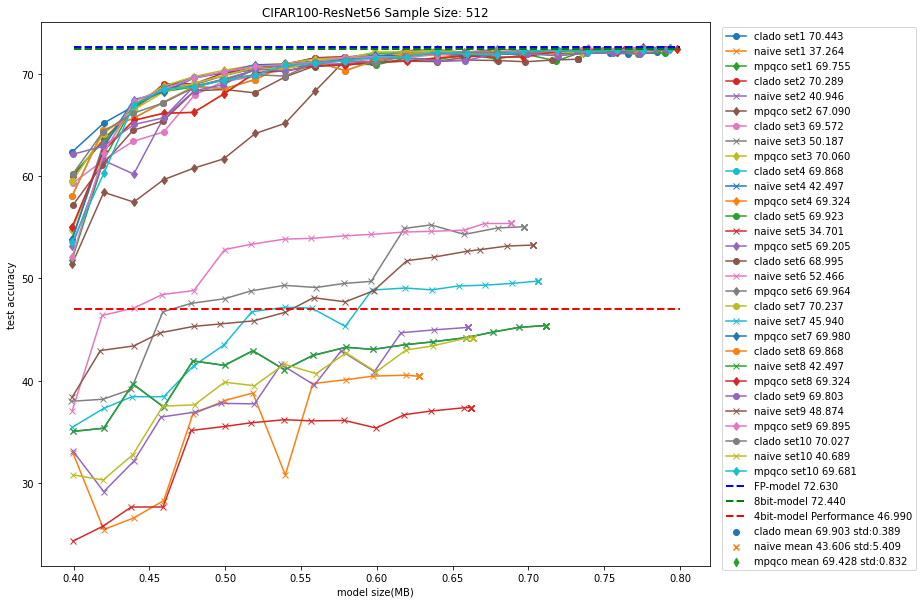

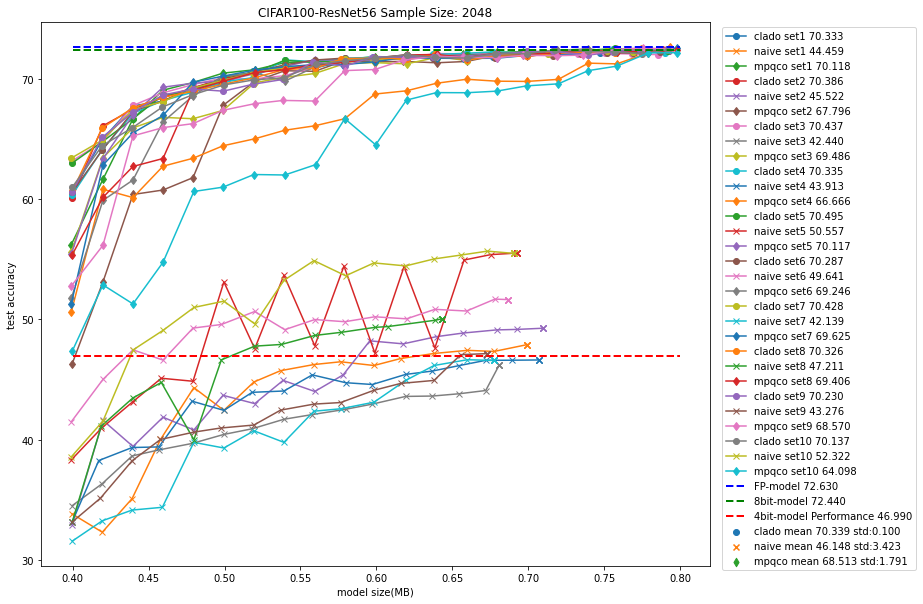

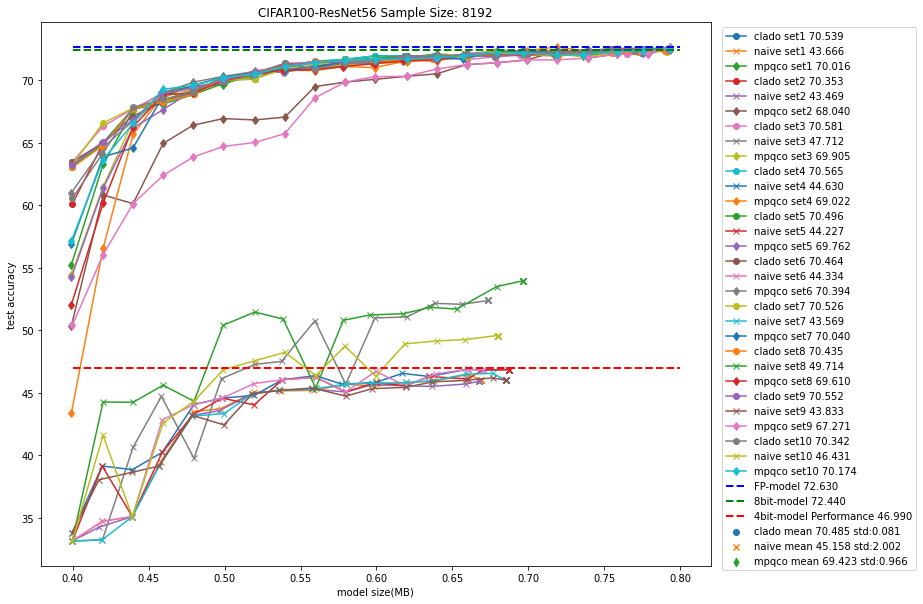

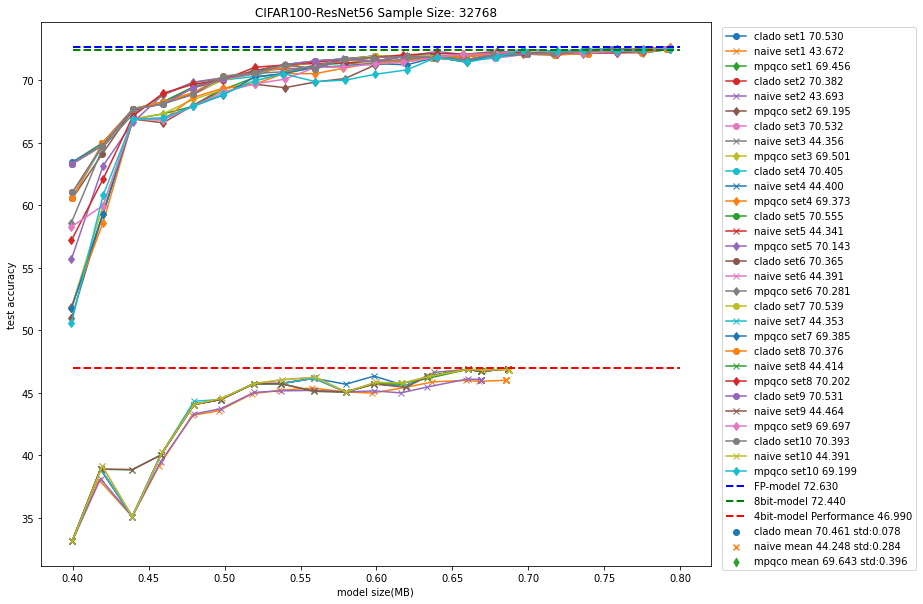

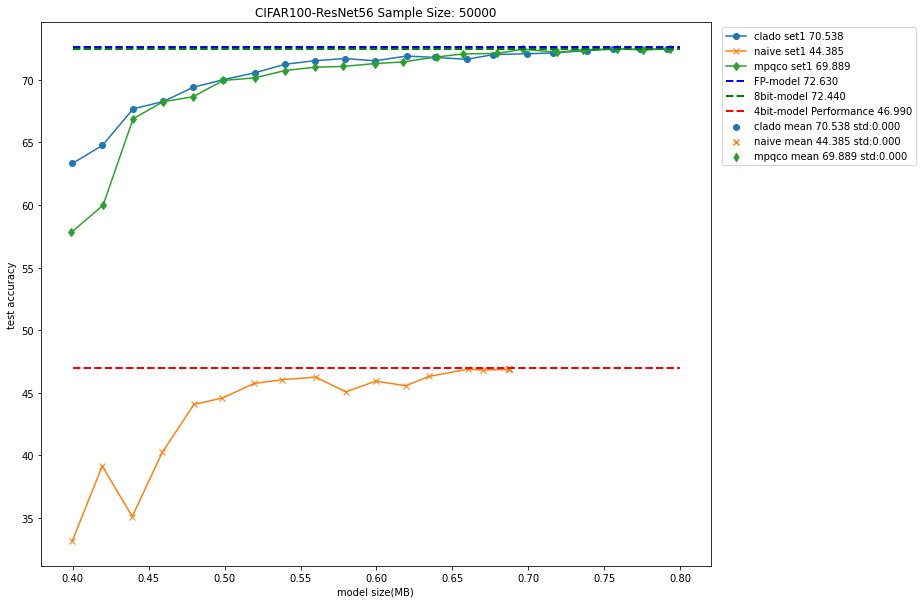

In [82]:
from sklearn.metrics import auc
import matplotlib.pyplot as plt
import numpy as np
#xlim,ylim = [0.6,0.8],[71,73]
xlim,ylim = None,None
show_naive = True

acc_fp = 72.63
acc_8b = 72.44
acc_4b = 46.99



for b in (1,4,16,64,98):
    
    plt.clf()
    
    auc_clado = []
    auc_mpqco = []
    auc_naive = []
    
    for sid in range(10):
        with open(f'RES_resnet56/RES_SIZEOPT_resnet56{b}batches(size64)_sid{sid}.pkl','rb') as f:
            res = pickle.load(f)

        clado_perf = [res['clado_perf'][i]['top1'].item() for i in range(len(res['clado_perf']))]

        naive_perf = [res['naive_perf'][i]['top1'].item() for i in range(len(res['naive_perf']))]
        mpqco_perf = [res['mpqco_perf'][i]['top1'].item() for i in range(len(res['mpqco_perf']))]

        plt.rcParams['figure.figsize'] = (12,10)
        
        x,y = res['clado_size'],clado_perf
        x,y = np.array(x),np.array(y)
#         x,y = getPF(x,y,xlim=xlim,ylim=ylim)
#         x = np.concatenate([x,np.array([20])])
#         y = np.concatenate([y,y[-1:]])
        metric = y.mean()
        auc_clado.append(metric)
        auc_clado.append(metric)
        plt.plot(x,y,marker='o',label=f'clado set{sid+1} {metric:.3f}')
        
        if show_naive:
            x,y = res['naive_size'],naive_perf
            x,y = np.array(x),np.array(y)
    #         x,y = getPF(x,y,xlim=xlim,ylim=ylim)
    #         x = np.concatenate([x,np.array([20])])
    #         y = np.concatenate([y,y[-1:]])
            metric = y.mean()
            auc_naive.append(metric)
            auc_naive.append(metric)
            plt.plot(x,y,marker='x',label=f'naive set{sid+1} {metric:.3f}')
        
        x,y = res['mpqco_size'],mpqco_perf
        x,y = np.array(x),np.array(y)
#         x,y = getPF(x,y,xlim=xlim,ylim=ylim)
#         x = np.concatenate([x,np.array([20])])
#         y = np.concatenate([y,y[-1:]])
        metric = y.mean()
        auc_mpqco.append(metric)
        auc_mpqco.append(metric)
        plt.plot(x,y,marker='d',label=f'mpqco set{sid+1} {metric:.3f}')
        if b == 98:
            break
        
    plt.hlines(y=acc_fp, xmin=0.4, xmax=0.8, colors='blue', linestyles='--', lw=2, label=f'FP-model {acc_fp:.3f}')
    plt.hlines(y=acc_8b, xmin=0.4, xmax=0.8, colors='green', linestyles='--', lw=2, label=f'8bit-model {acc_8b:.3f}')
    plt.hlines(y=acc_4b, xmin=0.4, xmax=0.8, colors='red', linestyles='--', lw=2, label=f'4bit-model Performance {acc_4b:.3f}')
    
    plt.scatter([],[],marker='o',label=f'clado mean {np.array(auc_clado).mean():.3f} std:{np.array(auc_clado).std():.3f}')
    if show_naive:
        plt.scatter([],[],marker='x',label=f'naive mean {np.array(auc_naive).mean():.3f} std:{np.array(auc_naive).std():.3f}')
    plt.scatter([],[],marker='d',label=f'mpqco mean {np.array(auc_mpqco).mean():.3f} std:{np.array(auc_mpqco).std():.3f}')
    plt.legend()
    plt.legend(bbox_to_anchor=(1.01, 1), loc="upper left")
    plt.xlabel('model size(MB)')
    plt.ylabel('test accuracy')
    plt.title(f'CIFAR100-ResNet56 Sample Size: {b*512 if b<98 else 50000}')
    
    if xlim is not None:
        plt.xlim(xlim)
    if ylim is not None:
        plt.ylim(ylim)
    plt.savefig(f'RES_resnet56/PLOTS/r56_{b*512 if b < 98 else 50000}samples_naive{show_naive}.pdf',transparent=True, bbox_inches='tight', pad_inches=0)
    plt.show()
        

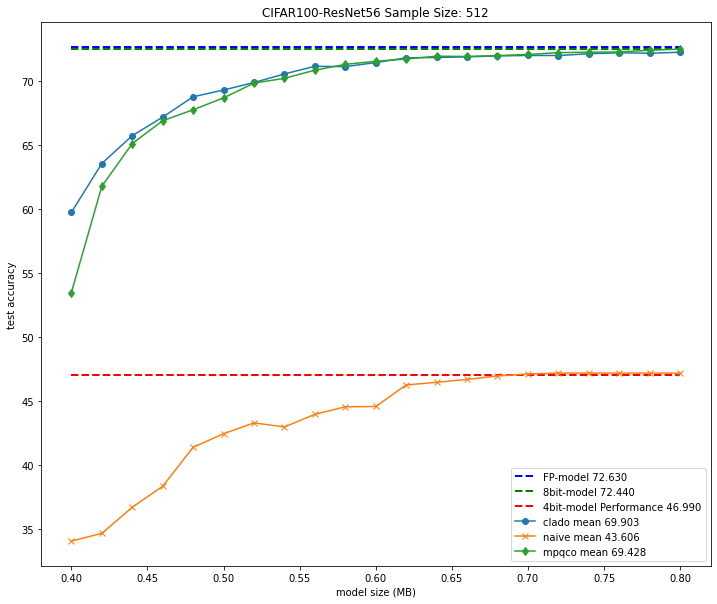

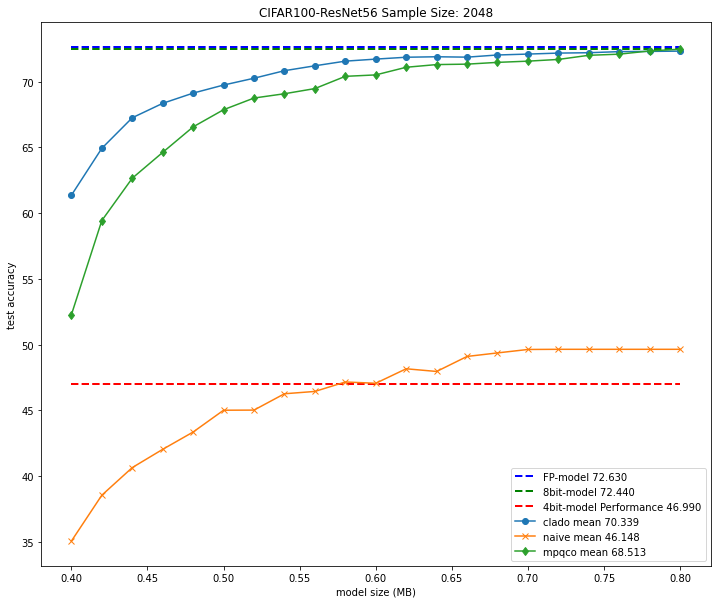

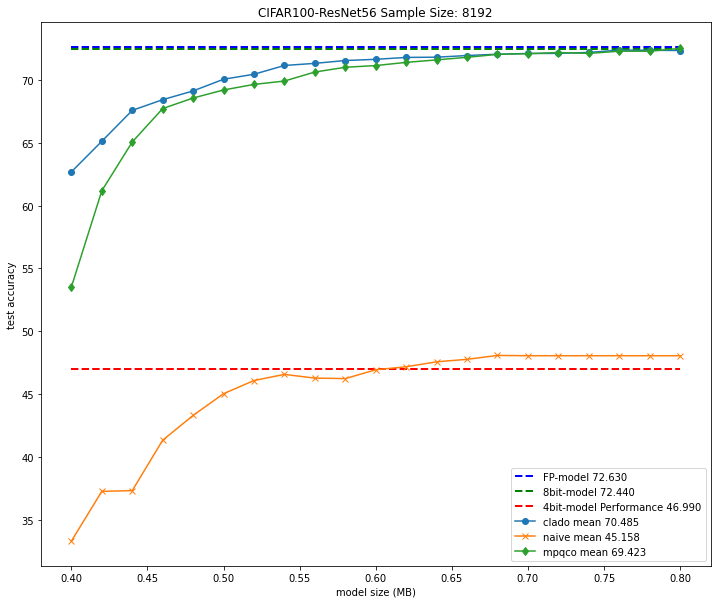

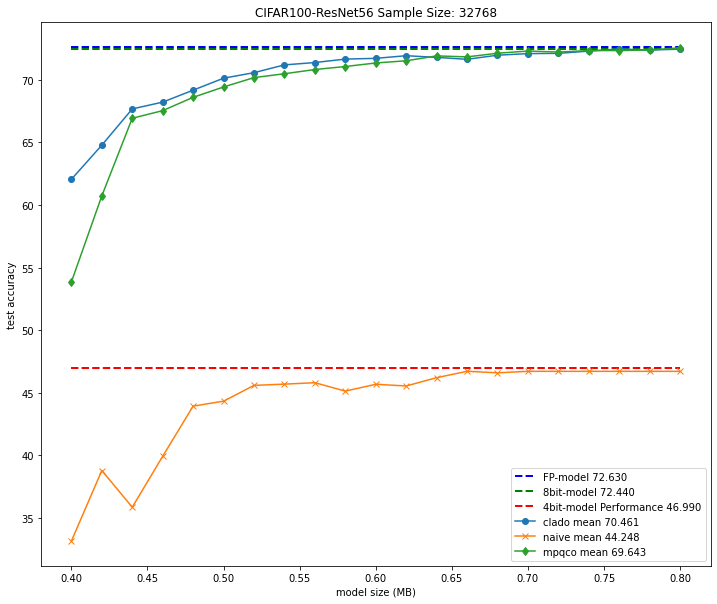

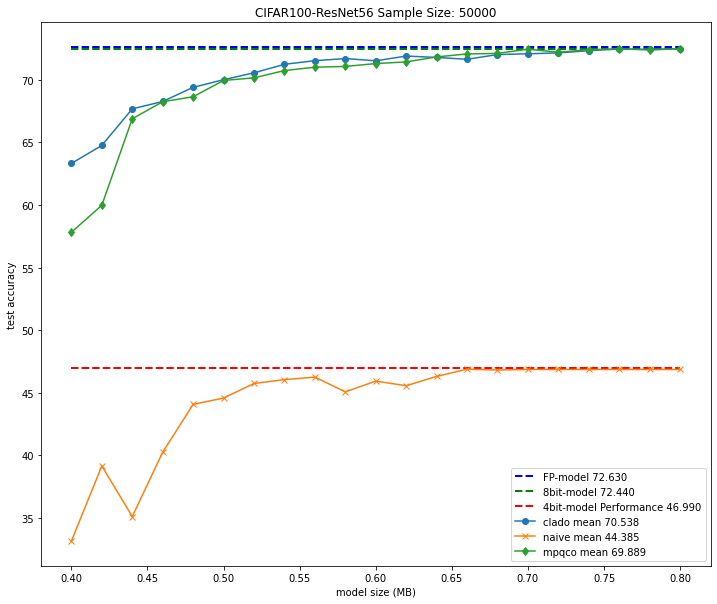

In [99]:
from sklearn.metrics import auc
xlim,ylim = [0.6,0.8],[71,73]
xlim,ylim = None,None
show_naive = True

acc_fp = 72.63
acc_8b = 72.44
acc_4b = 46.99

for b in (1,4,16,64,98):
    
    plt.clf()
    
    auc_clado = []
    auc_mpqco = []
    auc_naive = []
    
    for sid in range(10):
        with open(f'RES_resnet56/RES_SIZEOPT_resnet56{b}batches(size64)_sid{sid}.pkl','rb') as f:
            res = pickle.load(f)

        clado_perf = [res['clado_perf'][i]['top1'].item() for i in range(len(res['clado_perf']))]

        naive_perf = [res['naive_perf'][i]['top1'].item() for i in range(len(res['naive_perf']))]
        mpqco_perf = [res['mpqco_perf'][i]['top1'].item() for i in range(len(res['mpqco_perf']))]

        plt.rcParams['figure.figsize'] = (12,10)
        
        x,y = res['clado_size'],clado_perf
        x,y = np.array(x),np.array(y)
        auc_clado.append(y)
        
        x,y = res['naive_size'],naive_perf
        x,y = np.array(x),np.array(y)
        auc_naive.append(y)
        
        x,y = res['mpqco_size'],mpqco_perf
        x,y = np.array(x),np.array(y)
        auc_mpqco.append(y)
        if b == 98:
            break
        
    auc_clado = np.array(auc_clado)
    auc_naive = np.array(auc_naive)
    auc_mpqco = np.array(auc_mpqco)
    
    plt.hlines(y=acc_fp, xmin=0.4, xmax=0.8, colors='blue', linestyles='--', lw=2, label=f'FP-model {acc_fp:.3f}')
    plt.hlines(y=acc_8b, xmin=0.4, xmax=0.8, colors='green', linestyles='--', lw=2, label=f'8bit-model {acc_8b:.3f}')
    plt.hlines(y=acc_4b, xmin=0.4, xmax=0.8, colors='red', linestyles='--', lw=2, label=f'4bit-model Performance {acc_4b:.3f}')
    
    plt.plot(np.linspace(0.4,0.8,21),auc_clado.mean(axis=0),marker='o',label=f'clado mean {auc_clado.mean():.3f}')
    if show_naive:
        plt.plot(np.linspace(0.4,0.8,21),auc_naive.mean(axis=0),marker='x',label=f'naive mean {auc_naive.mean():.3f}')
    plt.plot(np.linspace(0.4,0.8,21),auc_mpqco.mean(axis=0),marker='d',label=f'mpqco mean {auc_mpqco.mean():.3f}')
    
    plt.legend()
    plt.xlabel(f'model size (MB)')
    plt.ylabel('test accuracy')
    plt.title(f'CIFAR100-ResNet56 Sample Size: {b*512 if b<98 else 50000}')
    
    if xlim is not None:
        plt.xlim(xlim)
    if ylim is not None:
        plt.ylim(ylim)
    plt.savefig(f'RES_resnet56/PLOTS/r56_{b*512 if b<98 else 50000}samples_naive{show_naive}avg.pdf',transparent=True, bbox_inches='tight', pad_inches=0)
    plt.show()
        

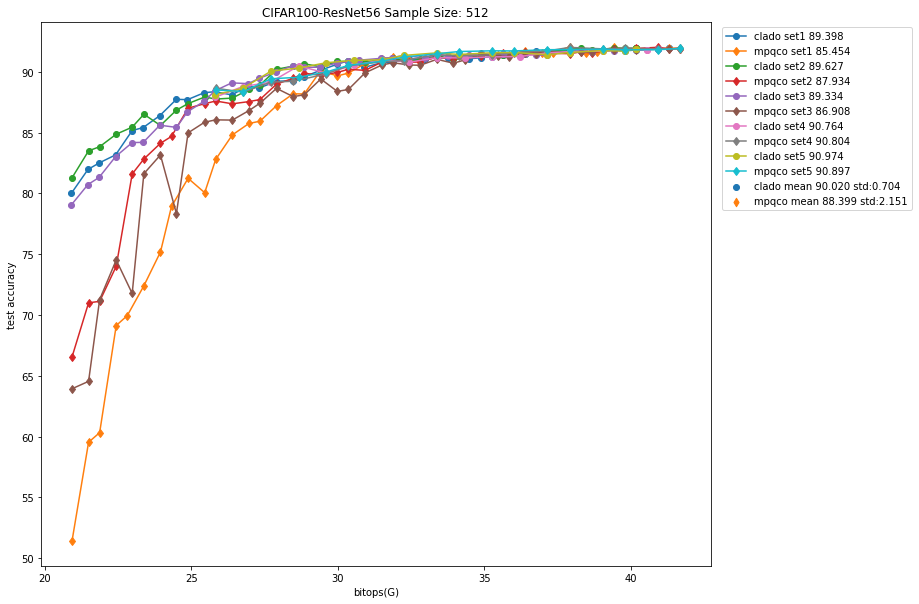

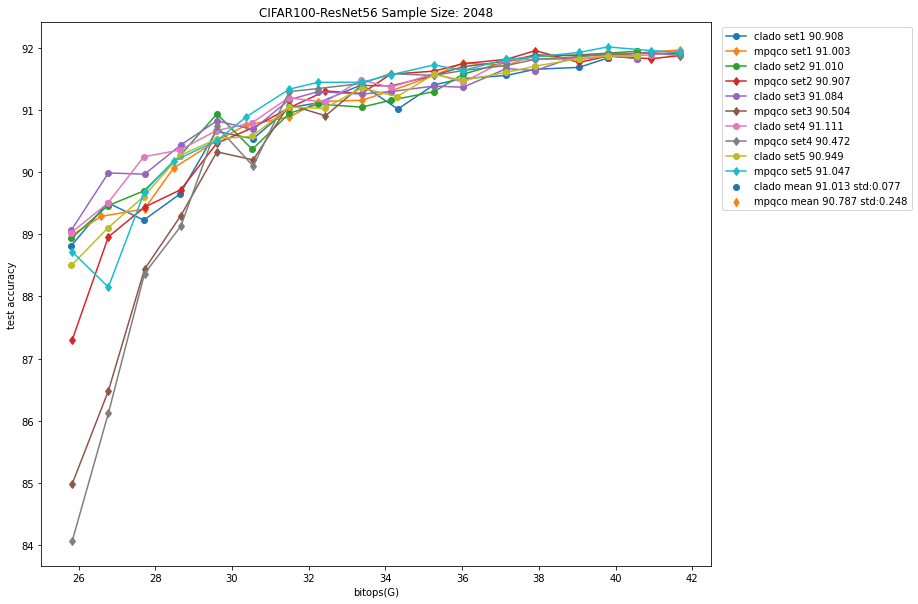

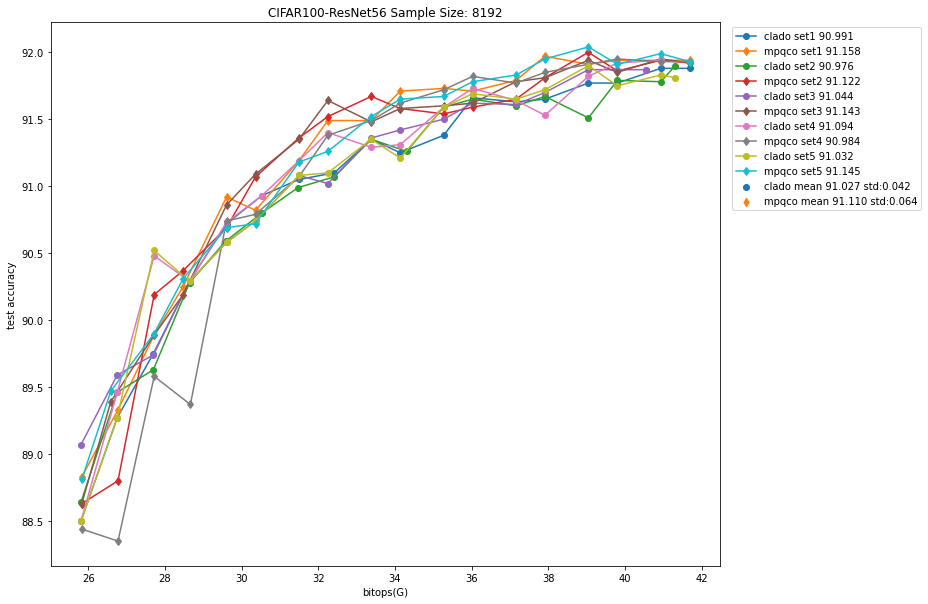

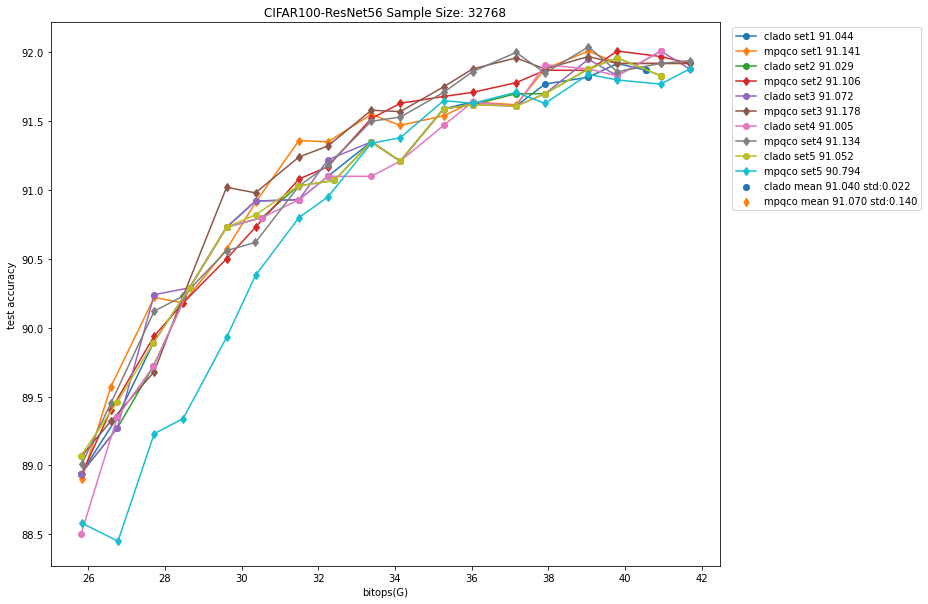

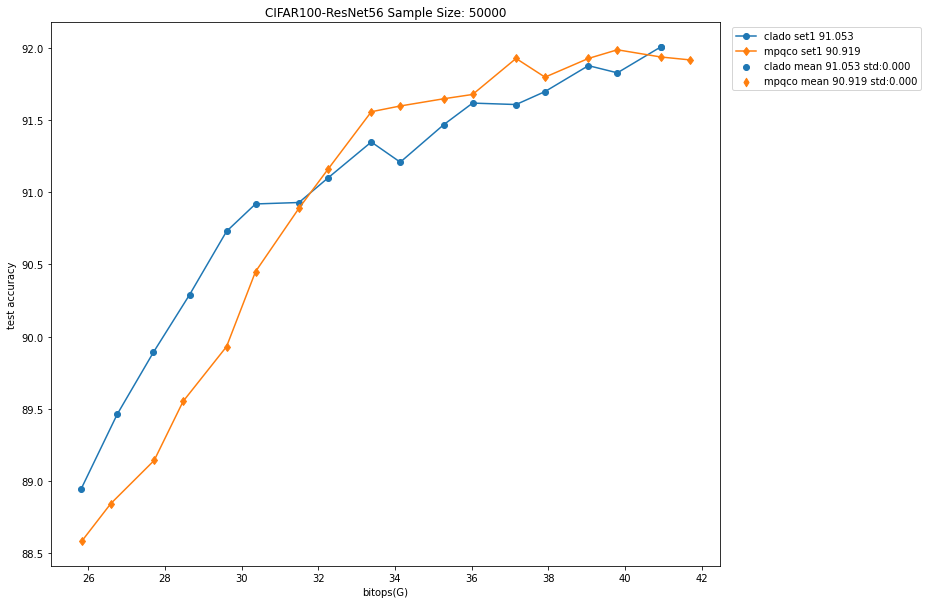

In [98]:
from sklearn.metrics import auc
import matplotlib.pyplot as plt
import numpy as np
#xlim,ylim = [0.6,0.8],[71,73]
xlim,ylim = None,None
show_naive = False

acc_fp = 72.63
acc_8b = 72.44
acc_4b = 46.99



for b in (1,4,16,64,98):
    
    plt.clf()
    
    auc_clado = []
    auc_mpqco = []
    auc_naive = []
    
    for sid in range(5):
        with open(f'RES_resnet56/RES_BITOPSOPT_resnet56{b}batches(size512)_sid{sid}.pkl','rb') as f:
            res = pickle.load(f)

        clado_perf = [res['clado_perf'][i]['top5'].item() for i in range(len(res['clado_perf']))]

        naive_perf = [res['naive_perf'][i]['top5'].item() for i in range(len(res['naive_perf']))]
        mpqco_perf = [res['mpqco_perf'][i]['top5'].item() for i in range(len(res['mpqco_perf']))]

        plt.rcParams['figure.figsize'] = (12,10)
        
        x,y = res['clado_bitops'],clado_perf
        x,y = np.array(x),np.array(y)
#         x,y = getPF(x,y,xlim=xlim,ylim=ylim)
#         x = np.concatenate([x,np.array([20])])
#         y = np.concatenate([y,y[-1:]])
        metric = y.mean()
        auc_clado.append(metric)
        auc_clado.append(metric)
        plt.plot(x,y,marker='o',label=f'clado set{sid+1} {metric:.3f}')
        
        if show_naive:
            x,y = res['naive_bitops'],naive_perf
            x,y = np.array(x),np.array(y)
    #         x,y = getPF(x,y,xlim=xlim,ylim=ylim)
    #         x = np.concatenate([x,np.array([20])])
    #         y = np.concatenate([y,y[-1:]])
            metric = y.mean()
            auc_naive.append(metric)
            auc_naive.append(metric)
            plt.plot(x,y,marker='x',label=f'naive set{sid+1} {metric:.3f}')
        
        x,y = res['mpqco_bitops'],mpqco_perf
        x,y = np.array(x),np.array(y)
#         x,y = getPF(x,y,xlim=xlim,ylim=ylim)
#         x = np.concatenate([x,np.array([20])])
#         y = np.concatenate([y,y[-1:]])
        metric = y.mean()
        auc_mpqco.append(metric)
        auc_mpqco.append(metric)
        plt.plot(x,y,marker='d',label=f'mpqco set{sid+1} {metric:.3f}')
        if b == 98:
            break
        
#     plt.hlines(y=acc_fp, xmin=26, xmax=42, colors='blue', linestyles='--', lw=2, label=f'FP-model {acc_fp:.3f}')
#     plt.hlines(y=acc_8b, xmin=26, xmax=42, colors='green', linestyles='--', lw=2, label=f'8bit-model {acc_8b:.3f}')
    #plt.hlines(y=acc_4b, xmin=26, xmax=42, colors='red', linestyles='--', lw=2, label=f'4bit-model Performance {acc_4b:.3f}')
    
    plt.scatter([],[],marker='o',label=f'clado mean {np.array(auc_clado).mean():.3f} std:{np.array(auc_clado).std():.3f}')
    if show_naive:
        plt.scatter([],[],marker='x',label=f'naive mean {np.array(auc_naive).mean():.3f} std:{np.array(auc_naive).std():.3f}')
    plt.scatter([],[],marker='d',label=f'mpqco mean {np.array(auc_mpqco).mean():.3f} std:{np.array(auc_mpqco).std():.3f}')
    plt.legend()
    plt.legend(bbox_to_anchor=(1.01, 1), loc="upper left")
    plt.xlabel('bitops(G)')
    plt.ylabel('test accuracy')
    plt.title(f'CIFAR100-ResNet56 Sample Size: {b*512 if b<98 else 50000}')
    
    if xlim is not None:
        plt.xlim(xlim)
    if ylim is not None:
        plt.ylim(ylim)
    plt.savefig(f'RES_resnet56/PLOTS/bitops_r56_{b*512 if b < 98 else 50000}samples_naive{show_naive}.pdf',transparent=True, bbox_inches='tight', pad_inches=0)
    plt.show()
        

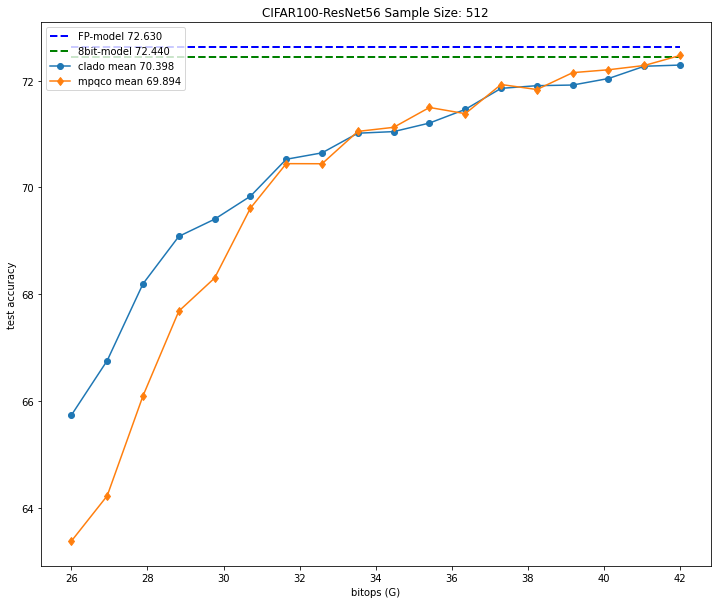

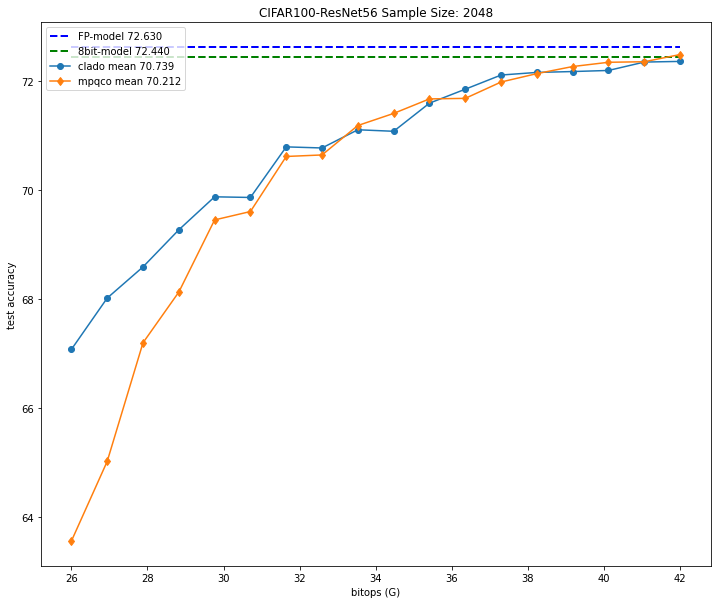

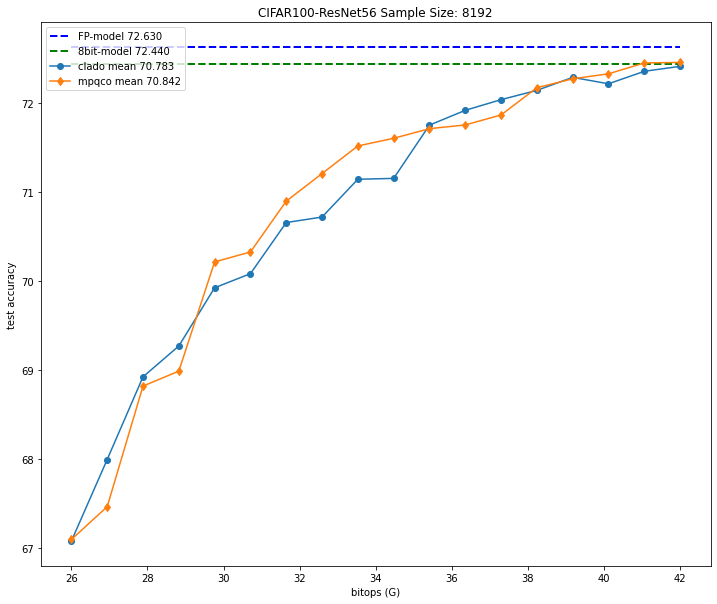

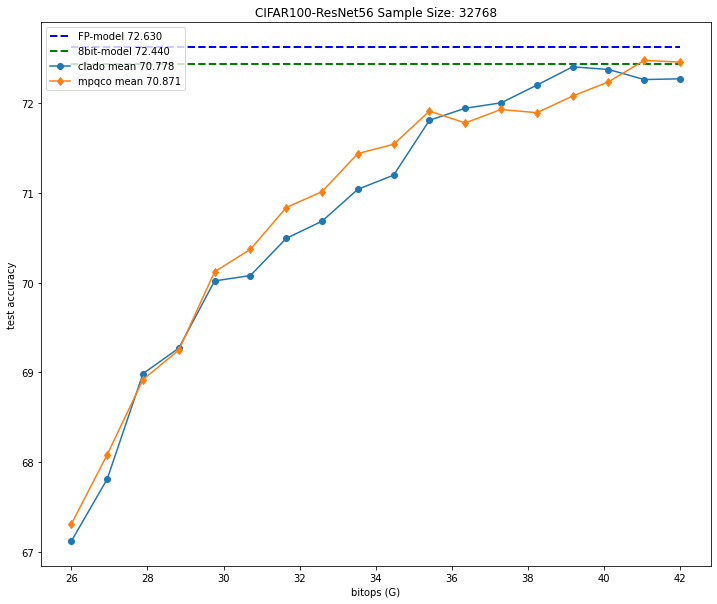

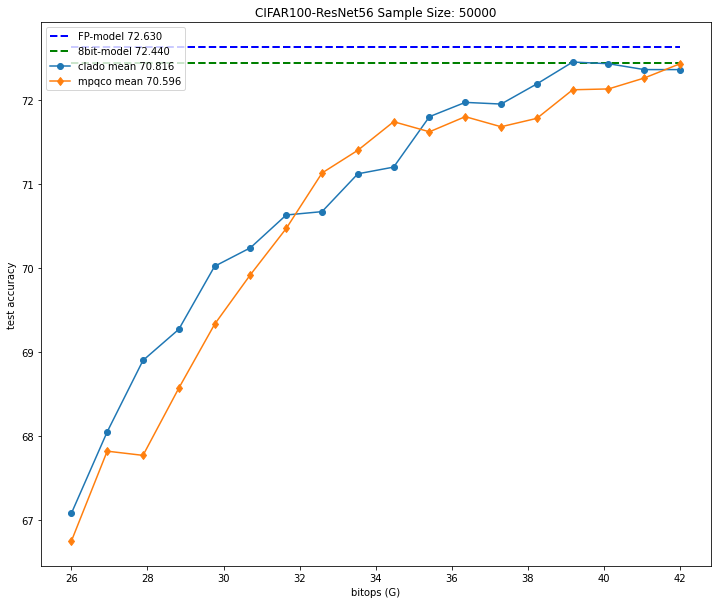

In [96]:
from sklearn.metrics import auc
xlim,ylim = [0.6,0.8],[71,73]
xlim,ylim = None,None
show_naive = False

acc_fp = 72.63
acc_8b = 72.44
acc_4b = 46.99

for b in (1,4,16,64,98):
    
    plt.clf()
    
    auc_clado = []
    auc_mpqco = []
    auc_naive = []
    
    for sid in range(5):
        with open(f'RES_resnet56/RES_BITOPSOPT_resnet56{b}batches(size512)_sid{sid}.pkl','rb') as f:
            res = pickle.load(f)

        clado_perf = [res['clado_perf'][i]['top1'].item() for i in range(len(res['clado_perf']))]

        naive_perf = [res['naive_perf'][i]['top1'].item() for i in range(len(res['naive_perf']))]
        mpqco_perf = [res['mpqco_perf'][i]['top1'].item() for i in range(len(res['mpqco_perf']))]

        plt.rcParams['figure.figsize'] = (12,10)
        
        x,y = res['clado_bitops'],clado_perf
        x,y = np.array(x),np.array(y)
        auc_clado.append(y)
        
        x,y = res['naive_bitops'],naive_perf
        x,y = np.array(x),np.array(y)
        auc_naive.append(y)
        
        x,y = res['mpqco_bitops'],mpqco_perf
        x,y = np.array(x),np.array(y)
        auc_mpqco.append(y)
        if b == 98:
            break
        
    auc_clado = np.array(auc_clado)
    auc_naive = np.array(auc_naive)
    auc_mpqco = np.array(auc_mpqco)
    
    plt.hlines(y=acc_fp, xmin=26, xmax=42, colors='blue', linestyles='--', lw=2, label=f'FP-model {acc_fp:.3f}')
    plt.hlines(y=acc_8b, xmin=26, xmax=42, colors='green', linestyles='--', lw=2, label=f'8bit-model {acc_8b:.3f}')
    #plt.hlines(y=acc_4b, xmin=0.4, xmax=0.8, colors='red', linestyles='--', lw=2, label=f'4bit-model Performance {acc_4b:.3f}')
    
    plt.plot(np.linspace(26,42,18),auc_clado.mean(axis=0),marker='o',label=f'clado mean {auc_clado.mean():.3f}')
    if show_naive:
        plt.plot(np.linspace(26,42,18),auc_naive.mean(axis=0),marker='x',label=f'naive mean {auc_naive.mean():.3f}')
    plt.plot(np.linspace(26,42,18),auc_mpqco.mean(axis=0),marker='d',label=f'mpqco mean {auc_mpqco.mean():.3f}')
    
    plt.legend()
    plt.xlabel(f'bitops (G)')
    plt.ylabel('test accuracy')
    plt.title(f'CIFAR100-ResNet56 Sample Size: {b*512 if b<98 else 50000}')
    
    if xlim is not None:
        plt.xlim(xlim)
    if ylim is not None:
        plt.ylim(ylim)
    plt.savefig(f'RES_resnet56/PLOTS/bitops_r56_{b*512 if b<98 else 50000}samples_naive{show_naive}avg.pdf',transparent=True, bbox_inches='tight', pad_inches=0)
    plt.show()
        